<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma0_99_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.25, desired_action_stddev=0.25, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=0.99, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<11:57,  1.39episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:05<34:12,  2.06s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:06<26:55,  1.62s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:11<44:16,  2.67s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:12<33:47,  2.04s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:17<47:38,  2.88s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:17<36:28,  2.20s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:22<49:36,  3.00s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:23<37:27,  2.27s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:27<50:02,  3.03s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.04956775903701782|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.6189 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.01761666148328465 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.02130197831103179 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.07159550191317317 || eq_WSEE: 0.10557475616596732 || Reward: -0.31 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08904695878674326 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.053544836431797777, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:38<1:11:37,  4.35s/episode]

Loss: 0.080991730093956|| Global step: 600 || Episode: 12 || Reward: 0.59 || Distance: 0.5483 ||
wsee: 0.10682039900696146, eqwsee: 0.13152993615391398, reward: 0.5898670338723484


  1%|1         | 13/1000 [00:40<1:00:27,  3.68s/episode]

Loss: 0.031149204820394516|| Global step: 650 || Episode: 13 || Reward: -0.55 || Distance: 0.4630 ||
wsee: 0.13485390392485158, eqwsee: 0.13109976637185683, reward: -0.5530489337501985
|| Test Run No: 1100 || WSEE: 0.014856018950932729 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.014162429205689967 || eq_WSEE: 0.15875344714719553 || Reward: -1.27 ||
|| Test Run No: 1140 || WSEE: 0.06688982659895575 || eq_WSEE: 0.10557475616596732 || Reward: -0.36 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08587703344247465 || eq_WSEE: 0.13084527637398705 || Reward: -0.57 ||
wsee:0.048385695560218475, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:47<1:13:40,  4.48s/episode]

Loss: 0.03997579216957092|| Global step: 700 || Episode: 14 || Reward: 0.24 || Distance: 0.9688 ||
wsee: 0.10399126580488577, eqwsee: 0.13152993615391398, reward: 0.23878782299371498


  2%|1         | 15/1000 [00:49<1:01:49,  3.77s/episode]

Loss: 0.025742879137396812|| Global step: 750 || Episode: 15 || Reward: 0.31 || Distance: 0.6637 ||
wsee: 0.1138429379085775, eqwsee: 0.08896563362710563, reward: 0.3143423400360641
|| Test Run No: 1100 || WSEE: 0.01575759466675715 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.0052157166717073005 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.05746514902750179 || eq_WSEE: 0.10557475616596732 || Reward: -0.45 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08191714883959943 || eq_WSEE: 0.13084527637398705 || Reward: -0.59 ||
wsee:0.04245628957290544, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [00:55<1:14:53,  4.57s/episode]

Loss: 0.07466690242290497|| Global step: 800 || Episode: 16 || Reward: 0.92 || Distance: 0.5039 ||
wsee: 0.10156053634180723, eqwsee: 0.13152993615391398, reward: 0.9161012236416114


  2%|1         | 17/1000 [00:57<1:02:53,  3.84s/episode]

Loss: 0.050056006759405136|| Global step: 850 || Episode: 17 || Reward: -0.45 || Distance: 0.8577 ||
wsee: 0.1498842137957764, eqwsee: 0.1498842137957764, reward: -0.45129633987040374
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.004563906825529554 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.04164003457394018 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0779250147226474 || eq_WSEE: 0.13084527637398705 || Reward: -0.61 ||
wsee:0.03500599187448181, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [01:04<1:15:53,  4.64s/episode]

Loss: 0.04647209495306015|| Global step: 900 || Episode: 18 || Reward: 0.00 || Distance: 0.6061 ||
wsee: 0.09988599716474753, eqwsee: 0.13152993615391398, reward: 0.0


  2%|1         | 19/1000 [01:06<1:03:11,  3.87s/episode]

Loss: 0.04558756574988365|| Global step: 950 || Episode: 19 || Reward: -0.38 || Distance: 0.7421 ||
wsee: 0.10658873034354317, eqwsee: 0.10658873034354317, reward: -0.37607412445824084
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.0038861623239950004 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.03283280463328964 || eq_WSEE: 0.10557475616596732 || Reward: -0.68 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07240347496325483 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.030743275258965665, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [01:12<1:15:58,  4.65s/episode]

Loss: 0.022734060883522034|| Global step: 1000 || Episode: 20 || Reward: 0.00 || Distance: 0.6577 ||
wsee: 0.0975376728089219, eqwsee: 0.13152993615391398, reward: 0.0


  2%|2         | 21/1000 [01:15<1:03:38,  3.90s/episode]

Loss: 0.04044194892048836|| Global step: 1050 || Episode: 21 || Reward: 1.15 || Distance: 0.2465 ||
wsee: 0.13487202523370706, eqwsee: 0.10375368536381287, reward: 1.145728625550529
|| Test Run No: 1100 || WSEE: 0.01599726312194836 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.002969969154705053 || eq_WSEE: 0.15875344714719553 || Reward: -1.45 ||
|| Test Run No: 1140 || WSEE: 0.029890774066080376 || eq_WSEE: 0.10557475616596732 || Reward: -0.75 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06120146245845549 || eq_WSEE: 0.13084527637398705 || Reward: -0.79 ||
wsee:0.02793153140550448, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:21<1:16:48,  4.71s/episode]

Loss: 0.06128770858049393|| Global step: 1100 || Episode: 22 || Reward: 1.44 || Distance: 1.0741 ||
wsee: 0.09184494153733591, eqwsee: 0.13152993615391398, reward: 1.443186544195373


  2%|2         | 23/1000 [01:23<1:04:42,  3.97s/episode]

Loss: 0.06380565464496613|| Global step: 1150 || Episode: 23 || Reward: 1.21 || Distance: 0.6669 ||
wsee: 0.14729824422135657, eqwsee: 0.12460080593306919, reward: 1.2070805619546996
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.010354965996198373 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.02999222567843759 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0549224818412509 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.02633607547971255, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:30<1:18:33,  4.83s/episode]

Loss: 0.054991334676742554|| Global step: 1200 || Episode: 24 || Reward: 0.13 || Distance: 0.6585 ||
wsee: 0.08764084232112819, eqwsee: 0.13152993615391398, reward: 0.12636100660901217


  2%|2         | 25/1000 [01:33<1:06:16,  4.08s/episode]

Loss: 0.07049626111984253|| Global step: 1250 || Episode: 25 || Reward: -0.05 || Distance: 0.9635 ||
wsee: 0.10367703161002552, eqwsee: 0.09376202016680894, reward: -0.048077769080633576
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.010357048892797722 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.029992449499173558 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05492166220342651 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.026335935504462334, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:40<1:20:51,  4.98s/episode]

Loss: 0.019794467836618423|| Global step: 1300 || Episode: 26 || Reward: 0.11 || Distance: 1.2085 ||
wsee: 0.08764031429642809, eqwsee: 0.13152993615391398, reward: 0.10651192632174836


  3%|2         | 27/1000 [01:42<1:08:31,  4.23s/episode]

Loss: 0.04576458781957626|| Global step: 1350 || Episode: 27 || Reward: -5.66 || Distance: 0.5778 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -5.664785064464281
|| Test Run No: 1100 || WSEE: 0.016522018082967105 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.013697629916042777 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.032061168575322 || eq_WSEE: 0.10557475616596732 || Reward: -0.78 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05207424116269575 || eq_WSEE: 0.13084527637398705 || Reward: -0.91 ||
wsee:0.02544460381568937, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [01:49<1:22:43,  5.11s/episode]

Loss: 0.03271229565143585|| Global step: 1400 || Episode: 28 || Reward: 0.22 || Distance: 0.5664 ||
wsee: 0.08616588291086376, eqwsee: 0.13152993615391398, reward: 0.22390419093772193


  3%|2         | 29/1000 [01:52<1:09:49,  4.32s/episode]

Loss: 0.07497431337833405|| Global step: 1450 || Episode: 29 || Reward: -4.60 || Distance: 0.7581 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.595355364210205
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.022435657805919856 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.03179645315949425 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.049282365556680405 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.023753449949890936, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [01:59<1:24:34,  5.23s/episode]

Loss: 0.06933081150054932|| Global step: 1500 || Episode: 30 || Reward: -7.34 || Distance: 0.2837 ||
wsee: 0.08267174870421931, eqwsee: 0.13152993615391398, reward: -7.33900452895545


  3%|3         | 31/1000 [02:02<1:12:37,  4.50s/episode]

Loss: 0.045922767370939255|| Global step: 1550 || Episode: 31 || Reward: -0.05 || Distance: 0.7740 ||
wsee: 0.11408816315779949, eqwsee: 0.11408816315779949, reward: -0.051514409306430586
|| Test Run No: 1100 || WSEE: 0.017302184730109298 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.02760672097899029 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.03209952071373691 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04698373983054808 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.023060029984777505, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [02:09<1:27:06,  5.40s/episode]

Loss: 0.055574845522642136|| Global step: 1600 || Episode: 32 || Reward: 0.74 || Distance: 0.5652 ||
wsee: 0.08004075952630545, eqwsee: 0.13152993615391398, reward: 0.7366346238467503


  3%|3         | 33/1000 [02:12<1:13:30,  4.56s/episode]

Loss: 0.02978735789656639|| Global step: 1650 || Episode: 33 || Reward: 0.31 || Distance: 0.3601 ||
wsee: 0.12747766087200432, eqwsee: 0.12747766087200432, reward: 0.30859942642137733
|| Test Run No: 1100 || WSEE: 0.017911988204409566 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.033078499886805855 || eq_WSEE: 0.15875344714719553 || Reward: -1.29 ||
|| Test Run No: 1140 || WSEE: 0.03235463240840619 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04319148171688411 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.02147622087579877, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [02:20<1:28:12,  5.48s/episode]

Loss: 0.03315168246626854|| Global step: 1700 || Episode: 34 || Reward: 1.07 || Distance: 0.5234 ||
wsee: 0.0730852951018062, eqwsee: 0.13152993615391398, reward: 1.073822187872702


  4%|3         | 35/1000 [02:22<1:15:05,  4.67s/episode]

Loss: 0.0034026147332042456|| Global step: 1750 || Episode: 35 || Reward: -0.01 || Distance: 0.4719 ||
wsee: 0.17805206720031552, eqwsee: 0.1546985766937026, reward: -0.010213623630760588
|| Test Run No: 1100 || WSEE: 0.01779975860180298 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.031036997970628994 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.032084592996754265 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.039141342167752335 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.019942341238694067, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [02:30<1:27:26,  5.44s/episode]

Loss: 0.05078575760126114|| Global step: 1800 || Episode: 36 || Reward: 1.63 || Distance: 0.6295 ||
wsee: 0.07286186313933705, eqwsee: 0.13152993615391398, reward: 1.6324599749715785


  4%|3         | 37/1000 [02:32<1:12:36,  4.52s/episode]

Loss: 0.0013507833937183022|| Global step: 1850 || Episode: 37 || Reward: -0.51 || Distance: 0.5751 ||
wsee: 0.12942636481142852, eqwsee: 0.12942636481142852, reward: -0.5144826512589371
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.033540763143888964 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03371370348157525 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03218225640373374 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.019686805029352793, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:39<1:24:14,  5.25s/episode]

Loss: 0.03551006317138672|| Global step: 1900 || Episode: 38 || Reward: 0.00 || Distance: 0.7506 ||
wsee: 0.06975217966588501, eqwsee: 0.13152993615391398, reward: 0.0


  4%|3         | 39/1000 [02:41<1:10:32,  4.40s/episode]

Loss: 0.041972726583480835|| Global step: 1950 || Episode: 39 || Reward: 0.08 || Distance: 0.3437 ||
wsee: 0.15578674141863458, eqwsee: 0.13366216924837832, reward: 0.07707175919139314
|| Test Run No: 1100 || WSEE: 0.01821110788605955 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0335431040016904 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03371521170503009 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.032177922843117074 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.019726999785203446, fpa_wsee: 0.12424997011815597


  4%|4         | 40/1000 [02:48<1:22:52,  5.18s/episode]

Loss: 0.025477230548858643|| Global step: 2000 || Episode: 40 || Reward: 1.30 || Distance: 0.5266 ||
wsee: 0.06974991605246066, eqwsee: 0.13152993615391398, reward: 1.2966163357586589


  4%|4         | 41/1000 [02:51<1:10:04,  4.38s/episode]

Loss: 0.04451572895050049|| Global step: 2050 || Episode: 41 || Reward: -7.03 || Distance: 0.7397 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -7.033884120715463
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.0335431040016904 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03371521170503009 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.032177922843117074 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.01968695672140233, fpa_wsee: 0.12424997011815597


  4%|4         | 42/1000 [02:58<1:24:49,  5.31s/episode]

Loss: 0.028870057314634323|| Global step: 2100 || Episode: 42 || Reward: -1.06 || Distance: 0.6931 ||
wsee: 0.06974991605246066, eqwsee: 0.13152993615391398, reward: -1.0598823581329695


  4%|4         | 43/1000 [03:01<1:13:37,  4.62s/episode]

Loss: 0.023592744022607803|| Global step: 2150 || Episode: 43 || Reward: -0.64 || Distance: 0.2284 ||
wsee: 0.12250858667792802, eqwsee: 0.10543505078886685, reward: -0.6390721829100865
|| Test Run No: 1100 || WSEE: 0.017706826539238864 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0335431040016904 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03371521170503009 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.032177922843117074 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.019721956971735243, fpa_wsee: 0.12424997011815597


  4%|4         | 44/1000 [03:09<1:26:59,  5.46s/episode]

Loss: 0.012638934887945652|| Global step: 2200 || Episode: 44 || Reward: 1.16 || Distance: 0.3855 ||
wsee: 0.06974991605246066, eqwsee: 0.13152993615391398, reward: 1.1577741511400443


  4%|4         | 45/1000 [03:12<1:14:06,  4.66s/episode]

Loss: 0.013962524943053722|| Global step: 2250 || Episode: 45 || Reward: -0.39 || Distance: 0.7135 ||
wsee: 0.1013206570414654, eqwsee: 0.09938214209364687, reward: -0.3899189485827521
|| Test Run No: 1100 || WSEE: 0.018930960895661986 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0335431040016904 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03371521170503009 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.032177922843117074 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.019734198315299475, fpa_wsee: 0.12424997011815597


  5%|4         | 46/1000 [03:19<1:27:12,  5.48s/episode]

Loss: 0.010637007653713226|| Global step: 2300 || Episode: 46 || Reward: 1.54 || Distance: 0.2494 ||
wsee: 0.06974991605246066, eqwsee: 0.13152993615391398, reward: 1.5408380055497901


  5%|4         | 47/1000 [03:22<1:13:54,  4.65s/episode]

Loss: 0.010824263095855713|| Global step: 2350 || Episode: 47 || Reward: 0.54 || Distance: 0.5466 ||
wsee: 0.15392851329055446, eqwsee: 0.12716993041365515, reward: 0.5377768852846225
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.033262015265869235 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03347084921099182 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03226294134446263 || eq_WSEE: 0.13084527637398705 || Reward: -1.15 ||
wsee:0.019614435194756384, fpa_wsee: 0.12424997011815597


  5%|4         | 48/1000 [03:29<1:26:50,  5.47s/episode]

Loss: 0.019183538854122162|| Global step: 2400 || Episode: 48 || Reward: 0.04 || Distance: 0.7401 ||
wsee: 0.06976402748271619, eqwsee: 0.13152993615391398, reward: 0.04319711281798712


  5%|4         | 49/1000 [03:32<1:13:27,  4.64s/episode]

Loss: 0.02585216797888279|| Global step: 2450 || Episode: 49 || Reward: -5.10 || Distance: 0.2587 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -5.098639738569019
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.032337536046585194 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03270437239026326 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.033155730300420745 || eq_WSEE: 0.13084527637398705 || Reward: -1.14 ||
wsee:0.0191988769156678, fpa_wsee: 0.12424997011815597


  5%|5         | 50/1000 [03:39<1:27:03,  5.50s/episode]

Loss: 0.0016323468880727887|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.3436 ||
wsee: 0.0701681207379321, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [03:42<1:14:38,  4.72s/episode]

Loss: 0.018843285739421844|| Global step: 2550 || Episode: 51 || Reward: -0.22 || Distance: 0.7069 ||
wsee: 0.10805633557466793, eqwsee: 0.09371570435552588, reward: -0.2158146650367898
|| Test Run No: 1100 || WSEE: 0.015127453894212056 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.03121542402196331 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.03176497930483726 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.034265363391021895 || eq_WSEE: 0.13084527637398705 || Reward: -1.13 ||
wsee:0.019337700662304523, fpa_wsee: 0.12424997011815597


  5%|5         | 52/1000 [03:50<1:28:21,  5.59s/episode]

Loss: 0.017926424741744995|| Global step: 2600 || Episode: 52 || Reward: 0.54 || Distance: 0.3404 ||
wsee: 0.07064115140254604, eqwsee: 0.13152993615391398, reward: 0.5384584585714989


  5%|5         | 53/1000 [03:53<1:15:07,  4.76s/episode]

Loss: 0.020857185125350952|| Global step: 2650 || Episode: 53 || Reward: -4.36 || Distance: 0.2126 ||
wsee: 0.00011947517101353308, eqwsee: 0.10080306344627107, reward: -4.355561335729177
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.03048603858362 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.03111342467986512 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.035830094937463565 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.019310586690882644, fpa_wsee: 0.12424997011815597


  5%|5         | 54/1000 [04:00<1:28:14,  5.60s/episode]

Loss: 0.02117978222668171|| Global step: 2700 || Episode: 54 || Reward: -5.17 || Distance: 0.1755 ||
wsee: 0.07149733061055252, eqwsee: 0.13152993615391398, reward: -5.173886807693772


  6%|5         | 55/1000 [04:03<1:15:08,  4.77s/episode]

Loss: 0.0021423418074846268|| Global step: 2750 || Episode: 55 || Reward: 0.44 || Distance: 0.0854 ||
wsee: 0.14861864504232497, eqwsee: 0.1195833502440462, reward: 0.43894084789518045
|| Test Run No: 1100 || WSEE: 0.0194590404730109 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.030065388059620203 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.030698401817247107 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03687461968218977 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.01957529156996214, fpa_wsee: 0.12424997011815597


  6%|5         | 56/1000 [04:11<1:30:21,  5.74s/episode]

Loss: 0.023172330111265182|| Global step: 2800 || Episode: 56 || Reward: 1.41 || Distance: 0.3402 ||
wsee: 0.07210115943507202, eqwsee: 0.13152993615391398, reward: 1.405568632258514


  6%|5         | 57/1000 [04:14<1:17:14,  4.92s/episode]

Loss: 0.015658317133784294|| Global step: 2850 || Episode: 57 || Reward: -4.52 || Distance: 0.1454 ||
wsee: 7.309871567986143e-05, eqwsee: 0.09568350753601491, reward: -4.518908149188937
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02966294177963997 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.030318412783540624 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03729413123981965 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.019380486291321327, fpa_wsee: 0.12424997011815597


  6%|5         | 58/1000 [04:23<1:34:17,  6.01s/episode]

Loss: 0.018074268475174904|| Global step: 2900 || Episode: 58 || Reward: -3.83 || Distance: 0.3407 ||
wsee: 0.07231364046739289, eqwsee: 0.13152993615391398, reward: -3.833091611355211


  6%|5         | 59/1000 [04:26<1:20:31,  5.13s/episode]

Loss: 0.014278246089816093|| Global step: 2950 || Episode: 59 || Reward: 0.37 || Distance: 0.8473 ||
wsee: 0.17319971573150128, eqwsee: 0.14337031954840265, reward: 0.3714624225578307
|| Test Run No: 1100 || WSEE: 0.015286500996078796 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.029353047992901015 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.0300294415569559 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.037389405454115135 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.01950959107111752, fpa_wsee: 0.12424997011815597


  6%|6         | 60/1000 [04:34<1:33:28,  5.97s/episode]

Loss: 0.01469347719103098|| Global step: 3000 || Episode: 60 || Reward: 0.59 || Distance: 0.5186 ||
wsee: 0.07233493090042434, eqwsee: 0.13152993615391398, reward: 0.5882739089839519


  6%|6         | 61/1000 [04:37<1:20:04,  5.12s/episode]

Loss: 0.01041627861559391|| Global step: 3050 || Episode: 61 || Reward: 1.23 || Distance: 0.4528 ||
wsee: 0.18178409744873195, eqwsee: 0.14523213734839777, reward: 1.228212675783855
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02917272628728783 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029821279951240995 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.037358549675716404 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.01933605485666952, fpa_wsee: 0.12424997011815597


  6%|6         | 62/1000 [04:44<1:32:08,  5.89s/episode]

Loss: 0.041303545236587524|| Global step: 3100 || Episode: 62 || Reward: -4.28 || Distance: 0.2731 ||
wsee: 0.07227506088078148, eqwsee: 0.13152993615391398, reward: -4.282858895034022


  6%|6         | 63/1000 [04:47<1:18:23,  5.02s/episode]

Loss: 0.01517678052186966|| Global step: 3150 || Episode: 63 || Reward: -6.00 || Distance: 0.1839 ||
wsee: 0.00018690031799214527, eqwsee: 0.13208198076632058, reward: -6.001181436622043
|| Test Run No: 1100 || WSEE: 0.015355901328567135 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.029090630789765017 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029714853419278875 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03727303791242601 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.0194605039724347, fpa_wsee: 0.12424997011815597


  6%|6         | 64/1000 [04:56<1:32:46,  5.95s/episode]

Loss: 0.03966149687767029|| Global step: 3200 || Episode: 64 || Reward: -0.33 || Distance: 0.4804 ||
wsee: 0.07219873633978967, eqwsee: 0.13152993615391398, reward: -0.33283651957891225


  6%|6         | 65/1000 [04:58<1:17:57,  5.00s/episode]

Loss: 0.009549004957079887|| Global step: 3250 || Episode: 65 || Reward: 0.56 || Distance: 0.2922 ||
wsee: 0.159226820947498, eqwsee: 0.12165755228267655, reward: 0.5630497679913926
|| Test Run No: 1100 || WSEE: 0.017071931880045094 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.029069452884422725 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02967671097755025 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03720543739139375 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.019463495678596524, fpa_wsee: 0.12424997011815597


  7%|6         | 66/1000 [05:06<1:29:14,  5.73s/episode]

Loss: 0.01751646026968956|| Global step: 3300 || Episode: 66 || Reward: 1.00 || Distance: 0.4111 ||
wsee: 0.07214686124611787, eqwsee: 0.13152993615391398, reward: 0.9978541260873361


  7%|6         | 67/1000 [05:09<1:15:39,  4.87s/episode]

Loss: 0.004400936421006918|| Global step: 3350 || Episode: 67 || Reward: 1.13 || Distance: 0.3940 ||
wsee: 0.16248986791308537, eqwsee: 0.12686051062707315, reward: 1.1277646436528728
|| Test Run No: 1100 || WSEE: 0.01874001530698832 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.029062715397609535 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029665724628072487 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03718020513439042 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.01947538060284107, fpa_wsee: 0.12424997011815597


  7%|6         | 68/1000 [05:16<1:27:04,  5.61s/episode]

Loss: 0.02556898631155491|| Global step: 3400 || Episode: 68 || Reward: 1.96 || Distance: 0.2876 ||
wsee: 0.0721285142916016, eqwsee: 0.13152993615391398, reward: 1.9550552690761946


  7%|6         | 69/1000 [05:19<1:14:10,  4.78s/episode]

Loss: 0.031369898468256|| Global step: 3450 || Episode: 69 || Reward: 0.33 || Distance: 0.2928 ||
wsee: 0.15868124319924495, eqwsee: 0.13495539352471292, reward: 0.3253138099198801
|| Test Run No: 1100 || WSEE: 0.015749023844780514 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.028950508916603473 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029543135987149256 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0371329932213918 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.019422727210809117, fpa_wsee: 0.12424997011815597


  7%|7         | 70/1000 [05:26<1:25:36,  5.52s/episode]

Loss: 0.008539577014744282|| Global step: 3500 || Episode: 70 || Reward: 0.84 || Distance: 0.5357 ||
wsee: 0.0720563624205397, eqwsee: 0.13152993615391398, reward: 0.8435075690535669


  7%|7         | 71/1000 [05:29<1:13:31,  4.75s/episode]

Loss: 0.01213876809924841|| Global step: 3550 || Episode: 71 || Reward: 0.09 || Distance: 0.4217 ||
wsee: 0.14020703671877038, eqwsee: 0.1217394096666866, reward: 0.08947214109149543
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.028960332937185664 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02954480113644321 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03709452541424385 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.01926339657684236, fpa_wsee: 0.12424997011815597


  7%|7         | 72/1000 [05:36<1:24:51,  5.49s/episode]

Loss: 0.05375717952847481|| Global step: 3600 || Episode: 72 || Reward: -5.73 || Distance: 0.2312 ||
wsee: 0.07202333342873325, eqwsee: 0.13152993615391398, reward: -5.732027924746375


  7%|7         | 73/1000 [05:39<1:13:16,  4.74s/episode]

Loss: 0.007104868534952402|| Global step: 3650 || Episode: 73 || Reward: -1.06 || Distance: 0.5338 ||
wsee: 0.1551421655758265, eqwsee: 0.15288602961823075, reward: -1.060219570661926
|| Test Run No: 1100 || WSEE: 0.019146683335918277 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.028969502770706812 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029549306925927606 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03707248946742096 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.01944591835892039, fpa_wsee: 0.12424997011815597


  7%|7         | 74/1000 [05:47<1:26:15,  5.59s/episode]

Loss: 0.030908549204468727|| Global step: 3700 || Episode: 74 || Reward: 0.80 || Distance: 0.2622 ||
wsee: 0.07200411248173663, eqwsee: 0.13152993615391398, reward: 0.8028155273490657


  8%|7         | 75/1000 [05:50<1:14:29,  4.83s/episode]

Loss: 0.0023862782400101423|| Global step: 3750 || Episode: 75 || Reward: 0.35 || Distance: 0.6339 ||
wsee: 0.11202820141472572, eqwsee: 0.09627257334639852, reward: 0.353853862553847
|| Test Run No: 1100 || WSEE: 0.019458617063615277 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.028971020501341187 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02954700962028223 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03706460883835722 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.019447217917390448, fpa_wsee: 0.12424997011815597


  8%|7         | 76/1000 [05:57<1:25:53,  5.58s/episode]

Loss: 0.00803412590175867|| Global step: 3800 || Episode: 76 || Reward: 1.70 || Distance: 0.1519 ||
wsee: 0.0719958256861833, eqwsee: 0.13152993615391398, reward: 1.7010432904832447


  8%|7         | 77/1000 [06:00<1:14:04,  4.81s/episode]

Loss: 0.015700779855251312|| Global step: 3850 || Episode: 77 || Reward: 1.89 || Distance: 0.1172 ||
wsee: 0.19818862887074815, eqwsee: 0.15128695705743034, reward: 1.8931720433072072
|| Test Run No: 1100 || WSEE: 0.017207592827483933 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.028941507866243683 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.0295805665645221 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03723943526166974 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.019468013821403694, fpa_wsee: 0.12424997011815597


  8%|7         | 78/1000 [06:07<1:25:07,  5.54s/episode]

Loss: 0.0026775263249874115|| Global step: 3900 || Episode: 78 || Reward: 1.25 || Distance: 0.2808 ||
wsee: 0.07219080183557343, eqwsee: 0.13152993615391398, reward: 1.2515860197500794


  8%|7         | 79/1000 [06:10<1:13:32,  4.79s/episode]

Loss: 0.03138286620378494|| Global step: 3950 || Episode: 79 || Reward: 0.45 || Distance: 0.1020 ||
wsee: 0.14207999557453552, eqwsee: 0.11141469645881293, reward: 0.45093718290462675
|| Test Run No: 1100 || WSEE: 0.017232767926140237 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.028958094959619037 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029585186307668432 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03718969974226361 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.01946016127434923, fpa_wsee: 0.12424997011815597


  8%|8         | 80/1000 [06:18<1:26:03,  5.61s/episode]

Loss: 0.014519398100674152|| Global step: 4000 || Episode: 80 || Reward: 1.28 || Distance: 0.2756 ||
wsee: 0.07215250514274336, eqwsee: 0.13152993615391398, reward: 1.2816523764344208


  8%|8         | 81/1000 [06:21<1:14:33,  4.87s/episode]

Loss: 0.013489599339663982|| Global step: 4050 || Episode: 81 || Reward: -1.02 || Distance: 0.2249 ||
wsee: 0.11868567682362506, eqwsee: 0.11480777355807266, reward: -1.0227161276504495
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02906642616941102 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029711834553664246 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03720110795074958 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.019311050111347337, fpa_wsee: 0.12424997011815597


  8%|8         | 82/1000 [06:29<1:26:56,  5.68s/episode]

Loss: 0.0017221429152414203|| Global step: 4100 || Episode: 82 || Reward: -6.55 || Distance: 0.1688 ||
wsee: 0.07220136209577216, eqwsee: 0.13152993615391398, reward: -6.554023113572559


  8%|8         | 83/1000 [06:32<1:15:09,  4.92s/episode]

Loss: 0.015642914921045303|| Global step: 4150 || Episode: 83 || Reward: -5.25 || Distance: 0.2959 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -5.246845336938033
|| Test Run No: 1100 || WSEE: 0.016221281995854455 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.029172899774909396 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029937471252672997 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03716854864489612 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.01950962746408899, fpa_wsee: 0.12424997011815597


  8%|8         | 84/1000 [06:39<1:26:17,  5.65s/episode]

Loss: 0.0022457248996943235|| Global step: 4200 || Episode: 84 || Reward: 0.23 || Distance: 0.2887 ||
wsee: 0.07235382535513409, eqwsee: 0.13152993615391398, reward: 0.23315319366097875


  8%|8         | 85/1000 [06:42<1:14:33,  4.89s/episode]

Loss: 0.012247350998222828|| Global step: 4250 || Episode: 85 || Reward: 1.27 || Distance: 0.2051 ||
wsee: 0.11384608807979392, eqwsee: 0.09230989531623571, reward: 1.2663752028931607
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.029176210793765235 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02993240977082721 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03714209956381072 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.019347645664150058, fpa_wsee: 0.12424997011815597


  9%|8         | 86/1000 [06:50<1:25:56,  5.64s/episode]

Loss: 0.011828498914837837|| Global step: 4300 || Episode: 86 || Reward: -5.52 || Distance: 0.2569 ||
wsee: 0.07233140599296621, eqwsee: 0.13152993615391398, reward: -5.521591972472881


  9%|8         | 87/1000 [06:53<1:14:49,  4.92s/episode]

Loss: 0.008720212616026402|| Global step: 4350 || Episode: 87 || Reward: -4.94 || Distance: 0.0840 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -4.944877600222592
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.029174618794767584 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02992180997026447 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.037139504673358956 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.019344172481450986, fpa_wsee: 0.12424997011815597


  9%|8         | 88/1000 [07:00<1:26:45,  5.71s/episode]

Loss: 0.003211344126611948|| Global step: 4400 || Episode: 88 || Reward: -5.77 || Distance: 0.3542 ||
wsee: 0.07231499693306348, eqwsee: 0.13152993615391398, reward: -5.769590399537971


  9%|8         | 89/1000 [07:04<1:15:06,  4.95s/episode]

Loss: 0.010288658551871777|| Global step: 4450 || Episode: 89 || Reward: 0.95 || Distance: 0.4050 ||
wsee: 0.14063311463066783, eqwsee: 0.13078292750269094, reward: 0.9463952211098952
|| Test Run No: 1100 || WSEE: 0.0179775236019955 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.029166797101490526 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029914043800092657 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03714135599651637 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.019518181192027494, fpa_wsee: 0.12424997011815597


  9%|9         | 90/1000 [07:11<1:26:45,  5.72s/episode]

Loss: 0.015630576759576797|| Global step: 4500 || Episode: 90 || Reward: 1.54 || Distance: 0.2554 ||
wsee: 0.07231374020931045, eqwsee: 0.13152993615391398, reward: 1.5449496228366124


  9%|9         | 91/1000 [07:14<1:14:52,  4.94s/episode]

Loss: 0.010686730965971947|| Global step: 4550 || Episode: 91 || Reward: 0.96 || Distance: 0.2223 ||
wsee: 0.21527939919922587, eqwsee: 0.17312453190109664, reward: 0.9570812885938405
|| Test Run No: 1100 || WSEE: 0.015974147043454928 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.029082627017441708 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029861947478235222 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03714252844077203 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.019492437851176693, fpa_wsee: 0.12424997011815597


  9%|9         | 92/1000 [07:22<1:27:18,  5.77s/episode]

Loss: 0.009775243699550629|| Global step: 4600 || Episode: 92 || Reward: 0.94 || Distance: 0.6844 ||
wsee: 0.0723118291046071, eqwsee: 0.13152993615391398, reward: 0.9376960254996796


  9%|9         | 93/1000 [07:25<1:15:57,  5.03s/episode]

Loss: 0.011646291241049767|| Global step: 4650 || Episode: 93 || Reward: -7.49 || Distance: 0.2971 ||
wsee: 0.00020050932690897746, eqwsee: 0.16126954815004813, reward: -7.493126747032231
|| Test Run No: 1100 || WSEE: 0.016592778260156395 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.02868097031816047 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029568382738494808 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03722937969335406 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.01947583697334459, fpa_wsee: 0.12424997011815597


  9%|9         | 94/1000 [07:33<1:28:03,  5.83s/episode]

Loss: 0.022174526005983353|| Global step: 4700 || Episode: 94 || Reward: -0.76 || Distance: 0.2338 ||
wsee: 0.07231514853477672, eqwsee: 0.13152993615391398, reward: -0.7642790260355559


 10%|9         | 95/1000 [07:36<1:16:04,  5.04s/episode]

Loss: 0.008883792906999588|| Global step: 4750 || Episode: 95 || Reward: 0.19 || Distance: 0.1572 ||
wsee: 0.1329849039800336, eqwsee: 0.11205650903237177, reward: 0.18653135607290314
|| Test Run No: 1100 || WSEE: 0.017660972547714402 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.028136551296045045 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02918164013014292 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.037489978652152506 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.019468578442892688, fpa_wsee: 0.12424997011815597


 10%|9         | 96/1000 [07:44<1:28:32,  5.88s/episode]

Loss: 0.015245696529746056|| Global step: 4800 || Episode: 96 || Reward: 1.24 || Distance: 0.4048 ||
wsee: 0.07238441746562407, eqwsee: 0.13152993615391398, reward: 1.2404562770521204


 10%|9         | 97/1000 [07:47<1:16:15,  5.07s/episode]

Loss: 0.02822190336883068|| Global step: 4850 || Episode: 97 || Reward: -3.81 || Distance: 0.3018 ||
wsee: 0.06740393334458936, eqwsee: 0.1438770677374375, reward: -3.8085808687712612
|| Test Run No: 1100 || WSEE: 0.014795251664114686 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.0282885326494916 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02932519188275152 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03746847409568438 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.0194505788924468, fpa_wsee: 0.12424997011815597


 10%|9         | 98/1000 [07:55<1:28:25,  5.88s/episode]

Loss: 0.012200500816106796|| Global step: 4900 || Episode: 98 || Reward: -0.32 || Distance: 0.5025 ||
wsee: 0.07238054713308861, eqwsee: 0.13152993615391398, reward: -0.32100371835280106


 10%|9         | 99/1000 [07:58<1:17:13,  5.14s/episode]

Loss: 0.0030790294986218214|| Global step: 4950 || Episode: 99 || Reward: 0.24 || Distance: 0.3280 ||
wsee: 0.11777772003723719, eqwsee: 0.10245243408924709, reward: 0.24049082737319483
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.028414125479586622 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02938741681764714 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.037413669611981684 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.019303400589035225, fpa_wsee: 0.12424997011815597


 10%|#         | 100/1000 [08:06<1:29:21,  5.96s/episode]

Loss: 0.011364392936229706|| Global step: 5000 || Episode: 100 || Reward: -6.84 || Distance: 0.2023 ||
wsee: 0.07233372473628061, eqwsee: 0.13152993615391398, reward: -6.835084591391414


 10%|#         | 101/1000 [08:10<1:17:10,  5.15s/episode]

Loss: 0.0036876013036817312|| Global step: 5050 || Episode: 101 || Reward: -0.10 || Distance: 0.5618 ||
wsee: 0.09591123896743192, eqwsee: 0.0903939833962715, reward: -0.10251056444882564
|| Test Run No: 1100 || WSEE: 0.017149504899825137 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.028400834858865243 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029373763146197888 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.037395806163575934 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.019465656279968567, fpa_wsee: 0.12424997011815597


 10%|#         | 102/1000 [08:17<1:28:24,  5.91s/episode]

Loss: 0.019585825502872467|| Global step: 5100 || Episode: 102 || Reward: 1.57 || Distance: 0.3160 ||
wsee: 0.07231786129628094, eqwsee: 0.13152993615391398, reward: 1.5715592941971488


 10%|#         | 103/1000 [08:21<1:16:47,  5.14s/episode]

Loss: 0.0033044470474123955|| Global step: 5150 || Episode: 103 || Reward: -6.06 || Distance: 0.3044 ||
wsee: 0.00033249118809100493, eqwsee: 0.13455395481375648, reward: -6.0584110931191155
|| Test Run No: 1100 || WSEE: 0.01844380827941761 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.028390220613903346 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.029362576040276745 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03738359724774435 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.01947576460344379, fpa_wsee: 0.12424997011815597


 10%|#         | 104/1000 [08:29<1:29:28,  5.99s/episode]

Loss: 0.009966064244508743|| Global step: 5200 || Episode: 104 || Reward: 0.21 || Distance: 0.2829 ||
wsee: 0.07230735814740495, eqwsee: 0.13152993615391398, reward: 0.21142331270173864


 10%|#         | 105/1000 [08:32<1:17:07,  5.17s/episode]

Loss: 0.01919972151517868|| Global step: 5250 || Episode: 105 || Reward: -5.41 || Distance: 0.1496 ||
wsee: 4.052837981750504e-05, eqwsee: 0.11843456618775551, reward: -5.406902290976712
|| Test Run No: 1100 || WSEE: 0.016125511255656973 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.02838808111851772 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.02935934326610303 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0373740895204042 || eq_WSEE: 0.13084527637398705 || Reward: -1.08 ||
wsee:0.01945089223268466, fpa_wsee: 0.12424997011815597


 11%|#         | 106/1000 [08:40<1:28:45,  5.96s/episode]

Loss: 0.016760362312197685|| Global step: 5300 || Episode: 106 || Reward: -0.12 || Distance: 0.1487 ||
wsee: 0.07230036027960593, eqwsee: 0.13152993615391398, reward: -0.11964962344111763


 11%|#         | 107/1000 [08:43<1:17:21,  5.20s/episode]

Loss: 0.012759078294038773|| Global step: 5350 || Episode: 107 || Reward: -6.79 || Distance: 0.1570 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -6.788025109074589
|| Test Run No: 1100 || WSEE: 0.016439484569879273 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.026716344637405416 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.029101307655630557 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03852342902313743 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.019646339403402022, fpa_wsee: 0.12424997011815597


 11%|#         | 108/1000 [08:51<1:29:24,  6.01s/episode]

Loss: 0.010874426923692226|| Global step: 5400 || Episode: 108 || Reward: -0.10 || Distance: 0.3892 ||
wsee: 0.07327253907691716, eqwsee: 0.13152993615391398, reward: -0.09747889547143809


 11%|#         | 109/1000 [08:54<1:17:33,  5.22s/episode]

Loss: 0.018912114202976227|| Global step: 5450 || Episode: 109 || Reward: 1.13 || Distance: 0.2268 ||
wsee: 0.11971851683071681, eqwsee: 0.09374848365668549, reward: 1.1324120795118955
|| Test Run No: 1100 || WSEE: 0.018199540592585155 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.02744969211065888 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.029527914520779526 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.038599597652325554 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.019695473303553097, fpa_wsee: 0.12424997011815597


 11%|#1        | 110/1000 [09:02<1:28:35,  5.97s/episode]

Loss: 0.011165816336870193|| Global step: 5500 || Episode: 110 || Reward: 1.19 || Distance: 0.3147 ||
wsee: 0.07328721514882312, eqwsee: 0.13152993615391398, reward: 1.192319276979425


 11%|#1        | 111/1000 [09:05<1:16:40,  5.18s/episode]

Loss: 0.012111122719943523|| Global step: 5550 || Episode: 111 || Reward: 0.70 || Distance: 0.4579 ||
wsee: 0.1342107812639019, eqwsee: 0.1133930359662023, reward: 0.7047069233678501
|| Test Run No: 1100 || WSEE: 0.014745692351854061 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.030348559122948145 || eq_WSEE: 0.15875344714719553 || Reward: -1.30 ||
|| Test Run No: 1140 || WSEE: 0.03285741800901454 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04074702054595251 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.020117392242454978, fpa_wsee: 0.12424997011815597


 11%|#1        | 112/1000 [09:13<1:27:42,  5.93s/episode]

Loss: 0.02934405580163002|| Global step: 5600 || Episode: 112 || Reward: 0.31 || Distance: 0.7290 ||
wsee: 0.07416182834357161, eqwsee: 0.13152993615391398, reward: 0.3054377256753258


 11%|#1        | 113/1000 [09:17<1:17:09,  5.22s/episode]

Loss: 0.011697376146912575|| Global step: 5650 || Episode: 113 || Reward: 1.09 || Distance: 0.2450 ||
wsee: 0.10628422630881998, eqwsee: 0.08060645463185492, reward: 1.0920741116349113
|| Test Run No: 1100 || WSEE: 0.01762491840694993 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.03127370139979892 || eq_WSEE: 0.15875344714719553 || Reward: -1.29 ||
|| Test Run No: 1140 || WSEE: 0.03386466404631314 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041839117879098706 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.02060403854823309, fpa_wsee: 0.12424997011815597


 11%|#1        | 114/1000 [09:25<1:29:04,  6.03s/episode]

Loss: 0.007427578791975975|| Global step: 5700 || Episode: 114 || Reward: 0.99 || Distance: 0.1288 ||
wsee: 0.07506636104466628, eqwsee: 0.13152993615391398, reward: 0.9850359881570726


 12%|#1        | 115/1000 [09:28<1:18:08,  5.30s/episode]

Loss: 0.017825189977884293|| Global step: 5750 || Episode: 115 || Reward: 0.29 || Distance: 0.6630 ||
wsee: 0.15667758836880216, eqwsee: 0.13499431860432443, reward: 0.2920621352368291
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.04461178030476207 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.0465385668520532 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.050390483643801616 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.02716377482328644, fpa_wsee: 0.12424997011815597


 12%|#1        | 116/1000 [09:36<1:29:49,  6.10s/episode]

Loss: 0.020649433135986328|| Global step: 5800 || Episode: 116 || Reward: 0.23 || Distance: 0.3470 ||
wsee: 0.08273557606928653, eqwsee: 0.13152993615391398, reward: 0.22602200588594334


 12%|#1        | 117/1000 [09:40<1:18:58,  5.37s/episode]

Loss: 0.017047088593244553|| Global step: 5850 || Episode: 117 || Reward: 0.19 || Distance: 0.2908 ||
wsee: 0.09876089923035512, eqwsee: 0.08652146543575229, reward: 0.18775428408009365
|| Test Run No: 1100 || WSEE: 0.019525887553122123 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.04361607442557087 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.04586735037160507 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04964036486957264 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.02655892559930364, fpa_wsee: 0.12424997011815597


 12%|#1        | 118/1000 [09:48<1:31:52,  6.25s/episode]

Loss: 0.009296679869294167|| Global step: 5900 || Episode: 118 || Reward: 0.60 || Distance: 0.3047 ||
wsee: 0.08226277222116306, eqwsee: 0.13152993615391398, reward: 0.5973957225891126


 12%|#1        | 119/1000 [09:52<1:20:19,  5.47s/episode]

Loss: 0.02581963688135147|| Global step: 5950 || Episode: 119 || Reward: -5.74 || Distance: 0.2116 ||
wsee: 0.00010949786149624875, eqwsee: 0.13222857554697048, reward: -5.738007756706281
|| Test Run No: 1100 || WSEE: 0.016128073879254662 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.04388794633311613 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.044025099767496564 || eq_WSEE: 0.10557475616596732 || Reward: -0.75 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.044615545050041484 || eq_WSEE: 0.13084527637398705 || Reward: -1.00 ||
wsee:0.02461717557269588, fpa_wsee: 0.12424997011815597


 12%|#2        | 120/1000 [10:00<1:31:08,  6.21s/episode]

Loss: 0.0029636987019330263|| Global step: 6000 || Episode: 120 || Reward: 0.43 || Distance: 0.3608 ||
wsee: 0.07860936270253803, eqwsee: 0.13152993615391398, reward: 0.42814261824785393


 12%|#2        | 121/1000 [10:03<1:20:05,  5.47s/episode]

Loss: 0.009615495800971985|| Global step: 6050 || Episode: 121 || Reward: 0.45 || Distance: 0.3465 ||
wsee: 0.11157802039035433, eqwsee: 0.1068064543895102, reward: 0.44895005027153867
|| Test Run No: 1100 || WSEE: 0.015856746736479528 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.04706609593832091 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.04633995937158362 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04151783467723758 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.024742328312207067, fpa_wsee: 0.12424997011815597


 12%|#2        | 122/1000 [10:11<1:31:29,  6.25s/episode]

Loss: 0.01706729643046856|| Global step: 6100 || Episode: 122 || Reward: 0.75 || Distance: 0.4054 ||
wsee: 0.07724877363992903, eqwsee: 0.13152993615391398, reward: 0.7454499265390584


 12%|#2        | 123/1000 [10:15<1:19:59,  5.47s/episode]

Loss: 0.012470166198909283|| Global step: 6150 || Episode: 123 || Reward: -0.06 || Distance: 0.1927 ||
wsee: 0.1580199526051275, eqwsee: 0.14704602472359213, reward: -0.05779467801390231
|| Test Run No: 1100 || WSEE: 0.017886198920759704 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.047470795486789535 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.046611787641332336 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041429477338020645 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.024840501245273462, fpa_wsee: 0.12424997011815597


 12%|#2        | 124/1000 [10:23<1:31:14,  6.25s/episode]

Loss: 0.014199258759617805|| Global step: 6200 || Episode: 124 || Reward: 0.93 || Distance: 0.2749 ||
wsee: 0.07724248894424877, eqwsee: 0.13152993615391398, reward: 0.9264541179273442


 12%|#2        | 125/1000 [10:27<1:19:36,  5.46s/episode]

Loss: 0.013751903548836708|| Global step: 6250 || Episode: 125 || Reward: -1.71 || Distance: 0.3004 ||
wsee: 0.10140072729617165, eqwsee: 0.1266206041293283, reward: -1.7073979496713685
|| Test Run No: 1100 || WSEE: 0.016038924248750475 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.04647524518590693 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.045766617803459454 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04099850108894856 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.024504030771394555, fpa_wsee: 0.12424997011815597


 13%|#2        | 126/1000 [10:35<1:30:38,  6.22s/episode]

Loss: 0.018112406134605408|| Global step: 6300 || Episode: 126 || Reward: 0.56 || Distance: 0.1317 ||
wsee: 0.07684444565233914, eqwsee: 0.13152993615391398, reward: 0.5624271955471265


 13%|#2        | 127/1000 [10:38<1:19:05,  5.44s/episode]

Loss: 0.023571636527776718|| Global step: 6350 || Episode: 127 || Reward: 0.22 || Distance: 0.4027 ||
wsee: 0.14859119434598192, eqwsee: 0.12531465515260803, reward: 0.2223377509853755
|| Test Run No: 1100 || WSEE: 0.017791756125666365 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.046723744495095185 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.04604285763237024 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04120705553656832 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.024623963225832712, fpa_wsee: 0.12424997011815597


 13%|#2        | 128/1000 [10:46<1:30:10,  6.20s/episode]

Loss: 0.013066919520497322|| Global step: 6400 || Episode: 128 || Reward: 1.99 || Distance: 0.4201 ||
wsee: 0.07699728409801805, eqwsee: 0.13152993615391398, reward: 1.994518008120254


 13%|#2        | 129/1000 [10:50<1:19:39,  5.49s/episode]

Loss: 0.0030320370569825172|| Global step: 6450 || Episode: 129 || Reward: 1.48 || Distance: 0.2905 ||
wsee: 0.16334758880477795, eqwsee: 0.12772584936887826, reward: 1.479965914156241
|| Test Run No: 1100 || WSEE: 0.017403321613890754 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.047038313642891814 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.045258918621669024 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.039741013324602094 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.024143070909817953, fpa_wsee: 0.12424997011815597


 13%|#3        | 130/1000 [10:58<1:30:45,  6.26s/episode]

Loss: 0.014420459046959877|| Global step: 6500 || Episode: 130 || Reward: 1.44 || Distance: 0.4710 ||
wsee: 0.07523166197594162, eqwsee: 0.13152993615391398, reward: 1.4432792730396355


 13%|#3        | 131/1000 [11:02<1:19:31,  5.49s/episode]

Loss: 0.014727126806974411|| Global step: 6550 || Episode: 131 || Reward: 1.28 || Distance: 0.2231 ||
wsee: 0.15352530794066527, eqwsee: 0.12009873610401972, reward: 1.27783002076728
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.047857073119906834 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.04664854226680634 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041682054899537115 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.02470794505887526, fpa_wsee: 0.12424997011815597


 13%|#3        | 132/1000 [11:10<1:30:11,  6.23s/episode]

Loss: 0.011891054920852184|| Global step: 6600 || Episode: 132 || Reward: -5.41 || Distance: 0.2851 ||
wsee: 0.07725944250840375, eqwsee: 0.13152993615391398, reward: -5.407044875066022


 13%|#3        | 133/1000 [11:14<1:19:49,  5.52s/episode]

Loss: 0.022725731134414673|| Global step: 6650 || Episode: 133 || Reward: -5.02 || Distance: 0.1548 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -5.017195046032983
|| Test Run No: 1100 || WSEE: 0.015555660997905209 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.04524565684178327 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.046671757952771314 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04552565829274421 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.025489474331407257, fpa_wsee: 0.12424997011815597


 13%|#3        | 134/1000 [11:22<1:31:15,  6.32s/episode]

Loss: 0.027320723980665207|| Global step: 6700 || Episode: 134 || Reward: 0.37 || Distance: 0.2698 ||
wsee: 0.0804923781318834, eqwsee: 0.13152993615391398, reward: 0.3744411977784472


 14%|#3        | 135/1000 [11:26<1:19:59,  5.55s/episode]

Loss: 0.00870974175632|| Global step: 6750 || Episode: 135 || Reward: 0.86 || Distance: 0.3865 ||
wsee: 0.13228368455700704, eqwsee: 0.10596101217868595, reward: 0.8582071671958059
|| Test Run No: 1100 || WSEE: 0.017114034524780348 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.04537644814529357 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.04693636755774294 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.045976825641146156 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.025666504180002613, fpa_wsee: 0.12424997011815597


 14%|#3        | 136/1000 [11:34<1:30:53,  6.31s/episode]

Loss: 0.023714518174529076|| Global step: 6800 || Episode: 136 || Reward: 1.06 || Distance: 0.3121 ||
wsee: 0.08076342136627655, eqwsee: 0.13152993615391398, reward: 1.0566840228484113


 14%|#3        | 137/1000 [11:38<1:20:23,  5.59s/episode]

Loss: 0.006679232232272625|| Global step: 6850 || Episode: 137 || Reward: -4.00 || Distance: 0.4015 ||
wsee: 0.0014709188320600258, eqwsee: 0.11645374864848552, reward: -4.0013417644941045
|| Test Run No: 1100 || WSEE: 0.01735262420043425 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.043356491660457186 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.044237515068865724 || eq_WSEE: 0.10557475616596732 || Reward: -0.75 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04454137377388195 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.024552649916382216, fpa_wsee: 0.12424997011815597


 14%|#3        | 138/1000 [11:46<1:32:18,  6.43s/episode]

Loss: 0.015270289033651352|| Global step: 6900 || Episode: 138 || Reward: 0.55 || Distance: 0.2751 ||
wsee: 0.07912422655119765, eqwsee: 0.13152993615391398, reward: 0.5467529731779706


 14%|#3        | 139/1000 [11:50<1:20:55,  5.64s/episode]

Loss: 0.007603505160659552|| Global step: 6950 || Episode: 139 || Reward: 0.47 || Distance: 0.2098 ||
wsee: 0.09320269108799284, eqwsee: 0.07967767598104078, reward: 0.4652153185852451
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04670553911449209 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.046659689175547026 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04609840729310148 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.02577742294302031, fpa_wsee: 0.12424997011815597


 14%|#4        | 140/1000 [11:58<1:32:25,  6.45s/episode]

Loss: 0.02657264471054077|| Global step: 7000 || Episode: 140 || Reward: -5.21 || Distance: 0.2912 ||
wsee: 0.08052870349549211, eqwsee: 0.13152993615391398, reward: -5.214990845921876


 14%|#4        | 141/1000 [12:02<1:20:58,  5.66s/episode]

Loss: 0.009507028385996819|| Global step: 7050 || Episode: 141 || Reward: 0.02 || Distance: 0.2873 ||
wsee: 0.06681436920001313, eqwsee: 0.0596140608006554, reward: 0.0193859722583421
|| Test Run No: 1100 || WSEE: 0.01916398228903727 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.04766431007181749 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.047568394225429675 || eq_WSEE: 0.10557475616596732 || Reward: -0.72 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.045340041800940645 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.026124917879041584, fpa_wsee: 0.12424997011815597


 14%|#4        | 142/1000 [12:10<1:32:37,  6.48s/episode]

Loss: 0.009015524759888649|| Global step: 7100 || Episode: 142 || Reward: 0.70 || Distance: 0.1332 ||
wsee: 0.08058585339844654, eqwsee: 0.13152993615391398, reward: 0.6995274807293734


 14%|#4        | 143/1000 [12:14<1:21:21,  5.70s/episode]

Loss: 0.02055272087454796|| Global step: 7150 || Episode: 143 || Reward: -0.08 || Distance: 0.4105 ||
wsee: 0.1322243296875273, eqwsee: 0.12082249036212048, reward: -0.07618422522452295
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.049001867629950055 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.04806851697936564 || eq_WSEE: 0.10557475616596732 || Reward: -0.72 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.043625265827447364 || eq_WSEE: 0.13084527637398705 || Reward: -1.01 ||
wsee:0.025649682549847373, fpa_wsee: 0.12424997011815597


 14%|#4        | 144/1000 [12:23<1:33:20,  6.54s/episode]

Loss: 0.010794879868626595|| Global step: 7200 || Episode: 144 || Reward: -3.74 || Distance: 0.1718 ||
wsee: 0.07933245751657053, eqwsee: 0.13152993615391398, reward: -3.7436313103445955


 14%|#4        | 145/1000 [12:27<1:22:13,  5.77s/episode]

Loss: 0.00962936319410801|| Global step: 7250 || Episode: 145 || Reward: 1.46 || Distance: 0.2403 ||
wsee: 0.1367922588397759, eqwsee: 0.10804323163315988, reward: 1.4616489979268068
|| Test Run No: 1100 || WSEE: 0.018153400774628216 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.022946303527400135 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.02224662755194552 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03321807011640391 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.017255719086967776, fpa_wsee: 0.12424997011815597


 15%|#4        | 146/1000 [12:35<1:33:46,  6.59s/episode]

Loss: 0.007929552346467972|| Global step: 7300 || Episode: 146 || Reward: 1.39 || Distance: 0.2600 ||
wsee: 0.06413574838212671, eqwsee: 0.13152993615391398, reward: 1.3912859470728642


 15%|#4        | 147/1000 [12:39<1:23:15,  5.86s/episode]

Loss: 0.003468202194198966|| Global step: 7350 || Episode: 147 || Reward: 0.90 || Distance: 0.1069 ||
wsee: 0.1404871808024217, eqwsee: 0.10928827558944719, reward: 0.8967448962165877
|| Test Run No: 1100 || WSEE: 0.018581267137442268 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.02676279175387452 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.02546507733871542 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.032194286553559874 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.017591463813780163, fpa_wsee: 0.12424997011815597


 15%|#4        | 148/1000 [12:48<1:34:01,  6.62s/episode]

Loss: 0.008283020928502083|| Global step: 7400 || Episode: 148 || Reward: 1.86 || Distance: 0.3182 ||
wsee: 0.06461198762966544, eqwsee: 0.13152993615391398, reward: 1.8606527433869808


 15%|#4        | 149/1000 [12:52<1:22:35,  5.82s/episode]

Loss: 0.015856213867664337|| Global step: 7450 || Episode: 149 || Reward: -0.00 || Distance: 0.3043 ||
wsee: 0.23862023809071017, eqwsee: 0.18824242066067803, reward: -0.000714592979287082
|| Test Run No: 1100 || WSEE: 0.017718564691653674 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.022693007282893887 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.020832536835312776 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03274722783017759 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.017258256040070884, fpa_wsee: 0.12424997011815597


 15%|#5        | 150/1000 [13:00<1:33:42,  6.61s/episode]

Loss: 0.0034177389461547136|| Global step: 7500 || Episode: 150 || Reward: 1.47 || Distance: 0.2719 ||
wsee: 0.06472617501067922, eqwsee: 0.13152993615391398, reward: 1.4682229531086035


 15%|#5        | 151/1000 [13:04<1:22:56,  5.86s/episode]

Loss: 0.012188776396214962|| Global step: 7550 || Episode: 151 || Reward: 0.95 || Distance: 0.4036 ||
wsee: 0.1236325409873211, eqwsee: 0.09488279119230687, reward: 0.9538895214142529
|| Test Run No: 1100 || WSEE: 0.017440459120803938 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.022709890167203265 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.022134544857762208 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03482718062808645 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.017798495966839304, fpa_wsee: 0.12424997011815597


 15%|#5        | 152/1000 [13:13<1:34:52,  6.71s/episode]

Loss: 0.013990786857903004|| Global step: 7600 || Episode: 152 || Reward: 1.32 || Distance: 0.1562 ||
wsee: 0.06675688474526256, eqwsee: 0.13152993615391398, reward: 1.3184826645368481


 15%|#5        | 153/1000 [13:17<1:23:52,  5.94s/episode]

Loss: 0.009187673218548298|| Global step: 7650 || Episode: 153 || Reward: -5.53 || Distance: 0.0535 ||
wsee: 1.1766260179963381e-05, eqwsee: 0.11317976166347088, reward: -5.526030547303993
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.021244820820707822 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.026581490067253924 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04263940914992314 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.019676771698303418, fpa_wsee: 0.12424997011815597


 15%|#5        | 154/1000 [13:26<1:34:28,  6.70s/episode]

Loss: 0.014113596640527248|| Global step: 7700 || Episode: 154 || Reward: -6.25 || Distance: 0.4152 ||
wsee: 0.07440512401873224, eqwsee: 0.13152993615391398, reward: -6.248060379462139


 16%|#5        | 155/1000 [13:30<1:23:26,  5.92s/episode]

Loss: 0.003821976948529482|| Global step: 7750 || Episode: 155 || Reward: 0.24 || Distance: 0.2941 ||
wsee: 0.14812926791637987, eqwsee: 0.12108352547142147, reward: 0.24438529560270916
|| Test Run No: 1100 || WSEE: 0.015569145459559335 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.019242176396284425 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.017438112101358944 || eq_WSEE: 0.10557475616596732 || Reward: -0.95 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03762567763995744 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.01790916055211161, fpa_wsee: 0.12424997011815597


 16%|#5        | 156/1000 [13:38<1:33:24,  6.64s/episode]

Loss: 0.009514223784208298|| Global step: 7800 || Episode: 156 || Reward: 0.89 || Distance: 0.4111 ||
wsee: 0.06854051200094548, eqwsee: 0.13152993615391398, reward: 0.8866050889851618


 16%|#5        | 157/1000 [13:42<1:23:19,  5.93s/episode]

Loss: 0.008033421821892262|| Global step: 7850 || Episode: 157 || Reward: -5.96 || Distance: 0.1426 ||
wsee: 0.00012898846274289724, eqwsee: 0.13331824740891934, reward: -5.959649338516422
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.014787437337298384 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.017789471648210185 || eq_WSEE: 0.10557475616596732 || Reward: -0.95 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041864682648868015 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.018754989329945265, fpa_wsee: 0.12424997011815597


 16%|#5        | 158/1000 [13:51<1:34:52,  6.76s/episode]

Loss: 0.010492714121937752|| Global step: 7900 || Episode: 158 || Reward: -5.84 || Distance: 0.1100 ||
wsee: 0.07231583472377383, eqwsee: 0.13152993615391398, reward: -5.837491019444696


 16%|#5        | 159/1000 [13:55<1:23:48,  5.98s/episode]

Loss: 0.008107446134090424|| Global step: 7950 || Episode: 159 || Reward: -5.54 || Distance: 0.1566 ||
wsee: 6.850969973958537e-05, eqwsee: 0.12025972556187904, reward: -5.539212814034338
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.012593137503837006 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.019131025215908093 || eq_WSEE: 0.10557475616596732 || Reward: -0.94 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04481567973075537 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.019651129474447103, fpa_wsee: 0.12424997011815597


 16%|#6        | 160/1000 [14:04<1:34:13,  6.73s/episode]

Loss: 0.01695425435900688|| Global step: 8000 || Episode: 160 || Reward: -5.72 || Distance: 0.1471 ||
wsee: 0.07489280277176102, eqwsee: 0.13152993615391398, reward: -5.72111885142816


 16%|#6        | 161/1000 [14:08<1:23:19,  5.96s/episode]

Loss: 0.015444157645106316|| Global step: 8050 || Episode: 161 || Reward: 1.06 || Distance: 0.2169 ||
wsee: 0.12962184681722771, eqwsee: 0.10194385547852836, reward: 1.057778938711266
|| Test Run No: 1100 || WSEE: 0.019525248663483347 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.01078964786804585 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.019210064619856342 || eq_WSEE: 0.10557475616596732 || Reward: -0.94 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04961290232621565 || eq_WSEE: 0.13084527637398705 || Reward: -0.90 ||
wsee:0.021100810677107944, fpa_wsee: 0.12424997011815597


 16%|#6        | 162/1000 [14:16<1:34:12,  6.75s/episode]

Loss: 0.008846323937177658|| Global step: 8100 || Episode: 162 || Reward: 0.31 || Distance: 0.2181 ||
wsee: 0.07894010653301987, eqwsee: 0.13152993615391398, reward: 0.3099964103225763


 16%|#6        | 163/1000 [14:21<1:23:32,  5.99s/episode]

Loss: 0.01685631461441517|| Global step: 8150 || Episode: 163 || Reward: 1.56 || Distance: 0.3688 ||
wsee: 0.15502107495717293, eqwsee: 0.1193921110252658, reward: 1.5552105294213772
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.006440089785386075 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.017843882115303997 || eq_WSEE: 0.10557475616596732 || Reward: -0.95 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.053792425684168414 || eq_WSEE: 0.13084527637398705 || Reward: -0.85 ||
wsee:0.022566471162873036, fpa_wsee: 0.12424997011815597


 16%|#6        | 164/1000 [14:29<1:34:38,  6.79s/episode]

Loss: 0.007646047044545412|| Global step: 8200 || Episode: 164 || Reward: -4.90 || Distance: 0.2724 ||
wsee: 0.08218204869331833, eqwsee: 0.13152993615391398, reward: -4.897064998800547


 16%|#6        | 165/1000 [14:34<1:23:41,  6.01s/episode]

Loss: 0.008988194167613983|| Global step: 8250 || Episode: 165 || Reward: -4.32 || Distance: 0.1635 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -4.320625794429255
|| Test Run No: 1100 || WSEE: 0.018293516719425834 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0032804007290422417 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.015448498301863857 || eq_WSEE: 0.10557475616596732 || Reward: -0.96 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.057137306544162214 || eq_WSEE: 0.13084527637398705 || Reward: -0.81 ||
wsee:0.02409560725423935, fpa_wsee: 0.12424997011815597


 17%|#6        | 166/1000 [14:42<1:35:10,  6.85s/episode]

Loss: 0.005621432792395353|| Global step: 8300 || Episode: 166 || Reward: 1.88 || Distance: 0.2471 ||
wsee: 0.08481764777216172, eqwsee: 0.13152993615391398, reward: 1.8842878872107796


 17%|#6        | 167/1000 [14:47<1:23:52,  6.04s/episode]

Loss: 0.01315156277269125|| Global step: 8350 || Episode: 167 || Reward: 0.33 || Distance: 0.4995 ||
wsee: 0.0995713299851265, eqwsee: 0.08603068002953343, reward: 0.33280885641766056
|| Test Run No: 1100 || WSEE: 0.018076629555052456 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.014690265384139263 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.019479883352032552 || eq_WSEE: 0.10557475616596732 || Reward: -0.94 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05178086741234979 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.02194817134363168, fpa_wsee: 0.12424997011815597


 17%|#6        | 168/1000 [14:55<1:35:55,  6.92s/episode]

Loss: 0.016216039657592773|| Global step: 8400 || Episode: 168 || Reward: 1.34 || Distance: 0.3275 ||
wsee: 0.08010923798145046, eqwsee: 0.13152993615391398, reward: 1.3436081889097071


 17%|#6        | 169/1000 [15:00<1:24:55,  6.13s/episode]

Loss: 0.00902497861534357|| Global step: 8450 || Episode: 169 || Reward: -5.44 || Distance: 0.1684 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -5.44138266264116
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.010718357709598744 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.020737819101940218 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05809517505983501 || eq_WSEE: 0.13084527637398705 || Reward: -0.80 ||
wsee:0.024541079191454537, fpa_wsee: 0.12424997011815597


 17%|#7        | 170/1000 [15:08<1:35:33,  6.91s/episode]

Loss: 0.012032980099320412|| Global step: 8500 || Episode: 170 || Reward: -5.22 || Distance: 0.1211 ||
wsee: 0.08468804973818134, eqwsee: 0.13152993615391398, reward: -5.224130811224845


 17%|#7        | 171/1000 [15:13<1:24:38,  6.13s/episode]

Loss: 0.006969633977860212|| Global step: 8550 || Episode: 171 || Reward: -5.52 || Distance: 0.0986 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -5.521463468105612
|| Test Run No: 1100 || WSEE: 0.01815374004101561 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.009933296415774676 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00571735376616591 || eq_WSEE: 0.10557475616596732 || Reward: -1.02 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04953086274300572 || eq_WSEE: 0.13084527637398705 || Reward: -0.89 ||
wsee:0.02048828619610854, fpa_wsee: 0.12424997011815597


 17%|#7        | 172/1000 [15:22<1:35:36,  6.93s/episode]

Loss: 0.007706957869231701|| Global step: 8600 || Episode: 172 || Reward: 0.59 || Distance: 0.3036 ||
wsee: 0.07674871288157933, eqwsee: 0.13152993615391398, reward: 0.5868436832225111


 17%|#7        | 173/1000 [15:26<1:24:54,  6.16s/episode]

Loss: 0.0025429946836084127|| Global step: 8650 || Episode: 173 || Reward: -0.69 || Distance: 0.3485 ||
wsee: 0.1515422031737023, eqwsee: 0.1438335862080987, reward: -0.6938577343040273
|| Test Run No: 1100 || WSEE: 0.0146981664923003 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.00534429544670314 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.007864939773659835 || eq_WSEE: 0.10557475616596732 || Reward: -1.01 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05479793403783423 || eq_WSEE: 0.13084527637398705 || Reward: -0.83 ||
wsee:0.022278573223584095, fpa_wsee: 0.12424997011815597


 17%|#7        | 174/1000 [15:35<1:35:13,  6.92s/episode]

Loss: 0.01088765449821949|| Global step: 8700 || Episode: 174 || Reward: 0.31 || Distance: 0.4409 ||
wsee: 0.08133063847069201, eqwsee: 0.13152993615391398, reward: 0.3056825975942544


 18%|#7        | 175/1000 [15:39<1:24:31,  6.15s/episode]

Loss: 0.01200608815997839|| Global step: 8750 || Episode: 175 || Reward: 1.43 || Distance: 0.4501 ||
wsee: 0.09587989149294193, eqwsee: 0.07271622855893983, reward: 1.4318102021997086
|| Test Run No: 1100 || WSEE: 0.01755938673901341 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.006875680426087046 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.008712733521124156 || eq_WSEE: 0.10557475616596732 || Reward: -1.01 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05398863462601766 || eq_WSEE: 0.13084527637398705 || Reward: -0.84 ||
wsee:0.021930400382594382, fpa_wsee: 0.12424997011815597


 18%|#7        | 176/1000 [15:48<1:35:05,  6.92s/episode]

Loss: 0.0033822401892393827|| Global step: 8800 || Episode: 176 || Reward: 2.09 || Distance: 0.2213 ||
wsee: 0.08055720777811508, eqwsee: 0.13152993615391398, reward: 2.085557695811209


 18%|#7        | 177/1000 [15:52<1:24:34,  6.17s/episode]

Loss: 0.016450995579361916|| Global step: 8850 || Episode: 177 || Reward: 0.67 || Distance: 0.4311 ||
wsee: 0.07594450021626283, eqwsee: 0.0656670224731152, reward: 0.6723245597242429
|| Test Run No: 1100 || WSEE: 0.01822059332023909 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.007371943636507285 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.009663748101439867 || eq_WSEE: 0.10557475616596732 || Reward: -1.00 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0542212535809182 || eq_WSEE: 0.13084527637398705 || Reward: -0.84 ||
wsee:0.022034960206012606, fpa_wsee: 0.12424997011815597


 18%|#7        | 178/1000 [16:01<1:35:33,  6.97s/episode]

Loss: 0.007946019060909748|| Global step: 8900 || Episode: 178 || Reward: 1.08 || Distance: 0.3142 ||
wsee: 0.08074770083098223, eqwsee: 0.13152993615391398, reward: 1.0827030311852517


 18%|#7        | 179/1000 [16:05<1:24:57,  6.21s/episode]

Loss: 0.01070237997919321|| Global step: 8950 || Episode: 179 || Reward: -5.90 || Distance: 0.1160 ||
wsee: 0.00014286822740903826, eqwsee: 0.12673587548098364, reward: -5.8977896933684235
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.006280225591607495 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.011610316275661123 || eq_WSEE: 0.10557475616596732 || Reward: -0.99 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05863703776440274 || eq_WSEE: 0.13084527637398705 || Reward: -0.79 ||
wsee:0.023993471138547124, fpa_wsee: 0.12424997011815597


 18%|#8        | 180/1000 [16:14<1:34:52,  6.94s/episode]

Loss: 0.007874191738665104|| Global step: 9000 || Episode: 180 || Reward: -4.19 || Distance: 0.1807 ||
wsee: 0.08456597724185481, eqwsee: 0.13152993615391398, reward: -4.1947921533964445


 18%|#8        | 181/1000 [16:19<1:24:45,  6.21s/episode]

Loss: 0.008481991477310658|| Global step: 9050 || Episode: 181 || Reward: 0.63 || Distance: 0.3729 ||
wsee: 0.10393487276768774, eqwsee: 0.08837355831320659, reward: 0.6265608221289808
|| Test Run No: 1100 || WSEE: 0.01768662559770017 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.006187128492036739 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.011596775743382986 || eq_WSEE: 0.10557475616596732 || Reward: -0.99 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06108788264208163 || eq_WSEE: 0.13084527637398705 || Reward: -0.76 ||
wsee:0.02527354098628386, fpa_wsee: 0.12424997011815597


 18%|#8        | 182/1000 [16:27<1:35:47,  7.03s/episode]

Loss: 0.016432972624897957|| Global step: 9100 || Episode: 182 || Reward: 0.83 || Distance: 0.1363 ||
wsee: 0.08658954718537493, eqwsee: 0.13152993615391398, reward: 0.8322171383967323


 18%|#8        | 183/1000 [16:32<1:25:49,  6.30s/episode]

Loss: 0.010354706086218357|| Global step: 9150 || Episode: 183 || Reward: -4.22 || Distance: 0.3064 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -4.220275318318429
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.006292866051427261 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.009512475368409903 || eq_WSEE: 0.10557475616596732 || Reward: -1.00 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05949318531127641 || eq_WSEE: 0.13084527637398705 || Reward: -0.78 ||
wsee:0.024389048107086277, fpa_wsee: 0.12424997011815597


 18%|#8        | 184/1000 [16:41<1:36:47,  7.12s/episode]

Loss: 0.0035919337533414364|| Global step: 9200 || Episode: 184 || Reward: -6.58 || Distance: 0.2550 ||
wsee: 0.08540892505925045, eqwsee: 0.13152993615391398, reward: -6.580682982033006


 18%|#8        | 185/1000 [16:46<1:26:31,  6.37s/episode]

Loss: 0.007395902648568153|| Global step: 9250 || Episode: 185 || Reward: 0.49 || Distance: 0.3336 ||
wsee: 0.13557954245029033, eqwsee: 0.1093679537656583, reward: 0.49322260562978076
|| Test Run No: 1100 || WSEE: 0.01479112735724341 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.012837466130437502 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.01108574135610759 || eq_WSEE: 0.10557475616596732 || Reward: -0.99 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.058773186240527936 || eq_WSEE: 0.13084527637398705 || Reward: -0.79 ||
wsee:0.024273012680973382, fpa_wsee: 0.12424997011815597


 19%|#8        | 186/1000 [16:55<1:36:49,  7.14s/episode]

Loss: 0.021199990063905716|| Global step: 9300 || Episode: 186 || Reward: 0.44 || Distance: 0.4721 ||
wsee: 0.08474055118596521, eqwsee: 0.13152993615391398, reward: 0.44266206145392384


 19%|#8        | 187/1000 [16:59<1:26:42,  6.40s/episode]

Loss: 0.007718407083302736|| Global step: 9350 || Episode: 187 || Reward: -0.24 || Distance: 0.3782 ||
wsee: 0.1330500744895928, eqwsee: 0.11472161726222613, reward: -0.23666774425196566
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.017231277557151065 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04603232371373893 || eq_WSEE: 0.13084527637398705 || Reward: -0.93 ||
wsee:0.01940656437899611, fpa_wsee: 0.12424997011815597


 19%|#8        | 188/1000 [17:08<1:37:30,  7.21s/episode]

Loss: 0.00711915735155344|| Global step: 9400 || Episode: 188 || Reward: -5.59 || Distance: 0.1442 ||
wsee: 0.07433651705456705, eqwsee: 0.13152993615391398, reward: -5.592254445078967


 19%|#8        | 189/1000 [17:13<1:27:03,  6.44s/episode]

Loss: 0.00947536714375019|| Global step: 9450 || Episode: 189 || Reward: 0.56 || Distance: 0.2621 ||
wsee: 0.1008127695021643, eqwsee: 0.0854466930093406, reward: 0.5587166076707432
|| Test Run No: 1100 || WSEE: 0.01661665588112855 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.015570092763299735 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042630500628459904 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.0185337022459897, fpa_wsee: 0.12424997011815597


 19%|#9        | 190/1000 [17:22<1:38:09,  7.27s/episode]

Loss: 0.008813206106424332|| Global step: 9500 || Episode: 190 || Reward: 0.82 || Distance: 0.2852 ||
wsee: 0.07034455984717981, eqwsee: 0.13152993615391398, reward: 0.822035719780976


 19%|#9        | 191/1000 [17:27<1:27:09,  6.46s/episode]

Loss: 0.0034224186092615128|| Global step: 9550 || Episode: 191 || Reward: -4.49 || Distance: 0.3628 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -4.49227878283207
|| Test Run No: 1100 || WSEE: 0.01836167110170626 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.016276404455401655 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03974145365703462 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.017916453035889048, fpa_wsee: 0.12424997011815597


 19%|#9        | 192/1000 [17:36<1:38:45,  7.33s/episode]

Loss: 0.012673118151724339|| Global step: 9600 || Episode: 192 || Reward: 0.50 || Distance: 0.1885 ||
wsee: 0.06721178261134617, eqwsee: 0.13152993615391398, reward: 0.5024949089060784


 19%|#9        | 193/1000 [17:41<1:28:21,  6.57s/episode]

Loss: 0.015677854418754578|| Global step: 9650 || Episode: 193 || Reward: 0.98 || Distance: 0.2573 ||
wsee: 0.1587502158210409, eqwsee: 0.12244205211833531, reward: 0.9849309737857418
|| Test Run No: 1100 || WSEE: 0.018312452694361162 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.020096777890688138 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03573981730824065 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.017179960473702054, fpa_wsee: 0.12424997011815597


 19%|#9        | 194/1000 [17:50<1:39:16,  7.39s/episode]

Loss: 0.011255407705903053|| Global step: 9700 || Episode: 194 || Reward: 2.13 || Distance: 0.2802 ||
wsee: 0.06256269789200475, eqwsee: 0.13152993615391398, reward: 2.1260801060330805


 20%|#9        | 195/1000 [17:55<1:28:29,  6.60s/episode]

Loss: 0.012379181571304798|| Global step: 9750 || Episode: 195 || Reward: 0.57 || Distance: 0.2950 ||
wsee: 0.13098678068629066, eqwsee: 0.11290926101019262, reward: 0.5744773812925276
|| Test Run No: 1100 || WSEE: 0.016938213443057057 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.02625512769157184 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.029180944921773852 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.01590387791768061, fpa_wsee: 0.12424997011815597


 20%|#9        | 196/1000 [18:04<1:38:59,  7.39s/episode]

Loss: 0.014315403066575527|| Global step: 9800 || Episode: 196 || Reward: 1.03 || Distance: 0.2841 ||
wsee: 0.054747573392062085, eqwsee: 0.13152993615391398, reward: 1.025637377124955


 20%|#9        | 197/1000 [18:09<1:28:37,  6.62s/episode]

Loss: 0.016974452883005142|| Global step: 9850 || Episode: 197 || Reward: -5.17 || Distance: 0.3002 ||
wsee: 0.00010921124243192068, eqwsee: 0.10909326771655171, reward: -5.166121136916928
|| Test Run No: 1100 || WSEE: 0.018007573962091336 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.027862864866557847 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.034082081375686475 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.017347236780595535, fpa_wsee: 0.12424997011815597


 20%|#9        | 198/1000 [18:19<1:39:55,  7.48s/episode]

Loss: 0.01784694567322731|| Global step: 9900 || Episode: 198 || Reward: 0.61 || Distance: 0.2643 ||
wsee: 0.06155555287780842, eqwsee: 0.13152993615391398, reward: 0.6118655138405564


 20%|#9        | 199/1000 [18:24<1:30:04,  6.75s/episode]

Loss: 0.0074302805587649345|| Global step: 9950 || Episode: 199 || Reward: 0.57 || Distance: 0.2929 ||
wsee: 0.2144663395875861, eqwsee: 0.1759747793818985, reward: 0.5651926299547189
|| Test Run No: 1100 || WSEE: 0.01548691067665862 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.029970080225246363 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.001329906323823609 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03462735699300225 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.017666763371309825, fpa_wsee: 0.12424997011815597


 20%|##        | 200/1000 [18:34<1:42:28,  7.69s/episode]

Loss: 0.010781630873680115|| Global step: 10000 || Episode: 200 || Reward: 0.40 || Distance: 0.2816 ||
wsee: 0.06274532817369177, eqwsee: 0.13152993615391398, reward: 0.40442392048306397


 20%|##        | 201/1000 [18:38<1:30:57,  6.83s/episode]

Loss: 0.010721364058554173|| Global step: 10050 || Episode: 201 || Reward: -4.22 || Distance: 0.2044 ||
wsee: 0.00023144564183113914, eqwsee: 0.09174166323888716, reward: -4.22381129530138
|| Test Run No: 1100 || WSEE: 0.018868891144326116 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.03398813074950173 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.021860668017922896 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.01516225511245417, fpa_wsee: 0.12424997011815597


 20%|##        | 202/1000 [18:48<1:41:42,  7.65s/episode]

Loss: 0.0050307344645261765|| Global step: 10100 || Episode: 202 || Reward: 0.73 || Distance: 0.1747 ||
wsee: 0.04749794242836927, eqwsee: 0.13152993615391398, reward: 0.7348011871446192


 20%|##        | 203/1000 [18:53<1:30:47,  6.83s/episode]

Loss: 0.023051612079143524|| Global step: 10150 || Episode: 203 || Reward: -4.41 || Distance: 0.1790 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -4.406694345856068
|| Test Run No: 1100 || WSEE: 0.017203957630206282 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.03741286772318498 || eq_WSEE: 0.15875344714719553 || Reward: -1.29 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.02035874999662417 || eq_WSEE: 0.13084527637398705 || Reward: -1.21 ||
wsee:0.015133617260523669, fpa_wsee: 0.12424997011815597


 20%|##        | 204/1000 [19:02<1:40:21,  7.56s/episode]

Loss: 0.018492255359888077|| Global step: 10200 || Episode: 204 || Reward: -0.23 || Distance: 0.1087 ||
wsee: 0.04528303214525355, eqwsee: 0.13152993615391398, reward: -0.22666576079387374


 20%|##        | 205/1000 [19:07<1:29:48,  6.78s/episode]

Loss: 0.014578448608517647|| Global step: 10250 || Episode: 205 || Reward: 0.79 || Distance: 0.1949 ||
wsee: 0.19543919165725282, eqwsee: 0.1624468121755209, reward: 0.7890067048549355
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.03909051714285171 || eq_WSEE: 0.15875344714719553 || Reward: -1.28 ||
|| Test Run No: 1140 || WSEE: 0.01303194132272261 || eq_WSEE: 0.10557475616596732 || Reward: -0.98 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.022911070483888282 || eq_WSEE: 0.13084527637398705 || Reward: -1.20 ||
wsee:0.015756321210131825, fpa_wsee: 0.12424997011815597


 21%|##        | 206/1000 [19:16<1:39:10,  7.49s/episode]

Loss: 0.011130793951451778|| Global step: 10300 || Episode: 206 || Reward: -2.75 || Distance: 0.2794 ||
wsee: 0.05104567358235793, eqwsee: 0.13152993615391398, reward: -2.7458398848349894


 21%|##        | 207/1000 [19:21<1:28:53,  6.73s/episode]

Loss: 0.0104512395337224|| Global step: 10350 || Episode: 207 || Reward: -7.40 || Distance: 0.3188 ||
wsee: 0.00010234863850193056, eqwsee: 0.1559885536480079, reward: -7.404630908525751
|| Test Run No: 1100 || WSEE: 0.01784371349309587 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.045602914598559884 || eq_WSEE: 0.15875344714719553 || Reward: -1.29 ||
|| Test Run No: 1140 || WSEE: 0.018888369295954235 || eq_WSEE: 0.10557475616596732 || Reward: -0.94 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.012509167320930945, fpa_wsee: 0.12424997011815597


 21%|##        | 208/1000 [19:31<1:39:11,  7.51s/episode]

Loss: 0.0235415231436491|| Global step: 10400 || Episode: 208 || Reward: 0.52 || Distance: 0.1515 ||
wsee: 0.006311700640803676, eqwsee: 0.13152993615391398, reward: 0.5185607800866234


 21%|##        | 209/1000 [19:36<1:29:03,  6.76s/episode]

Loss: 0.01519470103085041|| Global step: 10450 || Episode: 209 || Reward: 0.54 || Distance: 0.2526 ||
wsee: 0.15292428425077334, eqwsee: 0.12071660613719319, reward: 0.5367592800618408
|| Test Run No: 1100 || WSEE: 0.01849001837936477 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.05662135424546484 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.03678166028120986 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015580540175665956, fpa_wsee: 0.12424997011815597


 21%|##1       | 210/1000 [19:45<1:39:05,  7.53s/episode]

Loss: 0.015438791364431381|| Global step: 10500 || Episode: 210 || Reward: 1.94 || Distance: 0.1992 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9389446019545187


 21%|##1       | 211/1000 [19:50<1:29:04,  6.77s/episode]

Loss: 0.01028412114828825|| Global step: 10550 || Episode: 211 || Reward: -7.26 || Distance: 0.1308 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -7.257087748049073
|| Test Run No: 1100 || WSEE: 0.018075300811420735 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.049624009707549176 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.026975466645849547 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.013480933938409503, fpa_wsee: 0.12424997011815597


 21%|##1       | 212/1000 [19:59<1:40:09,  7.63s/episode]

Loss: 0.008514953777194023|| Global step: 10600 || Episode: 212 || Reward: 1.02 || Distance: 0.5361 ||
wsee: 0.005706291385048557, eqwsee: 0.13152993615391398, reward: 1.0207937526528665


 21%|##1       | 213/1000 [20:05<1:30:26,  6.90s/episode]

Loss: 0.013389413245022297|| Global step: 10650 || Episode: 213 || Reward: 0.37 || Distance: 0.2302 ||
wsee: 0.1285787548642907, eqwsee: 0.11240789577447549, reward: 0.37285236125596477
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04976705827274992 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.027144297888603813 || eq_WSEE: 0.10557475616596732 || Reward: -0.88 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01338319396451562, fpa_wsee: 0.12424997011815597


 21%|##1       | 214/1000 [20:14<1:40:28,  7.67s/episode]

Loss: 0.011309190653264523|| Global step: 10700 || Episode: 214 || Reward: -4.23 || Distance: 0.3384 ||
wsee: 0.005918779938023634, eqwsee: 0.13152993615391398, reward: -4.227615369346098


 22%|##1       | 215/1000 [20:19<1:30:18,  6.90s/episode]

Loss: 0.010185937397181988|| Global step: 10750 || Episode: 215 || Reward: 1.29 || Distance: 0.3966 ||
wsee: 0.16100702829398614, eqwsee: 0.12440176567673004, reward: 1.2882792469942803
|| Test Run No: 1100 || WSEE: 0.019160575922194216 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.05123936314246896 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.029969295772178148 || eq_WSEE: 0.10557475616596732 || Reward: -0.86 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.01418915215504844, fpa_wsee: 0.12424997011815597


 22%|##1       | 216/1000 [20:29<1:39:50,  7.64s/episode]

Loss: 0.0028144842945039272|| Global step: 10800 || Episode: 216 || Reward: 1.36 || Distance: 0.2574 ||
wsee: 0.005790799796198976, eqwsee: 0.13152993615391398, reward: 1.3570037745464587


 22%|##1       | 217/1000 [20:34<1:29:45,  6.88s/episode]

Loss: 0.01685328595340252|| Global step: 10850 || Episode: 217 || Reward: 0.97 || Distance: 0.3139 ||
wsee: 0.12373322701369835, eqwsee: 0.0947835325971672, reward: 0.9654855141652231
|| Test Run No: 1100 || WSEE: 0.015461091015324255 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.06418383515769668 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.0440039576656017 || eq_WSEE: 0.10557475616596732 || Reward: -0.75 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.017303659004961208, fpa_wsee: 0.12424997011815597


 22%|##1       | 218/1000 [20:43<1:40:19,  7.70s/episode]

Loss: 0.0030660037882626057|| Global step: 10900 || Episode: 218 || Reward: 0.69 || Distance: 0.7703 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6898483581322506


 22%|##1       | 219/1000 [20:49<1:30:21,  6.94s/episode]

Loss: 0.024122241884469986|| Global step: 10950 || Episode: 219 || Reward: -2.06 || Distance: 0.2714 ||
wsee: 0.10745723588885278, eqwsee: 0.11916338826684061, reward: -2.0586325983600644
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.056770097077383244 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.03716377528986312 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.015324081125648608, fpa_wsee: 0.12424997011815597


 22%|##2       | 220/1000 [20:58<1:40:01,  7.69s/episode]

Loss: 0.00983087345957756|| Global step: 11000 || Episode: 220 || Reward: -4.53 || Distance: 0.2406 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.526979012418788


 22%|##2       | 221/1000 [21:03<1:30:11,  6.95s/episode]

Loss: 0.01626787707209587|| Global step: 11050 || Episode: 221 || Reward: -7.75 || Distance: 0.3499 ||
wsee: 0.00017435527667955452, eqwsee: 0.15508714737980372, reward: -7.745639605156205
|| Test Run No: 1100 || WSEE: 0.015949078509454723 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.01964083165020002 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.023847168353879337 || eq_WSEE: 0.13084527637398705 || Reward: -1.16 ||
wsee:0.013535723742611385, fpa_wsee: 0.12424997011815597


 22%|##2       | 222/1000 [21:13<1:39:56,  7.71s/episode]

Loss: 0.012598816305398941|| Global step: 11100 || Episode: 222 || Reward: -0.38 || Distance: 0.3611 ||
wsee: 0.043882293747427824, eqwsee: 0.13152993615391398, reward: -0.3786765157139984


 22%|##2       | 223/1000 [21:18<1:29:44,  6.93s/episode]

Loss: 0.01759028434753418|| Global step: 11150 || Episode: 223 || Reward: 0.99 || Distance: 0.2225 ||
wsee: 0.1474365753825215, eqwsee: 0.1152582368708269, reward: 0.9876950719926578
|| Test Run No: 1100 || WSEE: 0.01543102754429025 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.0022569249592868895 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0462389180364413 || eq_WSEE: 0.13084527637398705 || Reward: -0.90 ||
wsee:0.017130083429169305, fpa_wsee: 0.12424997011815597


 22%|##2       | 224/1000 [21:27<1:39:58,  7.73s/episode]

Loss: 0.01175635028630495|| Global step: 11200 || Episode: 224 || Reward: 1.08 || Distance: 0.5143 ||
wsee: 0.06793366671403163, eqwsee: 0.13152993615391398, reward: 1.0776215869846344


 22%|##2       | 225/1000 [21:33<1:29:55,  6.96s/episode]

Loss: 0.018097765743732452|| Global step: 11250 || Episode: 225 || Reward: 0.85 || Distance: 0.2137 ||
wsee: 0.09470199108397034, eqwsee: 0.07366986585324131, reward: 0.8465023702163544
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0015252932123822967 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03700927326894713 || eq_WSEE: 0.13084527637398705 || Reward: -1.00 ||
wsee:0.01372346834912206, fpa_wsee: 0.12424997011815597


 23%|##2       | 226/1000 [21:42<1:39:45,  7.73s/episode]

Loss: 0.014228859916329384|| Global step: 11300 || Episode: 226 || Reward: -5.42 || Distance: 0.5605 ||
wsee: 0.05999956699316584, eqwsee: 0.13152993615391398, reward: -5.418258257360489


 23%|##2       | 227/1000 [21:47<1:29:48,  6.97s/episode]

Loss: 0.009328245185315609|| Global step: 11350 || Episode: 227 || Reward: 1.28 || Distance: 0.3131 ||
wsee: 0.15451256547730544, eqwsee: 0.12167494506024959, reward: 1.2755360798447177
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0016116115228774822 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03980885959581919 || eq_WSEE: 0.13084527637398705 || Reward: -0.97 ||
wsee:0.014300291528461151, fpa_wsee: 0.12424997011815597


 23%|##2       | 228/1000 [21:57<1:41:29,  7.89s/episode]

Loss: 0.02521749772131443|| Global step: 11400 || Episode: 228 || Reward: -5.93 || Distance: 0.0896 ||
wsee: 0.06353516139781061, eqwsee: 0.13152993615391398, reward: -5.932849374883969


 23%|##2       | 229/1000 [22:03<1:31:10,  7.10s/episode]

Loss: 0.022837303578853607|| Global step: 11450 || Episode: 229 || Reward: 0.91 || Distance: 0.3395 ||
wsee: 0.15508973564337053, eqwsee: 0.1260310188067621, reward: 0.9109088492949454
|| Test Run No: 1100 || WSEE: 0.01585755309858827 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.0017089530598804097 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04189776238126215 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.015198141763190318, fpa_wsee: 0.12424997011815597


 23%|##3       | 230/1000 [22:12<1:41:03,  7.87s/episode]

Loss: 0.02482626773416996|| Global step: 11500 || Episode: 230 || Reward: 0.96 || Distance: 0.3434 ||
wsee: 0.0658495067101769, eqwsee: 0.13152993615391398, reward: 0.9564959987864046


 23%|##3       | 231/1000 [22:18<1:31:22,  7.13s/episode]

Loss: 0.02667713724076748|| Global step: 11550 || Episode: 231 || Reward: 0.89 || Distance: 0.3107 ||
wsee: 0.11741345747710125, eqwsee: 0.09891900639191681, reward: 0.8856246687771225
|| Test Run No: 1100 || WSEE: 0.017340408338719096 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.0034710907988227723 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06542813567164012 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.022952212518038764, fpa_wsee: 0.12424997011815597


 23%|##3       | 232/1000 [22:27<1:41:40,  7.94s/episode]

Loss: 0.027167534455657005|| Global step: 11600 || Episode: 232 || Reward: 1.10 || Distance: 0.4050 ||
wsee: 0.08621302931435973, eqwsee: 0.13152993615391398, reward: 1.0958519423552517


 23%|##3       | 233/1000 [22:33<1:31:36,  7.17s/episode]

Loss: 0.0037294505164027214|| Global step: 11650 || Episode: 233 || Reward: -0.26 || Distance: 0.4709 ||
wsee: 0.09232353005939588, eqwsee: 0.09232353005939588, reward: -0.263253478112911
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0037234745404066535 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06904659213414756 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.024067824232783877, fpa_wsee: 0.12424997011815597


 23%|##3       | 234/1000 [22:43<1:41:24,  7.94s/episode]

Loss: 0.011734076775610447|| Global step: 11700 || Episode: 234 || Reward: -6.31 || Distance: 0.3299 ||
wsee: 0.08972123424832168, eqwsee: 0.13152993615391398, reward: -6.310322221235236


 24%|##3       | 235/1000 [22:48<1:31:31,  7.18s/episode]

Loss: 0.018005670979619026|| Global step: 11750 || Episode: 235 || Reward: 0.59 || Distance: 0.1873 ||
wsee: 0.09859991500299863, eqwsee: 0.07763278502225465, reward: 0.591049884936158
|| Test Run No: 1100 || WSEE: 0.015664813469961163 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.0037534039911099096 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06947705774435892 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.024392599013119905, fpa_wsee: 0.12424997011815597


 24%|##3       | 236/1000 [22:58<1:42:00,  8.01s/episode]

Loss: 0.017025046050548553|| Global step: 11800 || Episode: 236 || Reward: 0.79 || Distance: 0.6985 ||
wsee: 0.09014956843284526, eqwsee: 0.13152993615391398, reward: 0.7900996044683085


 24%|##3       | 237/1000 [23:04<1:32:41,  7.29s/episode]

Loss: 0.0036282395012676716|| Global step: 11850 || Episode: 237 || Reward: 1.63 || Distance: 0.2018 ||
wsee: 0.12029648468684555, eqwsee: 0.09822328217820347, reward: 1.6300747798916375
|| Test Run No: 1100 || WSEE: 0.01757708639323527 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.003755588182536559 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06948497891552835 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.02441389723931423, fpa_wsee: 0.12424997011815597


 24%|##3       | 238/1000 [23:13<1:41:59,  8.03s/episode]

Loss: 0.015715280547738075|| Global step: 11900 || Episode: 238 || Reward: 1.01 || Distance: 0.4164 ||
wsee: 0.09014080782968129, eqwsee: 0.13152993615391398, reward: 1.009214245517057


 24%|##3       | 239/1000 [23:19<1:31:31,  7.22s/episode]

Loss: 0.016353797167539597|| Global step: 11950 || Episode: 239 || Reward: 0.31 || Distance: 0.3575 ||
wsee: 0.134256494408622, eqwsee: 0.11435105846603218, reward: 0.30609664997309105
|| Test Run No: 1100 || WSEE: 0.019418700869465684 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0035590150290261426 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06757209470486203 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.023816393282429845, fpa_wsee: 0.12424997011815597


 24%|##4       | 240/1000 [23:28<1:40:35,  7.94s/episode]

Loss: 0.010220140218734741|| Global step: 12000 || Episode: 240 || Reward: 0.74 || Distance: 0.4496 ||
wsee: 0.08868916065524965, eqwsee: 0.13152993615391398, reward: 0.7436706596332716


 24%|##4       | 241/1000 [23:34<1:30:33,  7.16s/episode]

Loss: 0.0052253855392336845|| Global step: 12050 || Episode: 241 || Reward: 0.36 || Distance: 0.3213 ||
wsee: 0.1320595055504295, eqwsee: 0.12055256678864162, reward: 0.36062742831202954
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0033400671333666193 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06474465166143359 || eq_WSEE: 0.13084527637398705 || Reward: -0.70 ||
wsee:0.022698038835581354, fpa_wsee: 0.12424997011815597


 24%|##4       | 242/1000 [23:43<1:40:34,  7.96s/episode]

Loss: 0.014301374554634094|| Global step: 12100 || Episode: 242 || Reward: -5.71 || Distance: 0.5076 ||
wsee: 0.08624686898473977, eqwsee: 0.13152993615391398, reward: -5.708156442676682


 24%|##4       | 243/1000 [23:49<1:31:02,  7.22s/episode]

Loss: 0.009901653975248337|| Global step: 12150 || Episode: 243 || Reward: 1.19 || Distance: 0.2065 ||
wsee: 0.16686819390364854, eqwsee: 0.13842951438353351, reward: 1.1860251640724095
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0032039491677652962 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0631136014737691 || eq_WSEE: 0.13084527637398705 || Reward: -0.72 ||
wsee:0.022196308681642306, fpa_wsee: 0.12424997011815597


 24%|##4       | 244/1000 [23:59<1:42:27,  8.13s/episode]

Loss: 0.014887070283293724|| Global step: 12200 || Episode: 244 || Reward: -4.94 || Distance: 0.2241 ||
wsee: 0.08486320941354353, eqwsee: 0.13152993615391398, reward: -4.943957647669615


 24%|##4       | 245/1000 [24:05<1:32:22,  7.34s/episode]

Loss: 0.006106434389948845|| Global step: 12250 || Episode: 245 || Reward: 0.87 || Distance: 0.2721 ||
wsee: 0.1843007369292454, eqwsee: 0.1454410834312328, reward: 0.8718840967159923
|| Test Run No: 1100 || WSEE: 0.019062966191814888 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.0030256684809045194 || eq_WSEE: 0.15875344714719553 || Reward: -1.45 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.060735603615332596 || eq_WSEE: 0.13084527637398705 || Reward: -0.74 ||
wsee:0.021581153230702234, fpa_wsee: 0.12424997011815597


 25%|##4       | 246/1000 [24:15<1:42:04,  8.12s/episode]

Loss: 0.018682222813367844|| Global step: 12300 || Episode: 246 || Reward: 1.12 || Distance: 0.1898 ||
wsee: 0.08264030549542765, eqwsee: 0.13152993615391398, reward: 1.120014410461612


 25%|##4       | 247/1000 [24:20<1:31:38,  7.30s/episode]

Loss: 0.0167294479906559|| Global step: 12350 || Episode: 247 || Reward: 0.03 || Distance: 0.4730 ||
wsee: 0.14023064263856574, eqwsee: 0.12767306731308792, reward: 0.03417017597834518
|| Test Run No: 1100 || WSEE: 0.019154483757609374 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.0031919751267315984 || eq_WSEE: 0.15875344714719553 || Reward: -1.44 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06310076671415626 || eq_WSEE: 0.13084527637398705 || Reward: -0.72 ||
wsee:0.022359107599168326, fpa_wsee: 0.12424997011815597


 25%|##4       | 248/1000 [24:30<1:41:06,  8.07s/episode]

Loss: 0.017050758004188538|| Global step: 12400 || Episode: 248 || Reward: 1.76 || Distance: 0.1712 ||
wsee: 0.08497564986177711, eqwsee: 0.13152993615391398, reward: 1.7619495604836377


 25%|##4       | 249/1000 [24:35<1:30:55,  7.26s/episode]

Loss: 0.020480025559663773|| Global step: 12450 || Episode: 249 || Reward: 0.68 || Distance: 0.2068 ||
wsee: 0.12764334208639885, eqwsee: 0.10580049850597681, reward: 0.6828901360960145
|| Test Run No: 1100 || WSEE: 0.04893309934571394 || eq_WSEE: 0.10417327110291066 || Reward: -0.20 ||
|| Test Run No: 1120 || WSEE: 0.008327410832247167 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.016749549144742658 || eq_WSEE: 0.10557475616596732 || Reward: -0.66 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10657630070044767 || eq_WSEE: 0.13084527637398705 || Reward: -0.26 ||
wsee:0.062365319137611314, fpa_wsee: 0.12424997011815597


 25%|##5       | 250/1000 [24:45<1:40:53,  8.07s/episode]

Loss: 0.008577466011047363|| Global step: 12500 || Episode: 250 || Reward: 0.71 || Distance: 0.2623 ||
wsee: 0.12107289239774584, eqwsee: 0.13152993615391398, reward: 0.7145509123965927


 25%|##5       | 251/1000 [24:51<1:31:25,  7.32s/episode]

Loss: 0.002915367716923356|| Global step: 12550 || Episode: 251 || Reward: 1.59 || Distance: 0.1854 ||
wsee: 0.22292789892435289, eqwsee: 0.1777707255764258, reward: 1.594217261160157
|| Test Run No: 1100 || WSEE: 0.05949114167034171 || eq_WSEE: 0.10417327110291066 || Reward: -0.10 ||
|| Test Run No: 1120 || WSEE: 0.00910226493478716 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.018387171733954384 || eq_WSEE: 0.10557475616596732 || Reward: -0.63 ||
|| Test Run No: 1160 || WSEE: 0.02007713130961784 || eq_WSEE: 0.10639065246086721 || Reward: -0.94 ||
|| Test Run No: 1180 || WSEE: 0.11138473455172115 || eq_WSEE: 0.13084527637398705 || Reward: -0.21 ||
wsee:0.06871102282784132, fpa_wsee: 0.12424997011815597


 25%|##5       | 252/1000 [25:01<1:40:43,  8.08s/episode]

Loss: 0.013429678045213223|| Global step: 12600 || Episode: 252 || Reward: 1.09 || Distance: 0.1453 ||
wsee: 0.12498191704845944, eqwsee: 0.13152993615391398, reward: 1.0910829686470886


 25%|##5       | 253/1000 [25:06<1:31:16,  7.33s/episode]

Loss: 0.003085079602897167|| Global step: 12650 || Episode: 253 || Reward: 0.11 || Distance: 0.2245 ||
wsee: 0.15163328936534953, eqwsee: 0.14039495709082161, reward: 0.10550128582441362
|| Test Run No: 1100 || WSEE: 0.060837771262341106 || eq_WSEE: 0.10417327110291066 || Reward: -0.06 ||
|| Test Run No: 1120 || WSEE: 0.008896544972510212 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.017940212805115277 || eq_WSEE: 0.10557475616596732 || Reward: -0.64 ||
|| Test Run No: 1160 || WSEE: 0.013734620288798554 || eq_WSEE: 0.10639065246086721 || Reward: -0.98 ||
|| Test Run No: 1180 || WSEE: 0.11014634339335969 || eq_WSEE: 0.13084527637398705 || Reward: -0.22 ||
wsee:0.06683753636147333, fpa_wsee: 0.12424997011815597


 25%|##5       | 254/1000 [25:16<1:41:09,  8.14s/episode]

Loss: 0.009641221724450588|| Global step: 12700 || Episode: 254 || Reward: 1.40 || Distance: 0.2175 ||
wsee: 0.12390772877808065, eqwsee: 0.13152993615391398, reward: 1.399086986401285


 26%|##5       | 255/1000 [25:22<1:32:06,  7.42s/episode]

Loss: 0.007303953170776367|| Global step: 12750 || Episode: 255 || Reward: 2.01 || Distance: 0.1740 ||
wsee: 0.1726046548757133, eqwsee: 0.13581260768450565, reward: 2.006441834568686
|| Test Run No: 1100 || WSEE: 0.06106470685350618 || eq_WSEE: 0.10417327110291066 || Reward: -0.05 ||
|| Test Run No: 1120 || WSEE: 0.009036416349969021 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.017989572239268795 || eq_WSEE: 0.10557475616596732 || Reward: -0.64 ||
|| Test Run No: 1160 || WSEE: 0.009533923221597268 || eq_WSEE: 0.10639065246086721 || Reward: -1.00 ||
|| Test Run No: 1180 || WSEE: 0.11112097159067849 || eq_WSEE: 0.13084527637398705 || Reward: -0.21 ||
wsee:0.0663434868330602, fpa_wsee: 0.12424997011815597


 26%|##5       | 256/1000 [25:32<1:41:55,  8.22s/episode]

Loss: 0.0034436797723174095|| Global step: 12800 || Episode: 256 || Reward: 1.55 || Distance: 0.2401 ||
wsee: 0.12436910978299512, eqwsee: 0.13152993615391398, reward: 1.5480594116284725


 26%|##5       | 257/1000 [25:38<1:32:32,  7.47s/episode]

Loss: 0.008081716485321522|| Global step: 12850 || Episode: 257 || Reward: 0.53 || Distance: 0.1867 ||
wsee: 0.12940128018479793, eqwsee: 0.10588461111176428, reward: 0.5290413815852969
|| Test Run No: 1100 || WSEE: 0.059258560108008076 || eq_WSEE: 0.10417327110291066 || Reward: -0.66 ||
|| Test Run No: 1120 || WSEE: 0.008768611391822409 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.017254960299575826 || eq_WSEE: 0.10557475616596732 || Reward: -0.65 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10959480047977241 || eq_WSEE: 0.13084527637398705 || Reward: -0.22 ||
wsee:0.06283962046368269, fpa_wsee: 0.12424997011815597


 26%|##5       | 258/1000 [25:48<1:41:28,  8.21s/episode]

Loss: 0.011523328721523285|| Global step: 12900 || Episode: 258 || Reward: -4.54 || Distance: 0.1566 ||
wsee: 0.1230470735842367, eqwsee: 0.13152993615391398, reward: -4.536613044419421


 26%|##5       | 259/1000 [25:53<1:31:48,  7.43s/episode]

Loss: 0.0024659004993736744|| Global step: 12950 || Episode: 259 || Reward: 0.90 || Distance: 0.5121 ||
wsee: 0.1448059094878939, eqwsee: 0.12354971535589435, reward: 0.9047392170631219
|| Test Run No: 1100 || WSEE: 0.08391021049019315 || eq_WSEE: 0.10417327110291066 || Reward: -0.52 ||
|| Test Run No: 1120 || WSEE: 0.009543133525081113 || eq_WSEE: 0.15875344714719553 || Reward: -1.16 ||
|| Test Run No: 1140 || WSEE: 0.019229481903299935 || eq_WSEE: 0.10557475616596732 || Reward: -0.61 ||
|| Test Run No: 1160 || WSEE: 0.02750692097041436 || eq_WSEE: 0.10639065246086721 || Reward: -0.89 ||
|| Test Run No: 1180 || WSEE: 0.11417156039111376 || eq_WSEE: 0.13084527637398705 || Reward: -0.18 ||
wsee:0.07098605491647453, fpa_wsee: 0.12424997011815597


 26%|##6       | 260/1000 [26:03<1:41:30,  8.23s/episode]

Loss: 0.01397828571498394|| Global step: 13000 || Episode: 260 || Reward: -4.60 || Distance: 0.4446 ||
wsee: 0.12728676511429216, eqwsee: 0.13152993615391398, reward: -4.599308529627609


 26%|##6       | 261/1000 [26:09<1:31:26,  7.42s/episode]

Loss: 0.011725960299372673|| Global step: 13050 || Episode: 261 || Reward: 0.80 || Distance: 0.2066 ||
wsee: 0.18847146592187478, eqwsee: 0.15395853065847603, reward: 0.8046719305269343
|| Test Run No: 1100 || WSEE: 0.07824198409073517 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.012375046103985503 || eq_WSEE: 0.15875344714719553 || Reward: -1.02 ||
|| Test Run No: 1140 || WSEE: 0.0250069275382599 || eq_WSEE: 0.10557475616596732 || Reward: -0.51 ||
|| Test Run No: 1160 || WSEE: 0.09864831938441915 || eq_WSEE: 0.10639065246086721 || Reward: -0.34 ||
|| Test Run No: 1180 || WSEE: 0.1281666469410989 || eq_WSEE: 0.13084527637398705 || Reward: -0.03 ||
wsee:0.09982689155357086, fpa_wsee: 0.12424997011815597


 26%|##6       | 262/1000 [26:19<1:41:06,  8.22s/episode]

Loss: 0.02132316306233406|| Global step: 13100 || Episode: 262 || Reward: 1.11 || Distance: 0.1973 ||
wsee: 0.14081069796684734, eqwsee: 0.13152993615391398, reward: 1.1142742581838438


 26%|##6       | 263/1000 [26:25<1:31:45,  7.47s/episode]

Loss: 0.012042234651744366|| Global step: 13150 || Episode: 263 || Reward: 0.99 || Distance: 0.2676 ||
wsee: 0.14743310857210004, eqwsee: 0.12484488918664194, reward: 0.9850041813005227
|| Test Run No: 1100 || WSEE: 0.11940687970695979 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.012408779206396272 || eq_WSEE: 0.15875344714719553 || Reward: -1.02 ||
|| Test Run No: 1140 || WSEE: 0.025241746534489507 || eq_WSEE: 0.10557475616596732 || Reward: -0.51 ||
|| Test Run No: 1160 || WSEE: 0.10541639657317742 || eq_WSEE: 0.10639065246086721 || Reward: -0.19 ||
|| Test Run No: 1180 || WSEE: 0.12813245580902716 || eq_WSEE: 0.13084527637398705 || Reward: -0.04 ||
wsee:0.1036612923510216, fpa_wsee: 0.12424997011815597


 26%|##6       | 264/1000 [26:35<1:41:10,  8.25s/episode]

Loss: 0.018330011516809464|| Global step: 13200 || Episode: 264 || Reward: -4.54 || Distance: 0.1331 ||
wsee: 0.14134093493596878, eqwsee: 0.13152993615391398, reward: -4.542486176111588


 26%|##6       | 265/1000 [26:40<1:31:42,  7.49s/episode]

Loss: 0.018728062510490417|| Global step: 13250 || Episode: 265 || Reward: 0.84 || Distance: 0.4578 ||
wsee: 0.1420866687939578, eqwsee: 0.12695472560923804, reward: 0.8395774024072643
|| Test Run No: 1100 || WSEE: 0.07233031443642568 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.012597920638749328 || eq_WSEE: 0.15875344714719553 || Reward: -1.01 ||
|| Test Run No: 1140 || WSEE: 0.025566470125899517 || eq_WSEE: 0.10557475616596732 || Reward: -0.50 ||
|| Test Run No: 1160 || WSEE: 0.10827413259621946 || eq_WSEE: 0.10639065246086721 || Reward: -0.13 ||
|| Test Run No: 1180 || WSEE: 0.12894424478549898 || eq_WSEE: 0.13084527637398705 || Reward: -0.03 ||
wsee:0.1056869970216999, fpa_wsee: 0.12424997011815597


 27%|##6       | 266/1000 [26:50<1:40:50,  8.24s/episode]

Loss: 0.009119099006056786|| Global step: 13300 || Episode: 266 || Reward: 0.72 || Distance: 0.2425 ||
wsee: 0.1422551785519613, eqwsee: 0.13152993615391398, reward: 0.7158469207535758


 27%|##6       | 267/1000 [26:56<1:32:20,  7.56s/episode]

Loss: 0.009500158950686455|| Global step: 13350 || Episode: 267 || Reward: 1.75 || Distance: 0.2586 ||
wsee: 0.17078521098093905, eqwsee: 0.14426185472255149, reward: 1.7468541277974972
|| Test Run No: 1100 || WSEE: 0.09968194469707307 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.012715945313962425 || eq_WSEE: 0.15875344714719553 || Reward: -1.00 ||
|| Test Run No: 1140 || WSEE: 0.025719363260679372 || eq_WSEE: 0.10557475616596732 || Reward: -0.50 ||
|| Test Run No: 1160 || WSEE: 0.10958246468600592 || eq_WSEE: 0.10639065246086721 || Reward: -0.10 ||
|| Test Run No: 1180 || WSEE: 0.12947120072747376 || eq_WSEE: 0.13084527637398705 || Reward: -0.02 ||
wsee:0.1072437569196241, fpa_wsee: 0.12424997011815597


 27%|##6       | 268/1000 [27:07<1:42:26,  8.40s/episode]

Loss: 0.019279560074210167|| Global step: 13400 || Episode: 268 || Reward: 0.86 || Distance: 0.0622 ||
wsee: 0.1426834669125283, eqwsee: 0.13152993615391398, reward: 0.8646354654096113


 27%|##6       | 269/1000 [27:13<1:32:55,  7.63s/episode]

Loss: 0.027830783277750015|| Global step: 13450 || Episode: 269 || Reward: -0.03 || Distance: 0.3315 ||
wsee: 0.1360564014170554, eqwsee: 0.12984638770387963, reward: -0.028502703366241652
|| Test Run No: 1100 || WSEE: 0.07956108998805991 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.012933074159026057 || eq_WSEE: 0.15875344714719553 || Reward: -0.99 ||
|| Test Run No: 1140 || WSEE: 0.026087492069336138 || eq_WSEE: 0.10557475616596732 || Reward: -0.49 ||
|| Test Run No: 1160 || WSEE: 0.11192748572600392 || eq_WSEE: 0.10639065246086721 || Reward: -0.05 ||
|| Test Run No: 1180 || WSEE: 0.1304623371672273 || eq_WSEE: 0.13084527637398705 || Reward: -0.01 ||
wsee:0.10941931247054514, fpa_wsee: 0.12424997011815597


 27%|##7       | 270/1000 [27:23<1:41:46,  8.37s/episode]

Loss: 0.016151685267686844|| Global step: 13500 || Episode: 270 || Reward: 1.23 || Distance: 0.3010 ||
wsee: 0.143733990687678, eqwsee: 0.13152993615391398, reward: 1.2307221827246497


 27%|##7       | 271/1000 [27:29<1:33:16,  7.68s/episode]

Loss: 0.009475912898778915|| Global step: 13550 || Episode: 271 || Reward: 0.39 || Distance: 0.3228 ||
wsee: 0.08756473013571024, eqwsee: 0.07284470389984232, reward: 0.38747514136315897
|| Test Run No: 1100 || WSEE: 0.08476684196012614 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.01409674716671458 || eq_WSEE: 0.15875344714719553 || Reward: -0.93 ||
|| Test Run No: 1140 || WSEE: 0.07490232033592495 || eq_WSEE: 0.10557475616596732 || Reward: -0.19 ||
|| Test Run No: 1160 || WSEE: 0.12011076580449905 || eq_WSEE: 0.10639065246086721 || Reward: 0.09 ||
|| Test Run No: 1180 || WSEE: 0.13579580745598877 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.1206552914747603, fpa_wsee: 0.12424997011815597


 27%|##7       | 272/1000 [27:39<1:43:07,  8.50s/episode]

Loss: 0.017105119302868843|| Global step: 13600 || Episode: 272 || Reward: 1.48 || Distance: 0.2248 ||
wsee: 0.14893579948440167, eqwsee: 0.13152993615391398, reward: 1.4813380945880146


 27%|##7       | 273/1000 [27:45<1:34:14,  7.78s/episode]

Loss: 0.004466895945370197|| Global step: 13650 || Episode: 273 || Reward: 0.10 || Distance: 0.3679 ||
wsee: 0.16609499449367798, eqwsee: 0.15503860439130218, reward: 0.09897989570216131
|| Test Run No: 1100 || WSEE: 0.07921241051257796 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.01366173244510364 || eq_WSEE: 0.15875344714719553 || Reward: -0.95 ||
|| Test Run No: 1140 || WSEE: 0.032376025978409564 || eq_WSEE: 0.10557475616596732 || Reward: -0.44 ||
|| Test Run No: 1160 || WSEE: 0.11762136378673864 || eq_WSEE: 0.10639065246086721 || Reward: 0.05 ||
|| Test Run No: 1180 || WSEE: 0.1338560266393805 || eq_WSEE: 0.13084527637398705 || Reward: 0.02 ||
wsee:0.11628693026625445, fpa_wsee: 0.12424997011815597


 27%|##7       | 274/1000 [27:55<1:42:49,  8.50s/episode]

Loss: 0.023966245353221893|| Global step: 13700 || Episode: 274 || Reward: 0.89 || Distance: 0.2084 ||
wsee: 0.14707419228679453, eqwsee: 0.13152993615391398, reward: 0.8879720076657456


 28%|##7       | 275/1000 [28:02<1:33:44,  7.76s/episode]

Loss: 0.009611615911126137|| Global step: 13750 || Episode: 275 || Reward: 0.48 || Distance: 0.4790 ||
wsee: 0.11038660261133529, eqwsee: 0.1087807154838924, reward: 0.4810245598204046
|| Test Run No: 1100 || WSEE: 0.08342855993371658 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.014072706965703178 || eq_WSEE: 0.15875344714719553 || Reward: -0.93 ||
|| Test Run No: 1140 || WSEE: 0.07337664521058906 || eq_WSEE: 0.10557475616596732 || Reward: -0.20 ||
|| Test Run No: 1160 || WSEE: 0.1200526824035617 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.13575703543984508 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.12018552959612974, fpa_wsee: 0.12424997011815597


 28%|##7       | 276/1000 [28:12<1:44:47,  8.69s/episode]

Loss: 0.003652289044111967|| Global step: 13800 || Episode: 276 || Reward: 0.89 || Distance: 0.1926 ||
wsee: 0.14898568082185423, eqwsee: 0.13152993615391398, reward: 0.8931653438401433


 28%|##7       | 277/1000 [28:18<1:34:29,  7.84s/episode]

Loss: 0.031164012849330902|| Global step: 13850 || Episode: 277 || Reward: 1.09 || Distance: 0.1972 ||
wsee: 0.16718703269655044, eqwsee: 0.1372067195771099, reward: 1.0904519223375244
|| Test Run No: 1100 || WSEE: 0.08617581700130775 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.01319736655877376 || eq_WSEE: 0.15875344714719553 || Reward: -0.98 ||
|| Test Run No: 1140 || WSEE: 0.026771856393028065 || eq_WSEE: 0.10557475616596732 || Reward: -0.48 ||
|| Test Run No: 1160 || WSEE: 0.11505068439823987 || eq_WSEE: 0.10639065246086721 || Reward: -0.00 ||
|| Test Run No: 1180 || WSEE: 0.13184588074317508 || eq_WSEE: 0.13084527637398705 || Reward: 0.00 ||
wsee:0.11292408548592321, fpa_wsee: 0.12424997011815597


 28%|##7       | 278/1000 [28:29<1:43:50,  8.63s/episode]

Loss: 0.01285100169479847|| Global step: 13900 || Episode: 278 || Reward: 1.73 || Distance: 0.3046 ||
wsee: 0.14539177093492203, eqwsee: 0.13152993615391398, reward: 1.7266121651327837


 28%|##7       | 279/1000 [28:35<1:33:44,  7.80s/episode]

Loss: 0.013797663152217865|| Global step: 13950 || Episode: 279 || Reward: 0.56 || Distance: 0.3666 ||
wsee: 0.18925102230114027, eqwsee: 0.168965200940453, reward: 0.5642453616694698
|| Test Run No: 1100 || WSEE: 0.07791677972053623 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.013355377959137965 || eq_WSEE: 0.15875344714719553 || Reward: -0.97 ||
|| Test Run No: 1140 || WSEE: 0.026977722459471856 || eq_WSEE: 0.10557475616596732 || Reward: -0.47 ||
|| Test Run No: 1160 || WSEE: 0.11614903104367352 || eq_WSEE: 0.10639065246086721 || Reward: 0.02 ||
|| Test Run No: 1180 || WSEE: 0.13255630926265355 || eq_WSEE: 0.13084527637398705 || Reward: 0.01 ||
wsee:0.1142914183216171, fpa_wsee: 0.12424997011815597


 28%|##8       | 280/1000 [28:45<1:42:43,  8.56s/episode]

Loss: 0.009589171037077904|| Global step: 14000 || Episode: 280 || Reward: 0.52 || Distance: 0.2964 ||
wsee: 0.14601650290444784, eqwsee: 0.13152993615391398, reward: 0.5166105753197178


 28%|##8       | 281/1000 [28:51<1:32:49,  7.75s/episode]

Loss: 0.009960846975445747|| Global step: 14050 || Episode: 281 || Reward: 0.68 || Distance: 0.2882 ||
wsee: 0.16127768399434586, eqwsee: 0.14015771308982583, reward: 0.6757740941420937
|| Test Run No: 1100 || WSEE: 0.12870024864433754 || eq_WSEE: 0.10417327110291066 || Reward: -0.26 ||
|| Test Run No: 1120 || WSEE: 0.01389672318286572 || eq_WSEE: 0.15875344714719553 || Reward: -0.94 ||
|| Test Run No: 1140 || WSEE: 0.06786261471060984 || eq_WSEE: 0.10557475616596732 || Reward: -0.23 ||
|| Test Run No: 1160 || WSEE: 0.11962026454944502 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.13499793241352329 || eq_WSEE: 0.13084527637398705 || Reward: 0.03 ||
wsee:0.11948282818224319, fpa_wsee: 0.12424997011815597


 28%|##8       | 282/1000 [29:01<1:42:02,  8.53s/episode]

Loss: 0.010783474892377853|| Global step: 14100 || Episode: 282 || Reward: -3.65 || Distance: 0.5012 ||
wsee: 0.14819272495420874, eqwsee: 0.13152993615391398, reward: -3.649492789309429


 28%|##8       | 283/1000 [29:07<1:32:55,  7.78s/episode]

Loss: 0.0140270059928298|| Global step: 14150 || Episode: 283 || Reward: 1.53 || Distance: 0.1363 ||
wsee: 0.15032557231630367, eqwsee: 0.11892559072304831, reward: 1.5343746002504217
|| Test Run No: 1100 || WSEE: 0.12953697439181983 || eq_WSEE: 0.10417327110291066 || Reward: -0.25 ||
|| Test Run No: 1120 || WSEE: 0.014104124410036577 || eq_WSEE: 0.15875344714719553 || Reward: -0.93 ||
|| Test Run No: 1140 || WSEE: 0.07537058416684107 || eq_WSEE: 0.10557475616596732 || Reward: -0.18 ||
|| Test Run No: 1160 || WSEE: 0.12070986453615194 || eq_WSEE: 0.10639065246086721 || Reward: 0.09 ||
|| Test Run No: 1180 || WSEE: 0.13595611105620398 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.12121531820891054, fpa_wsee: 0.12424997011815597


 28%|##8       | 284/1000 [29:18<1:42:34,  8.60s/episode]

Loss: 0.01910889707505703|| Global step: 14200 || Episode: 284 || Reward: -4.84 || Distance: 0.4144 ||
wsee: 0.14904860884124346, eqwsee: 0.13152993615391398, reward: -4.838385192870675


 28%|##8       | 285/1000 [29:24<1:34:05,  7.90s/episode]

Loss: 0.013837125152349472|| Global step: 14250 || Episode: 285 || Reward: -4.48 || Distance: 0.3329 ||
wsee: 0.00020461493849562165, eqwsee: 0.11049674426779822, reward: -4.47620514198366
|| Test Run No: 1100 || WSEE: 0.0745506323384088 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.01409554049676325 || eq_WSEE: 0.15875344714719553 || Reward: -0.93 ||
|| Test Run No: 1140 || WSEE: 0.07505823741565104 || eq_WSEE: 0.10557475616596732 || Reward: -0.18 ||
|| Test Run No: 1160 || WSEE: 0.12065725907162146 || eq_WSEE: 0.10639065246086721 || Reward: 0.09 ||
|| Test Run No: 1180 || WSEE: 0.1359173166159574 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.12059179220774217, fpa_wsee: 0.12424997011815597


 29%|##8       | 286/1000 [29:34<1:43:03,  8.66s/episode]

Loss: 0.012360909953713417|| Global step: 14300 || Episode: 286 || Reward: -0.47 || Distance: 0.3352 ||
wsee: 0.1490198688078442, eqwsee: 0.13152993615391398, reward: -0.47040915936248506


 29%|##8       | 287/1000 [29:40<1:33:31,  7.87s/episode]

Loss: 0.010544031858444214|| Global step: 14350 || Episode: 287 || Reward: -0.70 || Distance: 0.4508 ||
wsee: 0.13142733226984962, eqwsee: 0.13142733226984962, reward: -0.6992620749989401
|| Test Run No: 1100 || WSEE: 0.0804121148613018 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.013848839608448682 || eq_WSEE: 0.15875344714719553 || Reward: -0.94 ||
|| Test Run No: 1140 || WSEE: 0.06413317560641155 || eq_WSEE: 0.10557475616596732 || Reward: -0.26 ||
|| Test Run No: 1160 || WSEE: 0.11931850390841586 || eq_WSEE: 0.10639065246086721 || Reward: 0.07 ||
|| Test Run No: 1180 || WSEE: 0.13478368755707817 || eq_WSEE: 0.13084527637398705 || Reward: 0.03 ||
wsee:0.11841786103971132, fpa_wsee: 0.12424997011815597


 29%|##8       | 288/1000 [29:51<1:43:33,  8.73s/episode]

Loss: 0.015527073293924332|| Global step: 14400 || Episode: 288 || Reward: 0.98 || Distance: 0.1769 ||
wsee: 0.1479806060502856, eqwsee: 0.13152993615391398, reward: 0.9808838397864087


 29%|##8       | 289/1000 [29:57<1:34:05,  7.94s/episode]

Loss: 0.009342478588223457|| Global step: 14450 || Episode: 289 || Reward: 1.00 || Distance: 0.1972 ||
wsee: 0.08711317736406378, eqwsee: 0.07067148582198653, reward: 0.9952987278739851
|| Test Run No: 1100 || WSEE: 0.12266697541728507 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.012758063047610563 || eq_WSEE: 0.15875344714719553 || Reward: -1.00 ||
|| Test Run No: 1140 || WSEE: 0.026040061558556673 || eq_WSEE: 0.10557475616596732 || Reward: -0.49 ||
|| Test Run No: 1160 || WSEE: 0.11162388927267015 || eq_WSEE: 0.10639065246086721 || Reward: -0.05 ||
|| Test Run No: 1180 || WSEE: 0.12963779273293963 || eq_WSEE: 0.13084527637398705 || Reward: -0.02 ||
wsee:0.10952817531840082, fpa_wsee: 0.12424997011815597


 29%|##9       | 290/1000 [30:08<1:43:43,  8.76s/episode]

Loss: 0.008259156718850136|| Global step: 14500 || Episode: 290 || Reward: -6.15 || Distance: 0.1024 ||
wsee: 0.14321348161588546, eqwsee: 0.13152993615391398, reward: -6.145435586328971


 29%|##9       | 291/1000 [30:14<1:34:21,  7.98s/episode]

Loss: 0.009352845139801502|| Global step: 14550 || Episode: 291 || Reward: -3.92 || Distance: 0.2766 ||
wsee: 0.0001495944775580048, eqwsee: 0.11890037742396263, reward: -3.919249603481879
|| Test Run No: 1100 || WSEE: 0.11656591098412096 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.013665086427642498 || eq_WSEE: 0.15875344714719553 || Reward: -0.95 ||
|| Test Run No: 1140 || WSEE: 0.0633709643314562 || eq_WSEE: 0.10557475616596732 || Reward: -0.26 ||
|| Test Run No: 1160 || WSEE: 0.11823323355328236 || eq_WSEE: 0.10639065246086721 || Reward: 0.06 ||
|| Test Run No: 1180 || WSEE: 0.13386194451222422 || eq_WSEE: 0.13084527637398705 || Reward: 0.02 ||
wsee:0.1176415794657897, fpa_wsee: 0.12424997011815597


 29%|##9       | 292/1000 [30:25<1:43:28,  8.77s/episode]

Loss: 0.007525768131017685|| Global step: 14600 || Episode: 292 || Reward: 0.15 || Distance: 0.2603 ||
wsee: 0.14719435410097018, eqwsee: 0.13152993615391398, reward: 0.14679427720924548


 29%|##9       | 293/1000 [30:31<1:34:56,  8.06s/episode]

Loss: 0.014292517676949501|| Global step: 14650 || Episode: 293 || Reward: 0.53 || Distance: 0.8339 ||
wsee: 0.19655838599679448, eqwsee: 0.17226948734384567, reward: 0.5314570205685485
|| Test Run No: 1100 || WSEE: 0.10240369666462991 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.01393746348796675 || eq_WSEE: 0.15875344714719553 || Reward: -0.94 ||
|| Test Run No: 1140 || WSEE: 0.08527139144969281 || eq_WSEE: 0.10557475616596732 || Reward: -0.11 ||
|| Test Run No: 1160 || WSEE: 0.11989402558595022 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.13541595104560325 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.12139771281208604, fpa_wsee: 0.12424997011815597


 29%|##9       | 294/1000 [30:42<1:45:09,  8.94s/episode]

Loss: 0.023525098338723183|| Global step: 14700 || Episode: 294 || Reward: 1.71 || Distance: 0.5202 ||
wsee: 0.14946757921867554, eqwsee: 0.13152993615391398, reward: 1.7140250322127528


 30%|##9       | 295/1000 [30:48<1:35:33,  8.13s/episode]

Loss: 0.015575575642287731|| Global step: 14750 || Episode: 295 || Reward: -5.09 || Distance: 0.3000 ||
wsee: 0.020424130118660542, eqwsee: 0.14251139203897542, reward: -5.09186848759057
|| Test Run No: 1100 || WSEE: 0.07220670480405117 || eq_WSEE: 0.10417327110291066 || Reward: -0.06 ||
|| Test Run No: 1120 || WSEE: 0.01394609021034474 || eq_WSEE: 0.15875344714719553 || Reward: -0.94 ||
|| Test Run No: 1140 || WSEE: 0.08572085542052084 || eq_WSEE: 0.10557475616596732 || Reward: -0.11 ||
|| Test Run No: 1160 || WSEE: 0.11991655120194611 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.1354724569420966 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.12116173175849512, fpa_wsee: 0.12424997011815597


 30%|##9       | 296/1000 [30:59<1:44:06,  8.87s/episode]

Loss: 0.013240985572338104|| Global step: 14800 || Episode: 296 || Reward: -0.41 || Distance: 0.4696 ||
wsee: 0.14954978913562147, eqwsee: 0.13152993615391398, reward: -0.414942465934321


 30%|##9       | 297/1000 [31:05<1:35:24,  8.14s/episode]

Loss: 0.020472249016165733|| Global step: 14850 || Episode: 297 || Reward: 1.54 || Distance: 0.0747 ||
wsee: 0.16480057501627166, eqwsee: 0.12878647169149535, reward: 1.5370794063950186
|| Test Run No: 1100 || WSEE: 0.10668646940544516 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.012896129708996786 || eq_WSEE: 0.15875344714719553 || Reward: -0.99 ||
|| Test Run No: 1140 || WSEE: 0.038398951522632375 || eq_WSEE: 0.10557475616596732 || Reward: -0.42 ||
|| Test Run No: 1160 || WSEE: 0.11366960048858357 || eq_WSEE: 0.10639065246086721 || Reward: -0.02 ||
|| Test Run No: 1180 || WSEE: 0.13057850995555625 || eq_WSEE: 0.13084527637398705 || Reward: -0.01 ||
wsee:0.11266801306159717, fpa_wsee: 0.12424997011815597


 30%|##9       | 298/1000 [31:16<1:44:32,  8.94s/episode]

Loss: 0.013545956462621689|| Global step: 14900 || Episode: 298 || Reward: 2.44 || Distance: 0.1850 ||
wsee: 0.14510430681102784, eqwsee: 0.13152993615391398, reward: 2.441895654379495


 30%|##9       | 299/1000 [31:23<1:35:26,  8.17s/episode]

Loss: 0.029214655980467796|| Global step: 14950 || Episode: 299 || Reward: 0.64 || Distance: 0.3977 ||
wsee: 0.18133118596419653, eqwsee: 0.15245544412380457, reward: 0.6389906228145035
|| Test Run No: 1100 || WSEE: 0.11813015036484573 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.01445631486146027 || eq_WSEE: 0.15875344714719553 || Reward: -0.91 ||
|| Test Run No: 1140 || WSEE: 0.09443569287013914 || eq_WSEE: 0.10557475616596732 || Reward: -0.05 ||
|| Test Run No: 1160 || WSEE: 0.12288383400283528 || eq_WSEE: 0.10639065246086721 || Reward: 0.12 ||
|| Test Run No: 1180 || WSEE: 0.13771217085456192 || eq_WSEE: 0.13084527637398705 || Reward: 0.06 ||
wsee:0.1258900717156456, fpa_wsee: 0.12424997011815597


 30%|###       | 300/1000 [31:33<1:44:09,  8.93s/episode]

Loss: 0.030576810240745544|| Global step: 15000 || Episode: 300 || Reward: 0.71 || Distance: 0.2666 ||
wsee: 0.15112374381499308, eqwsee: 0.13152993615391398, reward: 0.713488242569787


 30%|###       | 301/1000 [31:40<1:35:19,  8.18s/episode]

Loss: 0.0061477478593587875|| Global step: 15050 || Episode: 301 || Reward: 1.54 || Distance: 0.3500 ||
wsee: 0.1847825612125813, eqwsee: 0.14842995815682827, reward: 1.5370379312241171
|| Test Run No: 1100 || WSEE: 0.09334234455858045 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.01517202301354482 || eq_WSEE: 0.15875344714719553 || Reward: -0.87 ||
|| Test Run No: 1140 || WSEE: 0.10689396699472414 || eq_WSEE: 0.10557475616596732 || Reward: 0.05 ||
|| Test Run No: 1160 || WSEE: 0.12635640805747245 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.14086229597721264 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.13482349036704594, fpa_wsee: 0.12424997011815597


 30%|###       | 302/1000 [31:51<1:46:26,  9.15s/episode]

Loss: 0.003131953999400139|| Global step: 15100 || Episode: 302 || Reward: -4.09 || Distance: 0.2443 ||
wsee: 0.15381785720874466, eqwsee: 0.13152993615391398, reward: -4.094448773737206


 30%|###       | 303/1000 [31:57<1:36:15,  8.29s/episode]

Loss: 0.020239058881998062|| Global step: 15150 || Episode: 303 || Reward: 0.10 || Distance: 0.2269 ||
wsee: 0.1621042560166087, eqwsee: 0.146481306186028, reward: 0.10060545864830914
|| Test Run No: 1100 || WSEE: 0.08782657165080773 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.015173247140708638 || eq_WSEE: 0.15875344714719553 || Reward: -0.87 ||
|| Test Run No: 1140 || WSEE: 0.10398357405533759 || eq_WSEE: 0.10557475616596732 || Reward: 0.03 ||
|| Test Run No: 1160 || WSEE: 0.1264323478125401 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.1408466777679415 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.1337071504971768, fpa_wsee: 0.12424997011815597


 30%|###       | 304/1000 [32:08<1:45:27,  9.09s/episode]

Loss: 0.00413106894120574|| Global step: 15200 || Episode: 304 || Reward: 1.25 || Distance: 0.3545 ||
wsee: 0.15333962686977012, eqwsee: 0.13152993615391398, reward: 1.2488969780147086


 30%|###       | 305/1000 [32:15<1:35:43,  8.26s/episode]

Loss: 0.016390495002269745|| Global step: 15250 || Episode: 305 || Reward: 1.03 || Distance: 0.3446 ||
wsee: 0.16620276014367227, eqwsee: 0.13987816186276575, reward: 1.0295678851230181
|| Test Run No: 1100 || WSEE: 0.09416562650084015 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.015302707844380297 || eq_WSEE: 0.15875344714719553 || Reward: -0.86 ||
|| Test Run No: 1140 || WSEE: 0.10530044829031494 || eq_WSEE: 0.10557475616596732 || Reward: 0.04 ||
|| Test Run No: 1160 || WSEE: 0.12691112723079154 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.14144176255731256 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.13455984198454884, fpa_wsee: 0.12424997011815597


 31%|###       | 306/1000 [32:25<1:44:32,  9.04s/episode]

Loss: 0.013610181398689747|| Global step: 15300 || Episode: 306 || Reward: 1.74 || Distance: 0.5045 ||
wsee: 0.15379872470727526, eqwsee: 0.13152993615391398, reward: 1.7372149456221693


 31%|###       | 307/1000 [32:32<1:35:37,  8.28s/episode]

Loss: 0.015296311117708683|| Global step: 15350 || Episode: 307 || Reward: -5.56 || Distance: 0.2822 ||
wsee: 0.0005577209779277536, eqwsee: 0.13185509954926658, reward: -5.555416423611289
|| Test Run No: 1100 || WSEE: 0.1341692241544674 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.015327770772457767 || eq_WSEE: 0.15875344714719553 || Reward: -0.86 ||
|| Test Run No: 1140 || WSEE: 0.10570126171223497 || eq_WSEE: 0.10557475616596732 || Reward: 0.04 ||
|| Test Run No: 1160 || WSEE: 0.12700329098311217 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.14155567002162095 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.13518516014759474, fpa_wsee: 0.12424997011815597


 31%|###       | 308/1000 [32:43<1:44:47,  9.09s/episode]

Loss: 0.009216096252202988|| Global step: 15400 || Episode: 308 || Reward: -5.29 || Distance: 0.1589 ||
wsee: 0.15390214408636338, eqwsee: 0.13152993615391398, reward: -5.288895829490872


 31%|###       | 309/1000 [32:49<1:35:16,  8.27s/episode]

Loss: 0.012264995835721493|| Global step: 15450 || Episode: 309 || Reward: 1.44 || Distance: 0.3682 ||
wsee: 0.19113774841809336, eqwsee: 0.15684970358649933, reward: 1.440186280968972
|| Test Run No: 1100 || WSEE: 0.08125513785620299 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.014681674517771331 || eq_WSEE: 0.15875344714719553 || Reward: -0.90 ||
|| Test Run No: 1140 || WSEE: 0.09311626251989229 || eq_WSEE: 0.10557475616596732 || Reward: -0.05 ||
|| Test Run No: 1160 || WSEE: 0.12440756540528951 || eq_WSEE: 0.10639065246086721 || Reward: 0.15 ||
|| Test Run No: 1180 || WSEE: 0.13858082760539223 || eq_WSEE: 0.13084527637398705 || Reward: 0.07 ||
wsee:0.12669958770231698, fpa_wsee: 0.12424997011815597


 31%|###1      | 310/1000 [33:00<1:44:48,  9.11s/episode]

Loss: 0.02145634964108467|| Global step: 15500 || Episode: 310 || Reward: 0.95 || Distance: 0.3489 ||
wsee: 0.15099069927457054, eqwsee: 0.13152993615391398, reward: 0.9503430986797128


 31%|###1      | 311/1000 [33:07<1:35:44,  8.34s/episode]

Loss: 0.018638594076037407|| Global step: 15550 || Episode: 311 || Reward: -3.32 || Distance: 0.2018 ||
wsee: 0.00010749691387966105, eqwsee: 0.09552650900226609, reward: -3.31672397045565
|| Test Run No: 1100 || WSEE: 0.08032525421347368 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.014698915780930502 || eq_WSEE: 0.15875344714719553 || Reward: -0.90 ||
|| Test Run No: 1140 || WSEE: 0.09326568312278644 || eq_WSEE: 0.10557475616596732 || Reward: -0.05 ||
|| Test Run No: 1160 || WSEE: 0.12444594604780407 || eq_WSEE: 0.10639065246086721 || Reward: 0.15 ||
|| Test Run No: 1180 || WSEE: 0.13867549043396094 || eq_WSEE: 0.13084527637398705 || Reward: 0.07 ||
wsee:0.12657475742773114, fpa_wsee: 0.12424997011815597


 31%|###1      | 312/1000 [33:18<1:43:50,  9.06s/episode]

Loss: 0.019402995705604553|| Global step: 15600 || Episode: 312 || Reward: -0.22 || Distance: 0.2098 ||
wsee: 0.1509098099856403, eqwsee: 0.13152993615391398, reward: -0.21778177421295708


 31%|###1      | 313/1000 [33:24<1:35:33,  8.35s/episode]

Loss: 0.014179648831486702|| Global step: 15650 || Episode: 313 || Reward: -6.34 || Distance: 0.1868 ||
wsee: 0.0001274255337798909, eqwsee: 0.16569532740425252, reward: -6.342635791343239
|| Test Run No: 1100 || WSEE: 0.10142131689588067 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.014429657438806143 || eq_WSEE: 0.15875344714719553 || Reward: -0.91 ||
|| Test Run No: 1140 || WSEE: 0.08653278693601427 || eq_WSEE: 0.10557475616596732 || Reward: -0.10 ||
|| Test Run No: 1160 || WSEE: 0.12326900812127595 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13742431286369178 || eq_WSEE: 0.13084527637398705 || Reward: 0.06 ||
wsee:0.12416774729873534, fpa_wsee: 0.12424997011815597


 31%|###1      | 314/1000 [33:35<1:44:22,  9.13s/episode]

Loss: 0.020976006984710693|| Global step: 15700 || Episode: 314 || Reward: 1.01 || Distance: 0.1031 ||
wsee: 0.14966863440250172, eqwsee: 0.13152993615391398, reward: 1.011930769098773


 32%|###1      | 315/1000 [33:42<1:35:31,  8.37s/episode]

Loss: 0.00998787023127079|| Global step: 15750 || Episode: 315 || Reward: 1.11 || Distance: 0.1707 ||
wsee: 0.18504568793485168, eqwsee: 0.15306058512443263, reward: 1.1098331244202093
|| Test Run No: 1100 || WSEE: 0.13367326787978873 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.015291770483770327 || eq_WSEE: 0.15875344714719553 || Reward: -0.86 ||
|| Test Run No: 1140 || WSEE: 0.10014443590107924 || eq_WSEE: 0.10557475616596732 || Reward: 0.00 ||
|| Test Run No: 1160 || WSEE: 0.12691342499599534 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.14145369511176284 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.1327413146426355, fpa_wsee: 0.12424997011815597


 32%|###1      | 316/1000 [33:53<1:44:19,  9.15s/episode]

Loss: 0.0104162422940135|| Global step: 15800 || Episode: 316 || Reward: -4.17 || Distance: 0.1920 ||
wsee: 0.15313936067174067, eqwsee: 0.13152993615391398, reward: -4.166369776221185


 32%|###1      | 317/1000 [33:59<1:35:29,  8.39s/episode]

Loss: 0.0030869203619658947|| Global step: 15850 || Episode: 317 || Reward: -4.95 || Distance: 0.2277 ||
wsee: 0.00016820239568525884, eqwsee: 0.12473562336840471, reward: -4.9477012611517575
|| Test Run No: 1100 || WSEE: 0.12040770751686958 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.01403558404409246 || eq_WSEE: 0.15875344714719553 || Reward: -0.93 ||
|| Test Run No: 1140 || WSEE: 0.06683547476231816 || eq_WSEE: 0.10557475616596732 || Reward: -0.24 ||
|| Test Run No: 1160 || WSEE: 0.1210763688091315 || eq_WSEE: 0.10639065246086721 || Reward: 0.10 ||
|| Test Run No: 1180 || WSEE: 0.1358088054889227 || eq_WSEE: 0.13084527637398705 || Reward: 0.04 ||
wsee:0.12061168057712163, fpa_wsee: 0.12424997011815597


 32%|###1      | 318/1000 [34:10<1:43:53,  9.14s/episode]

Loss: 0.023045942187309265|| Global step: 15900 || Episode: 318 || Reward: 0.34 || Distance: 0.3235 ||
wsee: 0.1477762382720032, eqwsee: 0.13152993615391398, reward: 0.3378647613268881


 32%|###1      | 319/1000 [34:17<1:35:17,  8.40s/episode]

Loss: 0.016689080744981766|| Global step: 15950 || Episode: 319 || Reward: -5.95 || Distance: 0.2797 ||
wsee: 0.00013861147989028687, eqwsee: 0.14599958795243084, reward: -5.95169293923176
|| Test Run No: 1100 || WSEE: 0.09062031677041743 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.015269785253568936 || eq_WSEE: 0.15875344714719553 || Reward: -0.86 ||
|| Test Run No: 1140 || WSEE: 0.10019215294338571 || eq_WSEE: 0.10557475616596732 || Reward: 0.00 ||
|| Test Run No: 1160 || WSEE: 0.12674878053886937 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.14143109202181522 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.13161570472796247, fpa_wsee: 0.12424997011815597


 32%|###2      | 320/1000 [34:28<1:44:35,  9.23s/episode]

Loss: 0.015506277792155743|| Global step: 16000 || Episode: 320 || Reward: 0.53 || Distance: 0.3584 ||
wsee: 0.153040393423989, eqwsee: 0.13152993615391398, reward: 0.5325432140127799


 32%|###2      | 321/1000 [34:35<1:35:59,  8.48s/episode]

Loss: 0.013559171929955482|| Global step: 16050 || Episode: 321 || Reward: 0.80 || Distance: 0.4070 ||
wsee: 0.1260629736524439, eqwsee: 0.10197329345565556, reward: 0.804354028339365
|| Test Run No: 1100 || WSEE: 0.09109547543482843 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.015359232369094892 || eq_WSEE: 0.15875344714719553 || Reward: -0.86 ||
|| Test Run No: 1140 || WSEE: 0.09993235610005452 || eq_WSEE: 0.10557475616596732 || Reward: -0.00 ||
|| Test Run No: 1160 || WSEE: 0.127065602514101 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.1418184064972687 || eq_WSEE: 0.13084527637398705 || Reward: 0.11 ||
wsee:0.1320772163348137, fpa_wsee: 0.12424997011815597


 32%|###2      | 322/1000 [34:46<1:44:00,  9.20s/episode]

Loss: 0.017869509756565094|| Global step: 16100 || Episode: 322 || Reward: 1.64 || Distance: 0.6491 ||
wsee: 0.1531277975853509, eqwsee: 0.13152993615391398, reward: 1.6387791922254795


 32%|###2      | 323/1000 [34:53<1:35:41,  8.48s/episode]

Loss: 0.0151480408385396|| Global step: 16150 || Episode: 323 || Reward: -5.62 || Distance: 0.3073 ||
wsee: 8.531000199429815e-05, eqwsee: 0.1337456704964399, reward: -5.616690474228071
|| Test Run No: 1100 || WSEE: 0.08100844180130329 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.015172017355255215 || eq_WSEE: 0.15875344714719553 || Reward: -0.87 ||
|| Test Run No: 1140 || WSEE: 0.09498546150218973 || eq_WSEE: 0.10557475616596732 || Reward: -0.04 ||
|| Test Run No: 1160 || WSEE: 0.1263032296860906 || eq_WSEE: 0.10639065246086721 || Reward: 0.17 ||
|| Test Run No: 1180 || WSEE: 0.14094530861615207 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.12857045364239225, fpa_wsee: 0.12424997011815597


 32%|###2      | 324/1000 [35:04<1:43:49,  9.21s/episode]

Loss: 0.004558180458843708|| Global step: 16200 || Episode: 324 || Reward: 0.33 || Distance: 0.3760 ||
wsee: 0.15220771391709562, eqwsee: 0.13152993615391398, reward: 0.3349256096236216


 32%|###2      | 325/1000 [35:10<1:35:25,  8.48s/episode]

Loss: 0.023856643587350845|| Global step: 16250 || Episode: 325 || Reward: 1.13 || Distance: 0.1516 ||
wsee: 0.13852503400050928, eqwsee: 0.10804555317034047, reward: 1.1276298566705227
|| Test Run No: 1100 || WSEE: 0.0822810307262261 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.014774873125185635 || eq_WSEE: 0.15875344714719553 || Reward: -0.89 ||
|| Test Run No: 1140 || WSEE: 0.08408378963061924 || eq_WSEE: 0.10557475616596732 || Reward: -0.12 ||
|| Test Run No: 1160 || WSEE: 0.12466190672855644 || eq_WSEE: 0.10639065246086721 || Reward: 0.15 ||
|| Test Run No: 1180 || WSEE: 0.1393145256576398 || eq_WSEE: 0.13084527637398705 || Reward: 0.08 ||
wsee:0.12515173416698444, fpa_wsee: 0.12424997011815597


 33%|###2      | 326/1000 [35:21<1:43:28,  9.21s/episode]

Loss: 0.010119098238646984|| Global step: 16300 || Episode: 326 || Reward: 0.87 || Distance: 0.2227 ||
wsee: 0.1507537830484599, eqwsee: 0.13152993615391398, reward: 0.8745173787892638


 33%|###2      | 327/1000 [35:28<1:35:24,  8.51s/episode]

Loss: 0.024620335549116135|| Global step: 16350 || Episode: 327 || Reward: -5.09 || Distance: 0.1987 ||
wsee: 6.89325819333808e-05, eqwsee: 0.12558831519361005, reward: -5.089748389374294
|| Test Run No: 1100 || WSEE: 0.10495540717027631 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.015042385024585563 || eq_WSEE: 0.15875344714719553 || Reward: -0.88 ||
|| Test Run No: 1140 || WSEE: 0.0895376115942017 || eq_WSEE: 0.10557475616596732 || Reward: -0.08 ||
|| Test Run No: 1160 || WSEE: 0.1258711950859769 || eq_WSEE: 0.10639065246086721 || Reward: 0.16 ||
|| Test Run No: 1180 || WSEE: 0.14052550190839685 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.12724198905086515, fpa_wsee: 0.12424997011815597


 33%|###2      | 328/1000 [35:39<1:43:41,  9.26s/episode]

Loss: 0.001960695255547762|| Global step: 16400 || Episode: 328 || Reward: 1.20 || Distance: 0.3348 ||
wsee: 0.15185160058468727, eqwsee: 0.13152993615391398, reward: 1.198165079278836


 33%|###2      | 329/1000 [35:46<1:34:52,  8.48s/episode]

Loss: 0.03326050564646721|| Global step: 16450 || Episode: 329 || Reward: 1.72 || Distance: 0.3748 ||
wsee: 0.1718966825742454, eqwsee: 0.13272760372369863, reward: 1.7187304692975451
|| Test Run No: 1100 || WSEE: 0.08848456831674237 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.015112066167616841 || eq_WSEE: 0.15875344714719553 || Reward: -0.87 ||
|| Test Run No: 1140 || WSEE: 0.09139382110000814 || eq_WSEE: 0.10557475616596732 || Reward: -0.06 ||
|| Test Run No: 1160 || WSEE: 0.12617106365828656 || eq_WSEE: 0.10639065246086721 || Reward: 0.17 ||
|| Test Run No: 1180 || WSEE: 0.14083742735825144 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.1275886422160145, fpa_wsee: 0.12424997011815597


 33%|###3      | 330/1000 [35:57<1:44:12,  9.33s/episode]

Loss: 0.0034998562186956406|| Global step: 16500 || Episode: 330 || Reward: 1.37 || Distance: 0.2212 ||
wsee: 0.15215127647390886, eqwsee: 0.13152993615391398, reward: 1.3682332928716878


 33%|###3      | 331/1000 [36:04<1:36:25,  8.65s/episode]

Loss: 0.0056891730055212975|| Global step: 16550 || Episode: 331 || Reward: 1.18 || Distance: 0.1566 ||
wsee: 0.13034960448113525, eqwsee: 0.10342804688440324, reward: 1.1828423684220226
|| Test Run No: 1100 || WSEE: 0.0833860695720486 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.014976217953625312 || eq_WSEE: 0.15875344714719553 || Reward: -0.88 ||
|| Test Run No: 1140 || WSEE: 0.0864507193396777 || eq_WSEE: 0.10557475616596732 || Reward: -0.10 ||
|| Test Run No: 1160 || WSEE: 0.12554266063012426 || eq_WSEE: 0.10639065246086721 || Reward: 0.16 ||
|| Test Run No: 1180 || WSEE: 0.1402161593735958 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.1263839845392659, fpa_wsee: 0.12424997011815597


 33%|###3      | 332/1000 [36:15<1:43:59,  9.34s/episode]

Loss: 0.004618145525455475|| Global step: 16600 || Episode: 332 || Reward: 1.43 || Distance: 0.4411 ||
wsee: 0.15142575087714552, eqwsee: 0.13152993615391398, reward: 1.432597773751218


 33%|###3      | 333/1000 [36:22<1:35:13,  8.57s/episode]

Loss: 0.009566151537001133|| Global step: 16650 || Episode: 333 || Reward: 1.92 || Distance: 0.3427 ||
wsee: 0.20757765998447272, eqwsee: 0.16324142847770337, reward: 1.915553426428327
|| Test Run No: 1100 || WSEE: 0.07289870089006868 || eq_WSEE: 0.10417327110291066 || Reward: -0.05 ||
|| Test Run No: 1120 || WSEE: 0.014597356799672353 || eq_WSEE: 0.15875344714719553 || Reward: -0.90 ||
|| Test Run No: 1140 || WSEE: 0.07278658944952615 || eq_WSEE: 0.10557475616596732 || Reward: -0.20 ||
|| Test Run No: 1160 || WSEE: 0.12374077302413258 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13851359153757034 || eq_WSEE: 0.13084527637398705 || Reward: 0.07 ||
wsee:0.12264679864807747, fpa_wsee: 0.12424997011815597


 33%|###3      | 334/1000 [36:33<1:43:58,  9.37s/episode]

Loss: 0.011600837111473083|| Global step: 16700 || Episode: 334 || Reward: -0.01 || Distance: 0.5798 ||
wsee: 0.1496875137408999, eqwsee: 0.13152993615391398, reward: -0.008731694078616417


 34%|###3      | 335/1000 [36:40<1:36:07,  8.67s/episode]

Loss: 0.02149672619998455|| Global step: 16750 || Episode: 335 || Reward: 0.05 || Distance: 0.5862 ||
wsee: 0.12337122343509561, eqwsee: 0.12084423517745674, reward: 0.053077305237139966
|| Test Run No: 1100 || WSEE: 0.1053012410535324 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.014585319191566961 || eq_WSEE: 0.15875344714719553 || Reward: -0.90 ||
|| Test Run No: 1140 || WSEE: 0.06993344907018119 || eq_WSEE: 0.10557475616596732 || Reward: -0.21 ||
|| Test Run No: 1160 || WSEE: 0.12362579040653826 || eq_WSEE: 0.10639065246086721 || Reward: 0.13 ||
|| Test Run No: 1180 || WSEE: 0.13846789797656853 || eq_WSEE: 0.13084527637398705 || Reward: 0.07 ||
wsee:0.12270382913718053, fpa_wsee: 0.12424997011815597


 34%|###3      | 336/1000 [36:51<1:44:44,  9.46s/episode]

Loss: 0.0034503540955483913|| Global step: 16800 || Episode: 336 || Reward: 0.57 || Distance: 0.1746 ||
wsee: 0.14952042575172825, eqwsee: 0.13152993615391398, reward: 0.5692418243662277


 34%|###3      | 337/1000 [36:58<1:35:45,  8.67s/episode]

Loss: 0.0282108336687088|| Global step: 16850 || Episode: 337 || Reward: 1.19 || Distance: 0.3612 ||
wsee: 0.1912309805840916, eqwsee: 0.1582581783843741, reward: 1.1854088186505993
|| Test Run No: 1100 || WSEE: 0.07935972715271083 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.015067665181618648 || eq_WSEE: 0.15875344714719553 || Reward: -0.88 ||
|| Test Run No: 1140 || WSEE: 0.08719962371228378 || eq_WSEE: 0.10557475616596732 || Reward: -0.09 ||
|| Test Run No: 1160 || WSEE: 0.12599203957282906 || eq_WSEE: 0.10639065246086721 || Reward: 0.16 ||
|| Test Run No: 1180 || WSEE: 0.14066378289088674 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.1268919263024769, fpa_wsee: 0.12424997011815597


 34%|###3      | 338/1000 [37:10<1:44:47,  9.50s/episode]

Loss: 0.017480900511145592|| Global step: 16900 || Episode: 338 || Reward: 1.04 || Distance: 0.4718 ||
wsee: 0.1517363177068002, eqwsee: 0.13152993615391398, reward: 1.0356675696775792


 34%|###3      | 339/1000 [37:17<1:36:10,  8.73s/episode]

Loss: 0.010098764672875404|| Global step: 16950 || Episode: 339 || Reward: -3.10 || Distance: 0.1523 ||
wsee: 0.0007330458733361639, eqwsee: 0.09972996174543007, reward: -3.0989505960775183
|| Test Run No: 1100 || WSEE: 0.08402575973670263 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.015068906900900273 || eq_WSEE: 0.15875344714719553 || Reward: -0.88 ||
|| Test Run No: 1140 || WSEE: 0.08743198301881447 || eq_WSEE: 0.10557475616596732 || Reward: -0.09 ||
|| Test Run No: 1160 || WSEE: 0.1259627216642334 || eq_WSEE: 0.10639065246086721 || Reward: 0.16 ||
|| Test Run No: 1180 || WSEE: 0.14066663221839867 || eq_WSEE: 0.13084527637398705 || Reward: 0.09 ||
wsee:0.12691527925657728, fpa_wsee: 0.12424997011815597


 34%|###4      | 340/1000 [37:28<1:45:44,  9.61s/episode]

Loss: 0.026685044169425964|| Global step: 17000 || Episode: 340 || Reward: -0.36 || Distance: 0.3463 ||
wsee: 0.15175518438508587, eqwsee: 0.13152993615391398, reward: -0.35736434825762964


 34%|###4      | 341/1000 [37:35<1:37:13,  8.85s/episode]

Loss: 0.01028771884739399|| Global step: 17050 || Episode: 341 || Reward: 1.71 || Distance: 0.2122 ||
wsee: 0.16353965731291684, eqwsee: 0.13056349940672268, reward: 1.7071595905587162
|| Test Run No: 1100 || WSEE: 0.1332783996754306 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.015311284707488089 || eq_WSEE: 0.15875344714719553 || Reward: -0.86 ||
|| Test Run No: 1140 || WSEE: 0.09344297823468224 || eq_WSEE: 0.10557475616596732 || Reward: -0.05 ||
|| Test Run No: 1160 || WSEE: 0.1270219499679066 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.14177652424063383 || eq_WSEE: 0.13084527637398705 || Reward: 0.11 ||
wsee:0.12932576454431557, fpa_wsee: 0.12424997011815597


 34%|###4      | 342/1000 [37:47<1:45:42,  9.64s/episode]

Loss: 0.006500580348074436|| Global step: 17100 || Episode: 342 || Reward: -4.76 || Distance: 0.2389 ||
wsee: 0.15281125297607107, eqwsee: 0.13152993615391398, reward: -4.762755650732695


 34%|###4      | 343/1000 [37:54<1:36:37,  8.82s/episode]

Loss: 0.01724567636847496|| Global step: 17150 || Episode: 343 || Reward: -0.62 || Distance: 0.2380 ||
wsee: 0.14491551034157174, eqwsee: 0.16881396148644967, reward: -0.6189190218199663
|| Test Run No: 1100 || WSEE: 0.13322172384882267 || eq_WSEE: 0.10417327110291066 || Reward: -0.22 ||
|| Test Run No: 1120 || WSEE: 0.015291573219221458 || eq_WSEE: 0.15875344714719553 || Reward: -0.86 ||
|| Test Run No: 1140 || WSEE: 0.09306172021841311 || eq_WSEE: 0.10557475616596732 || Reward: -0.05 ||
|| Test Run No: 1160 || WSEE: 0.12695116031083858 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.14169568748064978 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.1291508805122684, fpa_wsee: 0.12424997011815597


 34%|###4      | 344/1000 [38:05<1:44:38,  9.57s/episode]

Loss: 0.014488650485873222|| Global step: 17200 || Episode: 344 || Reward: -1.97 || Distance: 0.5518 ||
wsee: 0.15273903513101628, eqwsee: 0.13152993615391398, reward: -1.970344303176616


 34%|###4      | 345/1000 [38:12<1:36:51,  8.87s/episode]

Loss: 0.004200321156531572|| Global step: 17250 || Episode: 345 || Reward: 0.37 || Distance: 0.2971 ||
wsee: 0.1260688270045606, eqwsee: 0.11596668052121505, reward: 0.3665940943288421
|| Test Run No: 1100 || WSEE: 0.09542595732845514 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.015094593291224487 || eq_WSEE: 0.15875344714719553 || Reward: -0.87 ||
|| Test Run No: 1140 || WSEE: 0.08875930105769905 || eq_WSEE: 0.10557475616596732 || Reward: -0.08 ||
|| Test Run No: 1160 || WSEE: 0.12613563636395683 || eq_WSEE: 0.10639065246086721 || Reward: 0.17 ||
|| Test Run No: 1180 || WSEE: 0.14080169779201934 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.12736167317300548, fpa_wsee: 0.12424997011815597


 35%|###4      | 346/1000 [38:24<1:45:12,  9.65s/episode]

Loss: 0.00872582383453846|| Global step: 17300 || Episode: 346 || Reward: 0.83 || Distance: 0.4469 ||
wsee: 0.15193064443737347, eqwsee: 0.13152993615391398, reward: 0.8261067081551564


 35%|###4      | 347/1000 [38:31<1:36:47,  8.89s/episode]

Loss: 0.013833532109856606|| Global step: 17350 || Episode: 347 || Reward: 0.64 || Distance: 0.2107 ||
wsee: 0.17038467930544282, eqwsee: 0.14172496958837452, reward: 0.63638615815271
|| Test Run No: 1100 || WSEE: 0.08380049508646 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.015313215474519134 || eq_WSEE: 0.15875344714719553 || Reward: -0.86 ||
|| Test Run No: 1140 || WSEE: 0.09420310029907489 || eq_WSEE: 0.10557475616596732 || Reward: -0.04 ||
|| Test Run No: 1160 || WSEE: 0.127138898608424 || eq_WSEE: 0.10639065246086721 || Reward: 0.18 ||
|| Test Run No: 1180 || WSEE: 0.14181614608353577 || eq_WSEE: 0.13084527637398705 || Reward: 0.11 ||
wsee:0.12914993026310465, fpa_wsee: 0.12424997011815597


 35%|###4      | 348/1000 [38:42<1:45:07,  9.67s/episode]

Loss: 0.030053116381168365|| Global step: 17400 || Episode: 348 || Reward: 1.25 || Distance: 0.4696 ||
wsee: 0.15287456478833789, eqwsee: 0.13152993615391398, reward: 1.2509620955284078


 35%|###4      | 349/1000 [38:50<1:36:43,  8.91s/episode]

Loss: 0.01581176370382309|| Global step: 17450 || Episode: 349 || Reward: 1.69 || Distance: 0.1791 ||
wsee: 0.1566748211777995, eqwsee: 0.12202070486546901, reward: 1.6942971060187488
|| Test Run No: 1100 || WSEE: 0.08159984198070273 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.016247168175934412 || eq_WSEE: 0.15875344714719553 || Reward: -0.81 ||
|| Test Run No: 1140 || WSEE: 0.11125233491891473 || eq_WSEE: 0.10557475616596732 || Reward: 0.09 ||
|| Test Run No: 1160 || WSEE: 0.13057127767036839 || eq_WSEE: 0.10639065246086721 || Reward: 0.23 ||
|| Test Run No: 1180 || WSEE: 0.14620962550014222 || eq_WSEE: 0.13084527637398705 || Reward: 0.15 ||
wsee:0.1389111247538552, fpa_wsee: 0.12424997011815597


 35%|###5      | 350/1000 [39:01<1:44:56,  9.69s/episode]

Loss: 0.01929023675620556|| Global step: 17500 || Episode: 350 || Reward: 0.17 || Distance: 0.2986 ||
wsee: 0.1568961915637701, eqwsee: 0.13152993615391398, reward: 0.1728968862405498


 35%|###5      | 351/1000 [39:08<1:36:37,  8.93s/episode]

Loss: 0.018152829259634018|| Global step: 17550 || Episode: 351 || Reward: 1.43 || Distance: 0.3495 ||
wsee: 0.15731479359609762, eqwsee: 0.1330342522363284, reward: 1.4305358771051186
|| Test Run No: 1100 || WSEE: 0.1398738192318351 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.01751081317923303 || eq_WSEE: 0.15875344714719553 || Reward: -0.72 ||
|| Test Run No: 1140 || WSEE: 0.1252592751566077 || eq_WSEE: 0.10557475616596732 || Reward: 0.21 ||
|| Test Run No: 1160 || WSEE: 0.13408254200540082 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1524721969702557 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.1495659477941658, fpa_wsee: 0.12424997011815597


 35%|###5      | 352/1000 [39:20<1:44:29,  9.68s/episode]

Loss: 0.0082296933978796|| Global step: 17600 || Episode: 352 || Reward: -5.59 || Distance: 0.1272 ||
wsee: 0.16198427243591157, eqwsee: 0.13152993615391398, reward: -5.587873516197901


 35%|###5      | 353/1000 [39:27<1:36:42,  8.97s/episode]

Loss: 0.014044295065104961|| Global step: 17650 || Episode: 353 || Reward: -3.80 || Distance: 0.2128 ||
wsee: 0.0003541973090538825, eqwsee: 0.10014120861230018, reward: -3.80053809668503
|| Test Run No: 1100 || WSEE: 0.12166104631753916 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.017388316924816568 || eq_WSEE: 0.15875344714719553 || Reward: -0.73 ||
|| Test Run No: 1140 || WSEE: 0.1240172190267256 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.13390245681242424 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.151875104780335 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.1487201928481368, fpa_wsee: 0.12424997011815597


 35%|###5      | 354/1000 [39:39<1:45:11,  9.77s/episode]

Loss: 0.003979114815592766|| Global step: 17700 || Episode: 354 || Reward: 0.58 || Distance: 0.2244 ||
wsee: 0.16153212291793387, eqwsee: 0.13152993615391398, reward: 0.5814580511607789


 36%|###5      | 355/1000 [39:46<1:36:53,  9.01s/episode]

Loss: 0.012454522773623466|| Global step: 17750 || Episode: 355 || Reward: 1.47 || Distance: 0.2178 ||
wsee: 0.1758273514705244, eqwsee: 0.13925313882136758, reward: 1.4667545829219186
|| Test Run No: 1100 || WSEE: 0.1043364822351629 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1619091895230701 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.1337214351101889 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13612159889223505 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.15903764998326436 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15593312130353396, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###5      | 356/1000 [39:57<1:45:09,  9.80s/episode]

Loss: 0.021256370469927788|| Global step: 17800 || Episode: 356 || Reward: 0.68 || Distance: 0.3233 ||
wsee: 0.16702404760512085, eqwsee: 0.13152993615391398, reward: 0.6777203279048082


 36%|###5      | 357/1000 [40:05<1:36:52,  9.04s/episode]

Loss: 0.016134358942508698|| Global step: 17850 || Episode: 357 || Reward: 1.61 || Distance: 0.2738 ||
wsee: 0.13356927710625477, eqwsee: 0.10645401897853049, reward: 1.6134388565754691
|| Test Run No: 1100 || WSEE: 0.1108539294556519 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.16103328342977305 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13369887298815436 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13611247782198396 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.15900991183191002 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15598789361224857, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###5      | 358/1000 [40:16<1:44:38,  9.78s/episode]

Loss: 0.0034114751033484936|| Global step: 17900 || Episode: 358 || Reward: 1.63 || Distance: 0.2686 ||
wsee: 0.16699451246208322, eqwsee: 0.13152993615391398, reward: 1.6276186560940016


 36%|###5      | 359/1000 [40:23<1:35:50,  8.97s/episode]

Loss: 0.007670885417610407|| Global step: 17950 || Episode: 359 || Reward: 1.70 || Distance: 0.1373 ||
wsee: 0.1565422396149745, eqwsee: 0.12391964756782252, reward: 1.6973471272742413
|| Test Run No: 1100 || WSEE: 0.14203862730630024 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.16083905138577165 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.1336719522223 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13611112142270365 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.15898666594360022 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15630236316211235, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###6      | 360/1000 [40:35<1:45:05,  9.85s/episode]

Loss: 0.025118356570601463|| Global step: 18000 || Episode: 360 || Reward: -5.47 || Distance: 0.0931 ||
wsee: 0.1669572725760735, eqwsee: 0.13152993615391398, reward: -5.47301779280907


 36%|###6      | 361/1000 [40:42<1:36:30,  9.06s/episode]

Loss: 0.0029345196671783924|| Global step: 18050 || Episode: 361 || Reward: 1.52 || Distance: 0.4672 ||
wsee: 0.11613638935102454, eqwsee: 0.09642657198939965, reward: 1.5188198425337591
|| Test Run No: 1100 || WSEE: 0.1420387002526438 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1608491585196537 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13367240538564804 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13611109751912315 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.15898695648211045 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15630249290486276, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###6      | 362/1000 [40:54<1:44:40,  9.84s/episode]

Loss: 0.008436596021056175|| Global step: 18100 || Episode: 362 || Reward: -3.84 || Distance: 0.0897 ||
wsee: 0.1669578720820617, eqwsee: 0.13152993615391398, reward: -3.83716334585516


 36%|###6      | 363/1000 [41:02<1:36:40,  9.11s/episode]

Loss: 0.009896427392959595|| Global step: 18150 || Episode: 363 || Reward: 1.25 || Distance: 0.1856 ||
wsee: 0.11583136533130911, eqwsee: 0.09323161825549492, reward: 1.2472007539542684
|| Test Run No: 1100 || WSEE: 0.09902924160252605 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.16083524868061821 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.1336712109432583 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13611068948874236 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.15898515747924136 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1558716514687144, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###6      | 364/1000 [41:13<1:45:16,  9.93s/episode]

Loss: 0.02694852650165558|| Global step: 18200 || Episode: 364 || Reward: 0.31 || Distance: 0.3201 ||
wsee: 0.16695673433112518, eqwsee: 0.13152993615391398, reward: 0.31446026514198555


 36%|###6      | 365/1000 [41:21<1:36:48,  9.15s/episode]

Loss: 0.014521055854856968|| Global step: 18250 || Episode: 365 || Reward: -1.83 || Distance: 0.3048 ||
wsee: 0.00530830411138492, eqwsee: 0.07498927861100133, reward: -1.8268645123081195
|| Test Run No: 1100 || WSEE: 0.1420388091315089 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.16085985783229284 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.13367303716816017 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13611112881208476 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.158987261298238 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15630297627907463, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###6      | 366/1000 [41:32<1:44:54,  9.93s/episode]

Loss: 0.013729918748140335|| Global step: 18300 || Episode: 366 || Reward: -6.52 || Distance: 0.3282 ||
wsee: 0.16695832389781765, eqwsee: 0.13152993615391398, reward: -6.523441666363747


 37%|###6      | 367/1000 [41:40<1:36:34,  9.15s/episode]

Loss: 0.003141514491289854|| Global step: 18350 || Episode: 367 || Reward: 1.22 || Distance: 0.3627 ||
wsee: 0.09902281366844738, eqwsee: 0.0777948330943821, reward: 1.2248267279023473
|| Test Run No: 1100 || WSEE: 0.11424650950706967 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.13533724385323287 || eq_WSEE: 0.15875344714719553 || Reward: -0.04 ||
|| Test Run No: 1140 || WSEE: 0.1323189639069458 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13571194598158928 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15720202377212383 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15483485725447285, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###6      | 368/1000 [41:51<1:44:13,  9.89s/episode]

Loss: 0.005529695190489292|| Global step: 18400 || Episode: 368 || Reward: 1.25 || Distance: 0.2464 ||
wsee: 0.16585132039514577, eqwsee: 0.13152993615391398, reward: 1.2548811775140105


 37%|###6      | 369/1000 [41:59<1:36:14,  9.15s/episode]

Loss: 0.01344047486782074|| Global step: 18450 || Episode: 369 || Reward: 0.09 || Distance: 0.3860 ||
wsee: 0.14252969993646555, eqwsee: 0.14252969993646555, reward: 0.0929512128123838
|| Test Run No: 1100 || WSEE: 0.1415418827304185 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.12803467636139823 || eq_WSEE: 0.15875344714719553 || Reward: -0.08 ||
|| Test Run No: 1140 || WSEE: 0.13199657844841847 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13559784847264145 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1567700629924054 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15479043528694897, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 370/1000 [42:11<1:44:04,  9.91s/episode]

Loss: 0.013197381980717182|| Global step: 18500 || Episode: 370 || Reward: -4.21 || Distance: 0.3844 ||
wsee: 0.16559379006762545, eqwsee: 0.13152993615391398, reward: -4.211555627478404


 37%|###7      | 371/1000 [42:18<1:36:53,  9.24s/episode]

Loss: 0.008693495765328407|| Global step: 18550 || Episode: 371 || Reward: 1.13 || Distance: 0.3495 ||
wsee: 0.18836989575951946, eqwsee: 0.16750340669481822, reward: 1.1343840675227543
|| Test Run No: 1100 || WSEE: 0.09893520642065846 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.14385166605731103 || eq_WSEE: 0.15875344714719553 || Reward: 0.01 ||
|| Test Run No: 1140 || WSEE: 0.1327652958882496 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13586130966636112 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1577591155777256 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15506499881775765, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 372/1000 [42:30<1:45:43, 10.10s/episode]

Loss: 0.014248269610106945|| Global step: 18600 || Episode: 372 || Reward: 1.08 || Distance: 0.4023 ||
wsee: 0.16619615848462094, eqwsee: 0.13152993615391398, reward: 1.078184674634611


 37%|###7      | 373/1000 [42:38<1:37:25,  9.32s/episode]

Loss: 0.02152695134282112|| Global step: 18650 || Episode: 373 || Reward: 1.33 || Distance: 0.3995 ||
wsee: 0.2016194343007895, eqwsee: 0.16718088435029227, reward: 1.3256126926341159
|| Test Run No: 1100 || WSEE: 0.1177722603542442 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18895735283394507 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.135748216089623 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13628650877753593 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16331635941939943 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15811875422801625, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 374/1000 [42:50<1:45:12, 10.08s/episode]

Loss: 0.00791904702782631|| Global step: 18700 || Episode: 374 || Reward: 1.34 || Distance: 0.2238 ||
wsee: 0.16918028347248484, eqwsee: 0.13152993615391398, reward: 1.3409817883774744


 38%|###7      | 375/1000 [42:57<1:36:40,  9.28s/episode]

Loss: 0.0333641916513443|| Global step: 18750 || Episode: 375 || Reward: -5.56 || Distance: 0.3652 ||
wsee: 0.00012686265285145377, eqwsee: 0.1593133116508774, reward: -5.560334712967742
|| Test Run No: 1100 || WSEE: 0.14215854211391263 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.187820056674422 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1357513259801808 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363699702203676 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1630530147080884 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15838010414952403, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 376/1000 [43:09<1:44:31, 10.05s/episode]

Loss: 0.017097456380724907|| Global step: 18800 || Episode: 376 || Reward: -5.93 || Distance: 0.2268 ||
wsee: 0.16916364523929184, eqwsee: 0.13152993615391398, reward: -5.9280749015918275


 38%|###7      | 377/1000 [43:17<1:36:54,  9.33s/episode]

Loss: 0.022091016173362732|| Global step: 18850 || Episode: 377 || Reward: -3.83 || Distance: 0.1463 ||
wsee: 0.0005237467415404772, eqwsee: 0.12334699196177243, reward: -3.8304879673369685
|| Test Run No: 1100 || WSEE: 0.09241797306074788 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.18694256977157453 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.1357388993301808 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13640714891783268 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16282465625085724 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15792909091786358, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 378/1000 [43:28<1:44:21, 10.07s/episode]

Loss: 0.02642875537276268|| Global step: 18900 || Episode: 378 || Reward: -1.33 || Distance: 0.5163 ||
wsee: 0.16914056001594285, eqwsee: 0.13152993615391398, reward: -1.3346274931045499


 38%|###7      | 379/1000 [43:36<1:36:46,  9.35s/episode]

Loss: 0.0026856320910155773|| Global step: 18950 || Episode: 379 || Reward: -5.25 || Distance: 0.4198 ||
wsee: 0.00011550583295599494, eqwsee: 0.1398930440274911, reward: -5.248229610256876
|| Test Run No: 1100 || WSEE: 0.14219240716188528 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18749314806979397 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13575128172470272 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363851771242899 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1629534502881827 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15843272460835264, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 380/1000 [43:48<1:45:05, 10.17s/episode]

Loss: 0.01955963671207428|| Global step: 19000 || Episode: 380 || Reward: -6.06 || Distance: 0.3298 ||
wsee: 0.16916334140573133, eqwsee: 0.13152993615391398, reward: -6.05956723010338


 38%|###8      | 381/1000 [43:56<1:36:59,  9.40s/episode]

Loss: 0.027204643934965134|| Global step: 19050 || Episode: 381 || Reward: -5.54 || Distance: 0.4955 ||
wsee: 0.000346162565570448, eqwsee: 0.14548990440548254, reward: -5.537859442300257
|| Test Run No: 1100 || WSEE: 0.12776270355391314 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18756103998288182 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.1357526241058678 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13638182856577932 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16297057358410186 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15828888276130276, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 382/1000 [44:08<1:44:45, 10.17s/episode]

Loss: 0.02737274393439293|| Global step: 19100 || Episode: 382 || Reward: -0.15 || Distance: 0.2202 ||
wsee: 0.16916620452740266, eqwsee: 0.13152993615391398, reward: -0.15030623655181918


 38%|###8      | 383/1000 [44:15<1:36:19,  9.37s/episode]

Loss: 0.004525471478700638|| Global step: 19150 || Episode: 383 || Reward: 1.08 || Distance: 0.2089 ||
wsee: 0.13156631329888055, eqwsee: 0.10818925366770366, reward: 1.0792888031988468
|| Test Run No: 1100 || WSEE: 0.1420891495159055 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.188495743327567 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13575720022857143 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13632213443821573 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1632048206731782 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15838706511088685, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 384/1000 [44:27<1:43:49, 10.11s/episode]

Loss: 0.013587266206741333|| Global step: 19200 || Episode: 384 || Reward: -6.07 || Distance: 0.2565 ||
wsee: 0.16919486668010136, eqwsee: 0.13152993615391398, reward: -6.07071467926336


 38%|###8      | 385/1000 [44:35<1:36:20,  9.40s/episode]

Loss: 0.016155725345015526|| Global step: 19250 || Episode: 385 || Reward: 1.89 || Distance: 0.1952 ||
wsee: 0.17734737978102183, eqwsee: 0.14163731413951222, reward: 1.8866780007964157
|| Test Run No: 1100 || WSEE: 0.12042686619066074 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1884984533647226 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.135757225085134 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13632189304467102 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16320566319451252 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15817034149631348, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 386/1000 [44:46<1:42:47, 10.04s/episode]

Loss: 0.018656600266695023|| Global step: 19300 || Episode: 386 || Reward: 1.23 || Distance: 0.3516 ||
wsee: 0.16919506257523087, eqwsee: 0.13152993615391398, reward: 1.2301157728480931


 39%|###8      | 387/1000 [44:54<1:34:25,  9.24s/episode]

Loss: 0.008561181835830212|| Global step: 19350 || Episode: 387 || Reward: -5.14 || Distance: 0.2586 ||
wsee: 9.244406369487369e-05, eqwsee: 0.1429431295774163, reward: -5.139862065656905
|| Test Run No: 1100 || WSEE: 0.1060567093532244 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1884609693958153 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13575772780033094 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363249763341031 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163196354705777 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1580346016583183, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 388/1000 [45:06<1:42:37, 10.06s/episode]

Loss: 0.011464756913483143|| Global step: 19400 || Episode: 388 || Reward: -0.23 || Distance: 0.4082 ||
wsee: 0.16919474428327266, eqwsee: 0.13152993615391398, reward: -0.23067608172438625


 39%|###8      | 389/1000 [45:13<1:35:01,  9.33s/episode]

Loss: 0.014304209500551224|| Global step: 19450 || Episode: 389 || Reward: 1.08 || Distance: 0.4642 ||
wsee: 0.09225089961629558, eqwsee: 0.07076031717146083, reward: 1.0787290014207922
|| Test Run No: 1100 || WSEE: 0.12475419750226382 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1884788097106557 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1357574349103962 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13632349677804578 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16320048353770855 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15821869745366104, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 390/1000 [45:25<1:42:06, 10.04s/episode]

Loss: 0.0023149275220930576|| Global step: 19500 || Episode: 390 || Reward: 1.67 || Distance: 0.1842 ||
wsee: 0.16919461389496382, eqwsee: 0.13152993615391398, reward: 1.6732472038609678


 39%|###9      | 391/1000 [45:33<1:35:09,  9.38s/episode]

Loss: 0.015644147992134094|| Global step: 19550 || Episode: 391 || Reward: -4.35 || Distance: 0.4351 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -4.350409492673114
|| Test Run No: 1100 || WSEE: 0.1242674918796874 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18846814970307652 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13575759043893137 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363242139973301 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16319827013269345 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15821352647499123, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 392/1000 [45:45<1:42:47, 10.14s/episode]

Loss: 0.007786901202052832|| Global step: 19600 || Episode: 392 || Reward: 1.09 || Distance: 0.3728 ||
wsee: 0.1691951309637605, eqwsee: 0.13152993615391398, reward: 1.0885110625606749


 39%|###9      | 393/1000 [45:52<1:35:01,  9.39s/episode]

Loss: 0.0038340729661285877|| Global step: 19650 || Episode: 393 || Reward: 1.90 || Distance: 0.4323 ||
wsee: 0.16654619552531086, eqwsee: 0.1294172963732943, reward: 1.89622827430884
|| Test Run No: 1100 || WSEE: 0.1184693438324522 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18848561816121204 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13575738039715732 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363226697167461 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16320304171537295 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15815208136922765, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 394/1000 [46:04<1:42:56, 10.19s/episode]

Loss: 0.0051491642370820045|| Global step: 19700 || Episode: 394 || Reward: 1.20 || Distance: 0.1406 ||
wsee: 0.16919535565756594, eqwsee: 0.13152993615391398, reward: 1.1988523371951454


 40%|###9      | 395/1000 [46:12<1:35:37,  9.48s/episode]

Loss: 0.01406351663172245|| Global step: 19750 || Episode: 395 || Reward: 1.06 || Distance: 0.2378 ||
wsee: 0.1610021335876908, eqwsee: 0.13683130646590777, reward: 1.0613196886733163
|| Test Run No: 1100 || WSEE: 0.1420858072431887 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1885191791236569 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13575706115731234 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13631966168736695 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16321217147564682 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15838228170451926, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 396/1000 [46:25<1:43:49, 10.31s/episode]

Loss: 0.014693143777549267|| Global step: 19800 || Episode: 396 || Reward: -3.16 || Distance: 0.1523 ||
wsee: 0.16919614404391606, eqwsee: 0.13152993615391398, reward: -3.1596986313891318


 40%|###9      | 397/1000 [46:32<1:35:56,  9.55s/episode]

Loss: 0.009182210080325603|| Global step: 19850 || Episode: 397 || Reward: 0.98 || Distance: 0.2159 ||
wsee: 0.09736778958447027, eqwsee: 0.07846748700443817, reward: 0.9806209530498359
|| Test Run No: 1100 || WSEE: 0.1420852863561744 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18852509875057347 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1357569092048006 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363194589693169 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16321257060781094 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15838508103242435, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 398/1000 [46:45<1:43:52, 10.35s/episode]

Loss: 0.005727426148951054|| Global step: 19900 || Episode: 398 || Reward: -4.51 || Distance: 0.2528 ||
wsee: 0.1691958265571539, eqwsee: 0.13152993615391398, reward: -4.509302442120631


 40%|###9      | 399/1000 [46:52<1:36:06,  9.60s/episode]

Loss: 0.008911749348044395|| Global step: 19950 || Episode: 399 || Reward: 0.62 || Distance: 0.4162 ||
wsee: 0.10262271858435033, eqwsee: 0.09066094192120373, reward: 0.6163528129599264
|| Test Run No: 1100 || WSEE: 0.09630124193492667 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.1885234863280219 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1357569293397866 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13631962196114292 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16321206041010697 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15792782787527518, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 400/1000 [47:05<1:43:49, 10.38s/episode]

Loss: 0.01935470663011074|| Global step: 20000 || Episode: 400 || Reward: 0.40 || Distance: 0.2326 ||
wsee: 0.1691957856664529, eqwsee: 0.13152993615391398, reward: 0.40113494294343943


 40%|####      | 401/1000 [47:13<1:36:15,  9.64s/episode]

Loss: 0.008905306458473206|| Global step: 20050 || Episode: 401 || Reward: 2.39 || Distance: 0.3121 ||
wsee: 0.21413623724282516, eqwsee: 0.16595860597219106, reward: 2.3890871778361906
|| Test Run No: 1100 || WSEE: 0.11961958094452077 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18849253768670576 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13575742033033106 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13632284383366244 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1632011455565368 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15817562924957504, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 402/1000 [47:25<1:44:16, 10.46s/episode]

Loss: 0.013700008392333984|| Global step: 20100 || Episode: 402 || Reward: 1.83 || Distance: 0.2784 ||
wsee: 0.16919564397596845, eqwsee: 0.13152993615391398, reward: 1.8323498220615633


 40%|####      | 403/1000 [47:33<1:36:17,  9.68s/episode]

Loss: 0.010679323226213455|| Global step: 20150 || Episode: 403 || Reward: -5.57 || Distance: 0.3539 ||
wsee: 5.517159318991332e-05, eqwsee: 0.148164174494866, reward: -5.567492471797823
|| Test Run No: 1100 || WSEE: 0.10182669278397248 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1887417051715647 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1357530552451709 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13630106261803554 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16326149829710582 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15796566611047466, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 404/1000 [47:45<1:44:02, 10.47s/episode]

Loss: 0.0033987490460276604|| Global step: 20200 || Episode: 404 || Reward: -1.08 || Distance: 0.3519 ||
wsee: 0.1691948801083008, eqwsee: 0.13152993615391398, reward: -1.0845491859802432


 40%|####      | 405/1000 [47:53<1:36:14,  9.71s/episode]

Loss: 0.00869844388216734|| Global step: 20250 || Episode: 405 || Reward: -3.88 || Distance: 0.2575 ||
wsee: 0.00022745137411958212, eqwsee: 0.11535639752611902, reward: -3.8760043466836325
|| Test Run No: 1100 || WSEE: 0.12739013709956296 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.1888933239218108 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13574899195346546 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362856700168622 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16330108179297315 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15818414236718922, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 406/1000 [48:05<1:43:51, 10.49s/episode]

Loss: 0.0051353187300264835|| Global step: 20300 || Episode: 406 || Reward: 0.73 || Distance: 0.2803 ||
wsee: 0.16919276523521956, eqwsee: 0.13152993615391398, reward: 0.7316048402526893


 41%|####      | 407/1000 [48:13<1:35:14,  9.64s/episode]

Loss: 0.0017011481104418635|| Global step: 20350 || Episode: 407 || Reward: 0.47 || Distance: 0.3840 ||
wsee: 0.1481381121201887, eqwsee: 0.1379271282896849, reward: 0.4664215278756423
|| Test Run No: 1100 || WSEE: 0.1420256454398657 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1889541613249605 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13574697573236197 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13627995643964155 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16331340247166135 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15831895765821788, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 408/1000 [48:25<1:42:36, 10.40s/episode]

Loss: 0.0029016435146331787|| Global step: 20400 || Episode: 408 || Reward: -6.98 || Distance: 0.2315 ||
wsee: 0.1691887596667674, eqwsee: 0.13152993615391398, reward: -6.98378377406302


 41%|####      | 409/1000 [48:33<1:34:47,  9.62s/episode]

Loss: 0.00859217531979084|| Global step: 20450 || Episode: 409 || Reward: -4.86 || Distance: 0.2074 ||
wsee: 0.0005277502000654177, eqwsee: 0.11868739040808492, reward: -4.856505371138246
|| Test Run No: 1100 || WSEE: 0.11078949601057346 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1890489774274815 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13574376189870557 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13627064643257455 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16333485014866084 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15798677614319692, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 410/1000 [48:46<1:43:20, 10.51s/episode]

Loss: 0.008799370378255844|| Global step: 20500 || Episode: 410 || Reward: 0.60 || Distance: 0.2595 ||
wsee: 0.16918080098928, eqwsee: 0.13152993615391398, reward: 0.5965376584993791


 41%|####1     | 411/1000 [48:53<1:35:34,  9.74s/episode]

Loss: 0.012532709166407585|| Global step: 20550 || Episode: 411 || Reward: 1.02 || Distance: 0.2289 ||
wsee: 0.14732580403528975, eqwsee: 0.12636265501480015, reward: 1.0206353929933578
|| Test Run No: 1100 || WSEE: 0.14199478644982122 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18915797400095485 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13574020232617431 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362586198085372 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16336041639369464 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582777586827933, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 412/1000 [49:06<1:42:50, 10.49s/episode]

Loss: 0.011710911989212036|| Global step: 20600 || Episode: 412 || Reward: -4.96 || Distance: 0.1617 ||
wsee: 0.16917761792854372, eqwsee: 0.13152993615391398, reward: -4.963122313226121


 41%|####1     | 413/1000 [49:13<1:34:40,  9.68s/episode]

Loss: 0.01167730800807476|| Global step: 20650 || Episode: 413 || Reward: 0.89 || Distance: 0.5065 ||
wsee: 0.11807387753232569, eqwsee: 0.1011991718870916, reward: 0.8852011297711153
|| Test Run No: 1100 || WSEE: 0.12310561897675573 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19017579168225215 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1356777027817249 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610164474600586 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1635775144307639 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1574207339079038, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 414/1000 [49:26<1:41:52, 10.43s/episode]

Loss: 0.02096373960375786|| Global step: 20700 || Episode: 414 || Reward: 1.76 || Distance: 0.3147 ||
wsee: 0.1691154130955153, eqwsee: 0.13152993615391398, reward: 1.7632290073162848


 42%|####1     | 415/1000 [49:34<1:34:12,  9.66s/episode]

Loss: 0.006896317936480045|| Global step: 20750 || Episode: 415 || Reward: 1.15 || Distance: 0.2728 ||
wsee: 0.11321147104923521, eqwsee: 0.09757300072048439, reward: 1.1491671380276245
|| Test Run No: 1100 || WSEE: 0.14873455937168403 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19037425150203344 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1356591358639045 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13606315204851666 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636145552042093 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15765539708263035, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 416/1000 [49:46<1:41:21, 10.41s/episode]

Loss: 0.01399904116988182|| Global step: 20800 || Episode: 416 || Reward: 1.06 || Distance: 0.1356 ||
wsee: 0.16909826865570698, eqwsee: 0.13152993615391398, reward: 1.0563236971783712


 42%|####1     | 417/1000 [49:54<1:34:12,  9.70s/episode]

Loss: 0.012854591943323612|| Global step: 20850 || Episode: 417 || Reward: 0.57 || Distance: 0.2839 ||
wsee: 0.12452849717256068, eqwsee: 0.11138147671585223, reward: 0.5733019552152591
|| Test Run No: 1100 || WSEE: 0.11516802145907967 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19061191650782444 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13563054615764575 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13600508162671884 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163656226138065 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15700027177788844, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 418/1000 [50:06<1:41:29, 10.46s/episode]

Loss: 0.00362979294732213|| Global step: 20900 || Episode: 418 || Reward: 1.63 || Distance: 0.1811 ||
wsee: 0.16906432848186195, eqwsee: 0.13152993615391398, reward: 1.632013940702851


 42%|####1     | 419/1000 [50:14<1:33:56,  9.70s/episode]

Loss: 0.007353735156357288|| Global step: 20950 || Episode: 419 || Reward: -4.74 || Distance: 0.1171 ||
wsee: 0.0005017164691910976, eqwsee: 0.12702362671835485, reward: -4.743939082401777
|| Test Run No: 1100 || WSEE: 0.09473652543670713 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1905115779952089 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13564233313741272 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13602850936900138 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16364014666789223 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568083933581652, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 420/1000 [50:26<1:40:47, 10.43s/episode]

Loss: 0.004194585140794516|| Global step: 21000 || Episode: 420 || Reward: -0.99 || Distance: 0.5930 ||
wsee: 0.1690761237974259, eqwsee: 0.13152993615391398, reward: -0.9907205163258397


 42%|####2     | 421/1000 [50:34<1:33:05,  9.65s/episode]

Loss: 0.015248101204633713|| Global step: 21050 || Episode: 421 || Reward: 1.17 || Distance: 0.1284 ||
wsee: 0.11567468756830959, eqwsee: 0.09195879225575405, reward: 1.1664441892433002
|| Test Run No: 1100 || WSEE: 0.14171821357117745 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19042889722412157 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13565102308170487 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360462647781867 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16362694242587528 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15728737564357123, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 422/1000 [50:46<1:39:28, 10.33s/episode]

Loss: 0.012988612055778503|| Global step: 21100 || Episode: 422 || Reward: -3.98 || Distance: 0.1796 ||
wsee: 0.16909055573494053, eqwsee: 0.13152993615391398, reward: -3.9802395844757132


 42%|####2     | 423/1000 [50:54<1:32:11,  9.59s/episode]

Loss: 0.009932039305567741|| Global step: 21150 || Episode: 423 || Reward: -5.58 || Distance: 0.3307 ||
wsee: 0.00013538949958680422, eqwsee: 0.15560516555741555, reward: -5.576616724778345
|| Test Run No: 1100 || WSEE: 0.12490021004377891 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19050010097814712 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13564309679880507 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13603009471112665 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16363868764878012 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15711102177380476, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 424/1000 [51:06<1:39:40, 10.38s/episode]

Loss: 0.004805898759514093|| Global step: 21200 || Episode: 424 || Reward: 0.40 || Distance: 0.1480 ||
wsee: 0.16907931318715555, eqwsee: 0.13152993615391398, reward: 0.39571754438254914


 42%|####2     | 425/1000 [51:14<1:33:00,  9.71s/episode]

Loss: 0.025502046570181847|| Global step: 21250 || Episode: 425 || Reward: 0.88 || Distance: 0.2911 ||
wsee: 0.08258394644838489, eqwsee: 0.06515589978636617, reward: 0.8768493830117656
|| Test Run No: 1100 || WSEE: 0.1380067585973772 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19055117031153312 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1356372015261239 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13601819507810842 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16364695094264395 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15723587783998946, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 426/1000 [51:26<1:40:37, 10.52s/episode]

Loss: 0.006102043204009533|| Global step: 21300 || Episode: 426 || Reward: 2.50 || Distance: 0.4090 ||
wsee: 0.16907130537186185, eqwsee: 0.13152993615391398, reward: 2.502014316952034


 43%|####2     | 427/1000 [51:34<1:33:03,  9.74s/episode]

Loss: 0.029847238212823868|| Global step: 21350 || Episode: 427 || Reward: -3.98 || Distance: 0.3396 ||
wsee: 0.00038680056231445327, eqwsee: 0.12010258686463408, reward: -3.9831328557859598
|| Test Run No: 1100 || WSEE: 0.12037962487279703 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19055268347020227 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1356370026559413 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13601778572829376 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636471998994192 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15705940115578818, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 428/1000 [51:47<1:39:54, 10.48s/episode]

Loss: 0.011403185315430164|| Global step: 21400 || Episode: 428 || Reward: 0.71 || Distance: 0.2296 ||
wsee: 0.1690710592174989, eqwsee: 0.13152993615391398, reward: 0.7125131829254708


 43%|####2     | 429/1000 [51:55<1:32:36,  9.73s/episode]

Loss: 0.003818402299657464|| Global step: 21450 || Episode: 429 || Reward: -4.48 || Distance: 0.3248 ||
wsee: 7.765378618683748e-05, eqwsee: 0.13717578996562185, reward: -4.476228136459228
|| Test Run No: 1100 || WSEE: 0.13060340109513086 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19055447088434477 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13563678953952907 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13601734247661837 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636474673186353 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15716141135422912, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 430/1000 [52:07<1:39:28, 10.47s/episode]

Loss: 0.0053499373607337475|| Global step: 21500 || Episode: 430 || Reward: 0.26 || Distance: 0.3741 ||
wsee: 0.16907072193037834, eqwsee: 0.13152993615391398, reward: 0.26409952884259347


 43%|####3     | 431/1000 [52:15<1:32:26,  9.75s/episode]

Loss: 0.008441920392215252|| Global step: 21550 || Episode: 431 || Reward: 0.66 || Distance: 0.5118 ||
wsee: 0.12429860074281557, eqwsee: 0.10620728886993407, reward: 0.6648798967807816
|| Test Run No: 1100 || WSEE: 0.13432079701806374 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19052976026879426 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13563987519003554 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360234094460699 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636432249277149 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1572017348183197, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 432/1000 [52:27<1:39:17, 10.49s/episode]

Loss: 0.007743159309029579|| Global step: 21600 || Episode: 432 || Reward: 1.79 || Distance: 0.2163 ||
wsee: 0.16907476649915765, eqwsee: 0.13152993615391398, reward: 1.7928140315040257


 43%|####3     | 433/1000 [52:35<1:32:13,  9.76s/episode]

Loss: 0.017867522314190865|| Global step: 21650 || Episode: 433 || Reward: 1.54 || Distance: 0.2607 ||
wsee: 0.15663895957998394, eqwsee: 0.1261239482253695, reward: 1.5363404653102344
|| Test Run No: 1100 || WSEE: 0.10093237176119069 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1904772849237265 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13564616985394734 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13603602886026472 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636342276009641 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15687434466365324, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 434/1000 [52:47<1:38:43, 10.47s/episode]

Loss: 0.008225830271840096|| Global step: 21700 || Episode: 434 || Reward: 0.45 || Distance: 0.2348 ||
wsee: 0.16908168830313652, eqwsee: 0.13152993615391398, reward: 0.44706127752181873


 44%|####3     | 435/1000 [52:55<1:30:49,  9.64s/episode]

Loss: 0.016863595694303513|| Global step: 21750 || Episode: 435 || Reward: -4.76 || Distance: 0.2346 ||
wsee: 0.00037626060479102597, eqwsee: 0.1448004852147029, reward: -4.75932499193836
|| Test Run No: 1100 || WSEE: 0.13870306220799744 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.18965144984380197 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13571806335737846 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13619431557787737 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16346984947088172 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580493118401264, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 436/1000 [53:07<1:37:23, 10.36s/episode]

Loss: 0.006975117139518261|| Global step: 21800 || Episode: 436 || Reward: 0.52 || Distance: 0.2663 ||
wsee: 0.16916887430818062, eqwsee: 0.13152993615391398, reward: 0.5174225057514021


 44%|####3     | 437/1000 [53:15<1:30:56,  9.69s/episode]

Loss: 0.010715821757912636|| Global step: 21850 || Episode: 437 || Reward: 0.43 || Distance: 0.5335 ||
wsee: 0.16189065622225052, eqwsee: 0.1502347935190261, reward: 0.43234749137982376
|| Test Run No: 1100 || WSEE: 0.13039428121095986 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.189563117985602 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13572196929837635 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13620478596492555 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1634520912088219 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15784920779933753, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 438/1000 [53:27<1:37:26, 10.40s/episode]

Loss: 0.007354877423495054|| Global step: 21900 || Episode: 438 || Reward: 1.70 || Distance: 0.3624 ||
wsee: 0.16917954115775993, eqwsee: 0.13152993615391398, reward: 1.7024914120629018


 44%|####3     | 439/1000 [53:35<1:30:22,  9.67s/episode]

Loss: 0.008097329176962376|| Global step: 21950 || Episode: 439 || Reward: 0.80 || Distance: 0.2097 ||
wsee: 0.10519387808914425, eqwsee: 0.08764643715630718, reward: 0.8004601732920639
|| Test Run No: 1100 || WSEE: 0.12819245745044333 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19154527976378852 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1354564102280797 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13569691824138339 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377660026335902 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15693332905433188, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 440/1000 [53:47<1:36:46, 10.37s/episode]

Loss: 0.014057436026632786|| Global step: 22000 || Episode: 440 || Reward: 1.38 || Distance: 0.2652 ||
wsee: 0.1689005836638982, eqwsee: 0.13152993615391398, reward: 1.3842525081528023


 44%|####4     | 441/1000 [53:55<1:30:23,  9.70s/episode]

Loss: 0.008526021614670753|| Global step: 22050 || Episode: 441 || Reward: 0.99 || Distance: 0.4661 ||
wsee: 0.18958076140835145, eqwsee: 0.16717572189233082, reward: 0.9925681984631085
|| Test Run No: 1100 || WSEE: 0.11537348463957871 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19149408982416138 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13546820666092807 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13571866460195786 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637743669665258 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15682025025253013, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 442/1000 [54:07<1:36:39, 10.39s/episode]

Loss: 0.0050979373045265675|| Global step: 22100 || Episode: 442 || Reward: 1.06 || Distance: 0.2765 ||
wsee: 0.1689193608302922, eqwsee: 0.13152993615391398, reward: 1.0648476676519167


 44%|####4     | 443/1000 [54:15<1:29:38,  9.66s/episode]

Loss: 0.003869578940793872|| Global step: 22150 || Episode: 443 || Reward: 0.17 || Distance: 0.3958 ||
wsee: 0.10841775907607899, eqwsee: 0.10402237377460036, reward: 0.16956229480585328
|| Test Run No: 1100 || WSEE: 0.12771517783372904 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19150641882296526 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1354648144114569 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1357134000884715 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377542648006826 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1569398499353522, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 444/1000 [54:27<1:36:12, 10.38s/episode]

Loss: 0.0029281487222760916|| Global step: 22200 || Episode: 444 || Reward: 1.16 || Distance: 0.1663 ||
wsee: 0.16891554551500096, eqwsee: 0.13152993615391398, reward: 1.1619610154738238


 44%|####4     | 445/1000 [54:35<1:29:19,  9.66s/episode]

Loss: 0.022531783208251|| Global step: 22250 || Episode: 445 || Reward: 1.78 || Distance: 0.1648 ||
wsee: 0.19824835118622744, eqwsee: 0.16478037695934752, reward: 1.7754892557545567
|| Test Run No: 1100 || WSEE: 0.14132427575971562 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19150083059696454 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13546621429143552 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13571577079966327 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377512481375306 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1570776012631683, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####4     | 446/1000 [54:47<1:36:22, 10.44s/episode]

Loss: 0.009210975840687752|| Global step: 22300 || Episode: 446 || Reward: -4.79 || Distance: 0.6712 ||
wsee: 0.16891755784486037, eqwsee: 0.13152993615391398, reward: -4.787439174239295


 45%|####4     | 447/1000 [54:55<1:29:06,  9.67s/episode]

Loss: 0.0032239574939012527|| Global step: 22350 || Episode: 447 || Reward: 0.95 || Distance: 0.3155 ||
wsee: 0.10390996094224345, eqwsee: 0.08432502034163945, reward: 0.9513732386956529
|| Test Run No: 1100 || WSEE: 0.14132518238189132 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1914987947796564 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13546656264133228 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13571656748447808 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637751069098689 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15707813856770522, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####4     | 448/1000 [55:07<1:35:23, 10.37s/episode]

Loss: 0.006277267821133137|| Global step: 22400 || Episode: 448 || Reward: -4.68 || Distance: 0.2499 ||
wsee: 0.1689182438561025, eqwsee: 0.13152993615391398, reward: -4.679784533031125


 45%|####4     | 449/1000 [55:15<1:28:24,  9.63s/episode]

Loss: 0.00646655447781086|| Global step: 22450 || Episode: 449 || Reward: 0.23 || Distance: 0.5638 ||
wsee: 0.14176394428774247, eqwsee: 0.1385031597933069, reward: 0.22859319784277918
|| Test Run No: 1100 || WSEE: 0.10367203069514437 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19150068092796088 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13546605003172107 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13571571589262024 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637752241081507 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15670101115892876, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 450/1000 [55:28<1:37:27, 10.63s/episode]

Loss: 0.007556725759059191|| Global step: 22500 || Episode: 450 || Reward: 0.34 || Distance: 0.5002 ||
wsee: 0.16891738065273643, eqwsee: 0.13152993615391398, reward: 0.3446393767840795


 45%|####5     | 451/1000 [55:36<1:29:44,  9.81s/episode]

Loss: 0.004610822070389986|| Global step: 22550 || Episode: 451 || Reward: 1.50 || Distance: 0.2157 ||
wsee: 0.2159468465215272, eqwsee: 0.1843892115710513, reward: 1.5022565450762846
|| Test Run No: 1100 || WSEE: 0.11901781679624746 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19150137129937067 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13546690801788996 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13571613885110712 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377460040413552 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15685484687328455, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 452/1000 [55:48<1:36:15, 10.54s/episode]

Loss: 0.01107743103057146|| Global step: 22600 || Episode: 452 || Reward: 1.26 || Distance: 0.4148 ||
wsee: 0.16891618400753092, eqwsee: 0.13152993615391398, reward: 1.2612194346697718


 45%|####5     | 453/1000 [55:56<1:29:18,  9.80s/episode]

Loss: 0.011197090148925781|| Global step: 22650 || Episode: 453 || Reward: 1.06 || Distance: 0.2533 ||
wsee: 0.18266437023952037, eqwsee: 0.16356237955464067, reward: 1.0550173302219161
|| Test Run No: 1100 || WSEE: 0.12373195743110049 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19149910914770163 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1354688169704515 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1357178229874577 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377350242029767 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15690335093969196, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 454/1000 [56:09<1:35:39, 10.51s/episode]

Loss: 0.0036327000707387924|| Global step: 22700 || Episode: 454 || Reward: 0.49 || Distance: 0.2723 ||
wsee: 0.16891543199863723, eqwsee: 0.13152993615391398, reward: 0.49364327073911285


 46%|####5     | 455/1000 [56:17<1:28:47,  9.78s/episode]

Loss: 0.015595541335642338|| Global step: 22750 || Episode: 455 || Reward: 1.30 || Distance: 0.2549 ||
wsee: 0.14799070829887045, eqwsee: 0.12332303338061744, reward: 1.2993934298401018
|| Test Run No: 1100 || WSEE: 0.12724986253359474 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19149873351935678 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13546890554247173 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13571798531454426 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377349029446087 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15693863882564293, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####5     | 456/1000 [56:29<1:35:28, 10.53s/episode]

Loss: 0.011757749132812023|| Global step: 22800 || Episode: 456 || Reward: 1.75 || Distance: 0.1299 ||
wsee: 0.16891558807831158, eqwsee: 0.13152993615391398, reward: 1.7513306319977993


 46%|####5     | 457/1000 [56:37<1:28:03,  9.73s/episode]

Loss: 0.010897675529122353|| Global step: 22850 || Episode: 457 || Reward: 1.51 || Distance: 0.5271 ||
wsee: 0.2122675544420413, eqwsee: 0.17974055312586273, reward: 1.5082655923146355
|| Test Run No: 1100 || WSEE: 0.11664817428892532 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19150698893378307 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13546683443249996 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13571437029339353 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637739575402963 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15683014668564385, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####5     | 458/1000 [56:49<1:35:36, 10.58s/episode]

Loss: 0.004861622117459774|| Global step: 22900 || Episode: 458 || Reward: 0.83 || Distance: 0.2173 ||
wsee: 0.16891297523943705, eqwsee: 0.13152993615391398, reward: 0.8333391637127064


 46%|####5     | 459/1000 [56:58<1:28:53,  9.86s/episode]

Loss: 0.010659384541213512|| Global step: 22950 || Episode: 459 || Reward: 0.76 || Distance: 0.1529 ||
wsee: 0.11486867566927715, eqwsee: 0.09633106148855397, reward: 0.7619052312840632
|| Test Run No: 1100 || WSEE: 0.0959538764858715 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19147669321413785 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547486549919097 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13572775392470432 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377185385860793 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15663246512566706, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 460/1000 [57:10<1:35:34, 10.62s/episode]

Loss: 0.004539561923593283|| Global step: 23000 || Episode: 460 || Reward: -0.06 || Distance: 0.5295 ||
wsee: 0.16892259051977526, eqwsee: 0.13152993615391398, reward: -0.06320376737221739


 46%|####6     | 461/1000 [57:18<1:28:36,  9.86s/episode]

Loss: 0.014084722846746445|| Global step: 23050 || Episode: 461 || Reward: -4.08 || Distance: 0.2480 ||
wsee: 0.00032906043405263275, eqwsee: 0.13615837994584973, reward: -4.08044687872912
|| Test Run No: 1100 || WSEE: 0.10149332076443435 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19150943201822565 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13546594648196503 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13571332755750262 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377430730866102 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1566777253060153, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 462/1000 [57:30<1:35:07, 10.61s/episode]

Loss: 0.009718213230371475|| Global step: 23100 || Episode: 462 || Reward: -0.27 || Distance: 0.4521 ||
wsee: 0.16891218633300328, eqwsee: 0.13152993615391398, reward: -0.2748447108464277


 46%|####6     | 463/1000 [57:38<1:27:59,  9.83s/episode]

Loss: 0.0034319888800382614|| Global step: 23150 || Episode: 463 || Reward: 1.64 || Distance: 0.3939 ||
wsee: 0.16902300106991275, eqwsee: 0.14063484557224631, reward: 1.6432551310490484
|| Test Run No: 1100 || WSEE: 0.1572541974184035 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19149808378238525 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13546911724898297 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1357183135802836 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377347199272646 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15723885503852963, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 464/1000 [57:51<1:35:22, 10.68s/episode]

Loss: 0.007581899408251047|| Global step: 23200 || Episode: 464 || Reward: -3.13 || Distance: 0.3503 ||
wsee: 0.16891587795566645, eqwsee: 0.13152993615391398, reward: -3.1346757493330286


 46%|####6     | 465/1000 [57:59<1:28:07,  9.88s/episode]

Loss: 0.005819338373839855|| Global step: 23250 || Episode: 465 || Reward: 1.39 || Distance: 0.4258 ||
wsee: 0.16630052746335708, eqwsee: 0.13742149497220768, reward: 1.394611835023084
|| Test Run No: 1100 || WSEE: 0.14134157840417963 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19146990223102062 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547631623631778 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1357305305842864 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377159920262366 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15708815726232295, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 466/1000 [58:12<1:35:33, 10.74s/episode]

Loss: 0.010035483166575432|| Global step: 23300 || Episode: 466 || Reward: -5.36 || Distance: 0.2070 ||
wsee: 0.1689245116865065, eqwsee: 0.13152993615391398, reward: -5.361459894669016


 47%|####6     | 467/1000 [58:20<1:28:35,  9.97s/episode]

Loss: 0.01754218526184559|| Global step: 23350 || Episode: 467 || Reward: -3.03 || Distance: 0.2507 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -3.0297307092620063
|| Test Run No: 1100 || WSEE: 0.11509820351864912 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19146608874918714 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547728920588317 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13573215501932714 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377131345938242 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568268520260139, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 468/1000 [58:32<1:34:56, 10.71s/episode]

Loss: 0.02005258947610855|| Global step: 23400 || Episode: 468 || Reward: 0.17 || Distance: 0.1914 ||
wsee: 0.168925599468063, eqwsee: 0.13152993615391398, reward: 0.16883781332792747


 47%|####6     | 469/1000 [58:41<1:27:57,  9.94s/episode]

Loss: 0.01419602520763874|| Global step: 23450 || Episode: 469 || Reward: 1.98 || Distance: 0.1922 ||
wsee: 0.1919137777367573, eqwsee: 0.15522937396277822, reward: 1.9755205389262396
|| Test Run No: 1100 || WSEE: 0.1582187220354831 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19146543852067704 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547746097156296 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1357324469563455 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377126946501222 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1572582541657896, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 470/1000 [58:53<1:34:20, 10.68s/episode]

Loss: 0.010740602388978004|| Global step: 23500 || Episode: 470 || Reward: 0.51 || Distance: 0.1974 ||
wsee: 0.16892581451426802, eqwsee: 0.13152993615391398, reward: 0.5074705446772828


 47%|####7     | 471/1000 [59:01<1:27:33,  9.93s/episode]

Loss: 0.009565955959260464|| Global step: 23550 || Episode: 471 || Reward: 1.02 || Distance: 0.4070 ||
wsee: 0.1358271218368519, eqwsee: 0.11616538539567278, reward: 1.0195678142694393
|| Test Run No: 1100 || WSEE: 0.12325683020729973 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19146543589975518 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547746154013351 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13573244881368152 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637712692408682 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15690863605070057, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####7     | 472/1000 [59:14<1:34:42, 10.76s/episode]

Loss: 0.012106180191040039|| Global step: 23600 || Episode: 472 || Reward: 1.11 || Distance: 0.2309 ||
wsee: 0.16892581455287298, eqwsee: 0.13152993615391398, reward: 1.1148841980479083


 47%|####7     | 473/1000 [59:22<1:27:41,  9.98s/episode]

Loss: 0.007525544613599777|| Global step: 23650 || Episode: 473 || Reward: 1.11 || Distance: 0.3240 ||
wsee: 0.15057859604606044, eqwsee: 0.1348737408350798, reward: 1.1090614535938872
|| Test Run No: 1100 || WSEE: 0.11225864728525478 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19146543589975518 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547746154013351 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13573244881368152 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637712692408682 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15679865422148012, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####7     | 474/1000 [59:34<1:33:20, 10.65s/episode]

Loss: 0.010664913803339005|| Global step: 23700 || Episode: 474 || Reward: 1.12 || Distance: 0.5236 ||
wsee: 0.16892581455287298, eqwsee: 0.13152993615391398, reward: 1.1200950494187407


 48%|####7     | 475/1000 [59:42<1:26:36,  9.90s/episode]

Loss: 0.011146333068609238|| Global step: 23750 || Episode: 475 || Reward: -4.13 || Distance: 0.3150 ||
wsee: 4.2321838886943137e-05, eqwsee: 0.13042484342449776, reward: -4.125401121335897
|| Test Run No: 1100 || WSEE: 0.14134380406249678 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1914654299522823 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547746339925662 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13573245165360234 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.163771268792575 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15708950788287995, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####7     | 476/1000 [59:55<1:33:25, 10.70s/episode]

Loss: 0.008484642021358013|| Global step: 23800 || Episode: 476 || Reward: -7.10 || Distance: 0.1720 ||
wsee: 0.16892581606826784, eqwsee: 0.13152993615391398, reward: -7.098293090504616


 48%|####7     | 477/1000 [1:00:03<1:25:56,  9.86s/episode]

Loss: 0.016716929152607918|| Global step: 23850 || Episode: 477 || Reward: 0.52 || Distance: 0.6925 ||
wsee: 0.15900417522792873, eqwsee: 0.14807505335980295, reward: 0.5162740592448763
|| Test Run No: 1100 || WSEE: 0.1413516770481935 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19145044968387948 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13548206066481566 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13573909136398898 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16376962915511467 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15709435152636103, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####7     | 478/1000 [1:00:15<1:32:19, 10.61s/episode]

Loss: 0.003615894354879856|| Global step: 23900 || Episode: 478 || Reward: -4.75 || Distance: 0.3179 ||
wsee: 0.1689301501526892, eqwsee: 0.13152993615391398, reward: -4.753391717216028


 48%|####7     | 479/1000 [1:00:23<1:25:51,  9.89s/episode]

Loss: 0.004769720137119293|| Global step: 23950 || Episode: 479 || Reward: 1.32 || Distance: 0.0953 ||
wsee: 0.1280701362637537, eqwsee: 0.10072338797964131, reward: 1.3176426287578151
|| Test Run No: 1100 || WSEE: 0.1109920045198102 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19147079478966467 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547798507986486 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13573092667763306 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377036065493666 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15678531675769014, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 480/1000 [1:00:36<1:32:05, 10.63s/episode]

Loss: 0.021250052377581596|| Global step: 24000 || Episode: 480 || Reward: 0.64 || Distance: 0.4715 ||
wsee: 0.16892262340502753, eqwsee: 0.13152993615391398, reward: 0.6360907278351233


 48%|####8     | 481/1000 [1:00:44<1:25:19,  9.86s/episode]

Loss: 0.01267384272068739|| Global step: 24050 || Episode: 481 || Reward: 1.45 || Distance: 0.5989 ||
wsee: 0.15849953322559748, eqwsee: 0.13472601010546462, reward: 1.4491064307714463
|| Test Run No: 1100 || WSEE: 0.13781647283864298 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1910956279329584 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13555683636848853 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13587066642842463 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637372479929101 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15714545402907854, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 482/1000 [1:00:56<1:31:26, 10.59s/episode]

Loss: 0.006044491194188595|| Global step: 24100 || Episode: 482 || Reward: 1.60 || Distance: 0.3139 ||
wsee: 0.16903358568408264, eqwsee: 0.13152993615391398, reward: 1.5996810711410179


 48%|####8     | 483/1000 [1:01:04<1:25:01,  9.87s/episode]

Loss: 0.007937449961900711|| Global step: 24150 || Episode: 483 || Reward: 0.04 || Distance: 0.3175 ||
wsee: 0.11795950842165587, eqwsee: 0.11795950842165587, reward: 0.035375427270726234
|| Test Run No: 1100 || WSEE: 0.1274850386977902 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19119575896094076 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553538241554547 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583489401894572 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16375051109293573 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1570190720613926, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 484/1000 [1:01:17<1:31:26, 10.63s/episode]

Loss: 0.016525687649846077|| Global step: 24200 || Episode: 484 || Reward: 0.87 || Distance: 0.2723 ||
wsee: 0.16900779512023067, eqwsee: 0.13152993615391398, reward: 0.8710873978324492


 48%|####8     | 485/1000 [1:01:25<1:24:47,  9.88s/episode]

Loss: 0.011902855709195137|| Global step: 24250 || Episode: 485 || Reward: 0.85 || Distance: 0.2833 ||
wsee: 0.12028084836030703, eqwsee: 0.1074972753336427, reward: 0.8482668588322361
|| Test Run No: 1100 || WSEE: 0.12325954414866272 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19118189508954378 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553823214005573 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583974612064054 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637490256960867 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15697996065655184, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####8     | 486/1000 [1:01:37<1:30:43, 10.59s/episode]

Loss: 0.00661100447177887|| Global step: 24300 || Episode: 486 || Reward: 1.69 || Distance: 0.3410 ||
wsee: 0.16901147535268454, eqwsee: 0.13152993615391398, reward: 1.6918389056447176


 49%|####8     | 487/1000 [1:01:45<1:23:48,  9.80s/episode]

Loss: 0.0111053716391325|| Global step: 24350 || Episode: 487 || Reward: -5.18 || Distance: 0.1514 ||
wsee: 0.00026040992455422156, eqwsee: 0.12842402062999075, reward: -5.17669822189517
|| Test Run No: 1100 || WSEE: 0.15543974172718952 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19107840294137424 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13555892605807865 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358756714174248 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373648939900307 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15732471058843475, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####8     | 488/1000 [1:01:57<1:30:22, 10.59s/episode]

Loss: 0.011825734749436378|| Global step: 24400 || Episode: 488 || Reward: -0.79 || Distance: 0.1997 ||
wsee: 0.16903675035519397, eqwsee: 0.13152993615391398, reward: -0.7882605661578408


 49%|####8     | 489/1000 [1:02:06<1:23:59,  9.86s/episode]

Loss: 0.014383912086486816|| Global step: 24450 || Episode: 489 || Reward: 2.08 || Distance: 0.2979 ||
wsee: 0.19837303627867017, eqwsee: 0.1558486995897364, reward: 2.0847560418579074
|| Test Run No: 1100 || WSEE: 0.11119959596227753 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19109898285294435 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13555512263155273 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358688899634857 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373885809591007 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568780131322454, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 490/1000 [1:02:18<1:29:51, 10.57s/episode]

Loss: 0.006581269670277834|| Global step: 24500 || Episode: 490 || Reward: 1.30 || Distance: 0.3569 ||
wsee: 0.1690319009581585, eqwsee: 0.13152993615391398, reward: 1.3013962837556015


 49%|####9     | 491/1000 [1:02:26<1:23:13,  9.81s/episode]

Loss: 0.007500270381569862|| Global step: 24550 || Episode: 491 || Reward: 0.49 || Distance: 0.2414 ||
wsee: 0.1272287941969148, eqwsee: 0.1162265810960651, reward: 0.4860696899086875
|| Test Run No: 1100 || WSEE: 0.10356097250015445 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19110126498944086 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13555470042091622 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13586813973666884 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373912260959714 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.156801150577505, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 492/1000 [1:02:38<1:29:32, 10.58s/episode]

Loss: 0.006529113277792931|| Global step: 24600 || Episode: 492 || Reward: 0.43 || Distance: 0.3509 ||
wsee: 0.16903135419593854, eqwsee: 0.13152993615391398, reward: 0.4340473885534913


 49%|####9     | 493/1000 [1:02:46<1:23:21,  9.86s/episode]

Loss: 0.012727169319987297|| Global step: 24650 || Episode: 493 || Reward: 0.04 || Distance: 0.5831 ||
wsee: 0.1603574178709304, eqwsee: 0.15930401364478294, reward: 0.038247787960792784
|| Test Run No: 1100 || WSEE: 0.14150216448052225 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19110140473809326 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355546623608725 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13586808354486551 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637391519917824 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15718052619518294, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 494/1000 [1:02:59<1:29:39, 10.63s/episode]

Loss: 0.0033538476563990116|| Global step: 24700 || Episode: 494 || Reward: -5.48 || Distance: 0.3414 ||
wsee: 0.16903132297233853, eqwsee: 0.13152993615391398, reward: -5.476021634879552


 50%|####9     | 495/1000 [1:03:07<1:22:57,  9.86s/episode]

Loss: 0.007358641363680363|| Global step: 24750 || Episode: 495 || Reward: 1.45 || Distance: 0.2008 ||
wsee: 0.1499615024497134, eqwsee: 0.12095842044559056, reward: 1.447378682269207
|| Test Run No: 1100 || WSEE: 0.11252933812114044 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1911056107788261 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13555374098836298 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13586661180798518 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637397792986395 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15688983670407833, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|####9     | 496/1000 [1:03:19<1:29:18, 10.63s/episode]

Loss: 0.01352586131542921|| Global step: 24800 || Episode: 496 || Reward: 0.89 || Distance: 0.1698 ||
wsee: 0.16903032444890123, eqwsee: 0.13152993615391398, reward: 0.8945322005804943


 50%|####9     | 497/1000 [1:03:27<1:22:38,  9.86s/episode]

Loss: 0.00773982796818018|| Global step: 24850 || Episode: 497 || Reward: 0.85 || Distance: 0.1932 ||
wsee: 0.09133541508898921, eqwsee: 0.07454283941322655, reward: 0.8503579825799249
|| Test Run No: 1100 || WSEE: 0.1171442531735842 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19111079148556362 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13555266910962036 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135864866695643 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374049129340396 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15693483392445823, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|####9     | 498/1000 [1:03:40<1:28:38, 10.60s/episode]

Loss: 0.013565955683588982|| Global step: 24900 || Episode: 498 || Reward: 1.49 || Distance: 0.4360 ||
wsee: 0.16902902293697514, eqwsee: 0.13152993615391398, reward: 1.4940868059541423


 50%|####9     | 499/1000 [1:03:48<1:21:38,  9.78s/episode]

Loss: 0.013605151325464249|| Global step: 24950 || Episode: 499 || Reward: 1.60 || Distance: 0.2151 ||
wsee: 0.15970558238187252, eqwsee: 0.1281592905628322, reward: 1.6044948749664494
|| Test Run No: 1100 || WSEE: 0.09838086940653616 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.1911253306261061 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554995780220552 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358600900828241 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374211302737945 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1567441779005024, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 500/1000 [1:04:00<1:27:30, 10.50s/episode]

Loss: 0.0038268803618848324|| Global step: 25000 || Episode: 500 || Reward: 0.03 || Distance: 0.5886 ||
wsee: 0.16902458468081938, eqwsee: 0.13152993615391398, reward: 0.026211977522326985


 50%|#####     | 501/1000 [1:04:08<1:21:18,  9.78s/episode]

Loss: 0.010123427957296371|| Global step: 25050 || Episode: 501 || Reward: -4.31 || Distance: 0.2758 ||
wsee: 6.492231284500369e-05, eqwsee: 0.1251408695091011, reward: -4.312261673039869
|| Test Run No: 1100 || WSEE: 0.15424596818920444 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19112322263750853 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13555030887575786 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135861178368926 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637419377526164 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15730337619470997, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 502/1000 [1:04:20<1:27:38, 10.56s/episode]

Loss: 0.010366304777562618|| Global step: 25100 || Episode: 502 || Reward: 0.03 || Distance: 0.2202 ||
wsee: 0.16902447766049689, eqwsee: 0.13152993615391398, reward: 0.030146025657019737


 50%|#####     | 503/1000 [1:04:28<1:20:54,  9.77s/episode]

Loss: 0.010475285351276398|| Global step: 25150 || Episode: 503 || Reward: 0.52 || Distance: 0.5698 ||
wsee: 0.17798918358929278, eqwsee: 0.17154847604416565, reward: 0.521490837245538
|| Test Run No: 1100 || WSEE: 0.09547180401598215 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1911354845668541 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355479056854955 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358569760194958 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374326592864022 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15671299373092348, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 504/1000 [1:04:41<1:27:06, 10.54s/episode]

Loss: 0.014968566596508026|| Global step: 25200 || Episode: 504 || Reward: 0.06 || Distance: 0.8593 ||
wsee: 0.1690207226063201, eqwsee: 0.13152993615391398, reward: 0.05885421181677854


 50%|#####     | 505/1000 [1:04:49<1:20:56,  9.81s/episode]

Loss: 0.004458741284906864|| Global step: 25250 || Episode: 505 || Reward: 1.64 || Distance: 0.2533 ||
wsee: 0.1765317387206266, eqwsee: 0.1427801917471584, reward: 1.6439152347376058
|| Test Run No: 1100 || WSEE: 0.09665137042425699 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19114685505561996 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554580202342809 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13585302131962215 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374440949102745 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15672231942166998, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####     | 506/1000 [1:05:01<1:26:46, 10.54s/episode]

Loss: 0.0027595707215368748|| Global step: 25300 || Episode: 506 || Reward: 0.49 || Distance: 0.4070 ||
wsee: 0.1690180815803332, eqwsee: 0.13152993615391398, reward: 0.48932476522939844


 51%|#####     | 507/1000 [1:05:09<1:20:43,  9.82s/episode]

Loss: 0.004413171671330929|| Global step: 25350 || Episode: 507 || Reward: 0.56 || Distance: 0.2785 ||
wsee: 0.0981858913701879, eqwsee: 0.08678608878455545, reward: 0.5598697359529141
|| Test Run No: 1100 || WSEE: 0.10521248830316586 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.190972597797751 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355808574945068 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591248651814872 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371948020676108 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684570744592932, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####     | 508/1000 [1:05:22<1:27:27, 10.67s/episode]

Loss: 0.009253319352865219|| Global step: 25400 || Episode: 508 || Reward: 0.93 || Distance: 0.2012 ||
wsee: 0.16905774904001708, eqwsee: 0.13152993615391398, reward: 0.9332543798791211


 51%|#####     | 509/1000 [1:05:30<1:20:36,  9.85s/episode]

Loss: 0.0035151871852576733|| Global step: 25450 || Episode: 509 || Reward: 0.76 || Distance: 0.4210 ||
wsee: 0.13426028929224995, eqwsee: 0.11317168719988961, reward: 0.7592562599531656
|| Test Run No: 1100 || WSEE: 0.09518526093711766 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1909271747784584 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558933000346998 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359270117561541 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637121797007671 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15675437931593503, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 510/1000 [1:05:42<1:25:54, 10.52s/episode]

Loss: 0.004208968486636877|| Global step: 25500 || Episode: 510 || Reward: 0.01 || Distance: 0.5786 ||
wsee: 0.16906737375606168, eqwsee: 0.13152993615391398, reward: 0.011905490513764938


 51%|#####1    | 511/1000 [1:05:50<1:20:24,  9.87s/episode]

Loss: 0.006407212466001511|| Global step: 25550 || Episode: 511 || Reward: 0.40 || Distance: 0.2968 ||
wsee: 0.06484596959890301, eqwsee: 0.056177140919504556, reward: 0.39947945146067637
|| Test Run No: 1100 || WSEE: 0.14237747921468816 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.1908509657549368 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1356018645068548 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13594979071284752 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16370086869996897 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15723992674131684, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 512/1000 [1:06:02<1:26:29, 10.63s/episode]

Loss: 0.005215505138039589|| Global step: 25600 || Episode: 512 || Reward: 0.91 || Distance: 0.1236 ||
wsee: 0.1690824235314683, eqwsee: 0.13152993615391398, reward: 0.9068136212675215


 51%|#####1    | 513/1000 [1:06:10<1:19:45,  9.83s/episode]

Loss: 0.004394992254674435|| Global step: 25650 || Episode: 513 || Reward: 1.74 || Distance: 0.1515 ||
wsee: 0.1338469518861925, eqwsee: 0.10524001418560977, reward: 1.7400128807581239
|| Test Run No: 1100 || WSEE: 0.1167743020757047 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19087396166030673 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13559817606647184 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13594301854751142 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16370432921035952 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15697986516195725, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 514/1000 [1:06:23<1:26:02, 10.62s/episode]

Loss: 0.00828569009900093|| Global step: 25700 || Episode: 514 || Reward: 0.96 || Distance: 0.3101 ||
wsee: 0.16907823216116097, eqwsee: 0.13152993615391398, reward: 0.9609183773118379


 52%|#####1    | 515/1000 [1:06:31<1:19:55,  9.89s/episode]

Loss: 0.022736717015504837|| Global step: 25750 || Episode: 515 || Reward: 0.93 || Distance: 0.2837 ||
wsee: 0.14120953118796215, eqwsee: 0.12032630903229555, reward: 0.9276878057096872
|| Test Run No: 1100 || WSEE: 0.11390891543216916 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19087357390958715 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1355982931357886 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359431823687268 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16370417400855236 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15695130868504115, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####1    | 516/1000 [1:06:44<1:26:02, 10.67s/episode]

Loss: 0.01802920177578926|| Global step: 25800 || Episode: 516 || Reward: 1.02 || Distance: 0.4535 ||
wsee: 0.16907847611938254, eqwsee: 0.13152993615391398, reward: 1.0233546295165894


 52%|#####1    | 517/1000 [1:06:52<1:19:48,  9.91s/episode]

Loss: 0.005590506363660097|| Global step: 25850 || Episode: 517 || Reward: 0.36 || Distance: 0.2329 ||
wsee: 0.12088192450184564, eqwsee: 0.11175651354754572, reward: 0.36435650210168496
|| Test Run No: 1100 || WSEE: 0.10686300489477656 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1908962388372827 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1355948722921066 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13593671399543927 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16370725807278053 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15687698985344237, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####1    | 518/1000 [1:07:04<1:26:20, 10.75s/episode]

Loss: 0.01219141948968172|| Global step: 25900 || Episode: 518 || Reward: 0.91 || Distance: 0.3515 ||
wsee: 0.1690734463871399, eqwsee: 0.13152993615391398, reward: 0.9090692100245944


 52%|#####1    | 519/1000 [1:07:13<1:20:18, 10.02s/episode]

Loss: 0.0046713040210306644|| Global step: 25950 || Episode: 519 || Reward: 0.85 || Distance: 0.3968 ||
wsee: 0.185287410168624, eqwsee: 0.16938058697006803, reward: 0.8507363370201357
|| Test Run No: 1100 || WSEE: 0.1415832263815685 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1909013071069069 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13559405130150945 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359351855341917 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163707954217537 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1572232861707277, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 520/1000 [1:07:25<1:26:37, 10.83s/episode]

Loss: 0.005263421218842268|| Global step: 26000 || Episode: 520 || Reward: -4.14 || Distance: 0.3203 ||
wsee: 0.16907243653017695, eqwsee: 0.13152993615391398, reward: -4.144862931395053


 52%|#####2    | 521/1000 [1:07:33<1:19:38,  9.98s/episode]

Loss: 0.007690459955483675|| Global step: 26050 || Episode: 521 || Reward: 1.49 || Distance: 0.3045 ||
wsee: 0.15584807814783116, eqwsee: 0.12960795678411063, reward: 1.4852840256127087
|| Test Run No: 1100 || WSEE: 0.14161088818204648 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19082190212728734 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.135606343032456 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13595838518263265 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636967938818829 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1572371505995836, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 522/1000 [1:07:46<1:25:09, 10.69s/episode]

Loss: 0.011826776899397373|| Global step: 26100 || Episode: 522 || Reward: -4.85 || Distance: 0.2538 ||
wsee: 0.16908774911084637, eqwsee: 0.13152993615391398, reward: -4.847651440353676


 52%|#####2    | 523/1000 [1:07:54<1:19:29, 10.00s/episode]

Loss: 0.017727293074131012|| Global step: 26150 || Episode: 523 || Reward: -3.99 || Distance: 0.2180 ||
wsee: 9.823130653460751e-05, eqwsee: 0.14005126870542825, reward: -3.988277022574356
|| Test Run No: 1100 || WSEE: 0.10418472326593743 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19080773915486912 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13560858279994173 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13596249579712316 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16369457999449794 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15686528370843722, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 524/1000 [1:08:07<1:25:12, 10.74s/episode]

Loss: 0.009176849387586117|| Global step: 26200 || Episode: 524 || Reward: -0.43 || Distance: 0.5037 ||
wsee: 0.1690903791090609, eqwsee: 0.13152993615391398, reward: -0.4269701700825871


 52%|#####2    | 525/1000 [1:08:15<1:18:53,  9.97s/episode]

Loss: 0.002376539632678032|| Global step: 26250 || Episode: 525 || Reward: 1.40 || Distance: 0.7103 ||
wsee: 0.16672787690065105, eqwsee: 0.1371462510790451, reward: 1.399009130022026
|| Test Run No: 1100 || WSEE: 0.10313260619009892 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19144893301687574 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13548105613289263 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13573788779646426 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16376987458135786 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15671137481790975, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####2    | 526/1000 [1:08:27<1:25:00, 10.76s/episode]

Loss: 0.004122692160308361|| Global step: 26300 || Episode: 526 || Reward: 0.75 || Distance: 0.3497 ||
wsee: 0.1689356963442158, eqwsee: 0.13152993615391398, reward: 0.74899732736463


 53%|#####2    | 527/1000 [1:08:35<1:18:24,  9.95s/episode]

Loss: 0.017433851957321167|| Global step: 26350 || Episode: 527 || Reward: 1.79 || Distance: 0.4181 ||
wsee: 0.19068540423376, eqwsee: 0.15409197571556008, reward: 1.7917346021655987
|| Test Run No: 1100 || WSEE: 0.1496583383111863 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.1914605910948374 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547815409046682 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13573285826023718 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377065745195535 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15717321728639863, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####2    | 528/1000 [1:08:48<1:24:07, 10.69s/episode]

Loss: 0.017953474074602127|| Global step: 26400 || Episode: 528 || Reward: 1.72 || Distance: 0.1409 ||
wsee: 0.16893201287901302, eqwsee: 0.13152993615391398, reward: 1.718938196923586


 53%|#####2    | 529/1000 [1:08:56<1:17:37,  9.89s/episode]

Loss: 0.004000654444098473|| Global step: 26450 || Episode: 529 || Reward: -4.67 || Distance: 0.1643 ||
wsee: 0.0006399279059800282, eqwsee: 0.1488362470659458, reward: -4.665646565876063
|| Test Run No: 1100 || WSEE: 0.1415334523203182 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1910428554203035 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355724561562191 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589245504299957 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372256926536644 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15719776411362443, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 530/1000 [1:09:08<1:23:23, 10.65s/episode]

Loss: 0.01225079596042633|| Global step: 26500 || Episode: 530 || Reward: -6.25 || Distance: 0.3163 ||
wsee: 0.16904295941213293, eqwsee: 0.13152993615391398, reward: -6.24720469301208


 53%|#####3    | 531/1000 [1:09:16<1:16:35,  9.80s/episode]

Loss: 0.004912794101983309|| Global step: 26550 || Episode: 531 || Reward: 1.35 || Distance: 0.4979 ||
wsee: 0.1467006471804224, eqwsee: 0.1213714572706546, reward: 1.3514215106665044
|| Test Run No: 1100 || WSEE: 0.10374000773182539 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19103942013175523 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355731792517952 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358936350333445 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372197248388845 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568205874908308, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 532/1000 [1:09:28<1:21:51, 10.49s/episode]

Loss: 0.008748112246394157|| Global step: 26600 || Episode: 532 || Reward: 0.60 || Distance: 0.4237 ||
wsee: 0.16904367871681017, eqwsee: 0.13152993615391398, reward: 0.5954935002090227


 53%|#####3    | 533/1000 [1:09:36<1:16:15,  9.80s/episode]

Loss: 0.009038479998707771|| Global step: 26650 || Episode: 533 || Reward: 0.83 || Distance: 0.3008 ||
wsee: 0.12969247390460442, eqwsee: 0.11470194579958493, reward: 0.829828195243107
|| Test Run No: 1100 || WSEE: 0.10687533851781751 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1909961905619672 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558026464415743 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590740495195855 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371688861909567 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15686032058151445, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 534/1000 [1:09:49<1:21:36, 10.51s/episode]

Loss: 0.005059790797531605|| Global step: 26700 || Episode: 534 || Reward: 1.40 || Distance: 0.3752 ||
wsee: 0.16905166377552125, eqwsee: 0.13152993615391398, reward: 1.4017210357586127


 54%|#####3    | 535/1000 [1:09:57<1:15:30,  9.74s/episode]

Loss: 0.002506563439965248|| Global step: 26750 || Episode: 535 || Reward: -3.85 || Distance: 0.1882 ||
wsee: 0.027738748892271504, eqwsee: 0.12120938441951647, reward: -3.8485162769229877
|| Test Run No: 1100 || WSEE: 0.1415569228027597 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19098027996539294 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558298336363384 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591243903609174 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371473687053772 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15721020285972245, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 536/1000 [1:10:09<1:20:29, 10.41s/episode]

Loss: 0.008191331289708614|| Global step: 26800 || Episode: 536 || Reward: -4.39 || Distance: 0.2658 ||
wsee: 0.16905496570938738, eqwsee: 0.13152993615391398, reward: -4.389451700400069


 54%|#####3    | 537/1000 [1:10:17<1:14:41,  9.68s/episode]

Loss: 0.007057073526084423|| Global step: 26850 || Episode: 537 || Reward: 1.86 || Distance: 0.3014 ||
wsee: 0.17463984218517994, eqwsee: 0.13901795103800327, reward: 1.8630115208529008
|| Test Run No: 1100 || WSEE: 0.1345995870546216 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1909803387222896 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558297714370077 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591242245720728 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637147387357069 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15714062076901147, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 538/1000 [1:10:29<1:20:11, 10.41s/episode]

Loss: 0.013523288071155548|| Global step: 26900 || Episode: 538 || Reward: 1.88 || Distance: 0.2132 ||
wsee: 0.16905494941897525, eqwsee: 0.13152993615391398, reward: 1.8778946297093055


 54%|#####3    | 539/1000 [1:10:37<1:14:47,  9.73s/episode]

Loss: 0.004070182330906391|| Global step: 26950 || Episode: 539 || Reward: 1.07 || Distance: 0.2796 ||
wsee: 0.1378224080568094, eqwsee: 0.11906115387714553, reward: 1.0692257492136097
|| Test Run No: 1100 || WSEE: 0.10033491411934696 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19098120354680756 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558277338100166 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591211081176702 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637149305851376 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15679777453455113, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 540/1000 [1:10:49<1:20:11, 10.46s/episode]

Loss: 0.01114591397345066|| Global step: 27000 || Episode: 540 || Reward: 0.53 || Distance: 0.2372 ||
wsee: 0.16905480860477565, eqwsee: 0.13152993615391398, reward: 0.534766953137517


 54%|#####4    | 541/1000 [1:10:57<1:14:23,  9.72s/episode]

Loss: 0.005336098372936249|| Global step: 27050 || Episode: 541 || Reward: 1.47 || Distance: 0.3525 ||
wsee: 0.1332101574702346, eqwsee: 0.10526667307960791, reward: 1.4711786381157543
|| Test Run No: 1100 || WSEE: 0.11888554044657551 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19097470614186646 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558381946696885 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359141251787693 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371413807719845 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1569844861002866, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 542/1000 [1:11:09<1:19:26, 10.41s/episode]

Loss: 0.0035439045168459415|| Global step: 27100 || Episode: 542 || Reward: 1.41 || Distance: 0.3977 ||
wsee: 0.1690561815962179, eqwsee: 0.13152993615391398, reward: 1.4080505355942343


 54%|#####4    | 543/1000 [1:11:17<1:13:49,  9.69s/episode]

Loss: 0.013531572185456753|| Global step: 27150 || Episode: 543 || Reward: 1.43 || Distance: 0.2153 ||
wsee: 0.13334833583124395, eqwsee: 0.1038072877764848, reward: 1.4250884406321236
|| Test Run No: 1100 || WSEE: 0.115546055402979 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19097939042721385 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558364225849898 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591297874363736 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371399564931116 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1569505499434707, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 544/1000 [1:11:29<1:19:45, 10.49s/episode]

Loss: 0.01100729126483202|| Global step: 27200 || Episode: 544 || Reward: 1.10 || Distance: 0.2091 ||
wsee: 0.16905491274588696, eqwsee: 0.13152993615391398, reward: 1.0966990220347204


 55%|#####4    | 545/1000 [1:11:38<1:14:21,  9.81s/episode]

Loss: 0.0031365444883704185|| Global step: 27250 || Episode: 545 || Reward: -0.69 || Distance: 0.2786 ||
wsee: 0.10030339728180546, eqwsee: 0.11954370941529363, reward: -0.6928210905891137
|| Test Run No: 1100 || WSEE: 0.12829123385676122 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19098178805457633 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355836673493439 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591247669619716 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371376090667938 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15707780322937967, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 546/1000 [1:11:50<1:20:08, 10.59s/episode]

Loss: 0.0022426650393754244|| Global step: 27300 || Episode: 546 || Reward: 1.07 || Distance: 0.3272 ||
wsee: 0.1690542306106319, eqwsee: 0.13152993615391398, reward: 1.0677724137443616


 55%|#####4    | 547/1000 [1:11:58<1:13:52,  9.79s/episode]

Loss: 0.008395474404096603|| Global step: 27350 || Episode: 547 || Reward: 0.95 || Distance: 0.5313 ||
wsee: 0.16086862796682394, eqwsee: 0.1405445828469824, reward: 0.953833512813224
|| Test Run No: 1100 || WSEE: 0.09523717222608204 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19097801274495388 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558433283147586 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591367910987634 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371321749237971 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15674799053039787, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 548/1000 [1:12:10<1:19:28, 10.55s/episode]

Loss: 0.011431870050728321|| Global step: 27400 || Episode: 548 || Reward: 0.30 || Distance: 0.4205 ||
wsee: 0.1690550882011439, eqwsee: 0.13152993615391398, reward: 0.29604797248164527


 55%|#####4    | 549/1000 [1:12:18<1:14:06,  9.86s/episode]

Loss: 0.014121624641120434|| Global step: 27450 || Episode: 549 || Reward: -2.43 || Distance: 0.2735 ||
wsee: 0.0009418625925528979, eqwsee: 0.07627706909498665, reward: -2.4328053600817348
|| Test Run No: 1100 || WSEE: 0.14161329761874308 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19098052038166663 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558394778217248 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591290356156122 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371350287206912 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15721129361600344, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 550/1000 [1:12:31<1:20:16, 10.70s/episode]

Loss: 0.007783342152833939|| Global step: 27500 || Episode: 550 || Reward: 0.70 || Distance: 0.2562 ||
wsee: 0.16905458102157372, eqwsee: 0.13152993615391398, reward: 0.6999216587795776


 55%|#####5    | 551/1000 [1:12:39<1:14:15,  9.92s/episode]

Loss: 0.01157864648848772|| Global step: 27550 || Episode: 551 || Reward: 1.69 || Distance: 0.4346 ||
wsee: 0.190692662697017, eqwsee: 0.15708891837023017, reward: 1.6855815119890962
|| Test Run No: 1100 || WSEE: 0.14155963244592246 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19097525538275695 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355849164913973 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359145959341388 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637126861117706 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15721180451944422, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 552/1000 [1:12:51<1:19:15, 10.61s/episode]

Loss: 0.0024888538755476475|| Global step: 27600 || Episode: 552 || Reward: -4.21 || Distance: 0.2055 ||
wsee: 0.16905566869488514, eqwsee: 0.13152993615391398, reward: -4.214893790675553


 55%|#####5    | 553/1000 [1:13:00<1:13:39,  9.89s/episode]

Loss: 0.005878054536879063|| Global step: 27650 || Episode: 553 || Reward: 1.85 || Distance: 0.1958 ||
wsee: 0.19723400612425385, eqwsee: 0.16183763178373017, reward: 1.8479823342326762
|| Test Run No: 1100 || WSEE: 0.13562981897275447 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1909756475989437 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558484687717218 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591446555678732 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371274191934332 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715242763872353, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 554/1000 [1:13:12<1:18:40, 10.59s/episode]

Loss: 0.00596453994512558|| Global step: 27700 || Episode: 554 || Reward: 1.20 || Distance: 0.3109 ||
wsee: 0.16905561346671066, eqwsee: 0.13152993615391398, reward: 1.1988612756127397


 56%|#####5    | 555/1000 [1:13:20<1:12:43,  9.81s/episode]

Loss: 0.007263787090778351|| Global step: 27750 || Episode: 555 || Reward: 0.11 || Distance: 0.4646 ||
wsee: 0.0920355217066863, eqwsee: 0.08869789151377093, reward: 0.10541129632209804
|| Test Run No: 1100 || WSEE: 0.10560533506591359 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19097586315687748 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558481155815066 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359143994491279 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371277011696247 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568521432060408, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####5    | 556/1000 [1:13:32<1:17:51, 10.52s/episode]

Loss: 0.018015628680586815|| Global step: 27800 || Episode: 556 || Reward: 0.50 || Distance: 0.2451 ||
wsee: 0.1690555581365292, eqwsee: 0.13152993615391398, reward: 0.5015364073655568


 56%|#####5    | 557/1000 [1:13:40<1:12:26,  9.81s/episode]

Loss: 0.016890686005353928|| Global step: 27850 || Episode: 557 || Reward: 0.95 || Distance: 0.3250 ||
wsee: 0.15875683010796948, eqwsee: 0.13818152769910005, reward: 0.9474473173198186
|| Test Run No: 1100 || WSEE: 0.107936178558755 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19097311475722603 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558529328295665 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591525041946587 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371238112092648 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.156875976900523, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####5    | 558/1000 [1:13:52<1:17:48, 10.56s/episode]

Loss: 0.011850307695567608|| Global step: 27900 || Episode: 558 || Reward: 1.05 || Distance: 0.4728 ||
wsee: 0.169056077696497, eqwsee: 0.13152993615391398, reward: 1.0540386179621648


 56%|#####5    | 559/1000 [1:14:01<1:12:23,  9.85s/episode]

Loss: 0.00691760890185833|| Global step: 27950 || Episode: 559 || Reward: 1.49 || Distance: 0.1840 ||
wsee: 0.14404051094552922, eqwsee: 0.11430031859559298, reward: 1.4879844473254606
|| Test Run No: 1100 || WSEE: 0.10337598175177161 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.1909825261787283 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558373058959586 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591232506414885 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371363050936968 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15682860498587775, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 560/1000 [1:14:14<1:19:32, 10.85s/episode]

Loss: 0.009059309959411621|| Global step: 28000 || Episode: 560 || Reward: 0.91 || Distance: 0.4775 ||
wsee: 0.16905401762338912, eqwsee: 0.13152993615391398, reward: 0.905556217879723


 56%|#####6    | 561/1000 [1:14:22<1:12:45,  9.94s/episode]

Loss: 0.005798070691525936|| Global step: 28050 || Episode: 561 || Reward: -0.02 || Distance: 0.5279 ||
wsee: 0.13382471548499775, eqwsee: 0.12927577817954616, reward: -0.016169576553974885
|| Test Run No: 1100 || WSEE: 0.10192215217244689 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19098255668708536 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558373084880937 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591231873115905 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371362779949228 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15681406449488292, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 562/1000 [1:14:34<1:17:45, 10.65s/episode]

Loss: 0.0069712004624307156|| Global step: 28100 || Episode: 562 || Reward: 0.40 || Distance: 0.3645 ||
wsee: 0.16905401239272125, eqwsee: 0.13152993615391398, reward: 0.3977273261517948


 56%|#####6    | 563/1000 [1:14:42<1:12:27,  9.95s/episode]

Loss: 0.009194117039442062|| Global step: 28150 || Episode: 563 || Reward: 1.68 || Distance: 0.1718 ||
wsee: 0.19074480737704666, eqwsee: 0.1555456188703135, reward: 1.6799085920343233
|| Test Run No: 1100 || WSEE: 0.12244180644876375 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1909824675989205 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558374384212496 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591234545078149 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637136174046644 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15701927671199228, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 564/1000 [1:14:55<1:17:25, 10.65s/episode]

Loss: 0.009878726676106453|| Global step: 28200 || Episode: 564 || Reward: 1.55 || Distance: 0.1991 ||
wsee: 0.16905403263031255, eqwsee: 0.13152993615391398, reward: 1.547022195145642


 56%|#####6    | 565/1000 [1:15:03<1:11:39,  9.88s/episode]

Loss: 0.006222479976713657|| Global step: 28250 || Episode: 565 || Reward: 1.08 || Distance: 0.1927 ||
wsee: 0.12474884020981557, eqwsee: 0.10319859330665067, reward: 1.0765826305170225
|| Test Run No: 1100 || WSEE: 0.15716466222181344 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19098256737382396 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558372395951135 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359123121287662 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371363405096853 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15736648471772202, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 566/1000 [1:15:15<1:16:52, 10.63s/episode]

Loss: 0.003793320618569851|| Global step: 28300 || Episode: 566 || Reward: -1.65 || Distance: 0.3586 ||
wsee: 0.16905401169280565, eqwsee: 0.13152993615391398, reward: -1.6504222413903984


 57%|#####6    | 567/1000 [1:15:23<1:11:22,  9.89s/episode]

Loss: 0.010720474645495415|| Global step: 28350 || Episode: 567 || Reward: -4.81 || Distance: 0.2616 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -4.812889966967174
|| Test Run No: 1100 || WSEE: 0.11716540448195029 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19098335056963658 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558357084736566 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13591204472210378 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371376634982063 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1569663243373298, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 568/1000 [1:15:35<1:16:18, 10.60s/episode]

Loss: 0.008617984130978584|| Global step: 28400 || Episode: 568 || Reward: -0.43 || Distance: 0.3892 ||
wsee: 0.16905389085428071, eqwsee: 0.13152993615391398, reward: -0.42691954339157967


 57%|#####6    | 569/1000 [1:15:43<1:10:29,  9.81s/episode]

Loss: 0.012263664975762367|| Global step: 28450 || Episode: 569 || Reward: 2.01 || Distance: 0.1888 ||
wsee: 0.1931009600221604, eqwsee: 0.15313293410568513, reward: 2.009028346823743
|| Test Run No: 1100 || WSEE: 0.14155159996628144 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19099757086621952 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558143652699683 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590774427569197 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371529527634068 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1572076463123969, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 570/1000 [1:15:56<1:15:40, 10.56s/episode]

Loss: 0.005512351635843515|| Global step: 28500 || Episode: 570 || Reward: -4.82 || Distance: 0.3492 ||
wsee: 0.16905076071579017, eqwsee: 0.13152993615391398, reward: -4.822628665766664


 57%|#####7    | 571/1000 [1:16:04<1:10:20,  9.84s/episode]

Loss: 0.010413452982902527|| Global step: 28550 || Episode: 571 || Reward: 0.79 || Distance: 0.5714 ||
wsee: 0.10466543991911784, eqwsee: 0.09835134824941415, reward: 0.7901602082925052
|| Test Run No: 1100 || WSEE: 0.13178906786741149 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19099642904216885 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558162083077652 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590809825535197 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371515964330918 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15711023407154343, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####7    | 572/1000 [1:16:16<1:15:41, 10.61s/episode]

Loss: 0.007969105616211891|| Global step: 28600 || Episode: 572 || Reward: 1.03 || Distance: 0.1728 ||
wsee: 0.16905102848407672, eqwsee: 0.13152993615391398, reward: 1.0290970833766577


 57%|#####7    | 573/1000 [1:16:25<1:10:23,  9.89s/episode]

Loss: 0.010577557608485222|| Global step: 28650 || Episode: 573 || Reward: -5.77 || Distance: 0.2010 ||
wsee: 0.0001024607398214032, eqwsee: 0.14593546322169407, reward: -5.771518820078419
|| Test Run No: 1100 || WSEE: 0.1415514198153251 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1909979639167747 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558132285051178 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590759194459345 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371540927353168 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15720753836551415, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####7    | 574/1000 [1:16:37<1:15:21, 10.61s/episode]

Loss: 0.015028128400444984|| Global step: 28700 || Episode: 574 || Reward: -5.93 || Distance: 0.4856 ||
wsee: 0.16905072306974808, eqwsee: 0.13152993615391398, reward: -5.9317666951985695


 57%|#####7    | 575/1000 [1:16:45<1:10:19,  9.93s/episode]

Loss: 0.008741898462176323|| Global step: 28750 || Episode: 575 || Reward: -2.98 || Distance: 0.2349 ||
wsee: 0.00011401620496637275, eqwsee: 0.12288967827688582, reward: -2.9802883725772453
|| Test Run No: 1100 || WSEE: 0.10093498931775291 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19099808859014294 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558129525364657 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590754833313526 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163715432747279 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568013459264804, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####7    | 576/1000 [1:16:58<1:15:22, 10.67s/episode]

Loss: 0.006085287779569626|| Global step: 28800 || Episode: 576 || Reward: -0.71 || Distance: 0.3719 ||
wsee: 0.16905069757224658, eqwsee: 0.13152993615391398, reward: -0.714272917668223


 58%|#####7    | 577/1000 [1:17:05<1:09:25,  9.85s/episode]

Loss: 0.011959709227085114|| Global step: 28850 || Episode: 577 || Reward: 0.94 || Distance: 0.3500 ||
wsee: 0.1202754691230631, eqwsee: 0.0960185564556954, reward: 0.9379931739149442
|| Test Run No: 1100 || WSEE: 0.14155137075800392 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1909980811734676 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558129630524318 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359075505581262 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371543170134809 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1572075112246957, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####7    | 578/1000 [1:17:18<1:14:32, 10.60s/episode]

Loss: 0.007008612621575594|| Global step: 28900 || Episode: 578 || Reward: -3.95 || Distance: 0.2801 ||
wsee: 0.16905069890932123, eqwsee: 0.13152993615391398, reward: -3.947788199707939


 58%|#####7    | 579/1000 [1:17:26<1:09:07,  9.85s/episode]

Loss: 0.006188138388097286|| Global step: 28950 || Episode: 579 || Reward: -3.08 || Distance: 0.4529 ||
wsee: 0.0004850629758376612, eqwsee: 0.08183497564678084, reward: -3.0842645986289514
|| Test Run No: 1100 || WSEE: 0.10060572679956085 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19099809281957378 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355812946767273 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590754706171015 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371543327024143 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15679805262958665, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 580/1000 [1:17:38<1:14:35, 10.66s/episode]

Loss: 0.006702660582959652|| Global step: 29000 || Episode: 580 || Reward: -0.20 || Distance: 0.5069 ||
wsee: 0.1690506976964532, eqwsee: 0.13152993615391398, reward: -0.2026155770073192


 58%|#####8    | 581/1000 [1:17:47<1:09:39,  9.98s/episode]

Loss: 0.011110687628388405|| Global step: 29050 || Episode: 581 || Reward: -0.01 || Distance: 0.4501 ||
wsee: 0.09754851655707432, eqwsee: 0.09754851655707432, reward: -0.0146820870096738
|| Test Run No: 1100 || WSEE: 0.10248257625788226 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19099796096501032 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558131514093125 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590758609154774 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371541899555997 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568168451604962, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 582/1000 [1:17:59<1:14:50, 10.74s/episode]

Loss: 0.006208700127899647|| Global step: 29100 || Episode: 582 || Reward: 0.46 || Distance: 0.5006 ||
wsee: 0.169050724809231, eqwsee: 0.13152993615391398, reward: 0.4578851707730476


 58%|#####8    | 583/1000 [1:18:08<1:09:15,  9.97s/episode]

Loss: 0.013086906634271145|| Global step: 29150 || Episode: 583 || Reward: 1.69 || Distance: 0.3186 ||
wsee: 0.1560442290188382, eqwsee: 0.1209161101253803, reward: 1.6925737926849262
|| Test Run No: 1100 || WSEE: 0.15595793946302636 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19099813411323463 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558128460354263 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359075299575603 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371544212961378 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15735156458432825, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 584/1000 [1:18:20<1:14:19, 10.72s/episode]

Loss: 0.008025817573070526|| Global step: 29200 || Episode: 584 || Reward: -1.74 || Distance: 0.3258 ||
wsee: 0.16905068743479226, eqwsee: 0.13152993615391398, reward: -1.7420716976515207


 58%|#####8    | 585/1000 [1:18:28<1:08:59,  9.98s/episode]

Loss: 0.009239327162504196|| Global step: 29250 || Episode: 585 || Reward: 1.45 || Distance: 0.2509 ||
wsee: 0.1438554033950175, eqwsee: 0.11439660656243059, reward: 1.4515713107211508
|| Test Run No: 1100 || WSEE: 0.10577632061060442 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19099805519045368 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558129781628012 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590755557795126 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637154331473388 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684976366495113, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 586/1000 [1:18:41<1:13:45, 10.69s/episode]

Loss: 0.007365178782492876|| Global step: 29300 || Episode: 586 || Reward: 0.51 || Distance: 0.3970 ||
wsee: 0.1690507035415837, eqwsee: 0.13152993615391398, reward: 0.5110617229472089


 59%|#####8    | 587/1000 [1:18:49<1:08:21,  9.93s/episode]

Loss: 0.006898987106978893|| Global step: 29350 || Episode: 587 || Reward: 0.45 || Distance: 0.4123 ||
wsee: 0.13236629201025235, eqwsee: 0.1228758464327363, reward: 0.4452147663484133
|| Test Run No: 1100 || WSEE: 0.1138206135136671 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19099804574987472 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558129946828323 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590755875648491 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371543175274056 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1569302085344158, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 588/1000 [1:19:01<1:13:54, 10.76s/episode]

Loss: 0.0067177340388298035|| Global step: 29400 || Episode: 588 || Reward: 0.97 || Distance: 0.2849 ||
wsee: 0.1690507065574975, eqwsee: 0.13152993615391398, reward: 0.9715633876996329


 59%|#####8    | 589/1000 [1:19:10<1:08:22,  9.98s/episode]

Loss: 0.009703755378723145|| Global step: 29450 || Episode: 589 || Reward: 2.26 || Distance: 0.1749 ||
wsee: 0.21538799149382648, eqwsee: 0.17041539077364123, reward: 2.264296724241555
|| Test Run No: 1100 || WSEE: 0.14155142235274792 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19099790859556762 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355813114259418 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590759893718224 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371542735346406 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15720753817709132, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 590/1000 [1:19:22<1:13:44, 10.79s/episode]

Loss: 0.00485994853079319|| Global step: 29500 || Episode: 590 || Reward: -4.06 || Distance: 0.1084 ||
wsee: 0.16905071787568848, eqwsee: 0.13152993615391398, reward: -4.055299130952243


 59%|#####9    | 591/1000 [1:19:30<1:08:02,  9.98s/episode]

Loss: 0.008699368685483932|| Global step: 29550 || Episode: 591 || Reward: -5.80 || Distance: 0.2518 ||
wsee: 9.538713612487561e-05, eqwsee: 0.15496387283725319, reward: -5.799608260303013
|| Test Run No: 1100 || WSEE: 0.14154864072070417 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19100516129629908 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355799809165839 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590525587450106 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637164906818059 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15720605835994036, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####9    | 592/1000 [1:19:43<1:12:56, 10.73s/episode]

Loss: 0.009594365954399109|| Global step: 29600 || Episode: 592 || Reward: -5.82 || Distance: 0.1786 ||
wsee: 0.1690491025804479, eqwsee: 0.13152993615391398, reward: -5.818612798538015


 59%|#####9    | 593/1000 [1:19:51<1:07:45,  9.99s/episode]

Loss: 0.0060464139096438885|| Global step: 29650 || Episode: 593 || Reward: 1.83 || Distance: 0.2225 ||
wsee: 0.1659073748913098, eqwsee: 0.13023024240619668, reward: 1.8307466316524652
|| Test Run No: 1100 || WSEE: 0.11959273886040887 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19101592330697426 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557803586702805 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590178655353397 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637180079311015 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15698434998739677, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####9    | 594/1000 [1:20:03<1:12:17, 10.68s/episode]

Loss: 0.0022864893544465303|| Global step: 29700 || Episode: 594 || Reward: 1.54 || Distance: 0.2530 ||
wsee: 0.16904671839773236, eqwsee: 0.13152993615391398, reward: 1.539000287401859


 60%|#####9    | 595/1000 [1:20:12<1:06:51,  9.91s/episode]

Loss: 0.003140485379844904|| Global step: 29750 || Episode: 595 || Reward: 0.92 || Distance: 0.3827 ||
wsee: 0.16822428180610222, eqwsee: 0.14885296757123784, reward: 0.9217963897263652
|| Test Run No: 1100 || WSEE: 0.1255408433461974 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19103581925654972 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557445476081892 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589534082920265 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372071891684953 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15703983249894354, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|#####9    | 596/1000 [1:20:24<1:11:54, 10.68s/episode]

Loss: 0.006067958194762468|| Global step: 29800 || Episode: 596 || Reward: 1.52 || Distance: 0.3789 ||
wsee: 0.1690423397457403, eqwsee: 0.13152993615391398, reward: 1.5216039290179826


 60%|#####9    | 597/1000 [1:20:32<1:06:08,  9.85s/episode]

Loss: 0.005828147754073143|| Global step: 29850 || Episode: 597 || Reward: -6.13 || Distance: 0.1074 ||
wsee: 2.870344614908442e-05, eqwsee: 0.17179358693314564, reward: -6.126293106232552
|| Test Run No: 1100 || WSEE: 0.10991933138885086 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1910384743730525 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557397905657784 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589448940450155 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372105946276388 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15688309378788579, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|#####9    | 598/1000 [1:20:44<1:10:57, 10.59s/episode]

Loss: 0.006072251126170158|| Global step: 29900 || Episode: 598 || Reward: -0.88 || Distance: 0.7022 ||
wsee: 0.1690417289779521, eqwsee: 0.13152993615391398, reward: -0.8810439148048081


 60%|#####9    | 599/1000 [1:20:52<1:05:30,  9.80s/episode]

Loss: 0.008984263055026531|| Global step: 29950 || Episode: 599 || Reward: 0.62 || Distance: 0.1616 ||
wsee: 0.18269810876165873, eqwsee: 0.16325667951424744, reward: 0.6221806933985415
|| Test Run No: 1100 || WSEE: 0.10461672441783498 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19103781245804122 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355740791432359 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589469565209422 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637209973897157 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15683019043350713, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 600/1000 [1:21:05<1:10:18, 10.55s/episode]

Loss: 0.007862272672355175|| Global step: 30000 || Episode: 600 || Reward: 0.53 || Distance: 0.2572 ||
wsee: 0.16904187075997842, eqwsee: 0.13152993615391398, reward: 0.5345890248838869


 60%|######    | 601/1000 [1:21:13<1:05:32,  9.86s/episode]

Loss: 0.0075664338655769825|| Global step: 30050 || Episode: 601 || Reward: 1.46 || Distance: 0.3052 ||
wsee: 0.1897289460064946, eqwsee: 0.16446265996050924, reward: 1.4609570254277897
|| Test Run No: 1100 || WSEE: 0.09909133025200223 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.1910384375610517 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557397293967244 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589449165864353 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372106993449995 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15677481203374874, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 602/1000 [1:21:25<1:10:15, 10.59s/episode]

Loss: 0.003954083193093538|| Global step: 30100 || Episode: 602 || Reward: 0.30 || Distance: 0.2020 ||
wsee: 0.16904174441405379, eqwsee: 0.13152993615391398, reward: 0.304137989008517


 60%|######    | 603/1000 [1:21:33<1:04:57,  9.82s/episode]

Loss: 0.0054543884471058846|| Global step: 30150 || Episode: 603 || Reward: -4.60 || Distance: 0.2061 ||
wsee: 0.0002566955028512419, eqwsee: 0.11069738580360372, reward: -4.59683426239191
|| Test Run No: 1100 || WSEE: 0.13242790409916413 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19103701343788348 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557419924761427 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358949373150819 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372092393252793 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15710844920740283, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 604/1000 [1:21:46<1:10:23, 10.67s/episode]

Loss: 0.009705242700874805|| Global step: 30200 || Episode: 604 || Reward: 0.87 || Distance: 0.1259 ||
wsee: 0.16904204874590498, eqwsee: 0.13152993615391398, reward: 0.8681236784330293


 60%|######    | 605/1000 [1:21:54<1:05:14,  9.91s/episode]

Loss: 0.004351230338215828|| Global step: 30250 || Episode: 605 || Reward: 1.11 || Distance: 0.4552 ||
wsee: 0.1430922216471714, eqwsee: 0.12008640756414252, reward: 1.111919369020617
|| Test Run No: 1100 || WSEE: 0.10959950469432468 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1910404978712155 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557354694196566 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358937833491924 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372141386613148 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15687944913714955, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######    | 606/1000 [1:22:06<1:09:54, 10.65s/episode]

Loss: 0.004443363286554813|| Global step: 30300 || Episode: 606 || Reward: 1.05 || Distance: 0.3354 ||
wsee: 0.16904125526185393, eqwsee: 0.13152993615391398, reward: 1.0512073781489304


 61%|######    | 607/1000 [1:22:14<1:04:25,  9.84s/episode]

Loss: 0.005528673995286226|| Global step: 30350 || Episode: 607 || Reward: -3.18 || Distance: 0.2172 ||
wsee: 0.00013014672816729505, eqwsee: 0.07793276692522683, reward: -3.176266781334145
|| Test Run No: 1100 || WSEE: 0.14153698972137896 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19103555014369683 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355744306246005 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589539193869796 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637207702072559 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571998218011731, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######    | 608/1000 [1:22:27<1:09:09, 10.58s/episode]

Loss: 0.008869201876223087|| Global step: 30400 || Episode: 608 || Reward: -6.92 || Distance: 0.1677 ||
wsee: 0.16904232170759356, eqwsee: 0.13152993615391398, reward: -6.915314876218478


 61%|######    | 609/1000 [1:22:35<1:04:16,  9.86s/episode]

Loss: 0.0032368842512369156|| Global step: 30450 || Episode: 609 || Reward: 1.00 || Distance: 0.3171 ||
wsee: 0.1491169379949254, eqwsee: 0.129461991178109, reward: 0.9991593876905716
|| Test Run No: 1100 || WSEE: 0.14154597567257882 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19101201534632484 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557862005690627 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590300400360944 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163717633132983 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15720462471892804, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 610/1000 [1:22:47<1:08:48, 10.59s/episode]

Loss: 0.009528879076242447|| Global step: 30500 || Episode: 610 || Reward: -5.33 || Distance: 0.3622 ||
wsee: 0.16904729026120438, eqwsee: 0.13152993615391398, reward: -5.330911529564888


 61%|######1   | 611/1000 [1:22:56<1:04:56, 10.02s/episode]

Loss: 0.007166874594986439|| Global step: 30550 || Episode: 611 || Reward: 1.33 || Distance: 0.4009 ||
wsee: 0.11420938218238552, eqwsee: 0.0882121542763379, reward: 1.328905419084844
|| Test Run No: 1100 || WSEE: 0.10511765761355234 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1910116532543608 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557868807520124 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590312221624418 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637175790907292 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684041496102125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 612/1000 [1:23:08<1:09:30, 10.75s/episode]

Loss: 0.00880717858672142|| Global step: 30600 || Episode: 612 || Reward: 0.68 || Distance: 0.4521 ||
wsee: 0.16904737285650034, eqwsee: 0.13152993615391398, reward: 0.6829185483602234


 61%|######1   | 613/1000 [1:23:16<1:04:12,  9.96s/episode]

Loss: 0.008449790067970753|| Global step: 30650 || Episode: 613 || Reward: 0.06 || Distance: 0.2453 ||
wsee: 0.12020321457722494, eqwsee: 0.1162510995189271, reward: 0.05626403399769421
|| Test Run No: 1100 || WSEE: 0.09528630068715983 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19101625399737795 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557786371838584 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590163697558338 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637182127140051 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1567411787580008, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 614/1000 [1:23:29<1:09:15, 10.76s/episode]

Loss: 0.005973064806312323|| Global step: 30700 || Episode: 614 || Reward: 0.02 || Distance: 0.4854 ||
wsee: 0.16904639954587047, eqwsee: 0.13152993615391398, reward: 0.024866921789837765


 62%|######1   | 615/1000 [1:23:37<1:03:43,  9.93s/episode]

Loss: 0.002948398469015956|| Global step: 30750 || Episode: 615 || Reward: 1.34 || Distance: 0.5108 ||
wsee: 0.1335508721911839, eqwsee: 0.10704174912531923, reward: 1.3449584019153522
|| Test Run No: 1100 || WSEE: 0.1355920052370032 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19101661792710323 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355778013340079 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359015192123887 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371825932103815 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15714416257480457, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######1   | 616/1000 [1:23:49<1:08:31, 10.71s/episode]

Loss: 0.01215478964149952|| Global step: 30800 || Episode: 616 || Reward: 1.71 || Distance: 0.4709 ||
wsee: 0.1690463347602159, eqwsee: 0.13152993615391398, reward: 1.7101455382172304


 62%|######1   | 617/1000 [1:23:58<1:03:31,  9.95s/episode]

Loss: 0.005944865755736828|| Global step: 30850 || Episode: 617 || Reward: 1.39 || Distance: 0.1617 ||
wsee: 0.18003743467000413, eqwsee: 0.15002069732286513, reward: 1.3941759905226787
|| Test Run No: 1100 || WSEE: 0.12707226372899275 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19101030630915167 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557892913273142 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590355199750567 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371739004243366 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15706022378476292, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######1   | 618/1000 [1:24:10<1:08:01, 10.68s/episode]

Loss: 0.008497990667819977|| Global step: 30900 || Episode: 618 || Reward: 1.57 || Distance: 0.6192 ||
wsee: 0.16904768463949027, eqwsee: 0.13152993615391398, reward: 1.5664353555589816


 62%|######1   | 619/1000 [1:24:18<1:02:58,  9.92s/episode]

Loss: 0.012837860733270645|| Global step: 30950 || Episode: 619 || Reward: 0.48 || Distance: 0.2671 ||
wsee: 0.1650488687289676, eqwsee: 0.15102874547839448, reward: 0.4819515400130753
|| Test Run No: 1100 || WSEE: 0.10343202597146987 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19099895174121803 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558047035025206 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590708063413917 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637164411517111 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15682587775062187, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 620/1000 [1:24:30<1:07:16, 10.62s/episode]

Loss: 0.006420915946364403|| Global step: 31000 || Episode: 620 || Reward: 0.71 || Distance: 0.3214 ||
wsee: 0.1690493771796164, eqwsee: 0.13152993615391398, reward: 0.7095110513084055


 62%|######2   | 621/1000 [1:24:39<1:02:27,  9.89s/episode]

Loss: 0.011053705587983131|| Global step: 31050 || Episode: 621 || Reward: 1.31 || Distance: 0.1876 ||
wsee: 0.13840514182142055, eqwsee: 0.11123602150899582, reward: 1.3077386080106062
|| Test Run No: 1100 || WSEE: 0.11491725596574248 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1909988187501503 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13558049592772942 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135907123759673 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637164203919158 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15694075738561314, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 622/1000 [1:24:51<1:06:37, 10.58s/episode]

Loss: 0.005692801903933287|| Global step: 31100 || Episode: 622 || Reward: 1.14 || Distance: 0.2099 ||
wsee: 0.1690494005033385, eqwsee: 0.13152993615391398, reward: 1.1436683677068014


 62%|######2   | 623/1000 [1:24:59<1:01:49,  9.84s/episode]

Loss: 0.0028633009642362595|| Global step: 31150 || Episode: 623 || Reward: -3.77 || Distance: 0.2658 ||
wsee: 0.002608310331811014, eqwsee: 0.09825187326695473, reward: -3.7665559761790033
|| Test Run No: 1100 || WSEE: 0.14914047668768604 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19100206533557695 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557991979284795 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13590608982333902 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371686752561745 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15728234996098733, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 624/1000 [1:25:11<1:06:04, 10.54s/episode]

Loss: 0.008103500120341778|| Global step: 31200 || Episode: 624 || Reward: 0.26 || Distance: 0.1314 ||
wsee: 0.1690487128498616, eqwsee: 0.13152993615391398, reward: 0.2557391342859139


 62%|######2   | 625/1000 [1:25:19<1:01:10,  9.79s/episode]

Loss: 0.005962934345006943|| Global step: 31250 || Episode: 625 || Reward: -3.60 || Distance: 0.4375 ||
wsee: 0.00019370106573296116, eqwsee: 0.1221159355644926, reward: -3.5973756925812386
|| Test Run No: 1100 || WSEE: 0.12836265744689404 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19100508613962308 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355793881496902 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359051253299447 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371727756975585 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1570739761510992, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######2   | 626/1000 [1:25:32<1:06:04, 10.60s/episode]

Loss: 0.0026998198591172695|| Global step: 31300 || Episode: 626 || Reward: 0.40 || Distance: 0.4638 ||
wsee: 0.16904807959873724, eqwsee: 0.13152993615391398, reward: 0.39861896580881717


 63%|######2   | 627/1000 [1:25:40<1:01:11,  9.84s/episode]

Loss: 0.006279550958424807|| Global step: 31350 || Episode: 627 || Reward: 1.64 || Distance: 0.1553 ||
wsee: 0.1499094186816921, eqwsee: 0.11828254416625733, reward: 1.6355279266419083
|| Test Run No: 1100 || WSEE: 0.14154799376487567 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19100616489253466 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355791884347766 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359047779683351 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637174330100734 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15720561165876676, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######2   | 628/1000 [1:25:52<1:05:19, 10.54s/episode]

Loss: 0.009451139718294144|| Global step: 31400 || Episode: 628 || Reward: -5.17 || Distance: 0.2502 ||
wsee: 0.16904783735382362, eqwsee: 0.13152993615391398, reward: -5.1683632691658605


 63%|######2   | 629/1000 [1:26:00<1:00:35,  9.80s/episode]

Loss: 0.011380795389413834|| Global step: 31450 || Episode: 629 || Reward: 0.12 || Distance: 0.8790 ||
wsee: 0.10185053395993642, eqwsee: 0.10185053395993642, reward: 0.12392195218843238
|| Test Run No: 1100 || WSEE: 0.10011127155664491 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1910074548231268 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557936010545507 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359044840341624 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637170722858055 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1567911638657125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 630/1000 [1:26:12<1:05:03, 10.55s/episode]

Loss: 0.003725397400557995|| Global step: 31500 || Episode: 630 || Reward: 0.29 || Distance: 0.3922 ||
wsee: 0.16904815986323635, eqwsee: 0.13152993615391398, reward: 0.28644172857983174


 63%|######3   | 631/1000 [1:26:20<1:00:22,  9.82s/episode]

Loss: 0.005729948170483112|| Global step: 31550 || Episode: 631 || Reward: 0.59 || Distance: 0.3650 ||
wsee: 0.197710153170945, eqwsee: 0.19145260111912593, reward: 0.5868150669959339
|| Test Run No: 1100 || WSEE: 0.12041983673057702 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19105584986215918 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557055795885153 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358887708504437 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372369412682988 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1569844388174893, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 632/1000 [1:26:33<1:04:48, 10.57s/episode]

Loss: 0.0015750027960166335|| Global step: 31600 || Episode: 632 || Reward: 0.84 || Distance: 0.3720 ||
wsee: 0.16903760886447322, eqwsee: 0.13152993615391398, reward: 0.837663599929705


 63%|######3   | 633/1000 [1:26:41<59:57,  9.80s/episode]  

Loss: 0.005010246764868498|| Global step: 31650 || Episode: 633 || Reward: 0.85 || Distance: 0.4033 ||
wsee: 0.09351169957964427, eqwsee: 0.07622021572313133, reward: 0.8463164451332551
|| Test Run No: 1100 || WSEE: 0.10884983641729547 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1910564449576723 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557044132008342 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13588857288063297 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163723779869583 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568686128096241, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 634/1000 [1:26:53<1:04:18, 10.54s/episode]

Loss: 0.007615705486387014|| Global step: 31700 || Episode: 634 || Reward: 0.88 || Distance: 0.3106 ||
wsee: 0.16903746822701848, eqwsee: 0.13152993615391398, reward: 0.8754098745612806


 64%|######3   | 635/1000 [1:27:01<59:51,  9.84s/episode]  

Loss: 0.004706020466983318|| Global step: 31750 || Episode: 635 || Reward: 2.05 || Distance: 0.1401 ||
wsee: 0.18131312627419113, eqwsee: 0.14149150298244262, reward: 2.048523841054453
|| Test Run No: 1100 || WSEE: 0.132245964172914 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19105493735692558 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557071457153214 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13588906801510003 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637235895147791 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15710288093925986, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######3   | 636/1000 [1:27:13<1:04:15, 10.59s/episode]

Loss: 0.006817081943154335|| Global step: 31800 || Episode: 636 || Reward: 1.71 || Distance: 0.1344 ||
wsee: 0.16903781128312254, eqwsee: 0.13152993615391398, reward: 1.7095228052110791


 64%|######3   | 637/1000 [1:27:21<59:19,  9.81s/episode]  

Loss: 0.004691611509770155|| Global step: 31850 || Episode: 637 || Reward: 1.49 || Distance: 0.3768 ||
wsee: 0.13653470060343154, eqwsee: 0.11067656580618809, reward: 1.4879210032946266
|| Test Run No: 1100 || WSEE: 0.1052731053366979 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1910535696656525 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557096985558847 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13588952121497924 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372340453949835 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568334360497568, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######3   | 638/1000 [1:27:34<1:03:51, 10.58s/episode]

Loss: 0.006638766266405582|| Global step: 31900 || Episode: 638 || Reward: 0.72 || Distance: 0.3598 ||
wsee: 0.1690381223895587, eqwsee: 0.13152993615391398, reward: 0.71691557627393


 64%|######3   | 639/1000 [1:27:42<59:19,  9.86s/episode]  

Loss: 0.00332392705604434|| Global step: 31950 || Episode: 639 || Reward: -4.10 || Distance: 0.2847 ||
wsee: 0.00037311500782698085, eqwsee: 0.12274307296928257, reward: -4.101862947304141
|| Test Run No: 1100 || WSEE: 0.11159097734064026 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19105210247330376 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557124205640247 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589000751719624 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637232087980356 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568969189382313, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 640/1000 [1:27:54<1:03:57, 10.66s/episode]

Loss: 0.0038542556576430798|| Global step: 32000 || Episode: 640 || Reward: -0.10 || Distance: 0.4143 ||
wsee: 0.1690384494835494, eqwsee: 0.13152993615391398, reward: -0.09553680756541483


 64%|######4   | 641/1000 [1:28:03<59:49, 10.00s/episode]  

Loss: 0.0015885813627392054|| Global step: 32050 || Episode: 641 || Reward: -4.91 || Distance: 0.1211 ||
wsee: 0.00017508035874901144, eqwsee: 0.1506084112269192, reward: -4.9096264966452745
|| Test Run No: 1100 || WSEE: 0.14153251166876502 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19104718097608622 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557218280635536 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589164412405988 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372250903378877 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15719736741279106, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 642/1000 [1:28:16<1:05:40, 11.01s/episode]

Loss: 0.0041589559987187386|| Global step: 32100 || Episode: 642 || Reward: -6.94 || Distance: 0.1995 ||
wsee: 0.16903958080988685, eqwsee: 0.13152993615391398, reward: -6.939204678039748


 64%|######4   | 643/1000 [1:28:25<1:01:01, 10.26s/episode]

Loss: 0.006641751155257225|| Global step: 32150 || Episode: 643 || Reward: 1.41 || Distance: 0.1395 ||
wsee: 0.1326338862354189, eqwsee: 0.1041656216103437, reward: 1.414525670472788
|| Test Run No: 1100 || WSEE: 0.133058634802709 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19104834839247406 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557197297698134 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589126145187144 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372265833965804 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15711239032114244, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 644/1000 [1:28:38<1:05:24, 11.03s/episode]

Loss: 0.005206892266869545|| Global step: 32200 || Episode: 644 || Reward: 1.42 || Distance: 0.3902 ||
wsee: 0.16903933074824157, eqwsee: 0.13152993615391398, reward: 1.4243133544827524


 64%|######4   | 645/1000 [1:28:46<1:00:10, 10.17s/episode]

Loss: 0.009209567680954933|| Global step: 32250 || Episode: 645 || Reward: 0.64 || Distance: 0.3011 ||
wsee: 0.1328893104806022, eqwsee: 0.11707447234548438, reward: 0.6381843707355369
|| Test Run No: 1100 || WSEE: 0.10645493508048462 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19104897997665782 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557185418216533 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589105190643927 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637227462160401 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684622163374656, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######4   | 646/1000 [1:28:58<1:03:33, 10.77s/episode]

Loss: 0.0035508382134139538|| Global step: 32300 || Episode: 646 || Reward: 0.90 || Distance: 0.3656 ||
wsee: 0.16903918539314575, eqwsee: 0.13152993615391398, reward: 0.9022216478872654


 65%|######4   | 647/1000 [1:29:06<58:45,  9.99s/episode]  

Loss: 0.00286755058914423|| Global step: 32350 || Episode: 647 || Reward: 0.94 || Distance: 0.3941 ||
wsee: 0.10839939371250445, eqwsee: 0.09485442459122706, reward: 0.9430554282957353
|| Test Run No: 1100 || WSEE: 0.13462799272694162 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19105755416294604 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355702371778194 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13588820615105668 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163723926777547 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15712616041369754, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######4   | 648/1000 [1:29:18<1:02:38, 10.68s/episode]

Loss: 0.004645711742341518|| Global step: 32400 || Episode: 648 || Reward: 1.23 || Distance: 0.3351 ||
wsee: 0.16903725526166233, eqwsee: 0.13152993615391398, reward: 1.227513305761797


 65%|######4   | 649/1000 [1:29:27<58:03,  9.92s/episode]  

Loss: 0.005913587287068367|| Global step: 32450 || Episode: 649 || Reward: 0.91 || Distance: 0.2652 ||
wsee: 0.16145197779406778, eqwsee: 0.1398504200540317, reward: 0.9141910365230057
|| Test Run No: 1100 || WSEE: 0.11305307354013996 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19104597406835724 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355723032695835 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13589197642220438 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372248032437084 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15691275114973738, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 650/1000 [1:29:39<1:02:23, 10.70s/episode]

Loss: 0.008275874890387058|| Global step: 32500 || Episode: 650 || Reward: 1.26 || Distance: 0.3591 ||
wsee: 0.1690397966094987, eqwsee: 0.13152993615391398, reward: 1.2604985328072897


 65%|######5   | 651/1000 [1:29:47<57:45,  9.93s/episode]  

Loss: 0.003532163333147764|| Global step: 32550 || Episode: 651 || Reward: 0.74 || Distance: 0.3235 ||
wsee: 0.11429822986649017, eqwsee: 0.10270972447533794, reward: 0.735779408779953
|| Test Run No: 1100 || WSEE: 0.11939508752918684 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1911664411940828 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554858781049683 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358509002965694 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373843369289331 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15694981960261897, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 652/1000 [1:30:00<1:01:47, 10.65s/episode]

Loss: 0.00546165369451046|| Global step: 32600 || Episode: 652 || Reward: 0.78 || Distance: 0.2520 ||
wsee: 0.16901169451357992, eqwsee: 0.13152993615391398, reward: 0.778265116893339


 65%|######5   | 653/1000 [1:30:08<57:24,  9.93s/episode]  

Loss: 0.005941816605627537|| Global step: 32650 || Episode: 653 || Reward: 1.57 || Distance: 0.1672 ||
wsee: 0.15914587493115936, eqwsee: 0.12901515754373338, reward: 1.5731686966207123
|| Test Run No: 1100 || WSEE: 0.11359633312306927 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19116426421060034 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355490703916188 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358516964048453 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373813048277583 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15689235536880378, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 654/1000 [1:30:20<1:01:27, 10.66s/episode]

Loss: 0.0027913141530007124|| Global step: 32700 || Episode: 654 || Reward: 1.33 || Distance: 0.1888 ||
wsee: 0.16901225365961078, eqwsee: 0.13152993615391398, reward: 1.3293784663852843


 66%|######5   | 655/1000 [1:30:28<57:00,  9.91s/episode]  

Loss: 0.019423633813858032|| Global step: 32750 || Episode: 655 || Reward: -4.26 || Distance: 0.1505 ||
wsee: 0.0002710835157653481, eqwsee: 0.11454423007778317, reward: -4.264556734392721
|| Test Run No: 1100 || WSEE: 0.10207974359812434 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1911693676861293 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355480101722895 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358498657065217 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373876175145566 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1567760062028919, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######5   | 656/1000 [1:30:41<1:01:55, 10.80s/episode]

Loss: 0.00437555555254221|| Global step: 32800 || Episode: 656 || Reward: -0.61 || Distance: 0.4119 ||
wsee: 0.1690109738843092, eqwsee: 0.13152993615391398, reward: -0.6147762259311663


 66%|######5   | 657/1000 [1:30:49<57:11, 10.01s/episode]  

Loss: 0.003321167780086398|| Global step: 32850 || Episode: 657 || Reward: -3.57 || Distance: 0.2951 ||
wsee: 0.00045865653054623167, eqwsee: 0.0975657124129497, reward: -3.57460562477845
|| Test Run No: 1100 || WSEE: 0.1589180673164248 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19117150522504972 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355475713283985 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584910356244445 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373902139295674 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1573438949323799, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######5   | 658/1000 [1:31:02<1:01:21, 10.76s/episode]

Loss: 0.003149016061797738|| Global step: 32900 || Episode: 658 || Reward: -2.32 || Distance: 0.2386 ||
wsee: 0.16901045135226345, eqwsee: 0.13152993615391398, reward: -2.320232825246803


 66%|######5   | 659/1000 [1:31:10<56:41,  9.98s/episode]  

Loss: 0.007918065413832664|| Global step: 32950 || Episode: 659 || Reward: 0.73 || Distance: 0.2326 ||
wsee: 0.12902937064109596, eqwsee: 0.112452894877603, reward: 0.7270533660058456
|| Test Run No: 1100 || WSEE: 0.13781980828744242 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19117137705548368 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554759765149263 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358491488496585 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373900586210624 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15713294194389793, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 660/1000 [1:31:23<1:01:06, 10.78s/episode]

Loss: 0.005026233848184347|| Global step: 33000 || Episode: 660 || Reward: 2.01 || Distance: 0.2179 ||
wsee: 0.16901048372809804, eqwsee: 0.13152993615391398, reward: 2.006537628675547


 66%|######6   | 661/1000 [1:31:31<56:22,  9.98s/episode]  

Loss: 0.009774599224328995|| Global step: 33050 || Episode: 661 || Reward: 1.23 || Distance: 0.2586 ||
wsee: 0.12914898549141718, eqwsee: 0.11033264129479255, reward: 1.2285409926373263
|| Test Run No: 1100 || WSEE: 0.12261496898834304 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19117144864270574 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355475832953354 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584912445782327 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373901439373464 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15698087718586212, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 662/1000 [1:31:43<1:00:32, 10.75s/episode]

Loss: 0.003936414141207933|| Global step: 33100 || Episode: 662 || Reward: 1.51 || Distance: 0.1656 ||
wsee: 0.16901046624981275, eqwsee: 0.13152993615391398, reward: 1.5124914462495367


 66%|######6   | 663/1000 [1:31:51<55:50,  9.94s/episode]  

Loss: 0.004967214539647102|| Global step: 33150 || Episode: 663 || Reward: 1.30 || Distance: 0.1506 ||
wsee: 0.10258274310649347, eqwsee: 0.07727044835713673, reward: 1.298151172186139
|| Test Run No: 1100 || WSEE: 0.12661037915567894 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1911732187392414 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554721957635738 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584849134383276 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373922537639385 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15702042306410205, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 664/1000 [1:32:04<1:00:10, 10.74s/episode]

Loss: 0.007451134268194437|| Global step: 33200 || Episode: 664 || Reward: 1.31 || Distance: 0.0940 ||
wsee: 0.16901001977035313, eqwsee: 0.13152993615391398, reward: 1.3133424291540348


 66%|######6   | 665/1000 [1:32:12<56:04, 10.04s/episode]  

Loss: 0.008157514035701752|| Global step: 33250 || Episode: 665 || Reward: 0.96 || Distance: 0.3898 ||
wsee: 0.13008791326989286, eqwsee: 0.10381491621000948, reward: 0.962131692109315
|| Test Run No: 1100 || WSEE: 0.14148133144068803 || eq_WSEE: 0.10417327110291066 || Reward: -0.00 ||
|| Test Run No: 1120 || WSEE: 0.19117413319540036 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355470331027654 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358481641704738 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373933229466747 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15716892183193795, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######6   | 666/1000 [1:32:25<59:59, 10.78s/episode]

Loss: 0.0034171207807958126|| Global step: 33300 || Episode: 666 || Reward: -3.69 || Distance: 0.3983 ||
wsee: 0.16900979226838342, eqwsee: 0.13152993615391398, reward: -3.6872639521032795


 67%|######6   | 667/1000 [1:32:33<55:27,  9.99s/episode]

Loss: 0.004788646474480629|| Global step: 33350 || Episode: 667 || Reward: 1.02 || Distance: 0.4283 ||
wsee: 0.14753131723560586, eqwsee: 0.12837764516038186, reward: 1.0189610035986227
|| Test Run No: 1100 || WSEE: 0.10864543866783087 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1911745703247525 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554694427884345 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584800832683314 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637393825253526 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684046226705262, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######6   | 668/1000 [1:32:46<59:30, 10.75s/episode]

Loss: 0.0021040155552327633|| Global step: 33400 || Episode: 668 || Reward: 1.04 || Distance: 0.2739 ||
wsee: 0.16900968282686452, eqwsee: 0.13152993615391398, reward: 1.0444060941592057


 67%|######6   | 669/1000 [1:32:54<55:14, 10.01s/episode]

Loss: 0.006376957055181265|| Global step: 33450 || Episode: 669 || Reward: -3.39 || Distance: 0.2528 ||
wsee: 0.0002952140294369908, eqwsee: 0.08926482790144943, reward: -3.3904354670738335
|| Test Run No: 1100 || WSEE: 0.15170416951883284 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19117467877769473 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554692203690563 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584796949158418 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373939534613358 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15727102445730956, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 670/1000 [1:33:07<1:00:49, 11.06s/episode]

Loss: 0.0038407256361097097|| Global step: 33500 || Episode: 670 || Reward: 0.85 || Distance: 0.2163 ||
wsee: 0.16900965670760443, eqwsee: 0.13152993615391398, reward: 0.8544159744166738


 67%|######7   | 671/1000 [1:33:16<56:32, 10.31s/episode]  

Loss: 0.006425094790756702|| Global step: 33550 || Episode: 671 || Reward: 0.97 || Distance: 0.3676 ||
wsee: 0.11817211350439195, eqwsee: 0.1002348764313966, reward: 0.9731999063279739
|| Test Run No: 1100 || WSEE: 0.14148063573172365 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19117579833229853 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554668862233163 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584756780221985 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373953243088316 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15716852810841853, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 672/1000 [1:33:29<1:00:23, 11.05s/episode]

Loss: 0.0067769745364785194|| Global step: 33600 || Episode: 672 || Reward: -2.75 || Distance: 0.2879 ||
wsee: 0.16900937528283358, eqwsee: 0.13152993615391398, reward: -2.746426573483246


 67%|######7   | 673/1000 [1:33:37<55:46, 10.23s/episode]  

Loss: 0.0059974961914122105|| Global step: 33650 || Episode: 673 || Reward: 1.53 || Distance: 0.4637 ||
wsee: 0.1465349005904096, eqwsee: 0.11733179603950664, reward: 1.530828488136384
|| Test Run No: 1100 || WSEE: 0.11037236851666113 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19117662941871083 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554651486323685 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358472682900465 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637396346020771 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15685725133401648, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 674/1000 [1:33:50<59:20, 10.92s/episode]

Loss: 0.004918240942060947|| Global step: 33700 || Episode: 674 || Reward: 1.23 || Distance: 0.3773 ||
wsee: 0.16900916512230502, eqwsee: 0.13152993615391398, reward: 1.2333582207430798


 68%|######7   | 675/1000 [1:33:58<54:50, 10.12s/episode]

Loss: 0.00985884852707386|| Global step: 33750 || Episode: 675 || Reward: 1.67 || Distance: 0.1444 ||
wsee: 0.1398523779181048, eqwsee: 0.10646081658428427, reward: 1.6695661711551257
|| Test Run No: 1100 || WSEE: 0.13522493452401113 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19117699409264563 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554643861596893 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584713726009975 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637396776909772 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15710569196523366, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######7   | 676/1000 [1:34:10<58:15, 10.79s/episode]

Loss: 0.0051263440400362015|| Global step: 33800 || Episode: 676 || Reward: 1.52 || Distance: 0.1424 ||
wsee: 0.16900906884074626, eqwsee: 0.13152993615391398, reward: 1.5239303308289442


 68%|######7   | 677/1000 [1:34:18<54:04, 10.04s/episode]

Loss: 0.007645638659596443|| Global step: 33850 || Episode: 677 || Reward: -3.55 || Distance: 0.1264 ||
wsee: 0.002943453951747887, eqwsee: 0.10155545471221182, reward: -3.545463734272895
|| Test Run No: 1100 || WSEE: 0.13729694674226775 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19117693841534245 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355464499517369 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584715751907842 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373967182500493 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15712642503524774, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######7   | 678/1000 [1:34:31<57:34, 10.73s/episode]

Loss: 0.005867394153028727|| Global step: 33900 || Episode: 678 || Reward: 0.88 || Distance: 0.1366 ||
wsee: 0.16900908330710374, eqwsee: 0.13152993615391398, reward: 0.8761307253907292


 68%|######7   | 679/1000 [1:34:39<53:22,  9.98s/episode]

Loss: 0.009846651926636696|| Global step: 33950 || Episode: 679 || Reward: 0.99 || Distance: 0.2774 ||
wsee: 0.11510986833569214, eqwsee: 0.09458783243506866, reward: 0.9892662399870462
|| Test Run No: 1100 || WSEE: 0.10815245433152677 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1911762071842807 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355465963591844 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358474167254995 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373958868872962 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15683514689417585, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 680/1000 [1:34:51<56:59, 10.69s/episode]

Loss: 0.0056016817688941956|| Global step: 34000 || Episode: 680 || Reward: 1.22 || Distance: 0.2122 ||
wsee: 0.1690092668957068, eqwsee: 0.13152993615391398, reward: 1.218072295798473


 68%|######8   | 681/1000 [1:34:59<52:38,  9.90s/episode]

Loss: 0.007606191094964743|| Global step: 34050 || Episode: 681 || Reward: -0.38 || Distance: 0.4046 ||
wsee: 0.16043843206357827, eqwsee: 0.16043843206357827, reward: -0.3832707903814079
|| Test Run No: 1100 || WSEE: 0.1419293005189362 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19117701879375987 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355464288336546 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584712271020405 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637396853609062 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571727279658779, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 682/1000 [1:35:12<56:35, 10.68s/episode]

Loss: 0.00464872969314456|| Global step: 34100 || Episode: 682 || Reward: 1.21 || Distance: 0.3015 ||
wsee: 0.16900906286744655, eqwsee: 0.13152993615391398, reward: 1.2067894205473295


 68%|######8   | 683/1000 [1:35:20<52:19,  9.90s/episode]

Loss: 0.002443634904921055|| Global step: 34150 || Episode: 683 || Reward: -5.24 || Distance: 0.4034 ||
wsee: 0.0004087342560626519, eqwsee: 0.1425153224536042, reward: -5.236095294457148
|| Test Run No: 1100 || WSEE: 0.13241952611176816 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19117453336469237 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554695056475077 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358480204267568 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637393778817044 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15707821185267237, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 684/1000 [1:35:32<56:13, 10.67s/episode]

Loss: 0.0076986197382211685|| Global step: 34200 || Episode: 684 || Reward: 0.48 || Distance: 0.3549 ||
wsee: 0.16900968540803069, eqwsee: 0.13152993615391398, reward: 0.48130955372932005


 68%|######8   | 685/1000 [1:35:41<52:27,  9.99s/episode]

Loss: 0.005490232724696398|| Global step: 34250 || Episode: 685 || Reward: 1.43 || Distance: 0.3547 ||
wsee: 0.14901226877800222, eqwsee: 0.11561208458209148, reward: 1.4308026107187823
|| Test Run No: 1100 || WSEE: 0.1414811718412123 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1911745364996713 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554696084831072 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584802374593685 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373936807423606 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15716883263393042, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######8   | 686/1000 [1:35:53<56:14, 10.75s/episode]

Loss: 0.006843045819550753|| Global step: 34300 || Episode: 686 || Reward: -4.87 || Distance: 0.3112 ||
wsee: 0.16900969866634835, eqwsee: 0.13152993615391398, reward: -4.870211130022163


 69%|######8   | 687/1000 [1:36:02<52:04,  9.98s/episode]

Loss: 0.007139366585761309|| Global step: 34350 || Episode: 687 || Reward: 1.27 || Distance: 0.3550 ||
wsee: 0.16145069862361458, eqwsee: 0.1340924717368567, reward: 1.2706080669047435
|| Test Run No: 1100 || WSEE: 0.1542481647851966 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19117444545675438 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355469747634584 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135848055549237 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373936495432673 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15729652064586908, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######8   | 688/1000 [1:36:14<55:57, 10.76s/episode]

Loss: 0.0036570639349520206|| Global step: 34400 || Episode: 688 || Reward: 0.17 || Distance: 0.1759 ||
wsee: 0.16900971470854523, eqwsee: 0.13152993615391398, reward: 0.17195334711018373


 69%|######8   | 689/1000 [1:36:22<51:48, 10.00s/episode]

Loss: 0.002960213925689459|| Global step: 34450 || Episode: 689 || Reward: 0.79 || Distance: 0.3659 ||
wsee: 0.11306352550874811, eqwsee: 0.10056053001995145, reward: 0.7870213831780997
|| Test Run No: 1100 || WSEE: 0.12157356908700225 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19117469104019055 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554693297850595 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584797042666463 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373938578236133 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1569697216666699, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 690/1000 [1:36:35<55:23, 10.72s/episode]

Loss: 0.00969723705202341|| Global step: 34500 || Episode: 690 || Reward: 1.10 || Distance: 0.2391 ||
wsee: 0.1690096632654898, eqwsee: 0.13152993615391398, reward: 1.104895716729443


 69%|######9   | 691/1000 [1:36:43<51:29, 10.00s/episode]

Loss: 0.0034498772583901882|| Global step: 34550 || Episode: 691 || Reward: 2.27 || Distance: 0.1237 ||
wsee: 0.1842705314992276, eqwsee: 0.14228823624231055, reward: 2.2678909486469614
|| Test Run No: 1100 || WSEE: 0.1257872167901135 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.191176824012843 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355464408034958 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584717962015522 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373968877624534 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15701133931754954, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 692/1000 [1:36:56<55:02, 10.72s/episode]

Loss: 0.0026398939080536366|| Global step: 34600 || Episode: 692 || Reward: 1.03 || Distance: 0.5576 ||
wsee: 0.16900907686955283, eqwsee: 0.13152993615391398, reward: 1.0322481999228932


 69%|######9   | 693/1000 [1:37:04<51:01,  9.97s/episode]

Loss: 0.004948288202285767|| Global step: 34650 || Episode: 693 || Reward: 0.04 || Distance: 0.6198 ||
wsee: 0.13475747869412727, eqwsee: 0.13475747869412727, reward: 0.0416411555890463
|| Test Run No: 1100 || WSEE: 0.14147971596366896 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19117792862889077 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554620307369541 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584677874501166 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637398277773567 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15716800336188932, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 694/1000 [1:37:16<54:58, 10.78s/episode]

Loss: 0.00520149152725935|| Global step: 34700 || Episode: 694 || Reward: -5.23 || Distance: 0.2116 ||
wsee: 0.16900879662625254, eqwsee: 0.13152993615391398, reward: -5.231933739743964


 70%|######9   | 695/1000 [1:37:25<50:53, 10.01s/episode]

Loss: 0.002723431447520852|| Global step: 34750 || Episode: 695 || Reward: 1.87 || Distance: 0.3579 ||
wsee: 0.1545420838017166, eqwsee: 0.12006341737835438, reward: 1.8706831141487064
|| Test Run No: 1100 || WSEE: 0.14147942782628825 || eq_WSEE: 0.10417327110291066 || Reward: -0.13 ||
|| Test Run No: 1120 || WSEE: 0.1911786197520561 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554605968513894 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584652864518146 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373991154387246 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15716783901270903, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|######9   | 696/1000 [1:37:37<54:51, 10.83s/episode]

Loss: 0.00948285311460495|| Global step: 34800 || Episode: 696 || Reward: -4.41 || Distance: 0.2167 ||
wsee: 0.1690086288916774, eqwsee: 0.13152993615391398, reward: -4.406208686908298


 70%|######9   | 697/1000 [1:37:45<50:25,  9.99s/episode]

Loss: 0.0032303486950695515|| Global step: 34850 || Episode: 697 || Reward: -5.92 || Distance: 0.1981 ||
wsee: 0.00019689747450704043, eqwsee: 0.14921200410823748, reward: -5.917544322886355
|| Test Run No: 1100 || WSEE: 0.14147986045569189 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1911775818756244 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554626807622241 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584690147047565 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373979394901697 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15716808292034412, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|######9   | 698/1000 [1:37:58<53:54, 10.71s/episode]

Loss: 0.008103414438664913|| Global step: 34900 || Episode: 698 || Reward: -7.39 || Distance: 0.2687 ||
wsee: 0.16900887204466364, eqwsee: 0.13152993615391398, reward: -7.394349545158373


 70%|######9   | 699/1000 [1:38:06<50:00,  9.97s/episode]

Loss: 0.012435851618647575|| Global step: 34950 || Episode: 699 || Reward: 0.82 || Distance: 0.1115 ||
wsee: 0.10326047545260808, eqwsee: 0.0853154600149534, reward: 0.8180976229088562
|| Test Run No: 1100 || WSEE: 0.1414795272021522 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19117837272060417 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554610138237397 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358466143311331 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373989038806158 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15716789322998115, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 700/1000 [1:38:19<53:43, 10.74s/episode]

Loss: 0.006144991144537926|| Global step: 35000 || Episode: 700 || Reward: -3.63 || Distance: 0.2092 ||
wsee: 0.16900867810166587, eqwsee: 0.13152993615391398, reward: -3.6301172589692423


 70%|#######   | 701/1000 [1:38:27<49:46,  9.99s/episode]

Loss: 0.00603092135861516|| Global step: 35050 || Episode: 701 || Reward: 1.62 || Distance: 0.2640 ||
wsee: 0.1652006006694286, eqwsee: 0.1329479077731473, reward: 1.619361168326733
|| Test Run No: 1100 || WSEE: 0.10156221860224142 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19117807486654803 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554616279613152 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584672212058793 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637398549823407 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1567687898421587, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 702/1000 [1:38:39<53:34, 10.79s/episode]

Loss: 0.00232294830493629|| Global step: 35100 || Episode: 702 || Reward: 0.94 || Distance: 0.4553 ||
wsee: 0.16900874915354813, eqwsee: 0.13152993615391398, reward: 0.9389218739475863


 70%|#######   | 703/1000 [1:38:48<49:36, 10.02s/episode]

Loss: 0.004902055487036705|| Global step: 35150 || Episode: 703 || Reward: -3.48 || Distance: 0.5103 ||
wsee: 0.00024688228685576936, eqwsee: 0.11676310593006256, reward: -3.4829458548358403
|| Test Run No: 1100 || WSEE: 0.14147957103061679 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1911782682804298 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355461233631082 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358466523551012 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373987781729815 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571679183697566, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 704/1000 [1:39:00<52:53, 10.72s/episode]

Loss: 0.003925957717001438|| Global step: 35200 || Episode: 704 || Reward: -7.13 || Distance: 0.3843 ||
wsee: 0.16900870181009475, eqwsee: 0.13152993615391398, reward: -7.126245782086992


 70%|#######   | 705/1000 [1:39:08<48:58,  9.96s/episode]

Loss: 0.009335809387266636|| Global step: 35250 || Episode: 705 || Reward: 0.24 || Distance: 0.2903 ||
wsee: 0.09947051540513942, eqwsee: 0.09678283658151236, reward: 0.24264105134634403
|| Test Run No: 1100 || WSEE: 0.14392088810131812 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19117812295519546 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355461534781908 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584670484563055 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373986077187733 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15719236559094704, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######   | 706/1000 [1:39:21<52:23, 10.69s/episode]

Loss: 0.006128241773694754|| Global step: 35300 || Episode: 706 || Reward: 0.66 || Distance: 0.1460 ||
wsee: 0.1690087387285076, eqwsee: 0.13152993615391398, reward: 0.6648990591477689


 71%|#######   | 707/1000 [1:39:29<48:33,  9.94s/episode]

Loss: 0.0017855166224762797|| Global step: 35350 || Episode: 707 || Reward: 0.30 || Distance: 0.5301 ||
wsee: 0.1503172772969608, eqwsee: 0.14544893641451392, reward: 0.29797592914703436
|| Test Run No: 1100 || WSEE: 0.1430505796169731 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19117902340036558 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554597189352155 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358463830791377 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373996194280604 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15718345586616395, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######   | 708/1000 [1:39:41<52:14, 10.74s/episode]

Loss: 0.007693832740187645|| Global step: 35400 || Episode: 708 || Reward: 1.54 || Distance: 0.3622 ||
wsee: 0.16900851432984282, eqwsee: 0.13152993615391398, reward: 1.5400813181885444


 71%|#######   | 709/1000 [1:39:49<48:07,  9.92s/episode]

Loss: 0.0057770861312747|| Global step: 35450 || Episode: 709 || Reward: -5.05 || Distance: 0.4889 ||
wsee: 0.02709225569878215, eqwsee: 0.14787055347169956, reward: -5.054130902087936
|| Test Run No: 1100 || WSEE: 0.14223637277934692 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19117796792970693 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554619563451792 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584676482490254 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637398313935976 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571755618952352, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 710/1000 [1:40:02<51:43, 10.70s/episode]

Loss: 0.0038014627061784267|| Global step: 35500 || Episode: 710 || Reward: 0.74 || Distance: 0.4728 ||
wsee: 0.16900878666829094, eqwsee: 0.13152993615391398, reward: 0.7387937829171367


 71%|#######1  | 711/1000 [1:40:10<47:44,  9.91s/episode]

Loss: 0.00495667802169919|| Global step: 35550 || Episode: 711 || Reward: 0.80 || Distance: 0.5167 ||
wsee: 0.11441103704885291, eqwsee: 0.11279160090283648, reward: 0.8048432164479907
|| Test Run No: 1100 || WSEE: 0.09752466639065403 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19118010034729946 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554576137144259 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584600156743687 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374007979822064 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1567279517789933, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 712/1000 [1:40:23<51:38, 10.76s/episode]

Loss: 0.0024519627913832664|| Global step: 35600 || Episode: 712 || Reward: 0.15 || Distance: 0.5179 ||
wsee: 0.16900825596060218, eqwsee: 0.13152993615391398, reward: 0.1536814409258348


 71%|#######1  | 713/1000 [1:40:31<47:48,  9.99s/episode]

Loss: 0.008759524673223495|| Global step: 35650 || Episode: 713 || Reward: 1.28 || Distance: 0.5278 ||
wsee: 0.14429558088043382, eqwsee: 0.11862341567473605, reward: 1.2775247328339043
|| Test Run No: 1100 || WSEE: 0.1450630135558506 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19118085437556287 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554560539489113 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584572836794723 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374016763506613 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1572031598065696, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 714/1000 [1:40:43<51:08, 10.73s/episode]

Loss: 0.0057837339118123055|| Global step: 35700 || Episode: 714 || Reward: 1.11 || Distance: 0.3045 ||
wsee: 0.16900806455441977, eqwsee: 0.13152993615391398, reward: 1.111129321728328


 72%|#######1  | 715/1000 [1:40:52<47:15,  9.95s/episode]

Loss: 0.008729103021323681|| Global step: 35750 || Episode: 715 || Reward: -5.28 || Distance: 0.3445 ||
wsee: 0.00015316638535636156, eqwsee: 0.13061553430775286, reward: -5.284515739150929
|| Test Run No: 1100 || WSEE: 0.13569718680211115 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1911836781737476 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355450285201639 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358447132944402 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374049374030994 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.157108847148052, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######1  | 716/1000 [1:41:04<50:06, 10.59s/episode]

Loss: 0.004547870717942715|| Global step: 35800 || Episode: 716 || Reward: 0.69 || Distance: 0.1997 ||
wsee: 0.16900735583534143, eqwsee: 0.13152993615391398, reward: 0.6901939992964827


 72%|#######1  | 717/1000 [1:41:12<46:36,  9.88s/episode]

Loss: 0.006879204884171486|| Global step: 35850 || Episode: 717 || Reward: 1.14 || Distance: 0.2188 ||
wsee: 0.19204919801027204, eqwsee: 0.16586490055898173, reward: 1.1418175284607799
|| Test Run No: 1100 || WSEE: 0.10947073147367768 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19118491028977802 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554477284412442 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584426957559567 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637406388002186 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684629638742656, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######1  | 718/1000 [1:41:24<50:16, 10.70s/episode]

Loss: 0.0038378045428544283|| Global step: 35900 || Episode: 718 || Reward: 1.20 || Distance: 0.3198 ||
wsee: 0.16900702638963921, eqwsee: 0.13152993615391398, reward: 1.2030905223089525


 72%|#######1  | 719/1000 [1:41:33<46:44,  9.98s/episode]

Loss: 0.006448002532124519|| Global step: 35950 || Episode: 719 || Reward: 1.67 || Distance: 0.2474 ||
wsee: 0.12144243075541736, eqwsee: 0.09878175569807635, reward: 1.674920024091063
|| Test Run No: 1100 || WSEE: 0.10955584116338139 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19118182946231832 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355453837653998 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358453666853701 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374030329996153 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684785191248554, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 720/1000 [1:41:45<50:00, 10.71s/episode]

Loss: 0.005811822600662708|| Global step: 36000 || Episode: 720 || Reward: 0.72 || Distance: 0.3507 ||
wsee: 0.1690077788155947, eqwsee: 0.13152993615391398, reward: 0.7193070708494016


 72%|#######2  | 721/1000 [1:41:53<46:24,  9.98s/episode]

Loss: 0.003904215060174465|| Global step: 36050 || Episode: 721 || Reward: 1.04 || Distance: 0.5527 ||
wsee: 0.12907763280883897, eqwsee: 0.10775211235748842, reward: 1.0378251906380425
|| Test Run No: 1100 || WSEE: 0.09621185667352253 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1911774985217479 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554623969078886 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584690466417654 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373982418086444 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15671540046758328, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 722/1000 [1:42:06<49:45, 10.74s/episode]

Loss: 0.003146507777273655|| Global step: 36100 || Episode: 722 || Reward: 0.10 || Distance: 0.4715 ||
wsee: 0.16900881827834766, eqwsee: 0.13152993615391398, reward: 0.09570739716782989


 72%|#######2  | 723/1000 [1:42:14<46:01,  9.97s/episode]

Loss: 0.014561161398887634|| Global step: 36150 || Episode: 723 || Reward: -2.76 || Distance: 0.2147 ||
wsee: 0.00045912940967454506, eqwsee: 0.09540946613620217, reward: -2.7614979034533214
|| Test Run No: 1100 || WSEE: 0.1166939699626211 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19117762856206058 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554621439905243 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584685749523345 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373983861626257 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15692019165334004, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 724/1000 [1:42:27<49:20, 10.73s/episode]

Loss: 0.00801258534193039|| Global step: 36200 || Episode: 724 || Reward: 0.54 || Distance: 0.2417 ||
wsee: 0.16900878568205627, eqwsee: 0.13152993615391398, reward: 0.5394501818823055


 72%|#######2  | 725/1000 [1:42:35<45:42,  9.97s/episode]

Loss: 0.0029986812733113766|| Global step: 36250 || Episode: 725 || Reward: -4.68 || Distance: 0.1341 ||
wsee: 0.00017546300023498193, eqwsee: 0.1170534568436264, reward: -4.682507705677271
|| Test Run No: 1100 || WSEE: 0.12342967410259909 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1911771421110881 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355463094587393 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584703151601157 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.163739786376078 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15698765910344736, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######2  | 726/1000 [1:42:48<49:21, 10.81s/episode]

Loss: 0.005274753086268902|| Global step: 36300 || Episode: 726 || Reward: -0.07 || Distance: 0.3152 ||
wsee: 0.16900890636750382, eqwsee: 0.13152993615391398, reward: -0.07098024712411022


 73%|#######2  | 727/1000 [1:42:56<45:55, 10.09s/episode]

Loss: 0.006441307254135609|| Global step: 36350 || Episode: 727 || Reward: 1.00 || Distance: 0.5702 ||
wsee: 0.1705689063546404, eqwsee: 0.15191498508832726, reward: 1.003465330858746
|| Test Run No: 1100 || WSEE: 0.13219889549577496 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19117838787989216 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554605596255537 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584658743999653 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373992902356052 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15707506497245988, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######2  | 728/1000 [1:43:08<48:53, 10.79s/episode]

Loss: 0.003966408781707287|| Global step: 36400 || Episode: 728 || Reward: 1.60 || Distance: 0.1597 ||
wsee: 0.16900860094961576, eqwsee: 0.13152993615391398, reward: 1.6018133865252824


 73%|#######2  | 729/1000 [1:43:17<45:37, 10.10s/episode]

Loss: 0.006822072900831699|| Global step: 36450 || Episode: 729 || Reward: 1.68 || Distance: 0.4712 ||
wsee: 0.1890478786557825, eqwsee: 0.1588465646376977, reward: 1.6821036025739775
|| Test Run No: 1100 || WSEE: 0.11446296622372432 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19117839082041108 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355460553659286 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584658562891477 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373992957451275 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568977049037964, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 730/1000 [1:43:29<48:34, 10.79s/episode]

Loss: 0.004055168479681015|| Global step: 36500 || Episode: 730 || Reward: 1.10 || Distance: 0.6963 ||
wsee: 0.1690086010152914, eqwsee: 0.13152993615391398, reward: 1.1016994074990787


 73%|#######3  | 731/1000 [1:43:38<45:01, 10.04s/episode]

Loss: 0.008314425125718117|| Global step: 36550 || Episode: 731 || Reward: 0.74 || Distance: 0.2642 ||
wsee: 0.13496362403268924, eqwsee: 0.1214442607622829, reward: 0.7384800330770532
|| Test Run No: 1100 || WSEE: 0.14147895042827496 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1911796778580234 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554578751237614 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584612286111858 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374008514622745 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15716756448385322, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 732/1000 [1:43:50<48:27, 10.85s/episode]

Loss: 0.007467289455235004|| Global step: 36600 || Episode: 732 || Reward: -5.16 || Distance: 0.3184 ||
wsee: 0.16900827272052876, eqwsee: 0.13152993615391398, reward: -5.161638918206888


 73%|#######3  | 733/1000 [1:43:59<44:52, 10.08s/episode]

Loss: 0.007561663165688515|| Global step: 36650 || Episode: 733 || Reward: -4.31 || Distance: 0.1864 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -4.3077610973398235
|| Test Run No: 1100 || WSEE: 0.14147894521987037 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19117969042071833 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554578494908737 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584611772635882 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374008561708905 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15716756181093522, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 734/1000 [1:44:11<47:48, 10.78s/episode]

Loss: 0.0028127722907811403|| Global step: 36700 || Episode: 734 || Reward: -7.29 || Distance: 0.1724 ||
wsee: 0.1690082676075404, eqwsee: 0.13152993615391398, reward: -7.292551318217387


 74%|#######3  | 735/1000 [1:44:19<44:13, 10.01s/episode]

Loss: 0.006202224642038345|| Global step: 36750 || Episode: 735 || Reward: 0.87 || Distance: 0.2588 ||
wsee: 0.1324187696932015, eqwsee: 0.11383981611997383, reward: 0.8717721500551261
|| Test Run No: 1100 || WSEE: 0.15351933208843216 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19117938598239376 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554584762985283 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358462275462885 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374005051523952 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15728803651984383, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######3  | 736/1000 [1:44:32<47:13, 10.73s/episode]

Loss: 0.007613044232130051|| Global step: 36800 || Episode: 736 || Reward: 1.10 || Distance: 0.2615 ||
wsee: 0.16900834215912064, eqwsee: 0.13152993615391398, reward: 1.0965979861786108


 74%|#######3  | 737/1000 [1:44:40<43:56, 10.02s/episode]

Loss: 0.01342142466455698|| Global step: 36850 || Episode: 737 || Reward: 0.67 || Distance: 0.4131 ||
wsee: 0.14610178700574905, eqwsee: 0.13910845767841049, reward: 0.6660137053133759
|| Test Run No: 1100 || WSEE: 0.13775265046290427 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19117640064630922 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13554647558295976 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584730520745328 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373968398504096 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15713106896771384, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######3  | 738/1000 [1:44:53<47:06, 10.79s/episode]

Loss: 0.007779947016388178|| Global step: 36900 || Episode: 738 || Reward: 0.84 || Distance: 0.5468 ||
wsee: 0.16900910195392077, eqwsee: 0.13152993615391398, reward: 0.8433443080120572


 74%|#######3  | 739/1000 [1:45:01<44:06, 10.14s/episode]

Loss: 0.002607951406389475|| Global step: 36950 || Episode: 739 || Reward: -0.04 || Distance: 0.4092 ||
wsee: 0.0778341702887356, eqwsee: 0.0778341702887356, reward: -0.04346537286917322
|| Test Run No: 1100 || WSEE: 0.11627852863219665 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1911687272554768 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355480859848051 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358500628129033 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16373872649158683 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15691811874448552, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 740/1000 [1:45:14<46:50, 10.81s/episode]

Loss: 0.006718181073665619|| Global step: 37000 || Episode: 740 || Reward: 1.02 || Distance: 0.3043 ||
wsee: 0.16901106103694666, eqwsee: 0.13152993615391398, reward: 1.0237801972857385


 74%|#######4  | 741/1000 [1:45:22<43:35, 10.10s/episode]

Loss: 0.005472698248922825|| Global step: 37050 || Episode: 741 || Reward: 1.20 || Distance: 0.3449 ||
wsee: 0.14521854981953214, eqwsee: 0.11917768293389312, reward: 1.203790795420658
|| Test Run No: 1100 || WSEE: 0.11976145716290276 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19120121881251256 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355415161779447 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583847490638645 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374241782856414 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15694546793564298, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 742/1000 [1:45:35<46:32, 10.82s/episode]

Loss: 0.003938374109566212|| Global step: 37100 || Episode: 742 || Reward: 1.13 || Distance: 0.1236 ||
wsee: 0.1690029318493597, eqwsee: 0.13152993615391398, reward: 1.1286211177209389


 74%|#######4  | 743/1000 [1:45:43<43:27, 10.15s/episode]

Loss: 0.00888601504266262|| Global step: 37150 || Episode: 743 || Reward: 0.49 || Distance: 0.3540 ||
wsee: 0.17737709077960548, eqwsee: 0.16530505992304073, reward: 0.4938446649158953
|| Test Run No: 1100 || WSEE: 0.14146341883075625 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1912168296819089 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553822409368693 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583276358694454 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374420735788114 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715876571746296, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 744/1000 [1:45:56<46:27, 10.89s/episode]

Loss: 0.0035986159928143024|| Global step: 37200 || Episode: 744 || Reward: -5.27 || Distance: 0.2640 ||
wsee: 0.16899894213266575, eqwsee: 0.13152993615391398, reward: -5.271518502981634


 74%|#######4  | 745/1000 [1:46:04<42:57, 10.11s/episode]

Loss: 0.01134826522320509|| Global step: 37250 || Episode: 745 || Reward: 1.67 || Distance: 0.2340 ||
wsee: 0.15234140092463674, eqwsee: 0.1184321717836403, reward: 1.6742513442986229
|| Test Run No: 1100 || WSEE: 0.10390209383560267 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.1912161998370548 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553835636498987 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583299688401265 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374413826690962 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15678330327868958, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######4  | 746/1000 [1:46:17<46:20, 10.95s/episode]

Loss: 0.009292514994740486|| Global step: 37300 || Episode: 746 || Reward: 0.60 || Distance: 0.3379 ||
wsee: 0.16899910551363087, eqwsee: 0.13152993615391398, reward: 0.6028733251150322


 75%|#######4  | 747/1000 [1:46:25<42:44, 10.14s/episode]

Loss: 0.0047294748947024345|| Global step: 37350 || Episode: 747 || Reward: 1.32 || Distance: 0.3028 ||
wsee: 0.12041846381811736, eqwsee: 0.0930502723624666, reward: 1.317827875000182
|| Test Run No: 1100 || WSEE: 0.11140623790589652 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19121328296669984 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553899192758095 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583407839863826 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374378953195773 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15685905351788268, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######4  | 748/1000 [1:46:38<45:28, 10.83s/episode]

Loss: 0.005504985339939594|| Global step: 37400 || Episode: 748 || Reward: 0.68 || Distance: 0.3913 ||
wsee: 0.16899988055967038, eqwsee: 0.13152993615391398, reward: 0.6836374135232471


 75%|#######4  | 749/1000 [1:46:46<42:02, 10.05s/episode]

Loss: 0.006647288799285889|| Global step: 37450 || Episode: 749 || Reward: 1.03 || Distance: 0.3308 ||
wsee: 0.10588845531843881, eqwsee: 0.08788887260380869, reward: 1.0337585628673158
|| Test Run No: 1100 || WSEE: 0.1318051951591604 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19121338556475376 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553896929854853 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583403939521158 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637438014410967 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15706301791535046, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 750/1000 [1:46:58<44:44, 10.74s/episode]

Loss: 0.007155444473028183|| Global step: 37500 || Episode: 750 || Reward: 1.47 || Distance: 0.1081 ||
wsee: 0.1689998534816431, eqwsee: 0.13152993615391398, reward: 1.4651305347009214


 75%|#######5  | 751/1000 [1:47:06<41:21,  9.97s/episode]

Loss: 0.004556469153612852|| Global step: 37550 || Episode: 751 || Reward: 1.65 || Distance: 0.2351 ||
wsee: 0.15675481635161867, eqwsee: 0.11896739611612744, reward: 1.646305155653857
|| Test Run No: 1100 || WSEE: 0.1107831058581757 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19121471078790206 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355386847115264 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583355038321515 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374395542897324 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15685247714625294, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 752/1000 [1:47:20<45:21, 10.97s/episode]

Loss: 0.00548940896987915|| Global step: 37600 || Episode: 752 || Reward: 1.13 || Distance: 0.2567 ||
wsee: 0.16899951298151586, eqwsee: 0.13152993615391398, reward: 1.1327572927289273


 75%|#######5  | 753/1000 [1:47:28<42:00, 10.20s/episode]

Loss: 0.005925692152231932|| Global step: 37650 || Episode: 753 || Reward: -4.03 || Distance: 0.2937 ||
wsee: 0.0001687283157124047, eqwsee: 0.1268360110282677, reward: -4.02674191836129
|| Test Run No: 1100 || WSEE: 0.1282436014467653 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19121466986960506 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553869476778288 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583356661059276 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637439495502571 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1570270926027038, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 754/1000 [1:47:41<44:38, 10.89s/episode]

Loss: 0.0064190286211669445|| Global step: 37700 || Episode: 754 || Reward: -0.25 || Distance: 0.3264 ||
wsee: 0.16899952332427878, eqwsee: 0.13152993615391398, reward: -0.24895264568888553


 76%|#######5  | 755/1000 [1:47:49<41:12, 10.09s/episode]

Loss: 0.004339391365647316|| Global step: 37750 || Episode: 755 || Reward: 1.01 || Distance: 0.3681 ||
wsee: 0.13097502306129838, eqwsee: 0.10975850433375284, reward: 1.0140632456770071
|| Test Run No: 1100 || WSEE: 0.14146434669574437 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19121466986960506 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553869476778288 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583356694571525 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637439495502571 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715930010942938, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######5  | 756/1000 [1:48:02<44:13, 10.87s/episode]

Loss: 0.0076052602380514145|| Global step: 37800 || Episode: 756 || Reward: -6.00 || Distance: 0.5577 ||
wsee: 0.16899952385558192, eqwsee: 0.13152993615391398, reward: -5.998579946115636


 76%|#######5  | 757/1000 [1:48:10<41:10, 10.17s/episode]

Loss: 0.0064024366438388824|| Global step: 37850 || Episode: 757 || Reward: 1.66 || Distance: 0.6142 ||
wsee: 0.14308968559683577, eqwsee: 0.11060028541504743, reward: 1.657048556716189
|| Test Run No: 1100 || WSEE: 0.13076034232841302 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19121466888221342 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553869476778288 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583356694571525 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637439494196141 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15705226011796528, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######5  | 758/1000 [1:48:23<44:08, 10.94s/episode]

Loss: 0.003348435740917921|| Global step: 37900 || Episode: 758 || Reward: 1.66 || Distance: 0.5398 ||
wsee: 0.16899952385558192, eqwsee: 0.13152993615391398, reward: 1.6607436504368043


 76%|#######5  | 759/1000 [1:48:31<40:39, 10.12s/episode]

Loss: 0.00852987915277481|| Global step: 37950 || Episode: 759 || Reward: 0.24 || Distance: 0.6070 ||
wsee: 0.1210416199227427, eqwsee: 0.1210416199227427, reward: 0.24467521816310403
|| Test Run No: 1100 || WSEE: 0.09920721604672227 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.19121465630807283 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553869735849786 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583357163742193 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637439486390876 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1567367317211254, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 760/1000 [1:48:43<43:16, 10.82s/episode]

Loss: 0.0027267492841929197|| Global step: 38000 || Episode: 760 || Reward: 0.28 || Distance: 0.3820 ||
wsee: 0.16899952595873283, eqwsee: 0.13152993615391398, reward: 0.28290798457394206


 76%|#######6  | 761/1000 [1:48:52<39:59, 10.04s/episode]

Loss: 0.0072598508559167385|| Global step: 38050 || Episode: 761 || Reward: -3.37 || Distance: 0.1616 ||
wsee: 0.000529255513558072, eqwsee: 0.11890278754669344, reward: -3.3673240447349255
|| Test Run No: 1100 || WSEE: 0.11514824432117401 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19121444786294034 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553874166137297 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358336480431879 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637439244754852 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15689619242996075, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 762/1000 [1:49:04<42:52, 10.81s/episode]

Loss: 0.008126648142933846|| Global step: 38100 || Episode: 762 || Reward: -0.31 || Distance: 0.2855 ||
wsee: 0.16899957893899406, eqwsee: 0.13152993615391398, reward: -0.30506740165572


 76%|#######6  | 763/1000 [1:49:12<39:30, 10.00s/episode]

Loss: 0.010082105174660683|| Global step: 38150 || Episode: 763 || Reward: -2.47 || Distance: 0.4315 ||
wsee: 0.0007433811039329559, eqwsee: 0.08978203009599653, reward: -2.470820035274584
|| Test Run No: 1100 || WSEE: 0.12545438549705012 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19121493842678813 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553863910115896 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583346861032813 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637439781344891 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15699913754605485, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 764/1000 [1:49:25<42:24, 10.78s/episode]

Loss: 0.014610400423407555|| Global step: 38200 || Episode: 764 || Reward: 0.54 || Distance: 0.2990 ||
wsee: 0.16899945507254793, eqwsee: 0.13152993615391398, reward: 0.5441676032531684


 76%|#######6  | 765/1000 [1:49:33<39:10, 10.00s/episode]

Loss: 0.006899779196828604|| Global step: 38250 || Episode: 765 || Reward: 1.32 || Distance: 0.3279 ||
wsee: 0.11912721282753705, eqwsee: 0.09363379384268691, reward: 1.3150251773311044
|| Test Run No: 1100 || WSEE: 0.12366388000570265 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19121587707970134 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553843736660556 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583312250873472 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374408887572853 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15698100483301766, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######6  | 766/1000 [1:49:45<41:39, 10.68s/episode]

Loss: 0.005656206980347633|| Global step: 38300 || Episode: 766 || Reward: 1.87 || Distance: 0.3879 ||
wsee: 0.16899921298159332, eqwsee: 0.13152993615391398, reward: 1.8701358424530157


 77%|#######6  | 767/1000 [1:49:54<38:39,  9.96s/episode]

Loss: 0.002997554838657379|| Global step: 38350 || Episode: 767 || Reward: 1.90 || Distance: 0.4380 ||
wsee: 0.19184670584928476, eqwsee: 0.15418479903053858, reward: 1.9048372429327332
|| Test Run No: 1100 || WSEE: 0.1414622026208663 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19121971539432392 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553762728362695 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583171486347703 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374452107539245 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715806817683506, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######6  | 768/1000 [1:50:06<41:15, 10.67s/episode]

Loss: 0.008712618611752987|| Global step: 38400 || Episode: 768 || Reward: -4.54 || Distance: 0.1938 ||
wsee: 0.16899820414767855, eqwsee: 0.13152993615391398, reward: -4.538168351685849


 77%|#######6  | 769/1000 [1:50:14<38:24,  9.98s/episode]

Loss: 0.012605646625161171|| Global step: 38450 || Episode: 769 || Reward: -2.74 || Distance: 0.1212 ||
wsee: 0.0003733592694070742, eqwsee: 0.10232722695363333, reward: -2.743024466403716
|| Test Run No: 1100 || WSEE: 0.09954992439994487 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19122029882220365 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553750209772678 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583149795537544 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374458837030914 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1567388038336355, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 770/1000 [1:50:27<40:52, 10.66s/episode]

Loss: 0.004341687075793743|| Global step: 38500 || Episode: 770 || Reward: -1.22 || Distance: 0.3096 ||
wsee: 0.16899805198860332, eqwsee: 0.13152993615391398, reward: -1.2154030312742026


 77%|#######7  | 771/1000 [1:50:35<38:08,  9.99s/episode]

Loss: 0.005988717079162598|| Global step: 38550 || Episode: 771 || Reward: 1.25 || Distance: 0.2408 ||
wsee: 0.16631748873764762, eqwsee: 0.14207157300735723, reward: 1.2543391511005546
|| Test Run No: 1100 || WSEE: 0.13086830628479704 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19122016874235348 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553752997355112 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583154627780256 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374457310504836 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1570520190903731, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 772/1000 [1:50:48<40:58, 10.78s/episode]

Loss: 0.005019191186875105|| Global step: 38600 || Episode: 772 || Reward: 2.14 || Distance: 0.2122 ||
wsee: 0.16899808920941012, eqwsee: 0.13152993615391398, reward: 2.135498402433292


 77%|#######7  | 773/1000 [1:50:56<37:52, 10.01s/episode]

Loss: 0.003027789294719696|| Global step: 38650 || Episode: 773 || Reward: 0.44 || Distance: 0.4112 ||
wsee: 0.12899512969394678, eqwsee: 0.11933086615602878, reward: 0.438490933296422
|| Test Run No: 1100 || WSEE: 0.10047731692123155 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19121968809863799 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553763074590452 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135831723782541 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374452123786257 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1567482242717895, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 774/1000 [1:51:09<40:44, 10.82s/episode]

Loss: 0.0028208543080836535|| Global step: 38700 || Episode: 774 || Reward: 0.30 || Distance: 0.6624 ||
wsee: 0.16899821185471195, eqwsee: 0.13152993615391398, reward: 0.3046130050330291


 78%|#######7  | 775/1000 [1:51:17<37:36, 10.03s/episode]

Loss: 0.003641740884631872|| Global step: 38750 || Episode: 775 || Reward: 0.86 || Distance: 0.3392 ||
wsee: 0.14875475951906664, eqwsee: 0.13260106942848204, reward: 0.8551775540250659
|| Test Run No: 1100 || WSEE: 0.1315974971984185 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19121936199726236 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553769973270544 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135831843085651 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374448472296546 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1570595042771546, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######7  | 776/1000 [1:51:30<40:22, 10.82s/episode]

Loss: 0.005963298492133617|| Global step: 38800 || Episode: 776 || Reward: 1.59 || Distance: 0.4017 ||
wsee: 0.16899829744327122, eqwsee: 0.13152993615391398, reward: 1.5936852344605121


 78%|#######7  | 777/1000 [1:51:38<37:27, 10.08s/episode]

Loss: 0.004650702700018883|| Global step: 38850 || Episode: 777 || Reward: 0.41 || Distance: 0.2778 ||
wsee: 0.11894998471618695, eqwsee: 0.10941850804321805, reward: 0.4113307527456673
|| Test Run No: 1100 || WSEE: 0.11291618284196626 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1912190213266072 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553777363793804 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583196990013838 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374444520324583 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15687277419753218, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######7  | 778/1000 [1:51:51<40:38, 10.99s/episode]

Loss: 0.005605768878012896|| Global step: 38900 || Episode: 778 || Reward: 1.38 || Distance: 0.2961 ||
wsee: 0.16899838955793012, eqwsee: 0.13152993615391398, reward: 1.3830280641636428


 78%|#######7  | 779/1000 [1:52:00<37:55, 10.30s/episode]

Loss: 0.0026409996207803488|| Global step: 38950 || Episode: 779 || Reward: 1.05 || Distance: 0.4185 ||
wsee: 0.08488015735099343, eqwsee: 0.07366230873740168, reward: 1.0546757645419307
|| Test Run No: 1100 || WSEE: 0.102381724022356 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19121268979683187 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355391397145656 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358343078238931 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374370716048728 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15676895614023523, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 780/1000 [1:52:13<41:32, 11.33s/episode]

Loss: 0.005793519783765078|| Global step: 39000 || Episode: 780 || Reward: 0.46 || Distance: 0.3878 ||
wsee: 0.16900010163194445, eqwsee: 0.13152993615391398, reward: 0.45895757521171165


 78%|#######8  | 781/1000 [1:52:22<38:05, 10.44s/episode]

Loss: 0.00664029736071825|| Global step: 39050 || Episode: 781 || Reward: 1.65 || Distance: 0.2927 ||
wsee: 0.21716124723709007, eqwsee: 0.18505339247736766, reward: 1.6455322645679302
|| Test Run No: 1100 || WSEE: 0.14146528779204015 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19121250670772563 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553918062811052 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583437567705392 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637436843522947 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715983680757087, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 782/1000 [1:52:34<40:18, 11.10s/episode]

Loss: 0.004001566208899021|| Global step: 39100 || Episode: 782 || Reward: -4.25 || Distance: 0.1713 ||
wsee: 0.16900015059048118, eqwsee: 0.13152993615391398, reward: -4.251188317514152


 78%|#######8  | 783/1000 [1:52:43<37:08, 10.27s/episode]

Loss: 0.00479322811588645|| Global step: 39150 || Episode: 783 || Reward: 0.13 || Distance: 0.4299 ||
wsee: 0.1420512557165795, eqwsee: 0.1420512557165795, reward: 0.13369819710258438
|| Test Run No: 1100 || WSEE: 0.1414661483889305 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1912104952392779 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553961633374026 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358351200248115 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374344495440654 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571603324106863, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 784/1000 [1:52:56<39:39, 11.02s/episode]

Loss: 0.0027334464248269796|| Global step: 39200 || Episode: 784 || Reward: -5.93 || Distance: 0.3677 ||
wsee: 0.1690006734895602, eqwsee: 0.13152993615391398, reward: -5.925628318843908


 78%|#######8  | 785/1000 [1:53:04<36:53, 10.29s/episode]

Loss: 0.0057789962738752365|| Global step: 39250 || Episode: 785 || Reward: 1.04 || Distance: 0.2368 ||
wsee: 0.15414890856736216, eqwsee: 0.12880828186291518, reward: 1.036618239877517
|| Test Run No: 1100 || WSEE: 0.10477504766633722 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1912099117795823 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553974219457038 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583533479608967 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374337664722785 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15679356220754134, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######8  | 786/1000 [1:53:17<39:09, 10.98s/episode]

Loss: 0.0069597819820046425|| Global step: 39300 || Episode: 786 || Reward: 0.70 || Distance: 0.4408 ||
wsee: 0.16900082689697773, eqwsee: 0.13152993615391398, reward: 0.6961341440685088


 79%|#######8  | 787/1000 [1:53:25<36:11, 10.20s/episode]

Loss: 0.007711558602750301|| Global step: 39350 || Episode: 787 || Reward: 1.39 || Distance: 0.2914 ||
wsee: 0.14247448441617652, eqwsee: 0.11269666439332733, reward: 1.3922941397682145
|| Test Run No: 1100 || WSEE: 0.10632853510211894 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19121041908063688 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355396375307189 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583515001230367 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374343180030543 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15680897717021103, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######8  | 788/1000 [1:53:38<38:35, 10.92s/episode]

Loss: 0.001749684801325202|| Global step: 39400 || Episode: 788 || Reward: 0.61 || Distance: 0.4564 ||
wsee: 0.16900069972193119, eqwsee: 0.13152993615391398, reward: 0.6073820734837321


 79%|#######8  | 789/1000 [1:53:46<35:38, 10.13s/episode]

Loss: 0.003302830969914794|| Global step: 39450 || Episode: 789 || Reward: -4.50 || Distance: 0.5176 ||
wsee: 9.522553549793167e-05, eqwsee: 0.1454708052310142, reward: -4.495909819378916
|| Test Run No: 1100 || WSEE: 0.11900430331325217 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19121065125990405 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553958952891665 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135835065312234 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374345732121792 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15693567990002488, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 790/1000 [1:53:59<38:12, 10.92s/episode]

Loss: 0.003950749058276415|| Global step: 39500 || Episode: 790 || Reward: 0.40 || Distance: 0.2395 ||
wsee: 0.1690006396771861, eqwsee: 0.13152993615391398, reward: 0.3950786389945934


 79%|#######9  | 791/1000 [1:54:07<35:25, 10.17s/episode]

Loss: 0.0036211172118782997|| Global step: 39550 || Episode: 791 || Reward: 1.61 || Distance: 0.3981 ||
wsee: 0.16603026370326, eqwsee: 0.13575956160757835, reward: 1.6068596976206542
|| Test Run No: 1100 || WSEE: 0.1509913715834453 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19121052219702284 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355396164387565 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135835112851984 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637434416696826 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1572555813829318, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 792/1000 [1:54:20<38:05, 10.99s/episode]

Loss: 0.0046510351821780205|| Global step: 39600 || Episode: 792 || Reward: 1.97 || Distance: 0.2874 ||
wsee: 0.16900067290258378, eqwsee: 0.13152993615391398, reward: 1.974250723715302


 79%|#######9  | 793/1000 [1:54:29<35:30, 10.29s/episode]

Loss: 0.012570051476359367|| Global step: 39650 || Episode: 793 || Reward: -1.95 || Distance: 0.4866 ||
wsee: 0.00035356071655977804, eqwsee: 0.06434195386155254, reward: -1.9523181826689704
|| Test Run No: 1100 || WSEE: 0.13204432407292682 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19121018780249055 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553968606726852 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583523518491492 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637434044305805 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15706619019183857, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 794/1000 [1:54:41<37:45, 11.00s/episode]

Loss: 0.012332987040281296|| Global step: 39700 || Episode: 794 || Reward: 0.68 || Distance: 0.4480 ||
wsee: 0.16900075525974115, eqwsee: 0.13152993615391398, reward: 0.6772035943101491


 80%|#######9  | 795/1000 [1:54:49<34:34, 10.12s/episode]

Loss: 0.0029344758950173855|| Global step: 39750 || Episode: 795 || Reward: -4.20 || Distance: 0.3096 ||
wsee: 0.00026134273664957274, eqwsee: 0.12866419757665812, reward: -4.198575487165959
|| Test Run No: 1100 || WSEE: 0.12841962405517654 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19120984590410003 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553975773676938 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583536119019707 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374336651103805 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15703002486480727, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|#######9  | 796/1000 [1:55:02<36:38, 10.78s/episode]

Loss: 0.002273161429911852|| Global step: 39800 || Episode: 796 || Reward: 0.38 || Distance: 0.4522 ||
wsee: 0.1690008429457267, eqwsee: 0.13152993615391398, reward: 0.3809437648636417


 80%|#######9  | 797/1000 [1:55:10<34:09, 10.09s/episode]

Loss: 0.00919806957244873|| Global step: 39850 || Episode: 797 || Reward: 1.95 || Distance: 0.3315 ||
wsee: 0.18308582188330372, eqwsee: 0.1415948722656955, reward: 1.953496558107161
|| Test Run No: 1100 || WSEE: 0.12369494954662336 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19120999308046666 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355397266527847 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583530696336085 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637433831034461 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15698274278009014, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|#######9  | 798/1000 [1:55:23<36:40, 10.89s/episode]

Loss: 0.002475215122103691|| Global step: 39900 || Episode: 798 || Reward: 1.36 || Distance: 0.2042 ||
wsee: 0.16900080441683618, eqwsee: 0.13152993615391398, reward: 1.357817121020724


 80%|#######9  | 799/1000 [1:55:31<33:48, 10.09s/episode]

Loss: 0.00592624768614769|| Global step: 39950 || Episode: 799 || Reward: 0.18 || Distance: 0.3858 ||
wsee: 0.0968747204609608, eqwsee: 0.09918017981273342, reward: 0.1763116077373214
|| Test Run No: 1100 || WSEE: 0.11509386980350086 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19121135598895608 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553945913341983 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583481686721133 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374351740460988 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15689642018574157, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 800/1000 [1:55:44<36:03, 10.82s/episode]

Loss: 0.006848664488643408|| Global step: 40000 || Episode: 800 || Reward: 0.66 || Distance: 0.2094 ||
wsee: 0.16900044738434172, eqwsee: 0.13152993615391398, reward: 0.6640341553366783


 80%|########  | 801/1000 [1:55:52<33:45, 10.18s/episode]

Loss: 0.009589249268174171|| Global step: 40050 || Episode: 801 || Reward: 0.68 || Distance: 0.3689 ||
wsee: 0.1393245346250521, eqwsee: 0.12407047969835441, reward: 0.6825431887035012
|| Test Run No: 1100 || WSEE: 0.10607170723205793 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1912114567780638 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553944994730682 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358347843361086 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374351648657606 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15680618218203318, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 802/1000 [1:56:05<35:51, 10.87s/episode]

Loss: 0.005357552319765091|| Global step: 40100 || Episode: 802 || Reward: 0.64 || Distance: 0.2790 ||
wsee: 0.16900041908195215, eqwsee: 0.13152993615391398, reward: 0.6360579442500772


 80%|########  | 803/1000 [1:56:13<33:02, 10.06s/episode]

Loss: 0.006761431694030762|| Global step: 40150 || Episode: 803 || Reward: 1.03 || Distance: 0.1926 ||
wsee: 0.10218099660308524, eqwsee: 0.08222461665716838, reward: 1.0325053897928123
|| Test Run No: 1100 || WSEE: 0.10856954108853867 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19121259069651164 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553929987356678 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583441299286958 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637435553085362 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15683094910016177, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 804/1000 [1:56:26<35:25, 10.85s/episode]

Loss: 0.007221614010632038|| Global step: 40200 || Episode: 804 || Reward: 0.94 || Distance: 0.2876 ||
wsee: 0.16900009897302676, eqwsee: 0.13152993615391398, reward: 0.939591977368208


 80%|########  | 805/1000 [1:56:34<32:53, 10.12s/episode]

Loss: 0.005022933706641197|| Global step: 40250 || Episode: 805 || Reward: -0.07 || Distance: 0.7372 ||
wsee: 0.10889973945728157, eqwsee: 0.10889973945728157, reward: -0.06983717562968096
|| Test Run No: 1100 || WSEE: 0.11838223500715263 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19121295368606925 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553925082955295 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358342930664629 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374356970843626 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15692900750608824, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########  | 806/1000 [1:56:47<35:05, 10.85s/episode]

Loss: 0.009083325043320656|| Global step: 40300 || Episode: 806 || Reward: 1.33 || Distance: 0.2554 ||
wsee: 0.1689999977858222, eqwsee: 0.13152993615391398, reward: 1.331968536403408


 81%|########  | 807/1000 [1:56:55<32:25, 10.08s/episode]

Loss: 0.005470925010740757|| Global step: 40350 || Episode: 807 || Reward: 1.28 || Distance: 0.5892 ||
wsee: 0.19819869175579893, eqwsee: 0.17449906210379068, reward: 1.2840516884763227
|| Test Run No: 1100 || WSEE: 0.14146474706829532 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1912141991785684 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355389975660639 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583384144333943 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637437005278 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715954267797025, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########  | 808/1000 [1:57:08<34:43, 10.85s/episode]

Loss: 0.007513328455388546|| Global step: 40400 || Episode: 808 || Reward: -5.08 || Distance: 0.3054 ||
wsee: 0.16899965940137274, eqwsee: 0.13152993615391398, reward: -5.075169723085218


 81%|########  | 809/1000 [1:57:16<32:18, 10.15s/episode]

Loss: 0.0033543985337018967|| Global step: 40450 || Episode: 809 || Reward: 0.41 || Distance: 0.2088 ||
wsee: 0.10140215773663089, eqwsee: 0.09368618715653734, reward: 0.411991385155634
|| Test Run No: 1100 || WSEE: 0.11154347864984349 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19121501483092923 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553886111060048 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583355916557116 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637437571715654 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15686015911915233, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 810/1000 [1:57:29<34:29, 10.89s/episode]

Loss: 0.006975534372031689|| Global step: 40500 || Episode: 810 || Reward: 0.78 || Distance: 0.2146 ||
wsee: 0.16899943209809748, eqwsee: 0.13152993615391398, reward: 0.7834124866043611


 81%|########1 | 811/1000 [1:57:37<31:55, 10.14s/episode]

Loss: 0.005033934023231268|| Global step: 40550 || Episode: 811 || Reward: 1.40 || Distance: 0.3586 ||
wsee: 0.16291217128874888, eqwsee: 0.13386528077468263, reward: 1.4010042852930786
|| Test Run No: 1100 || WSEE: 0.1548844194961483 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19121587901654458 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355386892453783 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583324653865497 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374384357866928 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15729336861208862, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 812/1000 [1:57:50<34:13, 10.93s/episode]

Loss: 0.001633934210985899|| Global step: 40600 || Episode: 812 || Reward: 1.17 || Distance: 0.3521 ||
wsee: 0.16899920676231134, eqwsee: 0.13152993615391398, reward: 1.1747565560002473


 81%|########1 | 813/1000 [1:57:58<31:28, 10.10s/episode]

Loss: 0.0038898945786058903|| Global step: 40650 || Episode: 813 || Reward: 1.57 || Distance: 0.2109 ||
wsee: 0.15537794605420946, eqwsee: 0.12674619603567996, reward: 1.5659747211138628
|| Test Run No: 1100 || WSEE: 0.143582961709513 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19121535672708045 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553888412300483 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358334793522297 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374370055164084 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15718053339836557, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 814/1000 [1:58:11<33:33, 10.83s/episode]

Loss: 0.002076996024698019|| Global step: 40700 || Episode: 814 || Reward: 1.30 || Distance: 0.2630 ||
wsee: 0.16899933366293668, eqwsee: 0.13152993615391398, reward: 1.3039796718485184


 82%|########1 | 815/1000 [1:58:19<31:09, 10.10s/episode]

Loss: 0.008183609694242477|| Global step: 40750 || Episode: 815 || Reward: 1.31 || Distance: 0.4132 ||
wsee: 0.14764853881993895, eqwsee: 0.12097555619094652, reward: 1.3062161726005361
|| Test Run No: 1100 || WSEE: 0.1095970930172909 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19121476023747885 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355389996615162 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583369313236932 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374364371573685 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684081036776706, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########1 | 816/1000 [1:58:32<33:09, 10.81s/episode]

Loss: 0.007537900470197201|| Global step: 40800 || Episode: 816 || Reward: 1.16 || Distance: 0.3596 ||
wsee: 0.16899949720015822, eqwsee: 0.13152993615391398, reward: 1.1612862099183494


 82%|########1 | 817/1000 [1:58:40<30:38, 10.04s/episode]

Loss: 0.004278862848877907|| Global step: 40850 || Episode: 817 || Reward: 1.11 || Distance: 0.5312 ||
wsee: 0.12560919452776034, eqwsee: 0.10601871968264942, reward: 1.1088546039188947
|| Test Run No: 1100 || WSEE: 0.1401514893423797 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19121484022500013 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355389842694464 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583366445390702 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374365116681022 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571463360125207, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########1 | 818/1000 [1:58:52<32:45, 10.80s/episode]

Loss: 0.004689192399382591|| Global step: 40900 || Episode: 818 || Reward: 1.00 || Distance: 0.2253 ||
wsee: 0.16899947449694008, eqwsee: 0.13152993615391398, reward: 0.9968807443856844


 82%|########1 | 819/1000 [1:59:01<30:20, 10.06s/episode]

Loss: 0.003262624843046069|| Global step: 40950 || Episode: 819 || Reward: 0.79 || Distance: 0.2495 ||
wsee: 0.09684099359523705, eqwsee: 0.08070959095161483, reward: 0.7872311213793471
|| Test Run No: 1100 || WSEE: 0.11747397650981839 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19121487531103393 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553897987919694 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583365191303526 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374365181128164 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15691955429655827, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 820/1000 [1:59:13<32:30, 10.84s/episode]

Loss: 0.0050955722108483315|| Global step: 41000 || Episode: 820 || Reward: 1.10 || Distance: 0.2579 ||
wsee: 0.16899946545753466, eqwsee: 0.13152993615391398, reward: 1.0992530446552065


 82%|########2 | 821/1000 [1:59:22<30:05, 10.09s/episode]

Loss: 0.003777669742703438|| Global step: 41050 || Episode: 821 || Reward: 1.18 || Distance: 0.4191 ||
wsee: 0.16447402420398394, eqwsee: 0.14228502245858268, reward: 1.1807862737936916
|| Test Run No: 1100 || WSEE: 0.15334363944607793 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19121504798476033 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355389443083847 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583358952689958 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374367037447876 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15727821036793374, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 822/1000 [1:59:35<32:23, 10.92s/episode]

Loss: 0.004561250098049641|| Global step: 41100 || Episode: 822 || Reward: 1.64 || Distance: 0.3984 ||
wsee: 0.16899941995544032, eqwsee: 0.13152993615391398, reward: 1.636491362952561


 82%|########2 | 823/1000 [1:59:43<29:57, 10.16s/episode]

Loss: 0.0032643734011799097|| Global step: 41150 || Episode: 823 || Reward: 1.16 || Distance: 0.1661 ||
wsee: 0.11445443261380828, eqwsee: 0.09339535806960604, reward: 1.1645423401520796
|| Test Run No: 1100 || WSEE: 0.14876574900723644 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19121659937580268 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355386474083697 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358330351819313 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637438138925026 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15723208098264216, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 824/1000 [1:59:56<31:57, 10.90s/episode]

Loss: 0.006661156192421913|| Global step: 41200 || Episode: 824 || Reward: 1.21 || Distance: 0.2753 ||
wsee: 0.16899900581013994, eqwsee: 0.13152993615391398, reward: 1.21079597394797


 82%|########2 | 825/1000 [2:00:04<29:30, 10.12s/episode]

Loss: 0.0056858183816075325|| Global step: 41250 || Episode: 825 || Reward: -3.95 || Distance: 0.2054 ||
wsee: 0.029575975722497014, eqwsee: 0.13545450543569038, reward: -3.9466524853061857
|| Test Run No: 1100 || WSEE: 0.12228146945275703 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19121789077662263 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553842195435584 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358325838683758 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637439125438079 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15696696072879499, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 826/1000 [2:00:16<31:32, 10.88s/episode]

Loss: 0.005363255739212036|| Global step: 41300 || Episode: 826 || Reward: 0.35 || Distance: 0.4118 ||
wsee: 0.16899865671817815, eqwsee: 0.13152993615391398, reward: 0.3470678991665871


 83%|########2 | 827/1000 [2:00:25<29:04, 10.08s/episode]

Loss: 0.002170919207856059|| Global step: 41350 || Episode: 827 || Reward: 1.39 || Distance: 0.1014 ||
wsee: 0.15236783021500416, eqwsee: 0.12211264384385187, reward: 1.3929399753168747
|| Test Run No: 1100 || WSEE: 0.09556380460775907 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19122182768585988 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553769390857942 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583118838100394 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374425197502848 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15669890987122417, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 828/1000 [2:00:37<30:57, 10.80s/episode]

Loss: 0.0021837963722646236|| Global step: 41400 || Episode: 828 || Reward: -0.14 || Distance: 0.4591 ||
wsee: 0.1689975993030745, eqwsee: 0.13152993615391398, reward: -0.14444677576617063


 83%|########2 | 829/1000 [2:00:46<28:47, 10.10s/episode]

Loss: 0.004915519617497921|| Global step: 41450 || Episode: 829 || Reward: 1.19 || Distance: 0.1883 ||
wsee: 0.11875300389434858, eqwsee: 0.0977262813269331, reward: 1.189929750726172
|| Test Run No: 1100 || WSEE: 0.14146181151432702 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19122186506757413 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553768620773843 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583117495395855 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374425545541788 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715788128181152, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 830/1000 [2:00:58<30:51, 10.89s/episode]

Loss: 0.005278285592794418|| Global step: 41500 || Episode: 830 || Reward: -5.73 || Distance: 0.2813 ||
wsee: 0.16899758819349087, eqwsee: 0.13152993615391398, reward: -5.727365108306392


 83%|########3 | 831/1000 [2:01:07<28:40, 10.18s/episode]

Loss: 0.001311248168349266|| Global step: 41550 || Episode: 831 || Reward: 0.11 || Distance: 0.1843 ||
wsee: 0.1435983077289744, eqwsee: 0.11983954241607216, reward: 0.10831201858908017
|| Test Run No: 1100 || WSEE: 0.14146181151432702 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19122186500199398 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553768602145083 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358311746182809 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374425545541788 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715788120543445, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########3 | 832/1000 [2:01:20<30:35, 10.93s/episode]

Loss: 0.003760692197829485|| Global step: 41600 || Episode: 832 || Reward: -4.76 || Distance: 0.3931 ||
wsee: 0.16899758819349087, eqwsee: 0.13152993615391398, reward: -4.762250543089451


 83%|########3 | 833/1000 [2:01:28<28:20, 10.18s/episode]

Loss: 0.004102562088519335|| Global step: 41650 || Episode: 833 || Reward: 1.57 || Distance: 0.2396 ||
wsee: 0.1470553610263251, eqwsee: 0.1278187551314247, reward: 1.574623244197833
|| Test Run No: 1100 || WSEE: 0.14214299571325462 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19122186500199398 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553768602145083 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358311746182809 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374425545541788 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571646930706664, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########3 | 834/1000 [2:01:40<29:55, 10.82s/episode]

Loss: 0.004474766086786985|| Global step: 41700 || Episode: 834 || Reward: 1.62 || Distance: 0.1744 ||
wsee: 0.16899758819349087, eqwsee: 0.13152993615391398, reward: 1.6174835301556592


 84%|########3 | 835/1000 [2:01:48<27:35, 10.03s/episode]

Loss: 0.003444188740104437|| Global step: 41750 || Episode: 835 || Reward: 0.60 || Distance: 0.5271 ||
wsee: 0.19772125752485523, eqwsee: 0.18440594441436817, reward: 0.5993972425393252
|| Test Run No: 1100 || WSEE: 0.14146177877432026 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1912219435706063 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553766989191068 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358311454140455 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637442645137659 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715786216623076, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########3 | 836/1000 [2:02:01<29:37, 10.84s/episode]

Loss: 0.002261335263028741|| Global step: 41800 || Episode: 836 || Reward: -3.23 || Distance: 0.2247 ||
wsee: 0.16899756747885677, eqwsee: 0.13152993615391398, reward: -3.2276568479694454


 84%|########3 | 837/1000 [2:02:09<27:21, 10.07s/episode]

Loss: 0.002771230647340417|| Global step: 41850 || Episode: 837 || Reward: 1.24 || Distance: 0.2273 ||
wsee: 0.13846108001503765, eqwsee: 0.119893505394547, reward: 1.241415925775378
|| Test Run No: 1100 || WSEE: 0.10329966237331817 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19122262455201464 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553754485296257 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583090305771706 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374432027250285 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15677608978132423, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########3 | 838/1000 [2:02:22<29:26, 10.91s/episode]

Loss: 0.003221957478672266|| Global step: 41900 || Episode: 838 || Reward: 0.77 || Distance: 0.4299 ||
wsee: 0.1689973851297932, eqwsee: 0.13152993615391398, reward: 0.7709293405497221


 84%|########3 | 839/1000 [2:02:31<27:17, 10.17s/episode]

Loss: 0.002457653870806098|| Global step: 41950 || Episode: 839 || Reward: 1.28 || Distance: 0.2475 ||
wsee: 0.12921745970398257, eqwsee: 0.1064509005027339, reward: 1.2770653572253383
|| Test Run No: 1100 || WSEE: 0.1127136267632756 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19122125896193862 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553773166706115 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358313577738149 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637442699343924 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568704916406383, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 840/1000 [2:02:44<29:14, 10.97s/episode]

Loss: 0.003259607357904315|| Global step: 42000 || Episode: 840 || Reward: 0.82 || Distance: 0.4909 ||
wsee: 0.16899775920959223, eqwsee: 0.13152993615391398, reward: 0.8207039243471933


 84%|########4 | 841/1000 [2:02:52<27:06, 10.23s/episode]

Loss: 0.004359559156000614|| Global step: 42050 || Episode: 841 || Reward: 0.41 || Distance: 0.3500 ||
wsee: 0.13082383972879905, eqwsee: 0.12152262883955445, reward: 0.4083605555287845
|| Test Run No: 1100 || WSEE: 0.09555937377355564 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1912176755998441 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355381684398336 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583251674534733 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374419426283082 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1566995915437091, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 842/1000 [2:03:05<29:00, 11.02s/episode]

Loss: 0.002571138786152005|| Global step: 42100 || Episode: 842 || Reward: 0.03 || Distance: 0.7549 ||
wsee: 0.16899881023096014, eqwsee: 0.13152993615391398, reward: 0.031370413741359085


 84%|########4 | 843/1000 [2:03:14<26:57, 10.30s/episode]

Loss: 0.0017762189963832498|| Global step: 42150 || Episode: 843 || Reward: 2.13 || Distance: 0.1490 ||
wsee: 0.19505737049077848, eqwsee: 0.15256790114670646, reward: 2.1262844864839954
|| Test Run No: 1100 || WSEE: 0.1330544465980917 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1912177126493647 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553816502154456 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358325051485586 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374419476003438 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15707453632860013, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 844/1000 [2:03:27<28:56, 11.13s/episode]

Loss: 0.004429884720593691|| Global step: 42200 || Episode: 844 || Reward: 1.90 || Distance: 0.1722 ||
wsee: 0.16899879934049633, eqwsee: 0.13152993615391398, reward: 1.8966160220768007


 84%|########4 | 845/1000 [2:03:35<26:32, 10.27s/episode]

Loss: 0.00574931874871254|| Global step: 42250 || Episode: 845 || Reward: 1.09 || Distance: 0.1508 ||
wsee: 0.12556793170036457, eqwsee: 0.10064953032244393, reward: 1.0871847053284684
|| Test Run No: 1100 || WSEE: 0.11393953540504485 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1912177464151319 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135538152961231 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583249058732444 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.163744202844787 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15688337633595462, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########4 | 846/1000 [2:03:47<28:03, 10.93s/episode]

Loss: 0.004902896471321583|| Global step: 42300 || Episode: 846 || Reward: 0.78 || Distance: 0.4685 ||
wsee: 0.1689987905445909, eqwsee: 0.13152993615391398, reward: 0.7757176939480511


 85%|########4 | 847/1000 [2:03:56<25:54, 10.16s/episode]

Loss: 0.0035134004428982735|| Global step: 42350 || Episode: 847 || Reward: 1.54 || Distance: 0.1467 ||
wsee: 0.1817540384753719, eqwsee: 0.15123174659119912, reward: 1.5377201689326085
|| Test Run No: 1100 || WSEE: 0.11352854537250508 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19121768021402938 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553821101286329 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583253606734777 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374415225256939 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568793112308614, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########4 | 848/1000 [2:04:08<27:37, 10.90s/episode]

Loss: 0.0056352773681283|| Global step: 42400 || Episode: 848 || Reward: 1.45 || Distance: 0.3963 ||
wsee: 0.168998797912318, eqwsee: 0.13152993615391398, reward: 1.4524376778688732


 85%|########4 | 849/1000 [2:04:17<25:27, 10.12s/episode]

Loss: 0.004294100217521191|| Global step: 42450 || Episode: 849 || Reward: 1.96 || Distance: 0.1128 ||
wsee: 0.18000805908360593, eqwsee: 0.1434633102012381, reward: 1.9587709379197786
|| Test Run No: 1100 || WSEE: 0.09701509319161548 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1912177193670628 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553820913301928 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358325260935204 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374414973416437 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15671417210648703, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 850/1000 [2:04:30<27:19, 10.93s/episode]

Loss: 0.0036000916734337807|| Global step: 42500 || Episode: 850 || Reward: 0.22 || Distance: 0.3239 ||
wsee: 0.16899878261078238, eqwsee: 0.13152993615391398, reward: 0.22037637804688448


 85%|########5 | 851/1000 [2:04:38<25:20, 10.20s/episode]

Loss: 0.004221005365252495|| Global step: 42550 || Episode: 851 || Reward: 1.51 || Distance: 0.2546 ||
wsee: 0.12836454998357946, eqwsee: 0.09837666969537678, reward: 1.506866058664786
|| Test Run No: 1100 || WSEE: 0.0955592793003672 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19121773475285442 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382058556529 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583252005706795 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374415168636405 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15669961019069906, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 852/1000 [2:04:51<27:14, 11.05s/episode]

Loss: 0.006326104514300823|| Global step: 42600 || Episode: 852 || Reward: -0.56 || Distance: 0.5441 ||
wsee: 0.1689987784330321, eqwsee: 0.13152993615391398, reward: -0.5559982028112738


 85%|########5 | 853/1000 [2:04:59<25:07, 10.25s/episode]

Loss: 0.0031745275482535362|| Global step: 42650 || Episode: 853 || Reward: 1.30 || Distance: 0.5006 ||
wsee: 0.21183842878366152, eqwsee: 0.18286905084465457, reward: 1.2981794153256327
|| Test Run No: 1100 || WSEE: 0.11338535280689994 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1912177261393187 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382076190234 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358325242221063 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374414972845852 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15687787305017645, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 854/1000 [2:05:12<26:49, 11.03s/episode]

Loss: 0.002149956300854683|| Global step: 42700 || Episode: 854 || Reward: 1.53 || Distance: 0.4726 ||
wsee: 0.16899878165527576, eqwsee: 0.13152993615391398, reward: 1.5319003272708138


 86%|########5 | 855/1000 [2:05:21<24:39, 10.20s/episode]

Loss: 0.003060778835788369|| Global step: 42750 || Episode: 855 || Reward: 1.64 || Distance: 0.5822 ||
wsee: 0.162681872091667, eqwsee: 0.1313974526213328, reward: 1.6357430828926471
|| Test Run No: 1100 || WSEE: 0.12034097140144243 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1912176501953028 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553822280420347 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583255172125322 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374414193053033 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15694744689908527, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########5 | 856/1000 [2:05:33<26:19, 10.97s/episode]

Loss: 0.0031365398317575455|| Global step: 42800 || Episode: 856 || Reward: 1.38 || Distance: 0.2454 ||
wsee: 0.16899880119829228, eqwsee: 0.13152993615391398, reward: 1.3789637367042424


 86%|########5 | 857/1000 [2:05:42<24:12, 10.16s/episode]

Loss: 0.002363339066505432|| Global step: 42850 || Episode: 857 || Reward: 0.95 || Distance: 0.3150 ||
wsee: 0.07450240735254816, eqwsee: 0.056928167099302714, reward: 0.9536463160900319
|| Test Run No: 1100 || WSEE: 0.13128468791157205 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19121740475889015 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553826976301106 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583263963478584 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374411959395374 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15705693979307397, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########5 | 858/1000 [2:05:54<25:46, 10.89s/episode]

Loss: 0.004224267788231373|| Global step: 42900 || Episode: 858 || Reward: 0.79 || Distance: 0.1750 ||
wsee: 0.16899886681903115, eqwsee: 0.13152993615391398, reward: 0.7905630956203551


 86%|########5 | 859/1000 [2:06:03<23:56, 10.19s/episode]

Loss: 0.005448882468044758|| Global step: 42950 || Episode: 859 || Reward: 0.13 || Distance: 0.2058 ||
wsee: 0.1551647923108851, eqwsee: 0.14631526119030322, reward: 0.1258699259748912
|| Test Run No: 1100 || WSEE: 0.1511117599236115 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19121717649563355 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553831238448555 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358327205014193 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374409906550294 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15725526132666376, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 860/1000 [2:06:15<25:30, 10.93s/episode]

Loss: 0.005002278368920088|| Global step: 43000 || Episode: 860 || Reward: 0.92 || Distance: 0.2196 ||
wsee: 0.1689989281700851, eqwsee: 0.13152993615391398, reward: 0.9151576658073158


 86%|########6 | 861/1000 [2:06:24<23:31, 10.15s/episode]

Loss: 0.002900524064898491|| Global step: 43050 || Episode: 861 || Reward: 1.55 || Distance: 0.2939 ||
wsee: 0.16370016227942416, eqwsee: 0.13417626243464184, reward: 1.5471630495888458
|| Test Run No: 1100 || WSEE: 0.09555880978645942 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19121752667849412 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355383015135801 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583262540234808 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440744769095 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15669969113453516, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 862/1000 [2:06:36<25:04, 10.90s/episode]

Loss: 0.0027936752885580063|| Global step: 43100 || Episode: 862 || Reward: -0.04 || Distance: 0.6640 ||
wsee: 0.16899881379889856, eqwsee: 0.13152993615391398, reward: -0.039555120818913256


 86%|########6 | 863/1000 [2:06:45<23:08, 10.13s/episode]

Loss: 0.00273284618742764|| Global step: 43150 || Episode: 863 || Reward: 0.29 || Distance: 0.6320 ||
wsee: 0.10415771060666132, eqwsee: 0.10415771060666132, reward: 0.2947612364395726
|| Test Run No: 1100 || WSEE: 0.14146341054106612 || eq_WSEE: 0.10417327110291066 || Reward: -0.21 ||
|| Test Run No: 1120 || WSEE: 0.19121735281642488 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355383251834999 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583268285180009 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440681801645 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571587700825263, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 864/1000 [2:06:57<24:42, 10.90s/episode]

Loss: 0.003451454220339656|| Global step: 43200 || Episode: 864 || Reward: -4.71 || Distance: 0.1974 ||
wsee: 0.1689988630331034, eqwsee: 0.13152993615391398, reward: -4.71269733129121


 86%|########6 | 865/1000 [2:07:06<22:52, 10.17s/episode]

Loss: 0.006398914381861687|| Global step: 43250 || Episode: 865 || Reward: 0.48 || Distance: 0.2825 ||
wsee: 0.14714053506889752, eqwsee: 0.13691504671306437, reward: 0.47840320476720954
|| Test Run No: 1100 || WSEE: 0.13343188367796208 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19121731954277404 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355383274600526 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358326922945719 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374406898777258 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15707845966256803, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########6 | 866/1000 [2:07:19<24:21, 10.91s/episode]

Loss: 0.0018233864102512598|| Global step: 43300 || Episode: 866 || Reward: 0.95 || Distance: 0.1776 ||
wsee: 0.16899887383469944, eqwsee: 0.13152993615391398, reward: 0.9464062344894667


 87%|########6 | 867/1000 [2:07:27<22:39, 10.23s/episode]

Loss: 0.004072293639183044|| Global step: 43350 || Episode: 867 || Reward: 1.37 || Distance: 0.3158 ||
wsee: 0.12007907774544127, eqwsee: 0.10255457343508409, reward: 1.3745443749945803
|| Test Run No: 1100 || WSEE: 0.10164255555155827 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19121747700410877 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382994440142 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358326375820308 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374408171404578 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1567605320262487, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########6 | 868/1000 [2:07:40<24:04, 10.94s/episode]

Loss: 0.0020385037641972303|| Global step: 43400 || Episode: 868 || Reward: 0.50 || Distance: 0.4126 ||
wsee: 0.16899883328300108, eqwsee: 0.13152993615391398, reward: 0.4983424816941673


 87%|########6 | 869/1000 [2:07:48<22:13, 10.18s/episode]

Loss: 0.0019387059146538377|| Global step: 43450 || Episode: 869 || Reward: -0.65 || Distance: 0.3361 ||
wsee: 0.11254012758578394, eqwsee: 0.12137738299041664, reward: -0.6464117416132751
|| Test Run No: 1100 || WSEE: 0.14146317885683155 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19121811181310333 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553825205146497 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583244583377752 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.163744067785915 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571586432420399, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 870/1000 [2:08:01<23:42, 10.94s/episode]

Loss: 0.002394974697381258|| Global step: 43500 || Episode: 870 || Reward: -4.27 || Distance: 0.2138 ||
wsee: 0.1689986451024547, eqwsee: 0.13152993615391398, reward: -4.2722440679413065


 87%|########7 | 871/1000 [2:08:10<22:01, 10.24s/episode]

Loss: 0.0038312338292598724|| Global step: 43550 || Episode: 871 || Reward: 0.39 || Distance: 0.3066 ||
wsee: 0.14200468600806276, eqwsee: 0.13136994926820475, reward: 0.3905679407477216
|| Test Run No: 1100 || WSEE: 0.11558809652186064 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19121829538326993 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553822551447403 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358323840677218 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440748512424 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15689985650816862, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 872/1000 [2:08:22<23:29, 11.01s/episode]

Loss: 0.004540079273283482|| Global step: 43600 || Episode: 872 || Reward: 1.05 || Distance: 0.1912 ||
wsee: 0.16899859699966213, eqwsee: 0.13152993615391398, reward: 1.046499957521614


 87%|########7 | 873/1000 [2:08:31<21:37, 10.21s/episode]

Loss: 0.003941898234188557|| Global step: 43650 || Episode: 873 || Reward: 0.62 || Distance: 0.2209 ||
wsee: 0.12808641650205754, eqwsee: 0.11875457112443558, reward: 0.6230357835508512
|| Test Run No: 1100 || WSEE: 0.11026232620628669 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1912182895329733 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382261152097 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358323862207314 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374407433075117 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684659956363264, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 874/1000 [2:08:43<22:55, 10.92s/episode]

Loss: 0.004097756464034319|| Global step: 43700 || Episode: 874 || Reward: 0.97 || Distance: 0.5542 ||
wsee: 0.16899859873505022, eqwsee: 0.13152993615391398, reward: 0.9693429964934148


 88%|########7 | 875/1000 [2:08:52<21:06, 10.13s/episode]

Loss: 0.002614004071801901|| Global step: 43750 || Episode: 875 || Reward: 1.00 || Distance: 0.2622 ||
wsee: 0.12044916093996189, eqwsee: 0.10376464240668112, reward: 0.9988432618359298
|| Test Run No: 1100 || WSEE: 0.11013879902254828 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1912182895329733 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382260941853 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358323862207314 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440759038746 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684536428053092, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########7 | 876/1000 [2:09:04<22:30, 10.89s/episode]

Loss: 0.003940178081393242|| Global step: 43800 || Episode: 876 || Reward: 0.98 || Distance: 0.2537 ||
wsee: 0.16899859873505022, eqwsee: 0.13152993615391398, reward: 0.9827819902824585


 88%|########7 | 877/1000 [2:09:13<20:48, 10.15s/episode]

Loss: 0.002563006244599819|| Global step: 43850 || Episode: 877 || Reward: 0.69 || Distance: 0.4214 ||
wsee: 0.13872963805145763, eqwsee: 0.12457638579048697, reward: 0.6893598487850847
|| Test Run No: 1100 || WSEE: 0.09555958848264254 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1912182895329733 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382260941853 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358323862207314 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440759038746 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15669957217513186, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########7 | 878/1000 [2:09:25<22:17, 10.96s/episode]

Loss: 0.002241922542452812|| Global step: 43900 || Episode: 878 || Reward: 0.05 || Distance: 0.4802 ||
wsee: 0.16899859873505022, eqwsee: 0.13152993615391398, reward: 0.04500473622216118


 88%|########7 | 879/1000 [2:09:34<20:23, 10.11s/episode]

Loss: 0.002869776450097561|| Global step: 43950 || Episode: 879 || Reward: 1.93 || Distance: 0.4717 ||
wsee: 0.1973993082554135, eqwsee: 0.1607140219674742, reward: 1.934112280410868
|| Test Run No: 1100 || WSEE: 0.10363465758569863 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.1912182895329733 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382260941853 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358323862207314 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440759038746 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15678032286616242, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 880/1000 [2:09:46<21:46, 10.88s/episode]

Loss: 0.005458187311887741|| Global step: 44000 || Episode: 880 || Reward: 0.95 || Distance: 0.3761 ||
wsee: 0.16899859873505022, eqwsee: 0.13152993615391398, reward: 0.9473345552587408


 88%|########8 | 881/1000 [2:09:55<20:09, 10.16s/episode]

Loss: 0.004790579900145531|| Global step: 44050 || Episode: 881 || Reward: 0.57 || Distance: 0.4260 ||
wsee: 0.12407531203292738, eqwsee: 0.10763104725380411, reward: 0.5718367461170103
|| Test Run No: 1100 || WSEE: 0.10814061392730476 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1912182895329733 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382260941853 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358323862207314 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440759038746 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568253824295785, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 882/1000 [2:10:08<21:31, 10.95s/episode]

Loss: 0.0018242804799228907|| Global step: 44100 || Episode: 882 || Reward: 0.85 || Distance: 0.2637 ||
wsee: 0.16899859873505022, eqwsee: 0.13152993615391398, reward: 0.8535685355318885


 88%|########8 | 883/1000 [2:10:16<19:58, 10.24s/episode]

Loss: 0.0034048936795443296|| Global step: 44150 || Episode: 883 || Reward: 1.47 || Distance: 0.1857 ||
wsee: 0.1496281428555863, eqwsee: 0.12222075480884892, reward: 1.4722930739356108
|| Test Run No: 1100 || WSEE: 0.11197477344654834 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19121837130779518 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553821037283853 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583235751685152 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374408212009323 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15686370556318063, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 884/1000 [2:10:29<21:13, 10.98s/episode]

Loss: 0.0038788113743066788|| Global step: 44200 || Episode: 884 || Reward: 0.95 || Distance: 0.6476 ||
wsee: 0.16899857619894243, eqwsee: 0.13152993615391398, reward: 0.9504775841877087


 88%|########8 | 885/1000 [2:10:37<19:36, 10.23s/episode]

Loss: 0.002689679618924856|| Global step: 44250 || Episode: 885 || Reward: 1.63 || Distance: 0.3012 ||
wsee: 0.201774291467169, eqwsee: 0.17156329060301984, reward: 1.6348122509695027
|| Test Run No: 1100 || WSEE: 0.1414633184803453 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19121767934252626 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553830229733363 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358325830412373 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374406038241646 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715871992829517, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########8 | 886/1000 [2:10:50<20:42, 10.90s/episode]

Loss: 0.002904907800257206|| Global step: 44300 || Episode: 886 || Reward: -4.00 || Distance: 0.3587 ||
wsee: 0.16899877717086517, eqwsee: 0.13152993615391398, reward: -3.999881022378906


 89%|########8 | 887/1000 [2:10:58<18:57, 10.06s/episode]

Loss: 0.003082055365666747|| Global step: 44350 || Episode: 887 || Reward: 0.22 || Distance: 0.5920 ||
wsee: 0.10225852159870455, eqwsee: 0.10225852159870455, reward: 0.2246101424619769
|| Test Run No: 1100 || WSEE: 0.09555873534967793 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1912174790646591 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355383153293664 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583264322901137 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440673250471 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15669970275752798, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########8 | 888/1000 [2:11:11<20:14, 10.84s/episode]

Loss: 0.004578088875859976|| Global step: 44400 || Episode: 888 || Reward: 0.00 || Distance: 0.5236 ||
wsee: 0.16899883682909947, eqwsee: 0.13152993615391398, reward: 0.0


 89%|########8 | 889/1000 [2:11:19<18:37, 10.06s/episode]

Loss: 0.006880668457597494|| Global step: 44450 || Episode: 889 || Reward: -0.07 || Distance: 0.4580 ||
wsee: 0.09165555873962061, eqwsee: 0.0913605852281109, reward: -0.06791135233781745
|| Test Run No: 1100 || WSEE: 0.11467220487844168 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19121745775932159 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553831856401982 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583265046557527 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440670804292 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568908419005764, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 890/1000 [2:11:32<20:14, 11.04s/episode]

Loss: 0.003108744975179434|| Global step: 44500 || Episode: 890 || Reward: 0.99 || Distance: 0.4029 ||
wsee: 0.16899884240498958, eqwsee: 0.13152993615391398, reward: 0.9944493297717361


 89%|########9 | 891/1000 [2:11:40<18:34, 10.23s/episode]

Loss: 0.006527900695800781|| Global step: 44550 || Episode: 891 || Reward: -0.26 || Distance: 0.3733 ||
wsee: 0.13320094955806935, eqwsee: 0.13320094955806935, reward: -0.26105431817654384
|| Test Run No: 1100 || WSEE: 0.1453387184921835 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19121740577632484 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553832918388178 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358326687680154 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374406030255126 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571975193426967, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 892/1000 [2:11:53<19:47, 11.00s/episode]

Loss: 0.0025791963562369347|| Global step: 44600 || Episode: 892 || Reward: 0.84 || Distance: 0.2508 ||
wsee: 0.16899885468681883, eqwsee: 0.13152993615391398, reward: 0.8370102200989962


 89%|########9 | 893/1000 [2:12:02<18:14, 10.23s/episode]

Loss: 0.006907342467457056|| Global step: 44650 || Episode: 893 || Reward: -4.53 || Distance: 0.2180 ||
wsee: 0.0004664406925770064, eqwsee: 0.122880447392991, reward: -4.528677503081203
|| Test Run No: 1100 || WSEE: 0.11226753611044565 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1912173803577024 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553833794144365 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583268011550922 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374405403485046 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15686681582161147, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 894/1000 [2:12:14<19:21, 10.95s/episode]

Loss: 0.0026871096342802048|| Global step: 44700 || Episode: 894 || Reward: -0.67 || Distance: 0.2082 ||
wsee: 0.1689988598323826, eqwsee: 0.13152993615391398, reward: -0.6736582666482701


 90%|########9 | 895/1000 [2:12:23<17:58, 10.27s/episode]

Loss: 0.005462531931698322|| Global step: 44750 || Episode: 895 || Reward: -4.91 || Distance: 0.2315 ||
wsee: 0.00014623695905848717, eqwsee: 0.12864008862633697, reward: -4.910828055415495
|| Test Run No: 1100 || WSEE: 0.12603760821872545 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1912173687943635 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355383223002484 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583267519294714 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374407066531518 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15700450688304593, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|########9 | 896/1000 [2:12:36<19:09, 11.06s/episode]

Loss: 0.004370372276753187|| Global step: 44800 || Episode: 896 || Reward: 0.79 || Distance: 0.1242 ||
wsee: 0.1689988659047825, eqwsee: 0.13152993615391398, reward: 0.7918749721126688


 90%|########9 | 897/1000 [2:12:44<17:41, 10.31s/episode]

Loss: 0.003030002349987626|| Global step: 44850 || Episode: 897 || Reward: -5.05 || Distance: 0.1428 ||
wsee: 0.00046647767594830305, eqwsee: 0.13205960931109081, reward: -5.046836138693929
|| Test Run No: 1100 || WSEE: 0.10198405797977839 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19121728139170494 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553834370803539 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583270973132586 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.163744058556742 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15676399448121456, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|########9 | 898/1000 [2:12:57<18:51, 11.10s/episode]

Loss: 0.003552899230271578|| Global step: 44900 || Episode: 898 || Reward: -0.23 || Distance: 0.1805 ||
wsee: 0.168998890414197, eqwsee: 0.13152993615391398, reward: -0.23065848438634706


 90%|########9 | 899/1000 [2:13:06<17:20, 10.31s/episode]

Loss: 0.003580446820706129|| Global step: 44950 || Episode: 899 || Reward: -5.75 || Distance: 0.1484 ||
wsee: 0.009270962431410486, eqwsee: 0.15158102174348753, reward: -5.747815240035703
|| Test Run No: 1100 || WSEE: 0.105854181573655 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1912171222757557 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553836530456112 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358327614768687 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374405277048076 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568027254776129, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 900/1000 [2:13:19<18:26, 11.07s/episode]

Loss: 0.007409178651869297|| Global step: 45000 || Episode: 900 || Reward: 0.05 || Distance: 0.3011 ||
wsee: 0.1689989369557638, eqwsee: 0.13152993615391398, reward: 0.05002317871553494


 90%|######### | 901/1000 [2:13:27<16:57, 10.28s/episode]

Loss: 0.004794708453118801|| Global step: 45050 || Episode: 901 || Reward: 1.80 || Distance: 0.3533 ||
wsee: 0.15488634966961484, eqwsee: 0.12617607009593934, reward: 1.7988971849478015
|| Test Run No: 1100 || WSEE: 0.15324744895158576 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1912172911862656 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355383480296288 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583270886621082 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374405331523706 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1572766300215297, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 902/1000 [2:13:40<18:00, 11.03s/episode]

Loss: 0.0038965388666838408|| Global step: 45100 || Episode: 902 || Reward: 1.49 || Distance: 0.5139 ||
wsee: 0.16899888883374575, eqwsee: 0.13152993615391398, reward: 1.489497256153278


 90%|######### | 903/1000 [2:13:48<16:33, 10.25s/episode]

Loss: 0.0031521294731646776|| Global step: 45150 || Episode: 903 || Reward: 0.63 || Distance: 0.2550 ||
wsee: 0.13745756892799618, eqwsee: 0.12201533064540115, reward: 0.632160680693226
|| Test Run No: 1100 || WSEE: 0.12476985609663446 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19121745594355496 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553833067032023 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583265644786316 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440535971632 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15699182630953606, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 904/1000 [2:14:01<17:36, 11.01s/episode]

Loss: 0.0015106461942195892|| Global step: 45200 || Episode: 904 || Reward: 0.82 || Distance: 0.2403 ||
wsee: 0.16899883945325522, eqwsee: 0.13152993615391398, reward: 0.8220119567218711


 90%|######### | 905/1000 [2:14:10<16:13, 10.25s/episode]

Loss: 0.0056571257300674915|| Global step: 45250 || Episode: 905 || Reward: 0.63 || Distance: 0.4813 ||
wsee: 0.16865258909486436, eqwsee: 0.16176597960679667, reward: 0.6274746649653451
|| Test Run No: 1100 || WSEE: 0.13855219952607978 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1912175488247512 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355383143291302 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583262439632704 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374406034319589 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15712962973147068, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|######### | 906/1000 [2:14:22<17:14, 11.01s/episode]

Loss: 0.004013633821159601|| Global step: 45300 || Episode: 906 || Reward: 1.19 || Distance: 0.3075 ||
wsee: 0.16899881518583104, eqwsee: 0.13152993615391398, reward: 1.1942747066417836


 91%|######### | 907/1000 [2:14:31<15:49, 10.20s/episode]

Loss: 0.003458163468167186|| Global step: 45350 || Episode: 907 || Reward: 0.96 || Distance: 0.1868 ||
wsee: 0.12959166722782314, eqwsee: 0.11713829194644784, reward: 0.9567339733400029
|| Test Run No: 1100 || WSEE: 0.11191769938184877 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1912173048023428 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135538336422057 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583269877299636 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440628709071 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15686332350835086, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|######### | 908/1000 [2:14:43<16:49, 10.98s/episode]

Loss: 0.003246363950893283|| Global step: 45400 || Episode: 908 || Reward: 1.04 || Distance: 0.4880 ||
wsee: 0.1689988911470749, eqwsee: 0.13152993615391398, reward: 1.0445585282748657


 91%|######### | 909/1000 [2:14:52<15:27, 10.19s/episode]

Loss: 0.002817133441567421|| Global step: 45450 || Episode: 909 || Reward: 1.02 || Distance: 0.2782 ||
wsee: 0.1717915713527809, eqwsee: 0.1514445538804705, reward: 1.0175510279166495
|| Test Run No: 1100 || WSEE: 0.11960891974448139 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19121854950661366 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553810283072362 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583225609389657 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637441739652412 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1569399578522523, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 910/1000 [2:15:05<16:26, 10.96s/episode]

Loss: 0.0035259139258414507|| Global step: 45500 || Episode: 910 || Reward: 1.07 || Distance: 0.2477 ||
wsee: 0.1689985512851489, eqwsee: 0.13152993615391398, reward: 1.0683979474158398


 91%|#########1| 911/1000 [2:15:13<15:12, 10.26s/episode]

Loss: 0.0026904698461294174|| Global step: 45550 || Episode: 911 || Reward: 0.84 || Distance: 0.2405 ||
wsee: 0.12318890781066912, eqwsee: 0.10713351633317943, reward: 0.8395033819617417
|| Test Run No: 1100 || WSEE: 0.14146281886017328 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19121887217423356 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553805548861406 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583214839678504 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374418848236086 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715843274007799, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 912/1000 [2:15:26<16:17, 11.11s/episode]

Loss: 0.0021041971631348133|| Global step: 45600 || Episode: 912 || Reward: -4.03 || Distance: 0.1481 ||
wsee: 0.16899846313427663, eqwsee: 0.13152993615391398, reward: -4.031427429399426


 91%|#########1| 913/1000 [2:15:35<14:54, 10.28s/episode]

Loss: 0.0034130732528865337|| Global step: 45650 || Episode: 913 || Reward: 0.56 || Distance: 0.6162 ||
wsee: 0.13191250002807703, eqwsee: 0.12212799206151105, reward: 0.5604328808941307
|| Test Run No: 1100 || WSEE: 0.09556128312117979 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19121949274635489 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355379618717847 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583193697171056 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637442198382886 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1566992944504067, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 914/1000 [2:15:48<15:51, 11.06s/episode]

Loss: 0.004528099205344915|| Global step: 45700 || Episode: 914 || Reward: 0.07 || Distance: 0.5315 ||
wsee: 0.16899828212248508, eqwsee: 0.13152993615391398, reward: 0.07170286201572992


 92%|#########1| 915/1000 [2:15:56<14:31, 10.25s/episode]

Loss: 0.004868580959737301|| Global step: 45750 || Episode: 915 || Reward: 0.87 || Distance: 0.2547 ||
wsee: 0.11917498587947742, eqwsee: 0.10412007080604405, reward: 0.866383790265047
|| Test Run No: 1100 || WSEE: 0.1280502763662387 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19121934977814045 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553797238532955 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583198069500788 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637442236285076 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1570242054875969, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########1| 916/1000 [2:16:09<15:23, 10.99s/episode]

Loss: 0.0019119236385449767|| Global step: 45800 || Episode: 916 || Reward: 1.85 || Distance: 0.4056 ||
wsee: 0.16899832494840497, eqwsee: 0.13152993615391398, reward: 1.8481114790115372


 92%|#########1| 917/1000 [2:16:17<14:14, 10.30s/episode]

Loss: 0.003252737456932664|| Global step: 45850 || Episode: 917 || Reward: 1.42 || Distance: 0.2534 ||
wsee: 0.133456974395115, eqwsee: 0.10508897357887512, reward: 1.4190191464726263
|| Test Run No: 1100 || WSEE: 0.14101741337940102 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19121929245178698 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553797353091246 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358319959012072 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374422773135974 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715388356201007, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########1| 918/1000 [2:16:30<15:01, 10.99s/episode]

Loss: 0.0031401673331856728|| Global step: 45900 || Episode: 918 || Reward: 2.23 || Distance: 0.2223 ||
wsee: 0.16899834402385772, eqwsee: 0.13152993615391398, reward: 2.2338543558158173


 92%|#########1| 919/1000 [2:16:38<13:52, 10.27s/episode]

Loss: 0.0006518428563140333|| Global step: 45950 || Episode: 919 || Reward: 1.73 || Distance: 0.2647 ||
wsee: 0.14446515143569863, eqwsee: 0.10994245111959319, reward: 1.7300997826137618
|| Test Run No: 1100 || WSEE: 0.11738004571447619 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1912192148504923 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355379845220152 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583202226354693 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374422400563293 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1569175249477694, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 920/1000 [2:16:51<14:39, 11.00s/episode]

Loss: 0.004052307456731796|| Global step: 46000 || Episode: 920 || Reward: 0.59 || Distance: 0.4982 ||
wsee: 0.16899836481589564, eqwsee: 0.13152993615391398, reward: 0.5920087643435659


 92%|#########2| 921/1000 [2:17:00<13:31, 10.27s/episode]

Loss: 0.004735786467790604|| Global step: 46050 || Episode: 921 || Reward: 1.15 || Distance: 0.2304 ||
wsee: 0.14680182225123192, eqwsee: 0.12347743815984212, reward: 1.1492179299877896
|| Test Run No: 1100 || WSEE: 0.1256468927381186 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19121921767618094 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553798392115973 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583202139751788 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374422452525192 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1570001927868238, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 922/1000 [2:17:12<14:16, 10.97s/episode]

Loss: 0.0014652716927230358|| Global step: 46100 || Episode: 922 || Reward: 1.69 || Distance: 0.2334 ||
wsee: 0.16899836308021982, eqwsee: 0.13152993615391398, reward: 1.693739125626464


 92%|#########2| 923/1000 [2:17:21<13:07, 10.23s/episode]

Loss: 0.0014208959182724357|| Global step: 46150 || Episode: 923 || Reward: 0.03 || Distance: 0.4788 ||
wsee: 0.1263438290270062, eqwsee: 0.1263438290270062, reward: 0.02518386872594741
|| Test Run No: 1100 || WSEE: 0.09656083099282436 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19121922539707764 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553798309191076 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583201823784716 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374422464828667 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15670933076110555, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 924/1000 [2:17:34<13:57, 11.01s/episode]

Loss: 0.002724940190091729|| Global step: 46200 || Episode: 924 || Reward: 0.06 || Distance: 0.4064 ||
wsee: 0.1689983612029199, eqwsee: 0.13152993615391398, reward: 0.06114581133644413


 92%|#########2| 925/1000 [2:17:42<12:46, 10.22s/episode]

Loss: 0.005416691303253174|| Global step: 46250 || Episode: 925 || Reward: -0.41 || Distance: 0.2416 ||
wsee: 0.10195109838274813, eqwsee: 0.10060651045240666, reward: -0.4054570906834342
|| Test Run No: 1100 || WSEE: 0.14146274772848338 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19121904097370254 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355380180317756 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583208499600302 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374420794280753 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571583911751875, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########2| 926/1000 [2:17:55<13:37, 11.05s/episode]

Loss: 0.00445211585611105|| Global step: 46300 || Episode: 926 || Reward: -5.45 || Distance: 0.1447 ||
wsee: 0.16899841287888914, eqwsee: 0.13152993615391398, reward: -5.452423809655549


 93%|#########2| 927/1000 [2:18:03<12:29, 10.26s/episode]

Loss: 0.0024925749748945236|| Global step: 46350 || Episode: 927 || Reward: -1.34 || Distance: 0.1214 ||
wsee: 0.0026467319871096504, eqwsee: 0.05989469380099607, reward: -1.3364711393883995
|| Test Run No: 1100 || WSEE: 0.10068233763948062 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19121814333062404 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355381138025146 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583236818596756 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637442015041829 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15675073870769168, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########2| 928/1000 [2:18:16<13:17, 11.08s/episode]

Loss: 0.0024491942021995783|| Global step: 46400 || Episode: 928 || Reward: -0.55 || Distance: 0.3461 ||
wsee: 0.16899868082267855, eqwsee: 0.13152993615391398, reward: -0.5525367091499487


 93%|#########2| 929/1000 [2:18:25<12:15, 10.36s/episode]

Loss: 0.0022939597256481647|| Global step: 46450 || Episode: 929 || Reward: 1.30 || Distance: 0.3451 ||
wsee: 0.16641400540998832, eqwsee: 0.13715129998154643, reward: 1.2956703371050935
|| Test Run No: 1100 || WSEE: 0.13898307208769722 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19121808113333758 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553813940249487 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583239826278357 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374418376582164 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15713376902494125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 930/1000 [2:18:38<12:53, 11.05s/episode]

Loss: 0.003783141728490591|| Global step: 46500 || Episode: 930 || Reward: 1.73 || Distance: 0.2414 ||
wsee: 0.16899869618397007, eqwsee: 0.13152993615391398, reward: 1.733642047974017


 93%|#########3| 931/1000 [2:18:46<11:48, 10.27s/episode]

Loss: 0.003851210465654731|| Global step: 46550 || Episode: 931 || Reward: 0.71 || Distance: 0.2812 ||
wsee: 0.11217939194083168, eqwsee: 0.1051162195433297, reward: 0.70549200042624
|| Test Run No: 1100 || WSEE: 0.11176572164412048 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19121811341054024 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553813544313287 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583238624292768 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637441838717989 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15686158984539467, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 932/1000 [2:18:59<12:26, 10.98s/episode]

Loss: 0.00485268235206604|| Global step: 46600 || Episode: 932 || Reward: 0.77 || Distance: 0.3667 ||
wsee: 0.16899868708218174, eqwsee: 0.13152993615391398, reward: 0.7669268921144841


 93%|#########3| 933/1000 [2:19:07<11:24, 10.22s/episode]

Loss: 0.004068436566740274|| Global step: 46650 || Episode: 933 || Reward: 1.56 || Distance: 0.2850 ||
wsee: 0.1586032574663403, eqwsee: 0.12705769683361987, reward: 1.5578769023859285
|| Test Run No: 1100 || WSEE: 0.10559919854004776 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19121795401632735 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553816824402445 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583244541083897 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374416685328144 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15679996179343658, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 934/1000 [2:19:20<12:09, 11.05s/episode]

Loss: 0.004230722784996033|| Global step: 46700 || Episode: 934 || Reward: 0.96 || Distance: 0.3656 ||
wsee: 0.16899872953661288, eqwsee: 0.13152993615391398, reward: 0.9598952987446224


 94%|#########3| 935/1000 [2:19:29<11:10, 10.31s/episode]

Loss: 0.001555801834911108|| Global step: 46750 || Episode: 935 || Reward: 1.82 || Distance: 0.2043 ||
wsee: 0.17232898027530857, eqwsee: 0.14158871415294766, reward: 1.8230072926314493
|| Test Run No: 1100 || WSEE: 0.1128578377446559 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1912178791546398 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553819874086434 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583247956482147 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374414401767365 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15687257550149258, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 936/1000 [2:19:42<11:47, 11.05s/episode]

Loss: 0.0036917859688401222|| Global step: 46800 || Episode: 936 || Reward: 1.34 || Distance: 0.3294 ||
wsee: 0.16899874924823266, eqwsee: 0.13152993615391398, reward: 1.3397097312161679


 94%|#########3| 937/1000 [2:19:50<10:45, 10.25s/episode]

Loss: 0.001658327877521515|| Global step: 46850 || Episode: 937 || Reward: 1.58 || Distance: 0.4041 ||
wsee: 0.14559564409559433, eqwsee: 0.11411969938470326, reward: 1.5819201936014151
|| Test Run No: 1100 || WSEE: 0.12394785578442799 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19121765570649993 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382333905313 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583255594007412 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374413174939859 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15698352085880155, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 938/1000 [2:20:03<11:21, 11.00s/episode]

Loss: 0.0026536905206739902|| Global step: 46900 || Episode: 938 || Reward: 1.79 || Distance: 0.2857 ||
wsee: 0.16899881178123521, eqwsee: 0.13152993615391398, reward: 1.7941948795015101


 94%|#########3| 939/1000 [2:20:12<10:28, 10.31s/episode]

Loss: 0.002356600249186158|| Global step: 46950 || Episode: 939 || Reward: 0.96 || Distance: 0.1775 ||
wsee: 0.13609672560310782, eqwsee: 0.1172956647668883, reward: 0.9578894753647798
|| Test Run No: 1100 || WSEE: 0.11975037568951209 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19121755606051957 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553824273158938 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583258636975337 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374413155568268 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1569415620877312, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 940/1000 [2:20:24<11:03, 11.06s/episode]

Loss: 0.0033207894302904606|| Global step: 47000 || Episode: 940 || Reward: 1.35 || Distance: 0.1773 ||
wsee: 0.1689988408387006, eqwsee: 0.13152993615391398, reward: 1.3539721675606193


 94%|#########4| 941/1000 [2:20:33<10:10, 10.34s/episode]

Loss: 0.005064438097178936|| Global step: 47050 || Episode: 941 || Reward: 1.37 || Distance: 0.4063 ||
wsee: 0.12319127602234331, eqwsee: 0.09596636177257238, reward: 1.370884386280413
|| Test Run No: 1100 || WSEE: 0.13921772537208732 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19121741356680924 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553826269413577 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583263471222468 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374412721104029 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15713626289206903, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########4| 942/1000 [2:20:46<10:42, 11.07s/episode]

Loss: 0.007410980761051178|| Global step: 47100 || Episode: 942 || Reward: 1.33 || Distance: 0.2217 ||
wsee: 0.16899888237433242, eqwsee: 0.13152993615391398, reward: 1.3306218491523354


 94%|#########4| 943/1000 [2:20:54<09:47, 10.32s/episode]

Loss: 0.004195107612758875|| Global step: 47150 || Episode: 943 || Reward: 0.47 || Distance: 0.3042 ||
wsee: 0.10128229413591754, eqwsee: 0.09681522963420074, reward: 0.468027799378083
|| Test Run No: 1100 || WSEE: 0.1318170270800879 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19121740863524128 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382628592913 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583263476593882 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637441269506234 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1570622563963055, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########4| 944/1000 [2:21:07<10:17, 11.02s/episode]

Loss: 0.0021432098001241684|| Global step: 47200 || Episode: 944 || Reward: 2.38 || Distance: 0.4859 ||
wsee: 0.16899888290566326, eqwsee: 0.13152993615391398, reward: 2.3849885054248525


 94%|#########4| 945/1000 [2:21:15<09:24, 10.26s/episode]

Loss: 0.005246836692094803|| Global step: 47250 || Episode: 945 || Reward: 1.28 || Distance: 0.2535 ||
wsee: 0.15408278208931872, eqwsee: 0.13151957170634299, reward: 1.2764132262469714
|| Test Run No: 1100 || WSEE: 0.13241875348859533 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19121733830765159 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355382696531893 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583265661605942 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374412608226985 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15706828518703733, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########4| 946/1000 [2:21:29<10:06, 11.24s/episode]

Loss: 0.002961845602840185|| Global step: 47300 || Episode: 946 || Reward: 1.96 || Distance: 0.1341 ||
wsee: 0.16899890507483184, eqwsee: 0.13152993615391398, reward: 1.9619079768882004


 95%|#########4| 947/1000 [2:21:37<09:11, 10.40s/episode]

Loss: 0.0031107794493436813|| Global step: 47350 || Episode: 947 || Reward: 1.84 || Distance: 0.2686 ||
wsee: 0.16377098607774368, eqwsee: 0.12713287420087363, reward: 1.835189666144223
|| Test Run No: 1100 || WSEE: 0.14146335382152286 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19121731795821398 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553826615587747 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583266116980172 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374413316774744 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715873055718435, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########4| 948/1000 [2:21:50<09:34, 11.05s/episode]

Loss: 0.005025627091526985|| Global step: 47400 || Episode: 948 || Reward: -2.82 || Distance: 0.1879 ||
wsee: 0.1689989126404941, eqwsee: 0.13152993615391398, reward: -2.822934859350526


 95%|#########4| 949/1000 [2:21:58<08:42, 10.25s/episode]

Loss: 0.002859810832887888|| Global step: 47450 || Episode: 949 || Reward: 1.69 || Distance: 0.2495 ||
wsee: 0.18198423036452388, eqwsee: 0.1469289130532012, reward: 1.6896868212281917
|| Test Run No: 1100 || WSEE: 0.14146338828968005 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19121723641058244 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553828325051054 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358326905373348 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637441227497201 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15715875038298716, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 950/1000 [2:22:11<09:10, 11.01s/episode]

Loss: 0.002659471007063985|| Global step: 47500 || Episode: 950 || Reward: -2.14 || Distance: 0.2235 ||
wsee: 0.16899893540322972, eqwsee: 0.13152993615391398, reward: -2.1423048180519264


 95%|#########5| 951/1000 [2:22:20<08:19, 10.20s/episode]

Loss: 0.004256321582943201|| Global step: 47550 || Episode: 951 || Reward: 1.90 || Distance: 0.2400 ||
wsee: 0.18783026670377226, eqwsee: 0.15006323949083644, reward: 1.8965218596354483
|| Test Run No: 1100 || WSEE: 0.10163882408625627 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19121736633180317 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553824660265268 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583263828036699 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374414661175724 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15676046778742972, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 952/1000 [2:22:32<08:48, 11.00s/episode]

Loss: 0.0035676690749824047|| Global step: 47600 || Episode: 952 || Reward: 0.49 || Distance: 0.6618 ||
wsee: 0.16899890211726554, eqwsee: 0.13152993615391398, reward: 0.4889427103976222


 95%|#########5| 953/1000 [2:22:41<08:02, 10.27s/episode]

Loss: 0.002159001072868705|| Global step: 47650 || Episode: 953 || Reward: 1.53 || Distance: 0.4001 ||
wsee: 0.15826874542521055, eqwsee: 0.12758162130270137, reward: 1.5261349235407322
|| Test Run No: 1100 || WSEE: 0.10921038449906358 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1912172384533448 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553838175707533 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583273770352075 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374402234687102 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568362845640074, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 954/1000 [2:22:54<08:25, 10.99s/episode]

Loss: 0.0033907718025147915|| Global step: 47700 || Episode: 954 || Reward: 0.77 || Distance: 0.3814 ||
wsee: 0.1689989149755415, eqwsee: 0.13152993615391398, reward: 0.7741150515694437


 96%|#########5| 955/1000 [2:23:02<07:43, 10.31s/episode]

Loss: 0.004034378565847874|| Global step: 47750 || Episode: 955 || Reward: 1.17 || Distance: 0.3152 ||
wsee: 0.14444951610361886, eqwsee: 0.12044373127392628, reward: 1.1702966729588522
|| Test Run No: 1100 || WSEE: 0.13093370926531084 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.1912171066633145 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.135538395157464 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583277871837232 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374402256113013 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15705353979056993, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########5| 956/1000 [2:23:15<08:10, 11.15s/episode]

Loss: 0.001638854737393558|| Global step: 47800 || Episode: 956 || Reward: 2.00 || Distance: 0.1101 ||
wsee: 0.16899895187141717, eqwsee: 0.13152993615391398, reward: 1.9976869656085718


 96%|#########5| 957/1000 [2:23:24<07:27, 10.41s/episode]

Loss: 0.003264193655923009|| Global step: 47850 || Episode: 957 || Reward: 0.36 || Distance: 0.3676 ||
wsee: 0.1256136980390747, eqwsee: 0.11743847128235717, reward: 0.36198445058661827
|| Test Run No: 1100 || WSEE: 0.15516237722817453 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1912170594737881 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553840386620059 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583279500729675 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374401840059188 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1572958367192238, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########5| 958/1000 [2:23:37<07:47, 11.13s/episode]

Loss: 0.004995369352400303|| Global step: 47900 || Episode: 958 || Reward: 0.62 || Distance: 0.0911 ||
wsee: 0.16899896484429305, eqwsee: 0.13152993615391398, reward: 0.6221167960161852


 96%|#########5| 959/1000 [2:23:46<07:06, 10.39s/episode]

Loss: 0.0035661007277667522|| Global step: 47950 || Episode: 959 || Reward: 0.67 || Distance: 0.3696 ||
wsee: 0.14633753760107995, eqwsee: 0.13655772405003785, reward: 0.6711238160010775
|| Test Run No: 1100 || WSEE: 0.1096302550515366 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1912170171174422 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553841126854044 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583281009574957 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440163346693 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15684052462624398, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 960/1000 [2:23:59<07:26, 11.15s/episode]

Loss: 0.004933919291943312|| Global step: 48000 || Episode: 960 || Reward: 0.62 || Distance: 0.3230 ||
wsee: 0.16899897719838483, eqwsee: 0.13152993615391398, reward: 0.623668973510132


 96%|#########6| 961/1000 [2:24:07<06:45, 10.39s/episode]

Loss: 0.0023848104756325483|| Global step: 48050 || Episode: 961 || Reward: 1.78 || Distance: 0.4546 ||
wsee: 0.1818462393984901, eqwsee: 0.14597440176066234, reward: 1.7807233566202267
|| Test Run No: 1100 || WSEE: 0.13554888857055006 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19121696348310865 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553841740086908 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583282739018426 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374401545112474 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.157099720278976, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 962/1000 [2:24:20<07:01, 11.10s/episode]

Loss: 0.003308699931949377|| Global step: 48100 || Episode: 962 || Reward: 1.29 || Distance: 0.3641 ||
wsee: 0.16899899231676768, eqwsee: 0.13152993615391398, reward: 1.2924705554135039


 96%|#########6| 963/1000 [2:24:29<06:25, 10.41s/episode]

Loss: 0.002795135835185647|| Global step: 48150 || Episode: 963 || Reward: 1.06 || Distance: 0.2116 ||
wsee: 0.08993873554391837, eqwsee: 0.07086570371161066, reward: 1.0603356632919403
|| Test Run No: 1100 || WSEE: 0.11161504246524644 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19121696345035408 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355384174218738 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583282657867196 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374401479463516 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15686038177269057, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 964/1000 [2:24:42<06:48, 11.34s/episode]

Loss: 0.0036404281854629517|| Global step: 48200 || Episode: 964 || Reward: 0.81 || Distance: 0.6510 ||
wsee: 0.16899899178544417, eqwsee: 0.13152993615391398, reward: 0.8068702091167398


 96%|#########6| 965/1000 [2:24:52<06:15, 10.73s/episode]

Loss: 0.004747890401631594|| Global step: 48250 || Episode: 965 || Reward: 1.56 || Distance: 0.2859 ||
wsee: 0.1651727976064662, eqwsee: 0.13930486994045385, reward: 1.564223158382723
|| Test Run No: 1100 || WSEE: 0.12680113865283626 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19121710774424433 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355384020728124 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583278168259422 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374401627647575 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1570122186369302, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########6| 966/1000 [2:25:05<06:35, 11.64s/episode]

Loss: 0.003622517455369234|| Global step: 48300 || Episode: 966 || Reward: 1.76 || Distance: 0.2398 ||
wsee: 0.16899895060628667, eqwsee: 0.13152993615391398, reward: 1.7568871967447308


 97%|#########6| 967/1000 [2:25:15<06:03, 11.00s/episode]

Loss: 0.002293355530127883|| Global step: 48350 || Episode: 967 || Reward: 1.54 || Distance: 0.1609 ||
wsee: 0.1537772879656043, eqwsee: 0.12519876644161163, reward: 1.538397851355249
|| Test Run No: 1100 || WSEE: 0.10544181571404114 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19121770529793677 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355383190852016 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583258265205303 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637440400911256 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15679851230240205, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########6| 968/1000 [2:25:29<06:23, 11.98s/episode]

Loss: 0.001428372459486127|| Global step: 48400 || Episode: 968 || Reward: 0.43 || Distance: 0.4651 ||
wsee: 0.16899877205432626, eqwsee: 0.13152993615391398, reward: 0.4288211103144175


 97%|#########6| 969/1000 [2:25:38<05:39, 10.96s/episode]

Loss: 0.0039193108677864075|| Global step: 48450 || Episode: 969 || Reward: 1.42 || Distance: 0.2742 ||
wsee: 0.13112548499315813, eqwsee: 0.10989530370393912, reward: 1.4169595820144347
|| Test Run No: 1100 || WSEE: 0.12152223389223774 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.19121742653323553 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553841000121813 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583270248839086 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637439766538413 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15695940563881833, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 970/1000 [2:25:51<05:47, 11.57s/episode]

Loss: 0.006070362403988838|| Global step: 48500 || Episode: 970 || Reward: 1.52 || Distance: 0.3178 ||
wsee: 0.16899883226716805, eqwsee: 0.13152993615391398, reward: 1.524188536667047


 97%|#########7| 971/1000 [2:25:59<05:11, 10.74s/episode]

Loss: 0.0033884504809975624|| Global step: 48550 || Episode: 971 || Reward: 1.30 || Distance: 0.4678 ||
wsee: 0.14494569213826186, eqwsee: 0.11953724126589599, reward: 1.296395861823206
|| Test Run No: 1100 || WSEE: 0.1116092732499746 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19121911931287053 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553806294192242 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583208581523704 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.163744152814865 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568598797859057, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 972/1000 [2:26:14<05:28, 11.74s/episode]

Loss: 0.0027900077402591705|| Global step: 48600 || Episode: 972 || Reward: 0.87 || Distance: 0.1973 ||
wsee: 0.16899836490240294, eqwsee: 0.13152993615391398, reward: 0.8734022749271473


 97%|#########7| 973/1000 [2:26:23<04:58, 11.06s/episode]

Loss: 0.0034851953387260437|| Global step: 48650 || Episode: 973 || Reward: 1.92 || Distance: 0.1567 ||
wsee: 0.1593252260608715, eqwsee: 0.12082766922658733, reward: 1.9249540449930058
|| Test Run No: 1100 || WSEE: 0.0955606462278978 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19121910396361796 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553807797996692 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583209811816702 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374414001230952 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15669940508981883, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 974/1000 [2:26:37<05:09, 11.91s/episode]

Loss: 0.0033738333731889725|| Global step: 48700 || Episode: 974 || Reward: 0.63 || Distance: 0.3583 ||
wsee: 0.1689983675891439, eqwsee: 0.13152993615391398, reward: 0.6348007031940915


 98%|#########7| 975/1000 [2:26:46<04:34, 10.98s/episode]

Loss: 0.005041768774390221|| Global step: 48750 || Episode: 975 || Reward: 1.58 || Distance: 0.4211 ||
wsee: 0.14842500455978425, eqwsee: 0.11792896253767735, reward: 1.5761590320240098
|| Test Run No: 1100 || WSEE: 0.10841943021572105 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19121937609619266 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553804552268314 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583201101209016 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637441446153009 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15682794484322182, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########7| 976/1000 [2:26:59<04:39, 11.64s/episode]

Loss: 0.0009552888222970068|| Global step: 48800 || Episode: 976 || Reward: 0.96 || Distance: 0.3939 ||
wsee: 0.16899828676342646, eqwsee: 0.13152993615391398, reward: 0.9641940213219278


 98%|#########7| 977/1000 [2:27:07<04:06, 10.70s/episode]

Loss: 0.003530727233737707|| Global step: 48850 || Episode: 977 || Reward: -3.13 || Distance: 0.2101 ||
wsee: 0.00019958589338752556, eqwsee: 0.10553636538544878, reward: -3.1334617659097597
|| Test Run No: 1100 || WSEE: 0.1318087721012329 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19121948466746008 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553804222828852 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583197922642312 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374413615146963 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15706182519475076, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########7| 978/1000 [2:27:20<04:10, 11.40s/episode]

Loss: 0.001906595891341567|| Global step: 48900 || Episode: 978 || Reward: 0.87 || Distance: 0.2095 ||
wsee: 0.1689982543694371, eqwsee: 0.13152993615391398, reward: 0.8739252160003036


 98%|#########7| 979/1000 [2:27:29<03:40, 10.50s/episode]

Loss: 0.0039737895131111145|| Global step: 48950 || Episode: 979 || Reward: 1.73 || Distance: 0.2588 ||
wsee: 0.16370516908986382, eqwsee: 0.13074890561752772, reward: 1.7309878161829328
|| Test Run No: 1100 || WSEE: 0.13313508787373163 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19121932103391284 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355380530273505 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583202837143848 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374414192002798 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15707511176635655, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 980/1000 [2:27:41<03:42, 11.15s/episode]

Loss: 0.0027363563422113657|| Global step: 49000 || Episode: 980 || Reward: 2.25 || Distance: 0.3021 ||
wsee: 0.1689983053052801, eqwsee: 0.13152993615391398, reward: 2.2513158584009774


 98%|#########8| 981/1000 [2:27:50<03:16, 10.36s/episode]

Loss: 0.003306895261630416|| Global step: 49050 || Episode: 981 || Reward: 1.34 || Distance: 0.3193 ||
wsee: 0.13026108821696503, eqwsee: 0.10514907844236539, reward: 1.34372194764768
|| Test Run No: 1100 || WSEE: 0.11832045452351522 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19121914401936976 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553806230547794 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583207891090415 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374415017608734 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.156926989069093, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 982/1000 [2:28:03<03:19, 11.08s/episode]

Loss: 0.004059212747961283|| Global step: 49100 || Episode: 982 || Reward: 1.57 || Distance: 0.1695 ||
wsee: 0.16899835852621847, eqwsee: 0.13152993615391398, reward: 1.5687697499280315


 98%|#########8| 983/1000 [2:28:12<02:56, 10.40s/episode]

Loss: 0.001619095099158585|| Global step: 49150 || Episode: 983 || Reward: 1.03 || Distance: 0.4364 ||
wsee: 0.16535968931644388, eqwsee: 0.147134819199189, reward: 1.0339922207475443
|| Test Run No: 1100 || WSEE: 0.1414628079505136 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19121906995469995 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553808827601665 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583211153659341 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374413258396978 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1571584369875682, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 984/1000 [2:28:24<02:57, 11.10s/episode]

Loss: 0.003944294527173042|| Global step: 49200 || Episode: 984 || Reward: -2.69 || Distance: 0.3666 ||
wsee: 0.16899837635250203, eqwsee: 0.13152993615391398, reward: -2.686423686856549


 98%|#########8| 985/1000 [2:28:33<02:35, 10.34s/episode]

Loss: 0.0010389192029833794|| Global step: 49250 || Episode: 985 || Reward: -3.62 || Distance: 0.1998 ||
wsee: 0.00027393249800191976, eqwsee: 0.10053008251551002, reward: -3.6202174443183766
|| Test Run No: 1100 || WSEE: 0.11393867772389878 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19121999694081274 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553793842056233 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583179248685354 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374418850941386 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1568830052754561, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########8| 986/1000 [2:28:46<02:35, 11.12s/episode]

Loss: 0.0023364608641713858|| Global step: 49300 || Episode: 986 || Reward: -0.18 || Distance: 0.6731 ||
wsee: 0.16899811696093686, eqwsee: 0.13152993615391398, reward: -0.18313883641504003


 99%|#########8| 987/1000 [2:28:54<02:14, 10.33s/episode]

Loss: 0.0032519144006073475|| Global step: 49350 || Episode: 987 || Reward: 0.48 || Distance: 0.7533 ||
wsee: 0.11345979877659956, eqwsee: 0.10668808083844666, reward: 0.4827867177619007
|| Test Run No: 1100 || WSEE: 0.09978694565516831 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1912206160458612 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355379623248061 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583164200598044 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374410216926058 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15674144295231424, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########8| 988/1000 [2:29:07<02:11, 10.96s/episode]

Loss: 0.0034383113961666822|| Global step: 49400 || Episode: 988 || Reward: 0.32 || Distance: 0.3093 ||
wsee: 0.1689979085412533, eqwsee: 0.13152993615391398, reward: 0.3202829964832107


 99%|#########8| 989/1000 [2:29:15<01:52, 10.23s/episode]

Loss: 0.0026974892243742943|| Global step: 49450 || Episode: 989 || Reward: -4.93 || Distance: 0.1324 ||
wsee: 0.00023363906427861732, eqwsee: 0.12883488841197838, reward: -4.932921467518463
|| Test Run No: 1100 || WSEE: 0.11528966484364933 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19122141923821978 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553777182982957 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358313344200835 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374421100588737 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15689626427038741, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 990/1000 [2:29:28<01:49, 10.98s/episode]

Loss: 0.0028222515247762203|| Global step: 49500 || Episode: 990 || Reward: 0.16 || Distance: 0.2512 ||
wsee: 0.16899770084569446, eqwsee: 0.13152993615391398, reward: 0.16284797809379564


 99%|#########9| 991/1000 [2:29:37<01:32, 10.29s/episode]

Loss: 0.0009864000603556633|| Global step: 49550 || Episode: 991 || Reward: 0.75 || Distance: 0.5869 ||
wsee: 0.1324365398984929, eqwsee: 0.12074007937826393, reward: 0.754120286051881
|| Test Run No: 1100 || WSEE: 0.10001757125267434 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.19122156038534777 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553773815825904 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358312810522336 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374423215692518 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15674350699410056, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 992/1000 [2:29:50<01:29, 11.13s/episode]

Loss: 0.0028501488268375397|| Global step: 49600 || Episode: 992 || Reward: 0.24 || Distance: 0.3346 ||
wsee: 0.168997663389807, eqwsee: 0.13152993615391398, reward: 0.24258575282667974


 99%|#########9| 993/1000 [2:29:58<01:12, 10.33s/episode]

Loss: 0.003235958516597748|| Global step: 49650 || Episode: 993 || Reward: -0.02 || Distance: 0.4569 ||
wsee: 0.10912559638260863, eqwsee: 0.10912559638260863, reward: -0.018466846611835938
|| Test Run No: 1100 || WSEE: 0.12787586916726013 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19122159196162147 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553773078827303 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583126896868927 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374423630379112 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15702208208288299, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 994/1000 [2:30:11<01:06, 11.09s/episode]

Loss: 0.0026879259385168552|| Global step: 49700 || Episode: 994 || Reward: 1.22 || Distance: 0.2586 ||
wsee: 0.16899765600069497, eqwsee: 0.13152993615391398, reward: 1.2223657091000883


100%|#########9| 995/1000 [2:30:20<00:51, 10.30s/episode]

Loss: 0.0016228887252509594|| Global step: 49750 || Episode: 995 || Reward: 1.44 || Distance: 0.1946 ||
wsee: 0.1743082240945038, eqwsee: 0.1443538518291141, reward: 1.4429719548479776
|| Test Run No: 1100 || WSEE: 0.09556349839356254 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19122158011276597 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553773128387633 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583127299654796 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374423618258402 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15669895970732928, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|#########9| 996/1000 [2:30:32<00:44, 11.08s/episode]

Loss: 0.002529948018491268|| Global step: 49800 || Episode: 996 || Reward: 0.33 || Distance: 0.4707 ||
wsee: 0.16899766005694855, eqwsee: 0.13152993615391398, reward: 0.3287707007216175


100%|#########9| 997/1000 [2:30:41<00:30, 10.31s/episode]

Loss: 0.0026430096477270126|| Global step: 49850 || Episode: 997 || Reward: 0.88 || Distance: 0.3736 ||
wsee: 0.09017768063520412, eqwsee: 0.07171595055702114, reward: 0.8845411403916005
|| Test Run No: 1100 || WSEE: 0.11549458802374465 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19122171711197586 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553771398820405 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583122796221903 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637442400899817 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15689824553067394, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|#########9| 998/1000 [2:30:53<00:21, 10.96s/episode]

Loss: 0.0030658384785056114|| Global step: 49900 || Episode: 998 || Reward: 1.32 || Distance: 0.2662 ||
wsee: 0.1689976214720995, eqwsee: 0.13152993615391398, reward: 1.3206385224363624


100%|#########9| 999/1000 [2:31:02<00:10, 10.26s/episode]

Loss: 0.0010340218432247639|| Global step: 49950 || Episode: 999 || Reward: 1.09 || Distance: 0.2098 ||
wsee: 0.15523974669559956, eqwsee: 0.13153472078205142, reward: 1.0877660493358203
|| Test Run No: 1100 || WSEE: 0.1493901588817142 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19122190960199822 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13553767891454654 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13583115976467644 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16374425529137016 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15723715916801606, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|##########| 1000/1000 [2:31:15<00:00,  9.08s/episode]

Loss: 0.0023873946629464626|| Global step: 50000 || Episode: 1000 || Reward: 2.27 || Distance: 0.1847 ||
wsee: 0.1689975681231063, eqwsee: 0.13152993615391398, reward: 2.269806597368578



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.12751956181349433, test_wsee: nan, agent.env.pi: [0.12452719 0.12452719 0.12452719 0.12452719 0.12452719 0.12452719
 0.12452719 0.12452719 0.12452719 0.12452719]


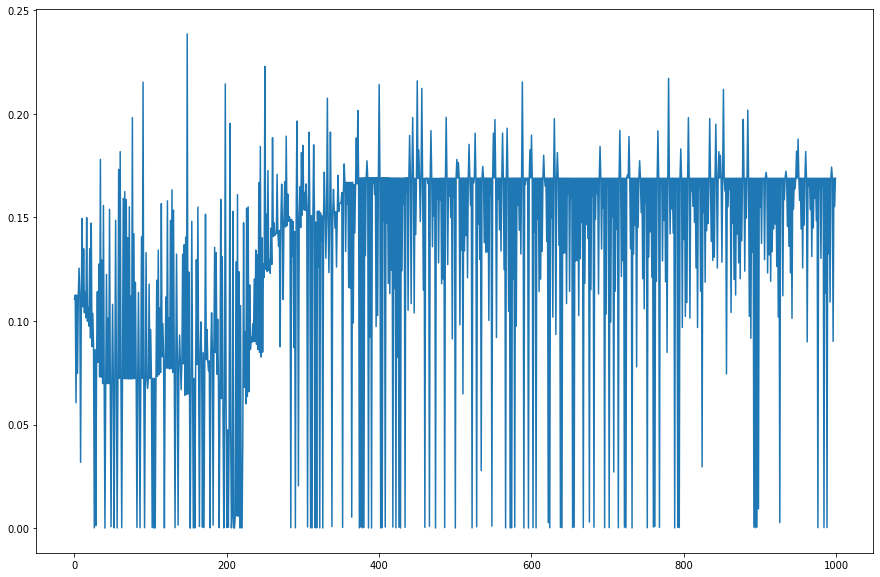

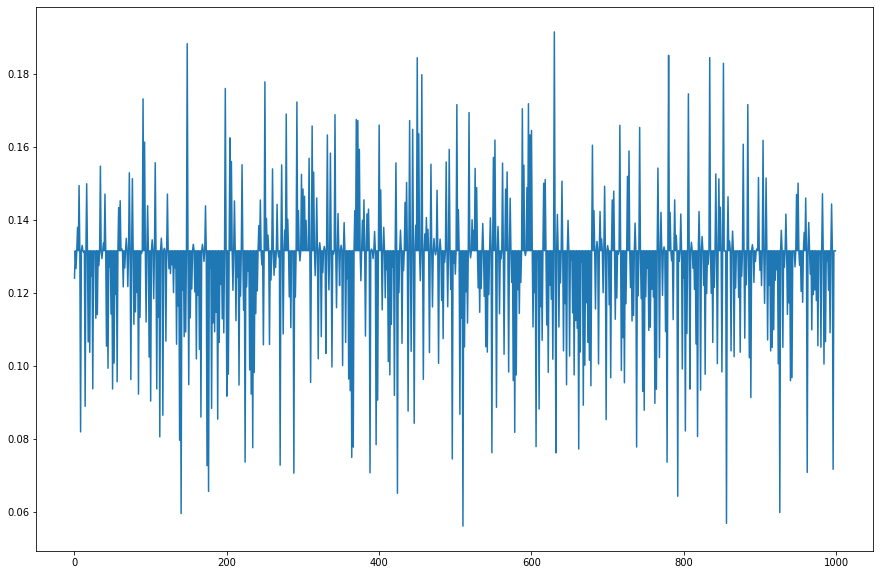

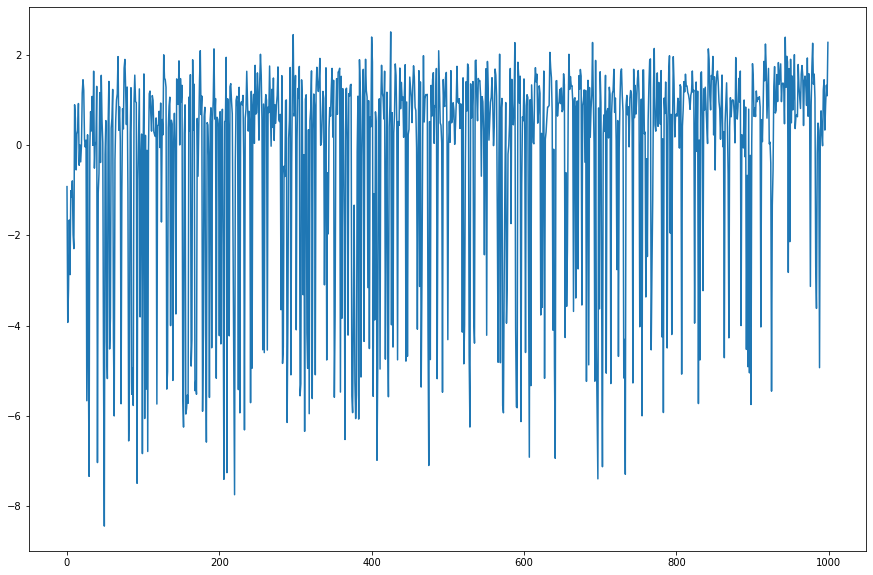

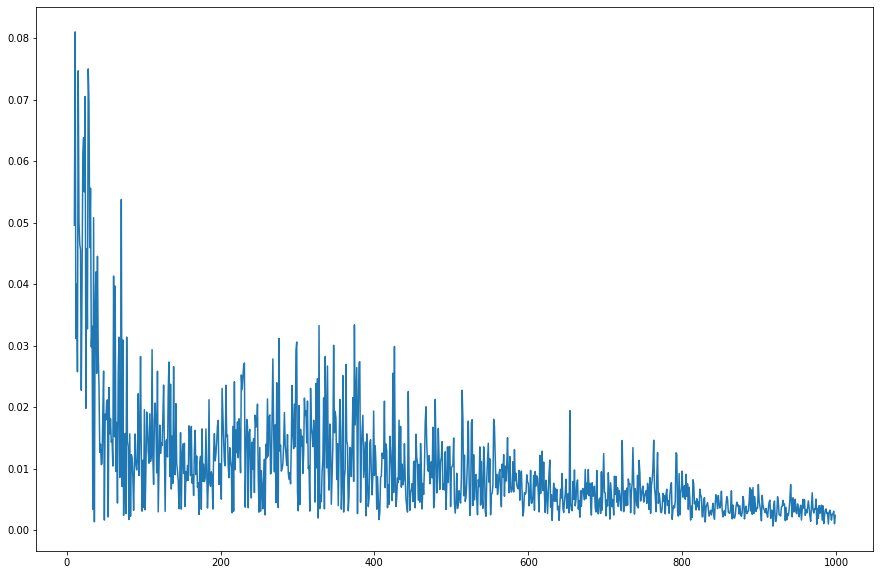

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.99)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

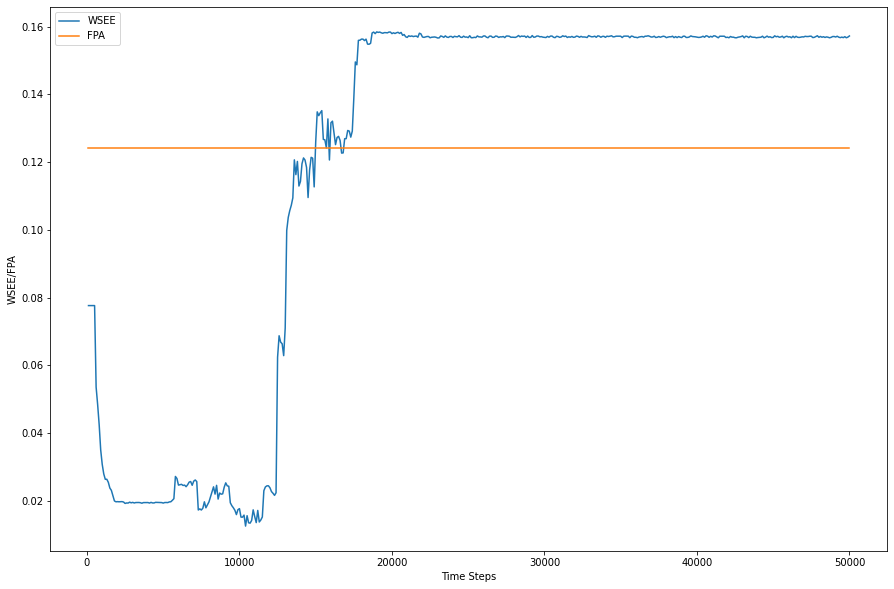

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

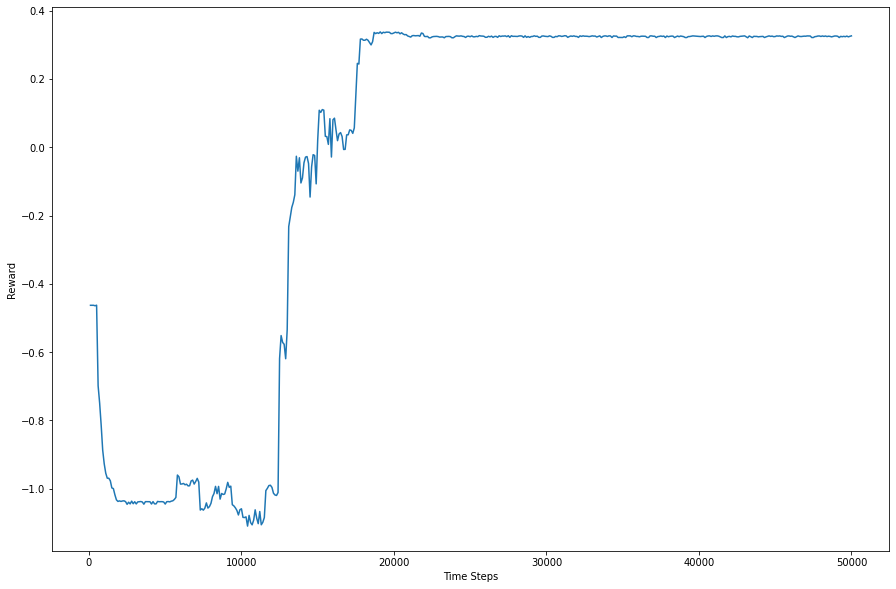

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
